# What this code does
details

## Import ....

In [1]:
import torch
import torchvision
#torch.cuda.is_available()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
#from torch.autograd.functional import jacobian
#import torch.autograd.functional
import time
import copy
import matplotlib.pyplot as plt
import pandas as pd
torch.set_default_dtype(torch.float64)
batch_size=100
input_size=784
output_size=784
hidden_state_size=10
no_of_layer=2
font = {
        'size'   : 30}
plt.rc('font', **font)

class AE(nn.Module):
    def __init__(self, input_shape,hidden_layer_shape,encoder_output_shape,n,xinit=torch.eye(batch_size,input_size),xfinal=torch.eye(batch_size,input_size),hidden=torch.eye(10,input_size)):
        super().__init__()
        self.encoder_input_layer = nn.Linear(
            in_features=input_shape, out_features=hidden_layer_shape
        )
        self.hidden_layer=nn.Linear(
            in_features=hidden_layer_shape, out_features=hidden_layer_shape
        )
        self.encoder_output_layer = nn.Linear(
            in_features=hidden_layer_shape, out_features=encoder_output_shape
        )
        self.decoder_input_layer = nn.Linear(
            in_features=encoder_output_shape, out_features=hidden_layer_shape
        )
        self.decoder_output_layer = nn.Linear(
            in_features=hidden_layer_shape, out_features=input_shape
        )
        self.number_of_layers=n
        self.xinit=xinit
        self.xfinal=xfinal
        self.hidden=hidden

    def forward(self, features):
        reconstructed=self.internals(features)
        return reconstructed
    
    def internals(self,features):
        code=self.encoder(features)
        self.hidden=code
        #print("hidden state:"+str(code))
        reconstructed=self.decoder(code)
        return reconstructed
    
    def encoder(self,features):
        activation = self.encoder_input_layer(features)
        x = torch.relu(activation)
        self.xinit=x
        for i in range(self.number_of_layers):
            x=torch.relu(self.hidden_layer(x))
        code = self.encoder_output_layer(x)
        result = torch.relu(code)
        return result
    
    def decoder(self,code):
        activation = self.decoder_input_layer(code)
        x = torch.relu(activation)
        for i in range(self.number_of_layers):
             x=torch.relu(self.hidden_layer(x))
        self.xfinal=x
        activation = self.decoder_output_layer(x)
        reconstructed = torch.relu(activation)
        return reconstructed
    
    def xfinals(self):
        return self.xfinal
    
    def xinits(self):
        return self.xinit
    
    def hiddens(self):
        return self.hidden

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

#transform=
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([
    transforms.ToTensor()
]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([
    transforms.ToTensor()
]))  
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=batch_size,shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=batch_size,shuffle=False)

In [3]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_size,output_size,hidden_state_size,no_of_layer).to(device)
# create an optimizer object
# Adam optimizer with learning rate 1e-3

optimizer =torch.optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

cuda


In [4]:
import matplotlib.pyplot as plt 
epochs=10000
asymptotic_repetition=200


#projected_jacobian=[]
ave_len=5


no_of_images,no_of_repetition=100,100
colour=np.arange(1,no_of_repetition+1)
perturbation_strength=10**(-6)
noise_strength=10**(-3)
interval=50

In [5]:
def add_noise(inputs,strength):
    
    noise = torch.randn_like(inputs)*strength
    return inputs + noise
def validation(test_loader):
    
    with torch.no_grad():

     #valid_loss = criterion(outputs, batch_features.view(batch_size,-1).to(device))
        loss=0
        for batch_features, _ in test_loader:
            #input=add_noise(batch_features,).view(100, -1).to(device)
            input_image=add_noise(batch_features,noise_strength).view(batch_size, -1).to(device)
            batch_feature = batch_features.view(batch_size, -1).to(device)
            outputs = model(input_image)
            valid_loss = criterion(outputs, input_image) 
            #accuracy+=kl_div(outputs,batch_features)/batch_size
            loss += valid_loss.item()
    return loss/len(test_loader)
            
def kl_div(output_image,input_image):
    accuracy=0
    kl_loss = nn.KLDivLoss(reduction="batchmean")
    for i in range(len(input_image)):
        input_spectrum=torch.histogram(input_image[i].cpu(), bins=256, density=True)
        output_spectrum=torch.histogram(output_image[i].cpu(), bins=256, density=True)
        accuracy+=kl_loss(input_spectrum[i],output_spectrum[i])
    return accuracy/len(input_image)/256

def iteration(model,initial_inputs,no_of_repetition,epoch):
    y_pred=initial_inputs.to(device)
    for i in range(no_of_repetition):
        x_train=y_pred
        #if i==0:
           # name="progress asymptotic iteration:"+str(i)+" "
           # visualisation(x_train[0].cpu().detach(),epoch,name,False)
        #if i%5==1:
            #name="progress asymptotic iteration:"+str(i)+" "
            #visualisation(x_train[0].cpu().detach(),epoch,name,False)
        y_pred=model.internals(x_train)
    return x_train,y_pred,model 

def asymptotic_jacobian(model,initial_input,no_of_images,no_of_repetition):
    ave_jac=0
    for j in range(no_of_repetition):
        #print("here")
        x_train=initial_input.to(device)
        y_pred=x_train
        mean_jacobian=0
        for i in range(no_of_images):
            x=x_train[i]
            res=torch.autograd.functional.jacobian(model.internals,x)
            norm=torch.norm(res).cpu()
            mean_jacobian+=1/np.sqrt(output_size)*norm
        mean_jacobian=mean_jacobian/no_of_images
        ave_jac+=mean_jacobian
    average_jacobian=ave_jac/no_of_repetition
    return average_jacobian

def spectral_radius(model,initial_input,no_of_repetition,no_of_images):
    result=[]
   
    output=initial_input.to(device)
    product=torch.eye(n=input_size,m=output_size).to(device)
    
    spectral=0

    for i in range(no_of_repetition):
        
        res=torch.autograd.functional.jacobian(model.internals,initial_input)
        product=torch.matmul(product,res)
        output=model(initial_input)
        initial_input=output
    
    s,v=torch.linalg.eig(product)
    #print(s)
    abs=torch.abs(s)
    spectral=np.pow(torch.max(abs).item(),1/no_of_repetition)
    return spectral

def poincare_plot(model,initial_input,dimension_vector,no_of_repetition,colour,epoch):
    xt=[]
    xtminus=[]
    
    output=initial_input
    
    for i in range(no_of_repetition):
        
        initial_input=output
        output=model(initial_input)
        
        xt.append(1/output_size*torch.dot(output,dimension_vector).item())
        xtminus.append(1/output_size*torch.dot(initial_input,dimension_vector).item())
    
    return xt,xtminus
  
    


def asymptotic_distance(xinfinity_unperturbed,xinfinity_perturbed,perturbation):
    result=[]
    for i in range(len(xinfinity_unperturbed)):
    
        sum=0
        
        for j in range(len(xinfinity_unperturbed[i])):
            
            temp=np.linalg.norm(xinfinity_unperturbed[i][j]-xinfinity_perturbed[i][j])
            sum+=temp
        
        result.append(1/output_size*1/len(xinfinity_unperturbed[i])*sum) 
    
    return result


def calculation(model,no_of_images,no_of_repetition,ave_jacobian,spectral_radiuses,image,epoch):
    spectral=0
    
    model_clone=AE(input_size,input_size,hidden_state_size,no_of_layer).to(device)
    model_clone.load_state_dict(copy.deepcopy(model.state_dict()))

    x_train,y_pred,model_clone=iteration(model_clone,image,asymptotic_repetition,epoch)   
    ave_jac = asymptotic_jacobian(model_clone,x_train,100,no_of_repetition)
   
    average_jacobian.append(ave_jac)
    
    #for i in range(no_of_images):
    
        #spectral+=spectral_radius(model_clone,x_train[i],no_of_repetition,no_of_images)
    
   # spectral_radiuses.append(spectral/no_of_images)
    return x_train,y_pred,average_jacobian,spectral_radiuses,model_clone


def asymptotic_iteration(model,initial_inputs,perturbed_inputs,no_of_repetition,no_of_image,cutoff):
    
    y_pred_unperturbed=initial_inputs.to(device)
    y_pred_perturbed=perturbed_inputs.to(device)
    
    distance=[]
    hidden_layer=[]
    hiddens=[]
    chaos=0
    lowest=10**10
    dist=[]
    for i in range(no_of_repetition):
        x_train_unperturbed=y_pred_unperturbed
        y_pred_unperturbed=model.internals(x_train_unperturbed)
        
       
        x_train_perturbed=y_pred_perturbed
        y_pred_perturbed=model.internals(x_train_perturbed)
        
        hidden = model.hiddens()
        #print(hidden)
        #print(torch.sum(hidden,dim=1).cpu().detach().numpy()/1000)
        hidden_layer.append(torch.sum(hidden,dim=1)[0].cpu().detach().numpy()/10)
        hiddens.append(torch.sum(hidden,dim=1).cpu().detach().numpy()/10)
        
        #visualisation(y_pred.view(batch_size,-1)[0].cpu().detach(),epoch)


        diff=0
        divergent=0
        if i ==no_of_repetition-1:
            for j in range(no_of_image):
                divergent+=divergence(hiddens[j])
                
                result=torch.norm(y_pred_unperturbed[j]-y_pred_perturbed[j])
                dist.append(result.cpu().detach().numpy())
        for j in range(no_of_image):
            result=torch.norm(y_pred_unperturbed[j]-y_pred_perturbed[j])
            diff+=result
            if result>cutoff and i==no_of_repetition-1:
                chaos+=1
            
        distance.append(diff.cpu().detach().numpy()/no_of_image)
     
        hidden_layer
    return dist,distance,hidden_layer,chaos/no_of_image,divergent

def visualisation(xfinals,epoch,name,bool):
    plt.imshow(xfinals.reshape(28,28), cmap="gray")
    if bool:
        plt.savefig(str(name)+" epoch:"+str(epoch+1)+".jpg")
    plt.show()
    print(str(name)+" epoch:"+str(epoch+1)+".jpg")
def divergence(values):
    result=np.abs(values[-1]-values[-2])
    if result>np.abs(values[2]-values[1]):
        return 1
    return 0
def moving_average(number_of_averages,W):
    averaged_points=[]
    for i in range(len(W)-number_of_averages):
        average=0
        for j in range(number_of_averages):
            average+=W[i+j]
        average=average/number_of_averages
        averaged_points.append(average)
    return averaged_points             

    


running
epoch : 1/10000, training loss = 0.062955,validation loss = 0.045414
epoch : 2/10000, training loss = 0.037836,validation loss = 0.033543
epoch : 3/10000, training loss = 0.031009,validation loss = 0.029960
epoch : 4/10000, training loss = 0.028736,validation loss = 0.028457
epoch : 5/10000, training loss = 0.027543,validation loss = 0.027307
epoch : 6/10000, training loss = 0.026704,validation loss = 0.026375
epoch : 7/10000, training loss = 0.025512,validation loss = 0.025583
epoch : 8/10000, training loss = 0.024467,validation loss = 0.024043
epoch : 9/10000, training loss = 0.023808,validation loss = 0.023882
epoch : 10/10000, training loss = 0.022891,validation loss = 0.022724
epoch : 11/10000, training loss = 0.022315,validation loss = 0.022628
epoch : 12/10000, training loss = 0.022139,validation loss = 0.022416
epoch : 13/10000, training loss = 0.021966,validation loss = 0.022181
epoch : 14/10000, training loss = 0.021542,validation loss = 0.021827
epoch : 15/10000, tra

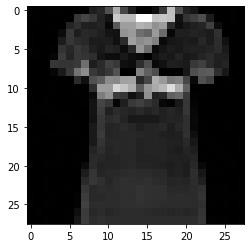

asymptotic image input epoch:50.jpg


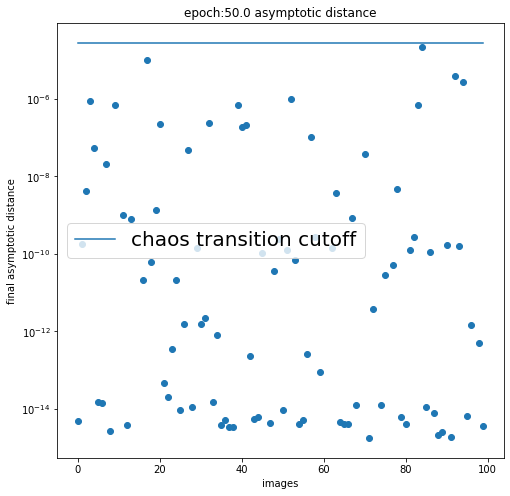

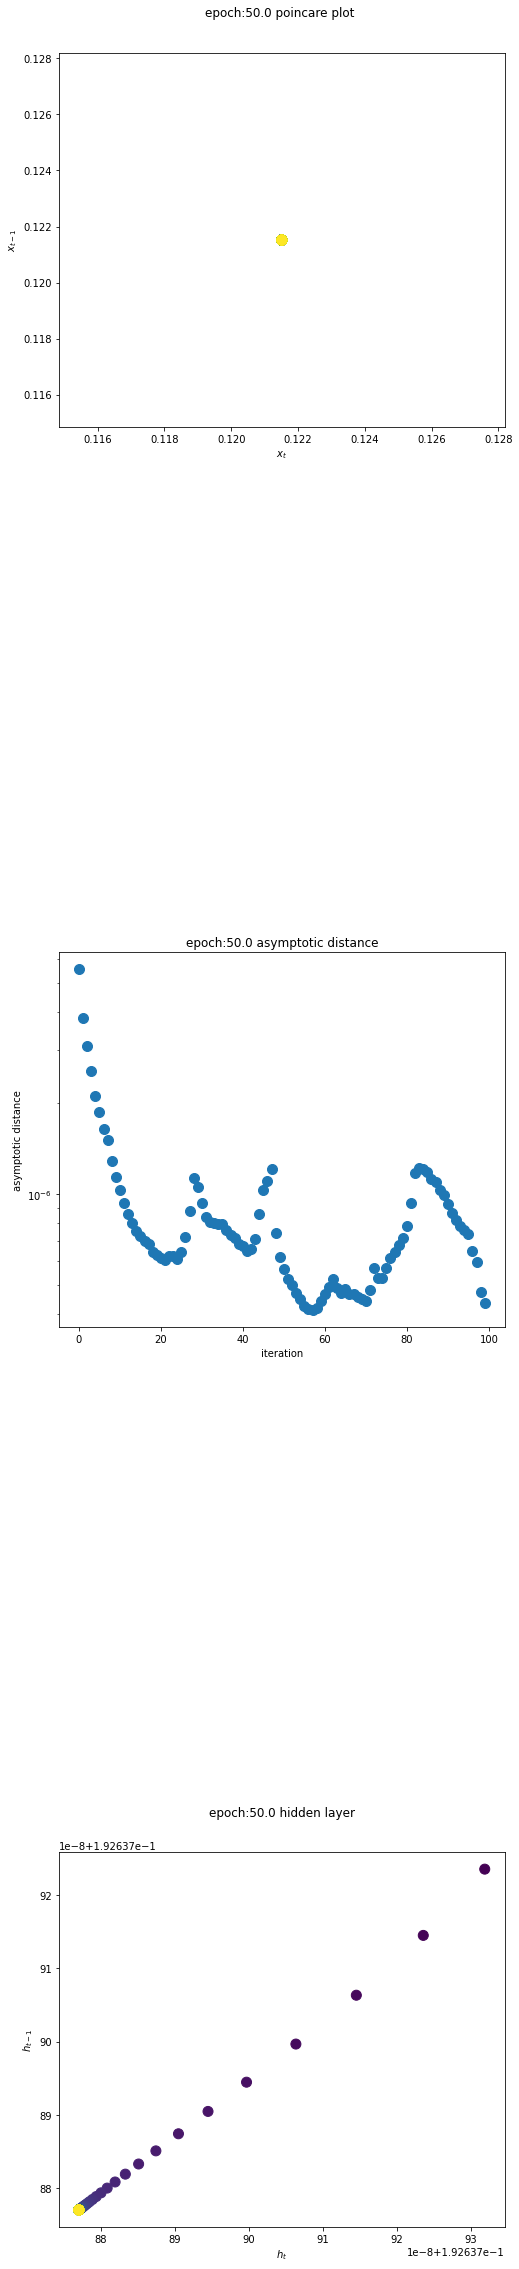

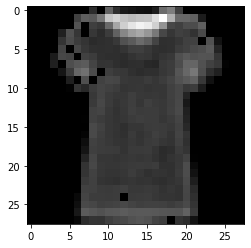

asymptotic image output epoch:50.jpg
epoch : 51/10000, training loss = 0.019120,validation loss = 0.020354
epoch : 52/10000, training loss = 0.019074,validation loss = 0.020304
epoch : 53/10000, training loss = 0.019141,validation loss = 0.020362
epoch : 54/10000, training loss = 0.019036,validation loss = 0.020283
epoch : 55/10000, training loss = 0.019015,validation loss = 0.020221
epoch : 56/10000, training loss = 0.018989,validation loss = 0.020274
epoch : 57/10000, training loss = 0.018991,validation loss = 0.020291
epoch : 58/10000, training loss = 0.018909,validation loss = 0.020179
epoch : 59/10000, training loss = 0.018883,validation loss = 0.020174
epoch : 60/10000, training loss = 0.018902,validation loss = 0.020182
epoch : 61/10000, training loss = 0.018851,validation loss = 0.020116
epoch : 62/10000, training loss = 0.018919,validation loss = 0.020176
epoch : 63/10000, training loss = 0.018890,validation loss = 0.020216
epoch : 64/10000, training loss = 0.018832,validation

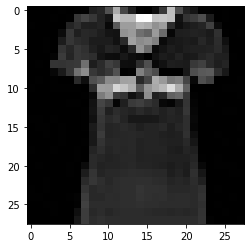

asymptotic image input epoch:100.jpg


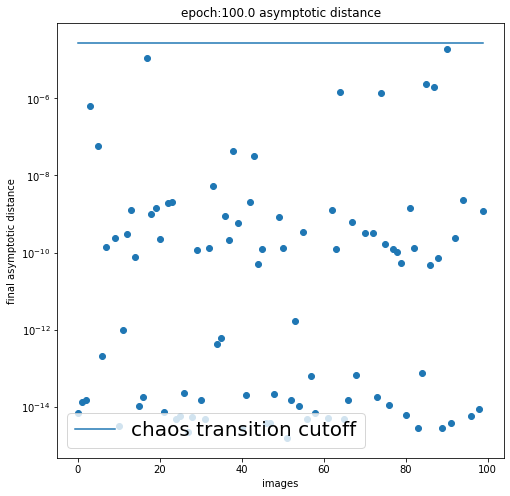

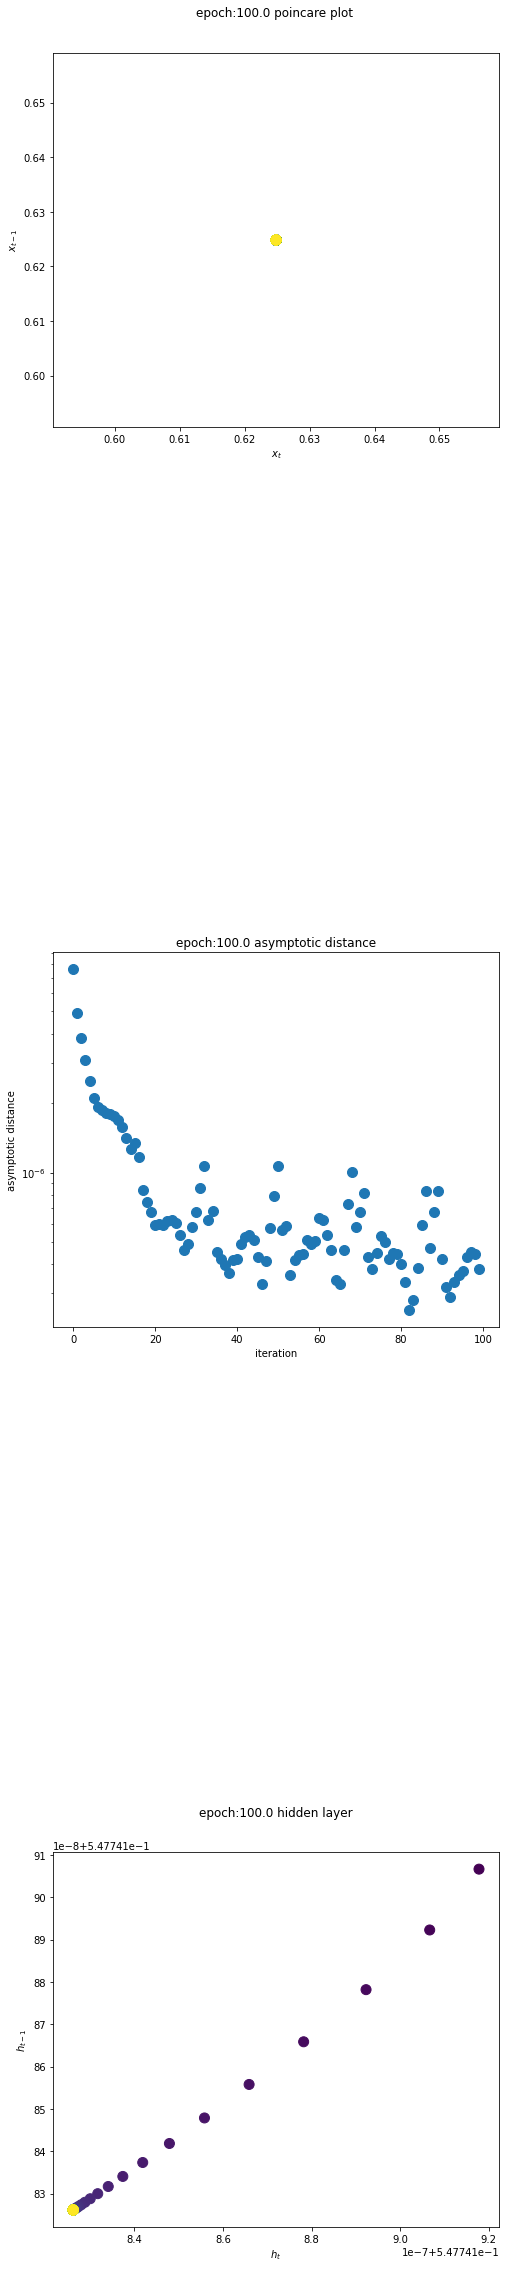

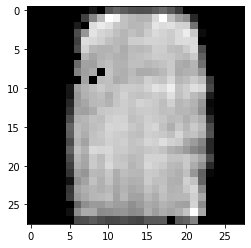

asymptotic image output epoch:100.jpg
epoch : 101/10000, training loss = 0.017822,validation loss = 0.019527
epoch : 102/10000, training loss = 0.017885,validation loss = 0.019694
epoch : 103/10000, training loss = 0.017794,validation loss = 0.019701
epoch : 104/10000, training loss = 0.017811,validation loss = 0.019731
epoch : 105/10000, training loss = 0.017793,validation loss = 0.019666
epoch : 106/10000, training loss = 0.017773,validation loss = 0.019663
epoch : 107/10000, training loss = 0.017821,validation loss = 0.019598
epoch : 108/10000, training loss = 0.017742,validation loss = 0.019993
epoch : 109/10000, training loss = 0.017881,validation loss = 0.019645
epoch : 110/10000, training loss = 0.017795,validation loss = 0.019781
epoch : 111/10000, training loss = 0.017807,validation loss = 0.019599
epoch : 112/10000, training loss = 0.017728,validation loss = 0.019645
epoch : 113/10000, training loss = 0.017765,validation loss = 0.019600
epoch : 114/10000, training loss = 0.01

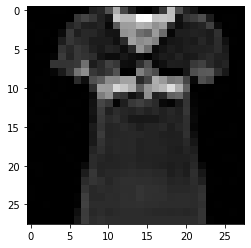

asymptotic image input epoch:150.jpg


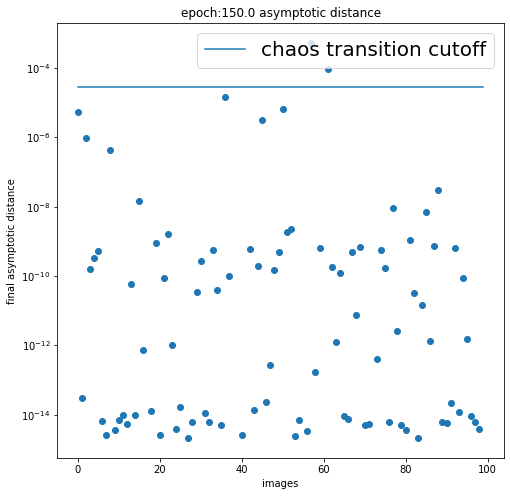

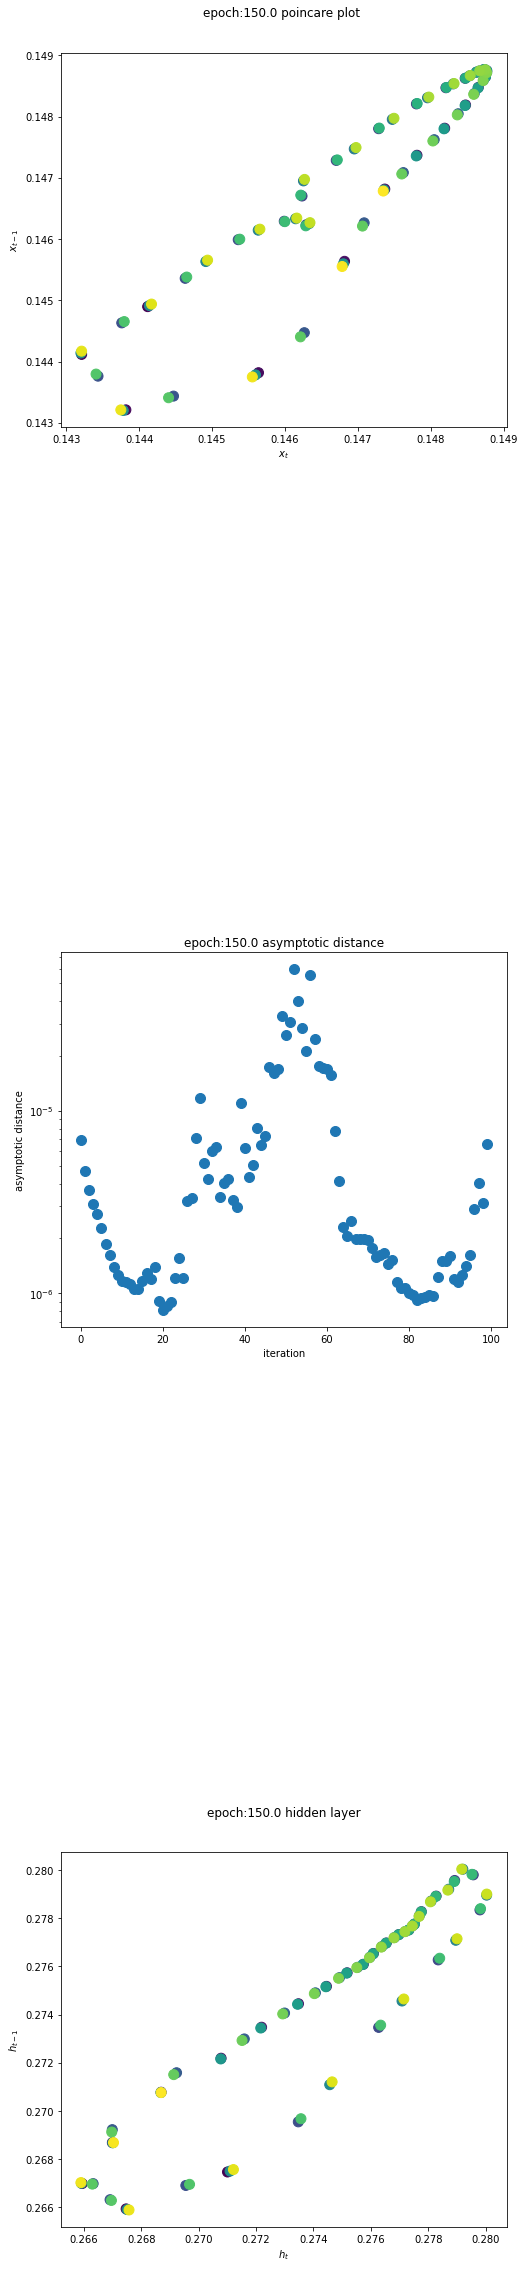

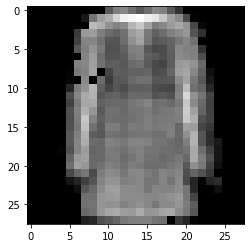

asymptotic image output epoch:150.jpg
epoch : 151/10000, training loss = 0.017569,validation loss = 0.019794
epoch : 152/10000, training loss = 0.017551,validation loss = 0.019631
epoch : 153/10000, training loss = 0.017512,validation loss = 0.019934
epoch : 154/10000, training loss = 0.017544,validation loss = 0.019676
epoch : 155/10000, training loss = 0.017493,validation loss = 0.019710
epoch : 156/10000, training loss = 0.017519,validation loss = 0.019682
epoch : 157/10000, training loss = 0.017495,validation loss = 0.019666
epoch : 158/10000, training loss = 0.017506,validation loss = 0.019579
epoch : 159/10000, training loss = 0.017441,validation loss = 0.019740
epoch : 160/10000, training loss = 0.017498,validation loss = 0.019641
epoch : 161/10000, training loss = 0.017568,validation loss = 0.019732
epoch : 162/10000, training loss = 0.017458,validation loss = 0.019657
epoch : 163/10000, training loss = 0.017484,validation loss = 0.019737
epoch : 164/10000, training loss = 0.01

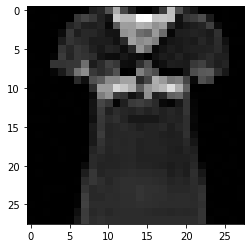

asymptotic image input epoch:200.jpg


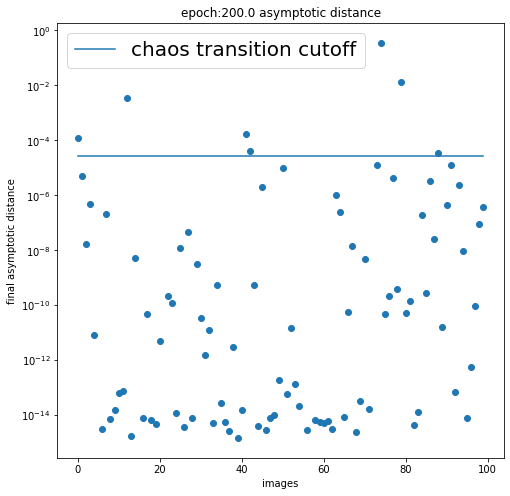

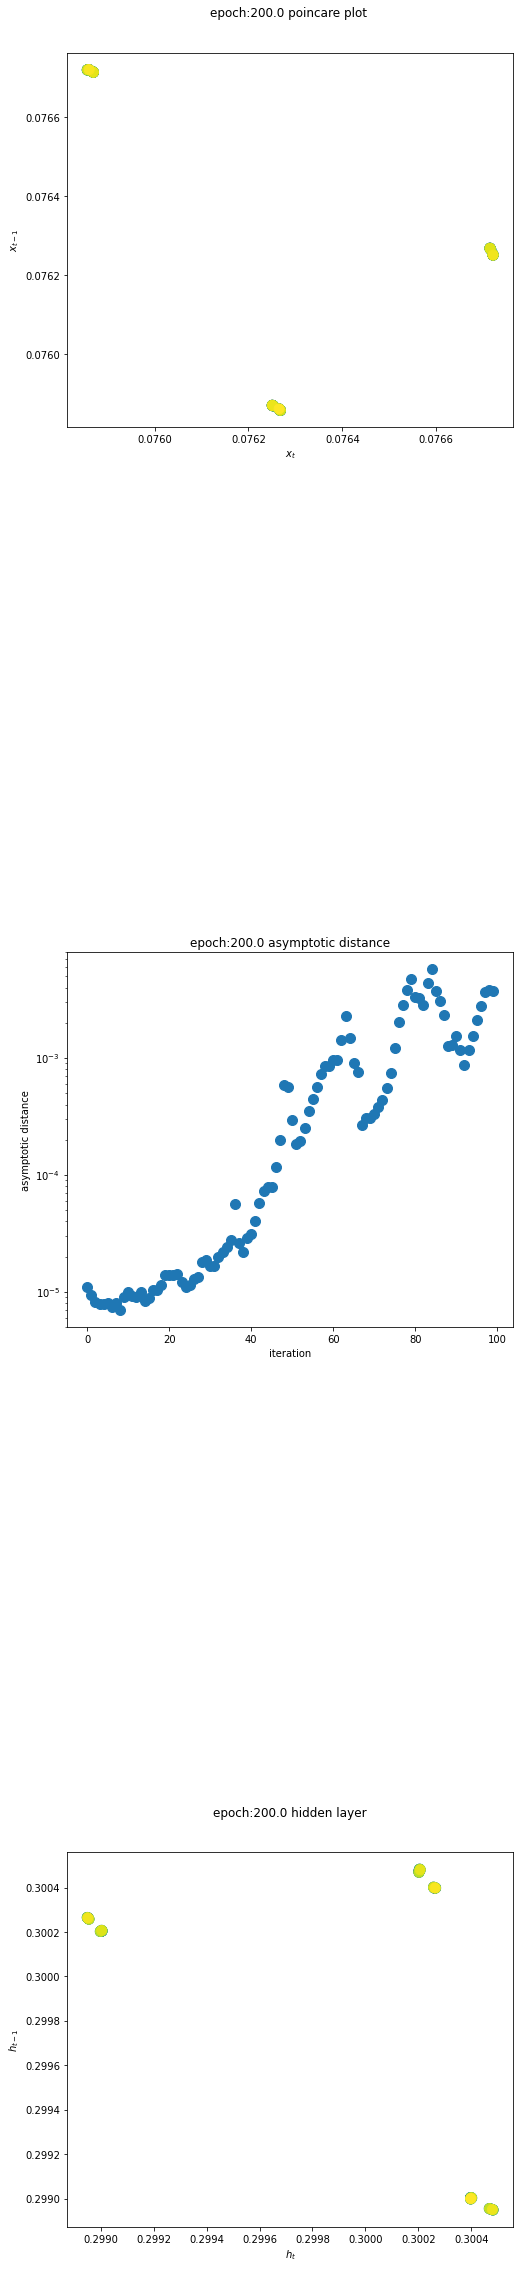

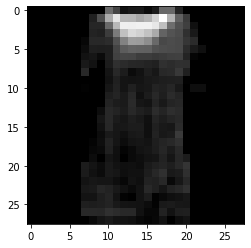

asymptotic image output epoch:200.jpg
epoch : 201/10000, training loss = 0.017346,validation loss = 0.019942
epoch : 202/10000, training loss = 0.017320,validation loss = 0.019731
epoch : 203/10000, training loss = 0.017278,validation loss = 0.020019
epoch : 204/10000, training loss = 0.017382,validation loss = 0.019827
epoch : 205/10000, training loss = 0.017373,validation loss = 0.019731
epoch : 206/10000, training loss = 0.017296,validation loss = 0.019894
epoch : 207/10000, training loss = 0.017244,validation loss = 0.019756
epoch : 208/10000, training loss = 0.017359,validation loss = 0.019906
epoch : 209/10000, training loss = 0.017320,validation loss = 0.019747
epoch : 210/10000, training loss = 0.017273,validation loss = 0.019904
epoch : 211/10000, training loss = 0.017297,validation loss = 0.019858
epoch : 212/10000, training loss = 0.017276,validation loss = 0.019815
epoch : 213/10000, training loss = 0.017282,validation loss = 0.019834
epoch : 214/10000, training loss = 0.01

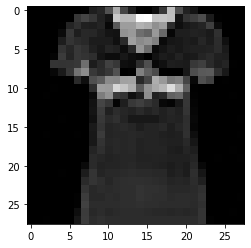

asymptotic image input epoch:250.jpg


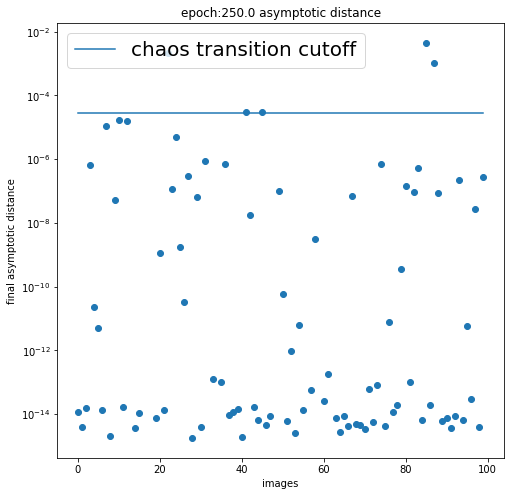

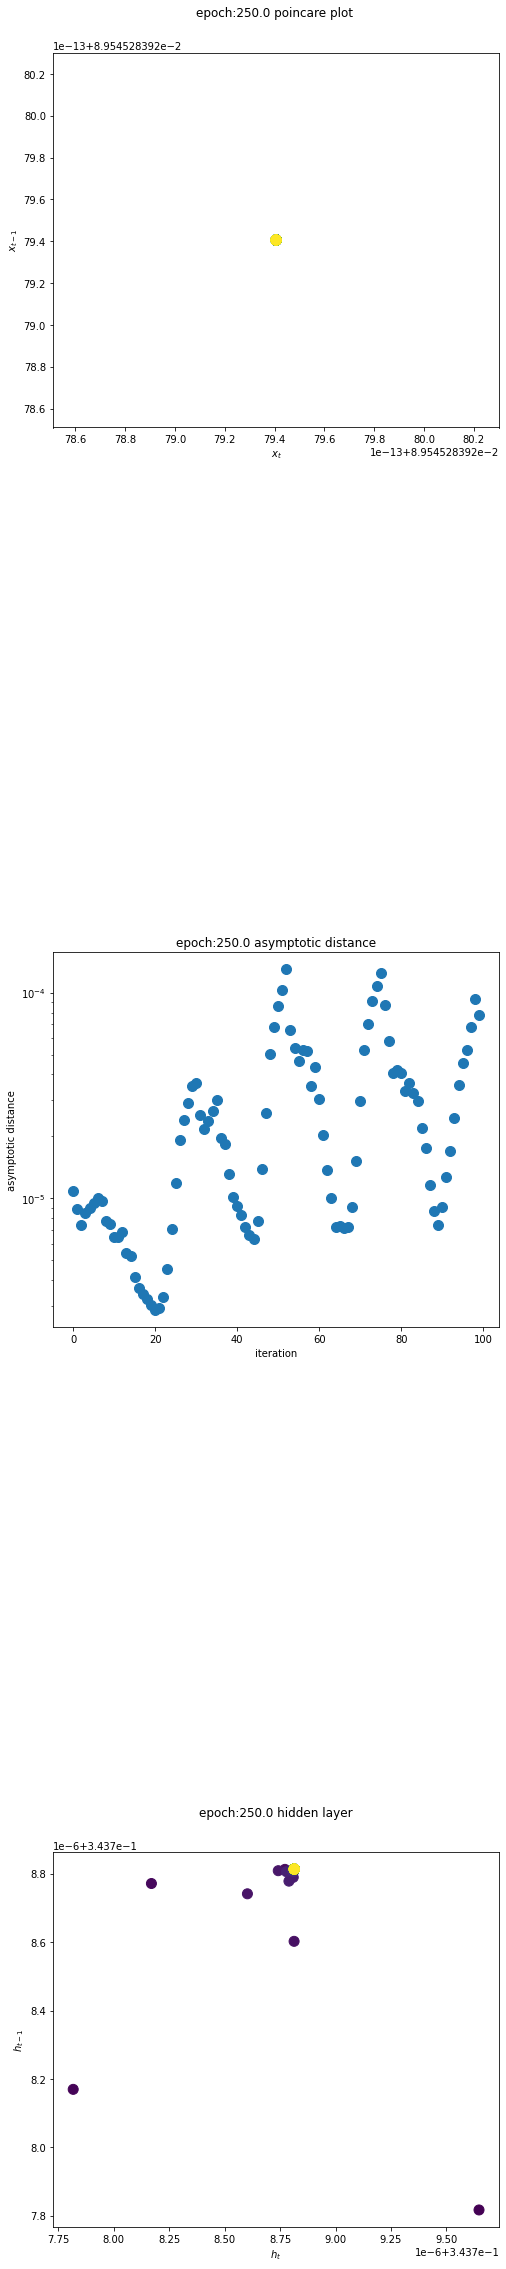

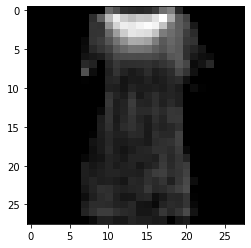

asymptotic image output epoch:250.jpg
epoch : 251/10000, training loss = 0.017210,validation loss = 0.019923
epoch : 252/10000, training loss = 0.017163,validation loss = 0.019924
epoch : 253/10000, training loss = 0.017157,validation loss = 0.019810
epoch : 254/10000, training loss = 0.017167,validation loss = 0.019901
epoch : 255/10000, training loss = 0.017160,validation loss = 0.019986
epoch : 256/10000, training loss = 0.017138,validation loss = 0.019844
epoch : 257/10000, training loss = 0.017080,validation loss = 0.019807
epoch : 258/10000, training loss = 0.017260,validation loss = 0.020013
epoch : 259/10000, training loss = 0.017166,validation loss = 0.019913
epoch : 260/10000, training loss = 0.017211,validation loss = 0.019888
epoch : 261/10000, training loss = 0.017253,validation loss = 0.019862
epoch : 262/10000, training loss = 0.017134,validation loss = 0.019863
epoch : 263/10000, training loss = 0.017150,validation loss = 0.019964
epoch : 264/10000, training loss = 0.01

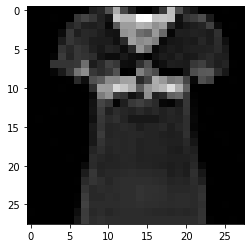

asymptotic image input epoch:300.jpg


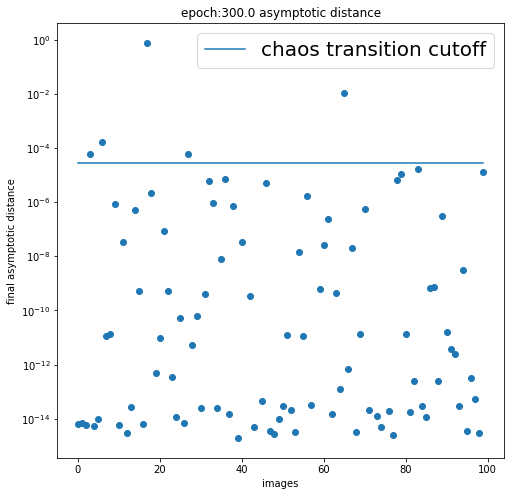

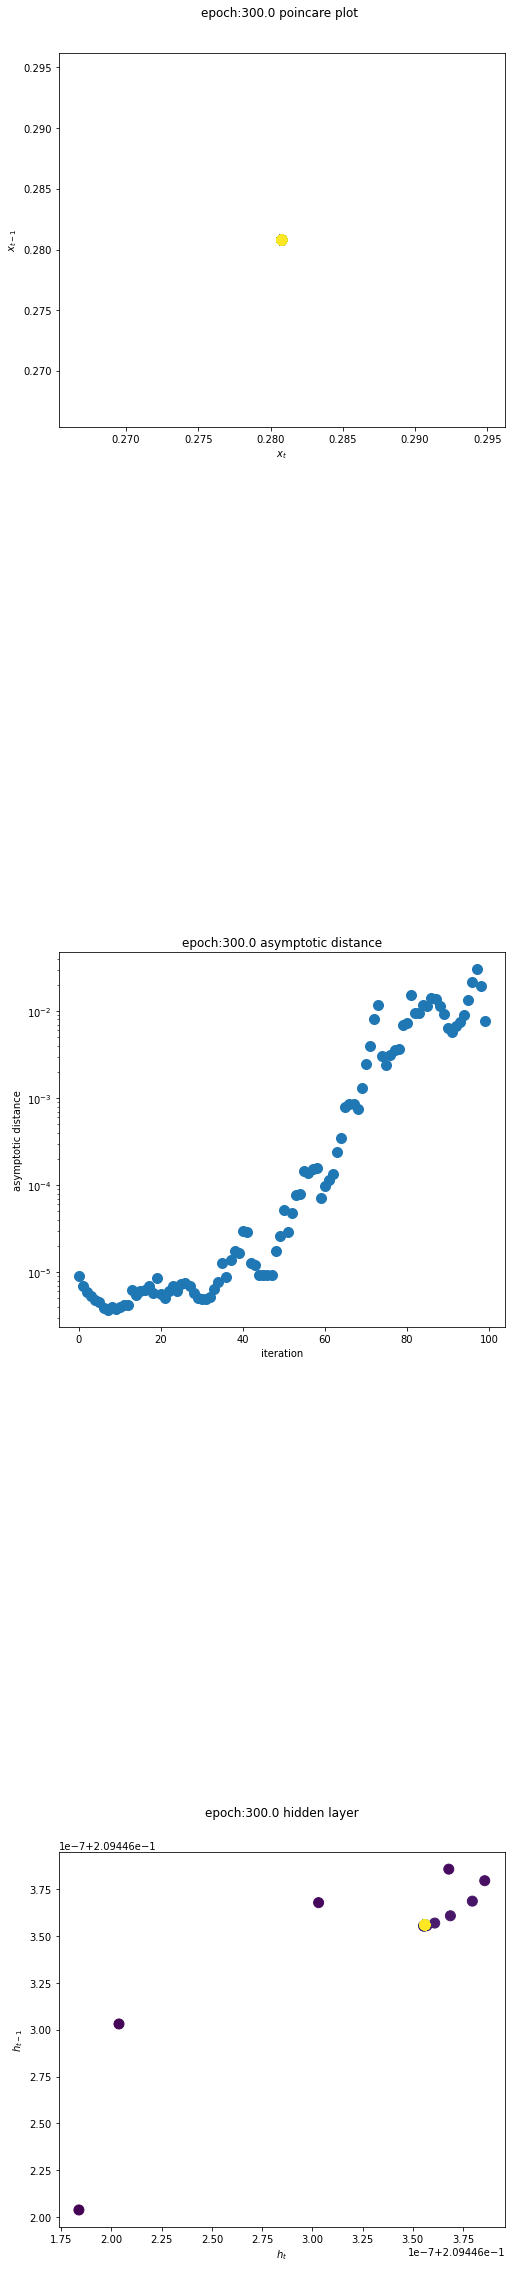

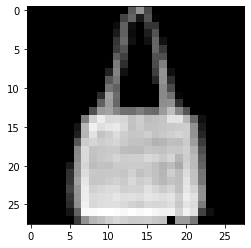

asymptotic image output epoch:300.jpg
epoch : 301/10000, training loss = 0.017003,validation loss = 0.019913
epoch : 302/10000, training loss = 0.017053,validation loss = 0.020085
epoch : 303/10000, training loss = 0.017074,validation loss = 0.019988
epoch : 304/10000, training loss = 0.017083,validation loss = 0.019977
epoch : 305/10000, training loss = 0.017014,validation loss = 0.019877
epoch : 306/10000, training loss = 0.017073,validation loss = 0.019974
epoch : 307/10000, training loss = 0.016951,validation loss = 0.019908
epoch : 308/10000, training loss = 0.017058,validation loss = 0.020003
epoch : 309/10000, training loss = 0.017047,validation loss = 0.019922
epoch : 310/10000, training loss = 0.017035,validation loss = 0.019920
epoch : 311/10000, training loss = 0.017027,validation loss = 0.019979
epoch : 312/10000, training loss = 0.016975,validation loss = 0.019936
epoch : 313/10000, training loss = 0.017030,validation loss = 0.020066
epoch : 314/10000, training loss = 0.01

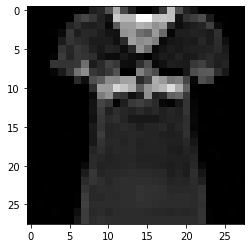

asymptotic image input epoch:350.jpg


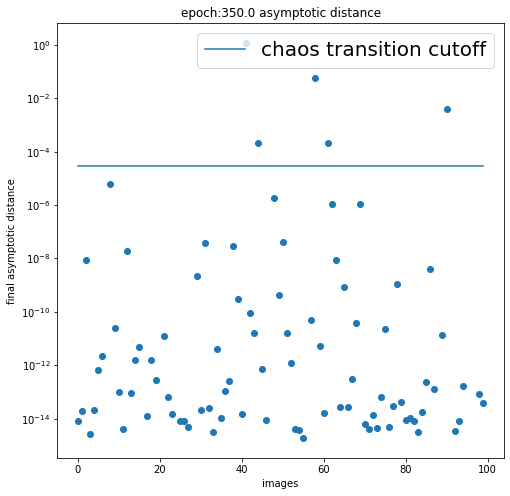

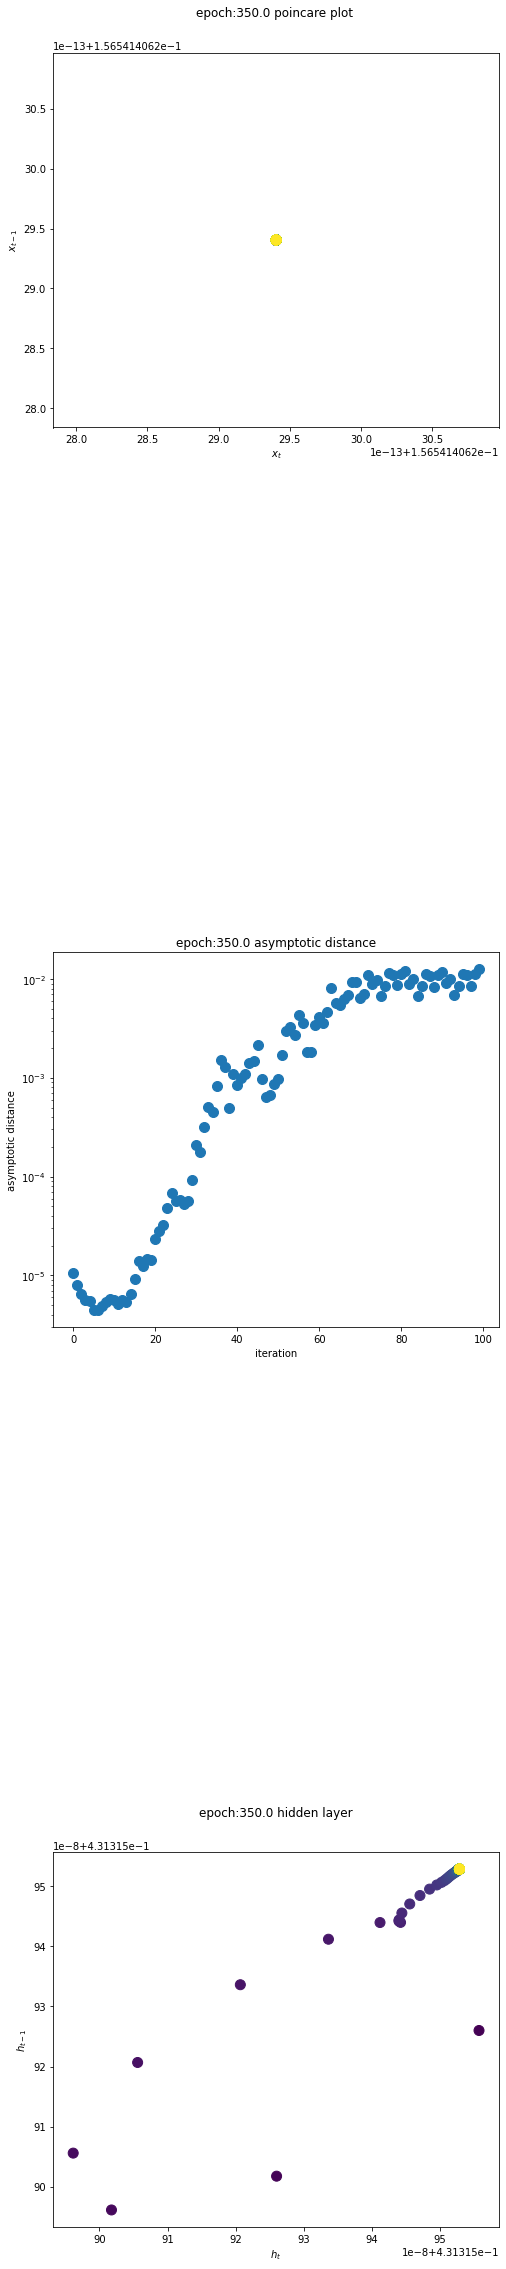

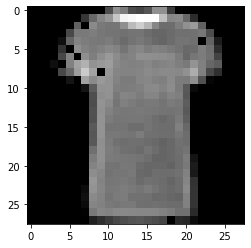

asymptotic image output epoch:350.jpg
epoch : 351/10000, training loss = 0.016610,validation loss = 0.019670
epoch : 352/10000, training loss = 0.016611,validation loss = 0.019730
epoch : 353/10000, training loss = 0.016597,validation loss = 0.019680
epoch : 354/10000, training loss = 0.016697,validation loss = 0.019741
epoch : 355/10000, training loss = 0.016558,validation loss = 0.019693
epoch : 356/10000, training loss = 0.016604,validation loss = 0.019822
epoch : 357/10000, training loss = 0.016644,validation loss = 0.019841
epoch : 358/10000, training loss = 0.016754,validation loss = 0.019965
epoch : 359/10000, training loss = 0.016643,validation loss = 0.019743
epoch : 360/10000, training loss = 0.016550,validation loss = 0.019750
epoch : 361/10000, training loss = 0.016615,validation loss = 0.019734
epoch : 362/10000, training loss = 0.016648,validation loss = 0.019766
epoch : 363/10000, training loss = 0.016740,validation loss = 0.019799
epoch : 364/10000, training loss = 0.01

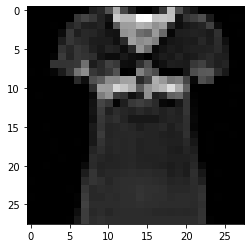

asymptotic image input epoch:400.jpg


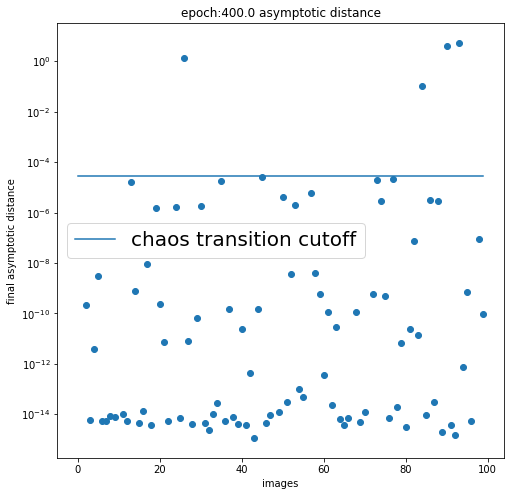

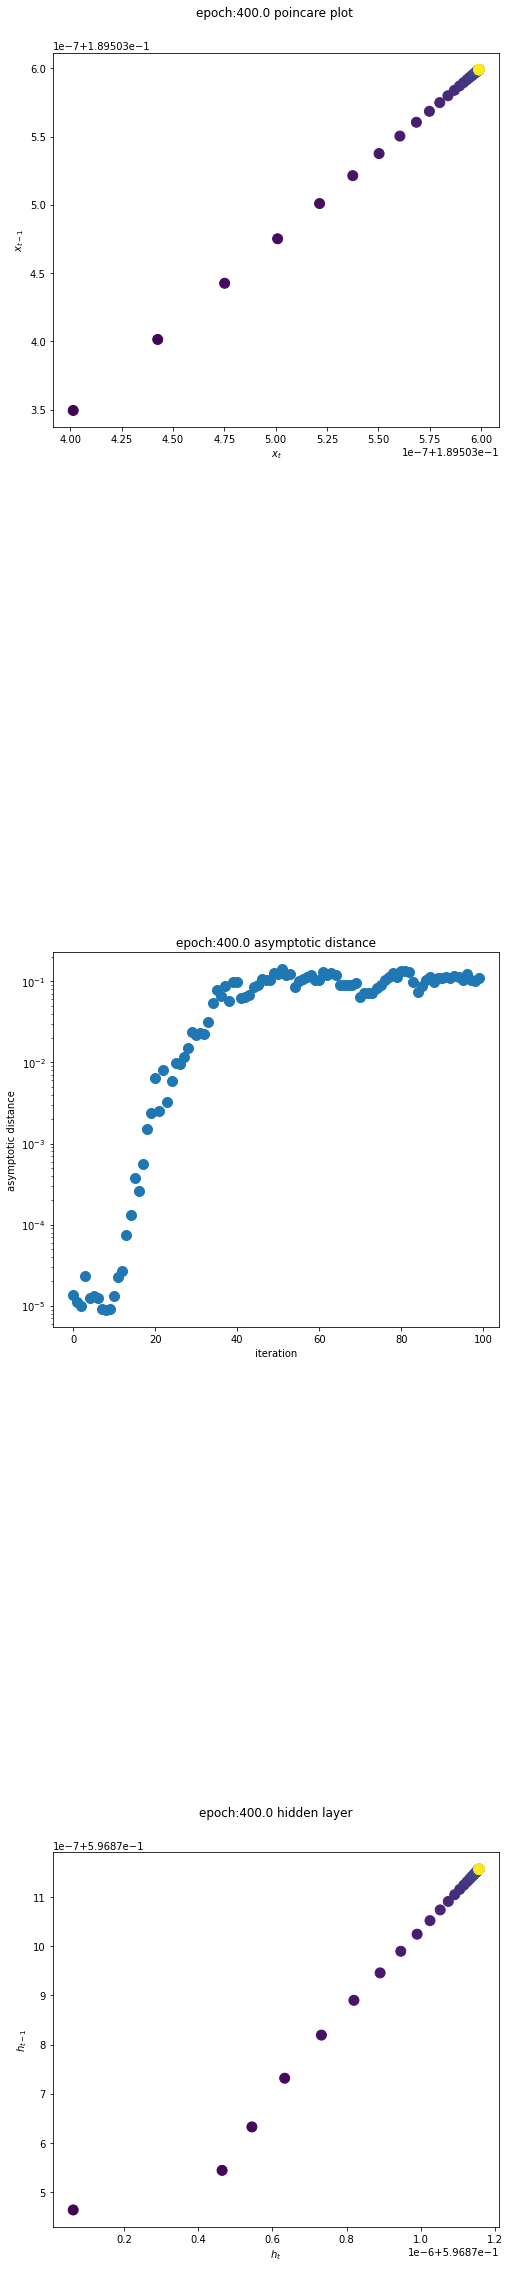

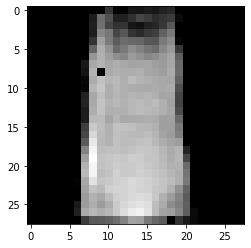

asymptotic image output epoch:400.jpg
epoch : 401/10000, training loss = 0.016561,validation loss = 0.019728
epoch : 402/10000, training loss = 0.016581,validation loss = 0.019692
epoch : 403/10000, training loss = 0.016513,validation loss = 0.019722
epoch : 404/10000, training loss = 0.016589,validation loss = 0.019717
epoch : 405/10000, training loss = 0.016514,validation loss = 0.019783
epoch : 406/10000, training loss = 0.016446,validation loss = 0.019662
epoch : 407/10000, training loss = 0.016441,validation loss = 0.019651
epoch : 408/10000, training loss = 0.016566,validation loss = 0.019695
epoch : 409/10000, training loss = 0.016531,validation loss = 0.019758
epoch : 410/10000, training loss = 0.016594,validation loss = 0.019971
epoch : 411/10000, training loss = 0.016512,validation loss = 0.019769
epoch : 412/10000, training loss = 0.016422,validation loss = 0.019832
epoch : 413/10000, training loss = 0.016557,validation loss = 0.019729
epoch : 414/10000, training loss = 0.01

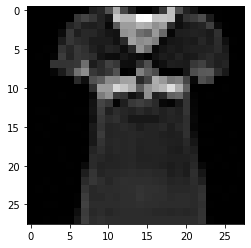

asymptotic image input epoch:450.jpg


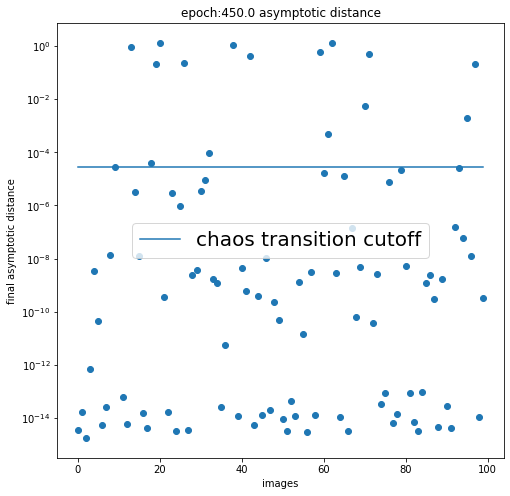

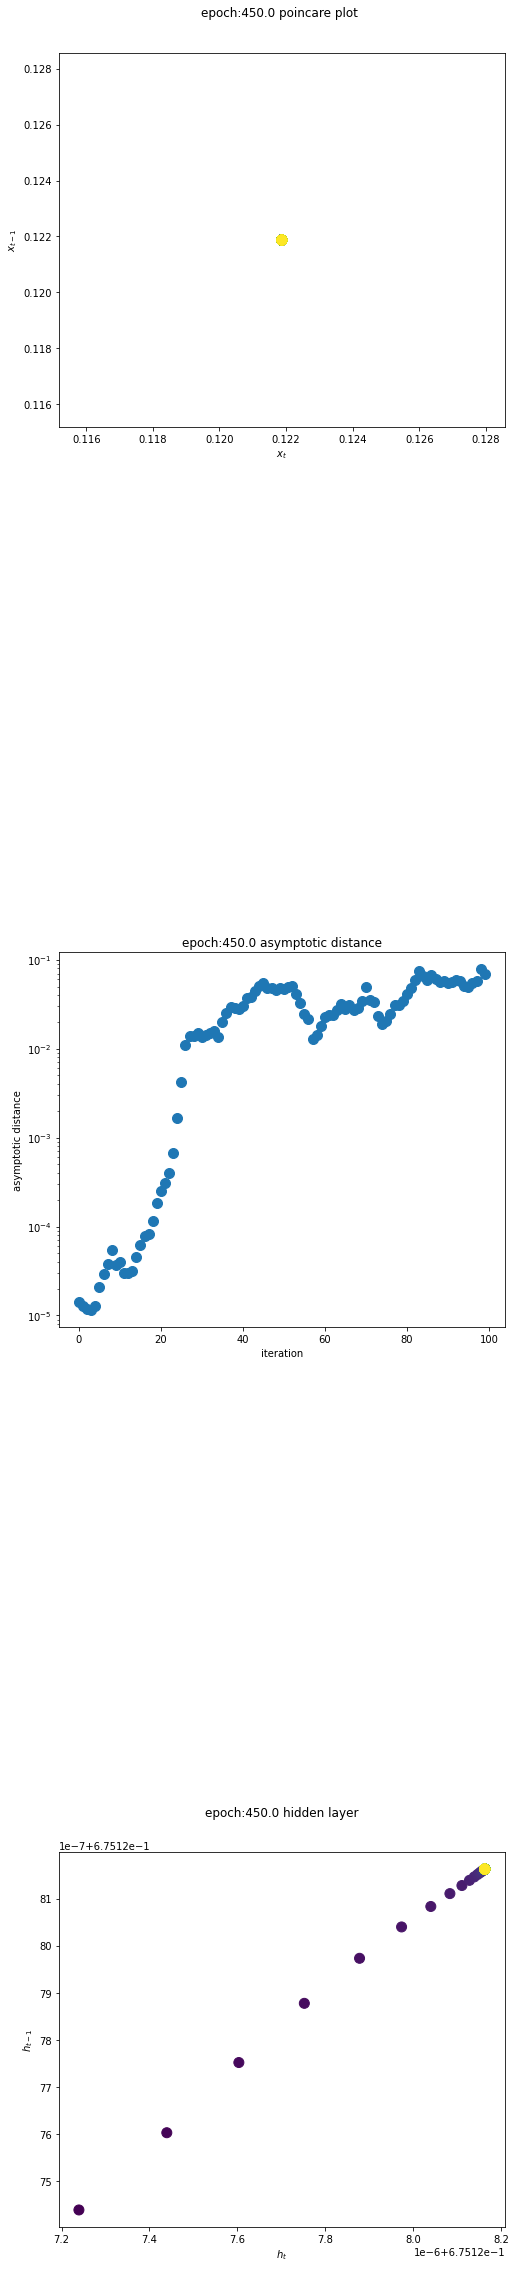

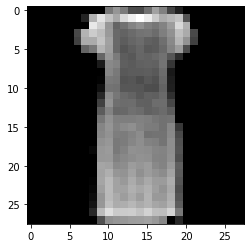

asymptotic image output epoch:450.jpg
epoch : 451/10000, training loss = 0.016465,validation loss = 0.019850
epoch : 452/10000, training loss = 0.016481,validation loss = 0.019774
epoch : 453/10000, training loss = 0.016441,validation loss = 0.019850
epoch : 454/10000, training loss = 0.016522,validation loss = 0.019845
epoch : 455/10000, training loss = 0.016504,validation loss = 0.019803
epoch : 456/10000, training loss = 0.016451,validation loss = 0.019846
epoch : 457/10000, training loss = 0.016448,validation loss = 0.019703
epoch : 458/10000, training loss = 0.016422,validation loss = 0.019922
epoch : 459/10000, training loss = 0.016490,validation loss = 0.019808
epoch : 460/10000, training loss = 0.016512,validation loss = 0.019759
epoch : 461/10000, training loss = 0.016359,validation loss = 0.019719
epoch : 462/10000, training loss = 0.016368,validation loss = 0.019742
epoch : 463/10000, training loss = 0.016376,validation loss = 0.019820
epoch : 464/10000, training loss = 0.01

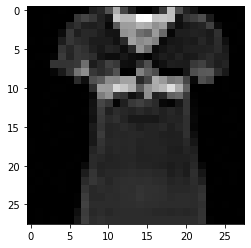

asymptotic image input epoch:500.jpg


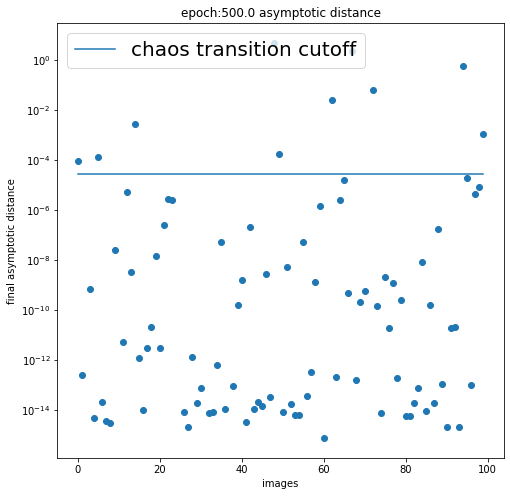

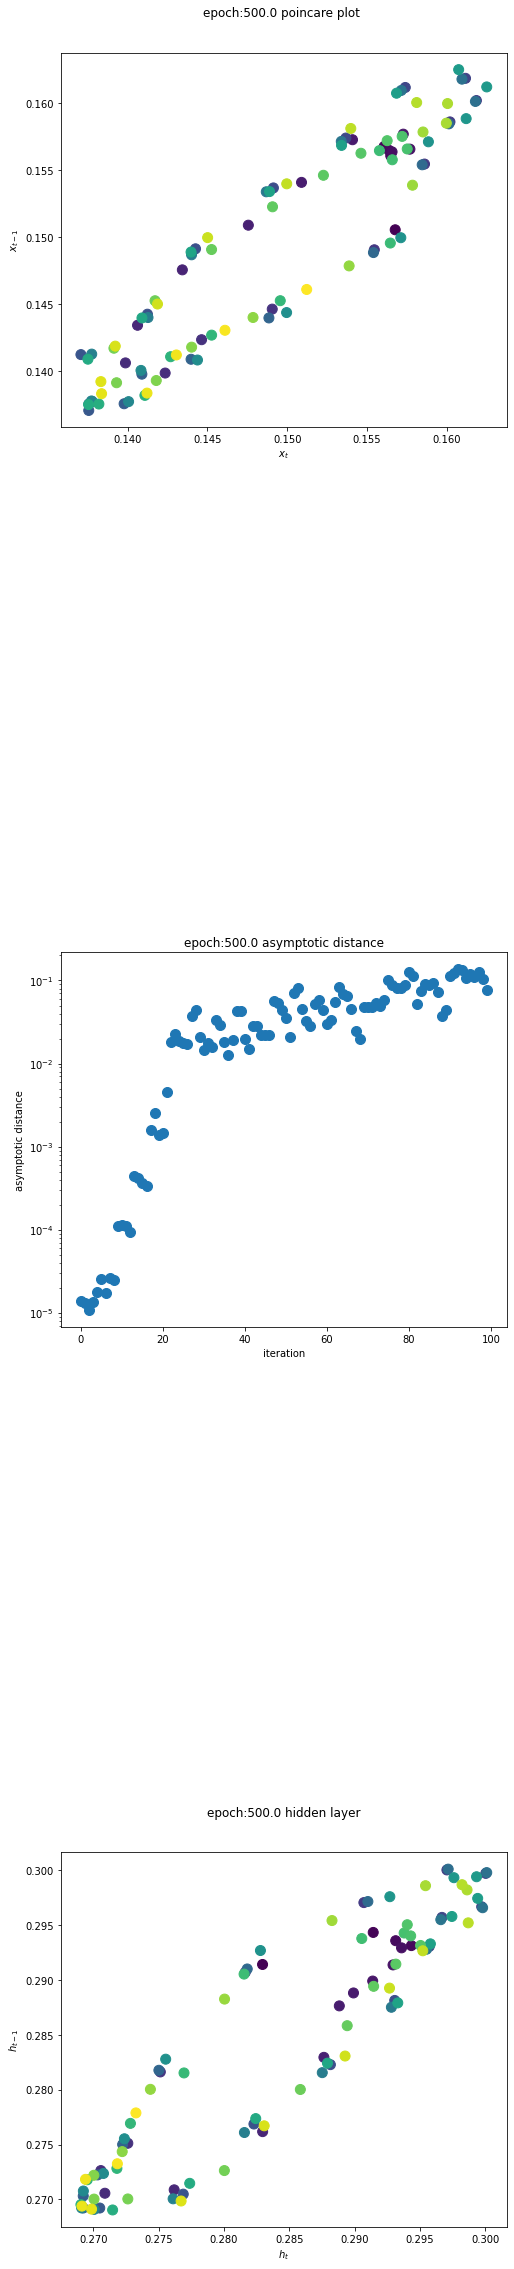

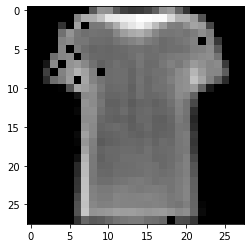

asymptotic image output epoch:500.jpg
epoch : 501/10000, training loss = 0.016378,validation loss = 0.020045
epoch : 502/10000, training loss = 0.016343,validation loss = 0.019923
epoch : 503/10000, training loss = 0.016423,validation loss = 0.020015
epoch : 504/10000, training loss = 0.016362,validation loss = 0.019868
epoch : 505/10000, training loss = 0.016439,validation loss = 0.019846
epoch : 506/10000, training loss = 0.016365,validation loss = 0.019983
epoch : 507/10000, training loss = 0.016348,validation loss = 0.019862
epoch : 508/10000, training loss = 0.016334,validation loss = 0.019945
epoch : 509/10000, training loss = 0.016449,validation loss = 0.019899
epoch : 510/10000, training loss = 0.016373,validation loss = 0.019945
epoch : 511/10000, training loss = 0.016431,validation loss = 0.020050
epoch : 512/10000, training loss = 0.016498,validation loss = 0.019855
epoch : 513/10000, training loss = 0.016378,validation loss = 0.019907
epoch : 514/10000, training loss = 0.01

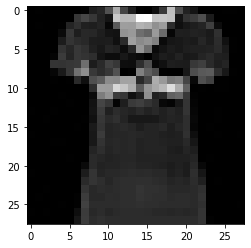

asymptotic image input epoch:550.jpg


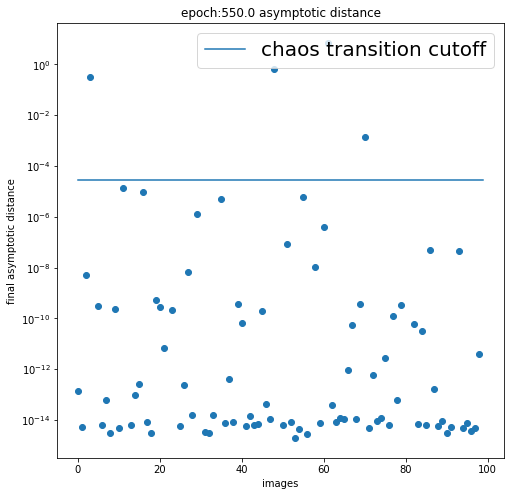

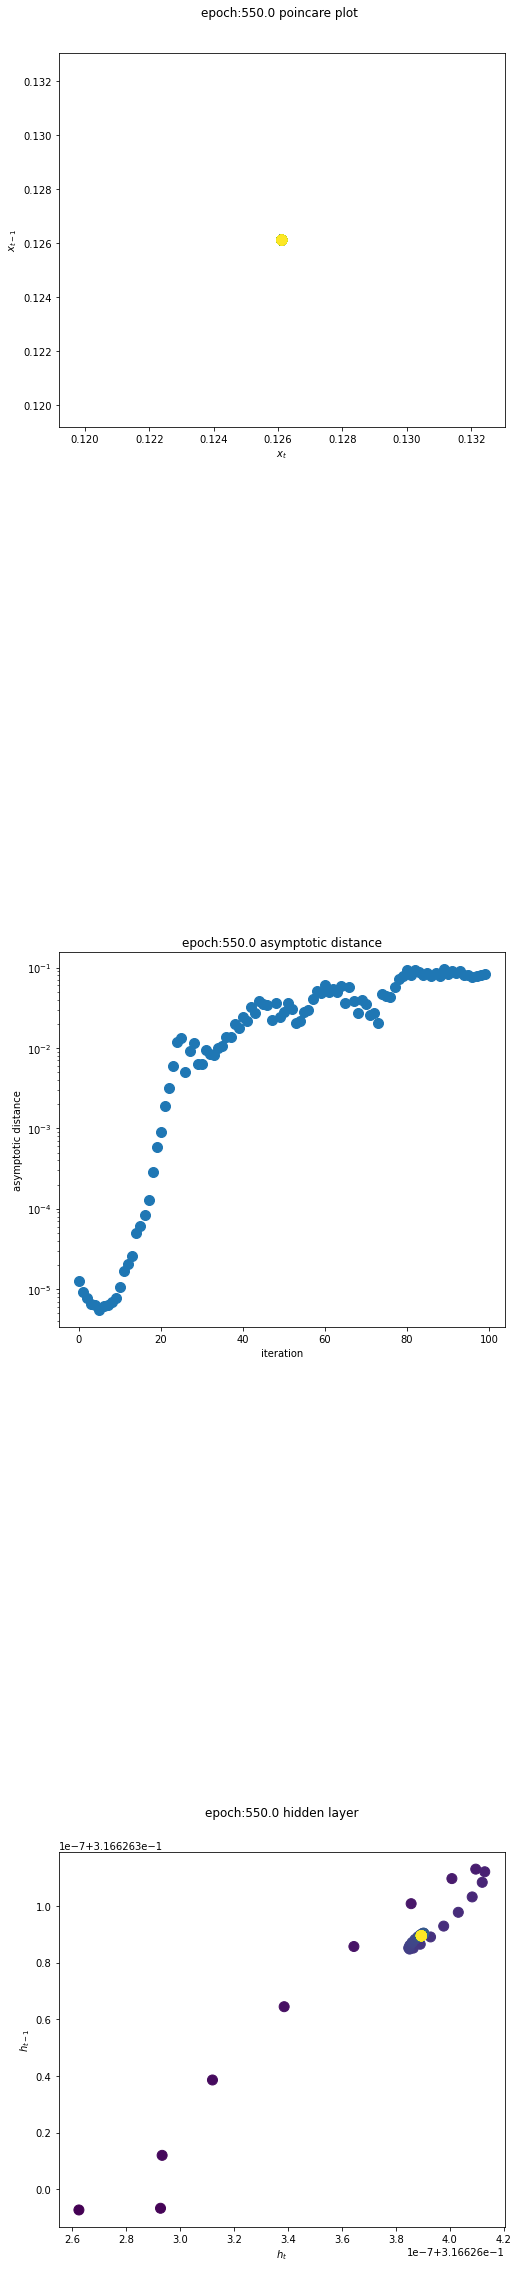

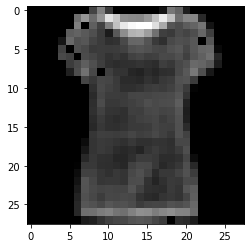

asymptotic image output epoch:550.jpg
epoch : 551/10000, training loss = 0.016315,validation loss = 0.019813
epoch : 552/10000, training loss = 0.016318,validation loss = 0.019906
epoch : 553/10000, training loss = 0.016392,validation loss = 0.019901
epoch : 554/10000, training loss = 0.016386,validation loss = 0.019950
epoch : 555/10000, training loss = 0.016447,validation loss = 0.019835
epoch : 556/10000, training loss = 0.016374,validation loss = 0.019920
epoch : 557/10000, training loss = 0.016314,validation loss = 0.020019
epoch : 558/10000, training loss = 0.016521,validation loss = 0.020047
epoch : 559/10000, training loss = 0.016378,validation loss = 0.019996
epoch : 560/10000, training loss = 0.016369,validation loss = 0.019883
epoch : 561/10000, training loss = 0.016385,validation loss = 0.020028
epoch : 562/10000, training loss = 0.016377,validation loss = 0.020019
epoch : 563/10000, training loss = 0.016447,validation loss = 0.020098
epoch : 564/10000, training loss = 0.01

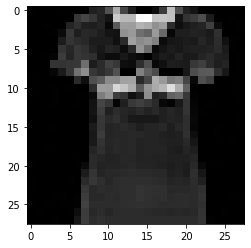

asymptotic image input epoch:600.jpg


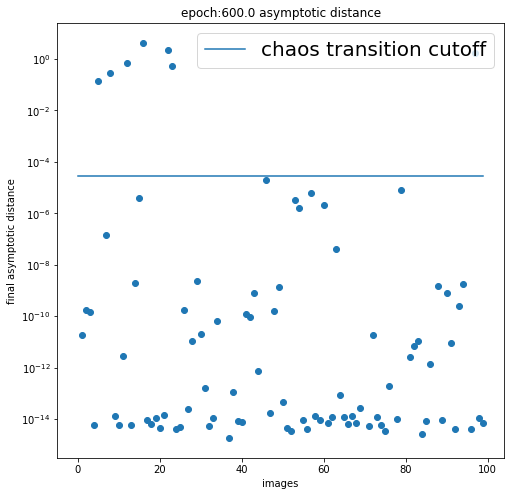

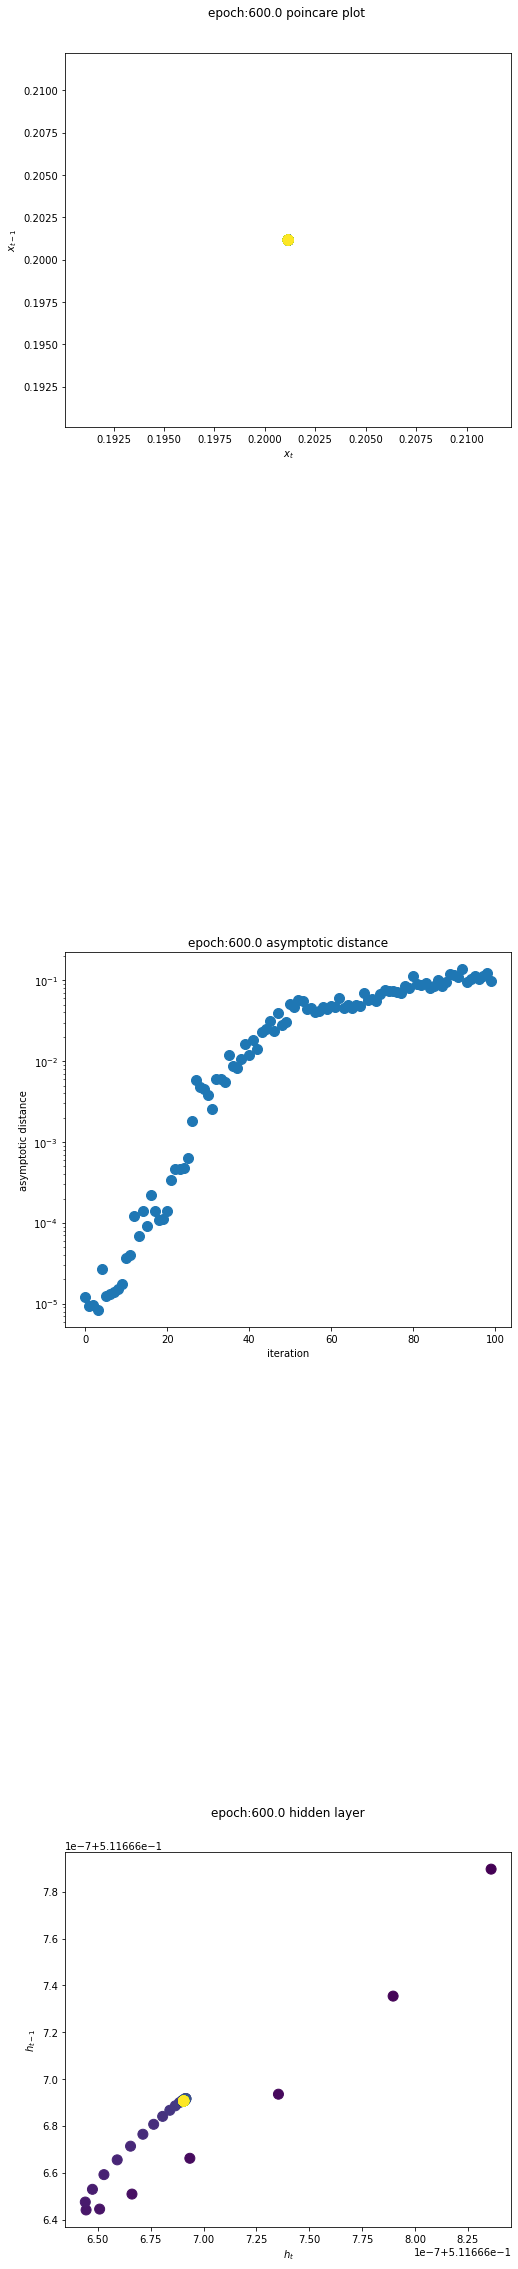

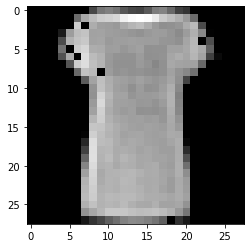

asymptotic image output epoch:600.jpg
epoch : 601/10000, training loss = 0.016362,validation loss = 0.020018
epoch : 602/10000, training loss = 0.016431,validation loss = 0.020041
epoch : 603/10000, training loss = 0.016294,validation loss = 0.019866
epoch : 604/10000, training loss = 0.016375,validation loss = 0.019859
epoch : 605/10000, training loss = 0.016484,validation loss = 0.019944
epoch : 606/10000, training loss = 0.016290,validation loss = 0.019988
epoch : 607/10000, training loss = 0.016274,validation loss = 0.020034
epoch : 608/10000, training loss = 0.016352,validation loss = 0.019965
epoch : 609/10000, training loss = 0.016238,validation loss = 0.019959
epoch : 610/10000, training loss = 0.016268,validation loss = 0.019931
epoch : 611/10000, training loss = 0.016370,validation loss = 0.019995
epoch : 612/10000, training loss = 0.016230,validation loss = 0.019993
epoch : 613/10000, training loss = 0.016381,validation loss = 0.019903
epoch : 614/10000, training loss = 0.01

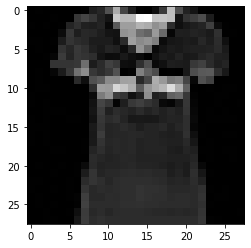

asymptotic image input epoch:650.jpg


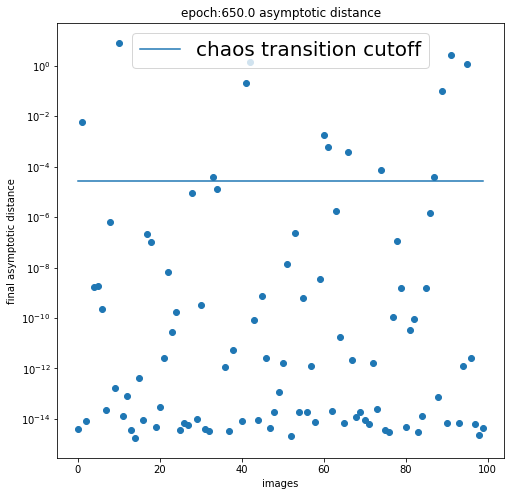

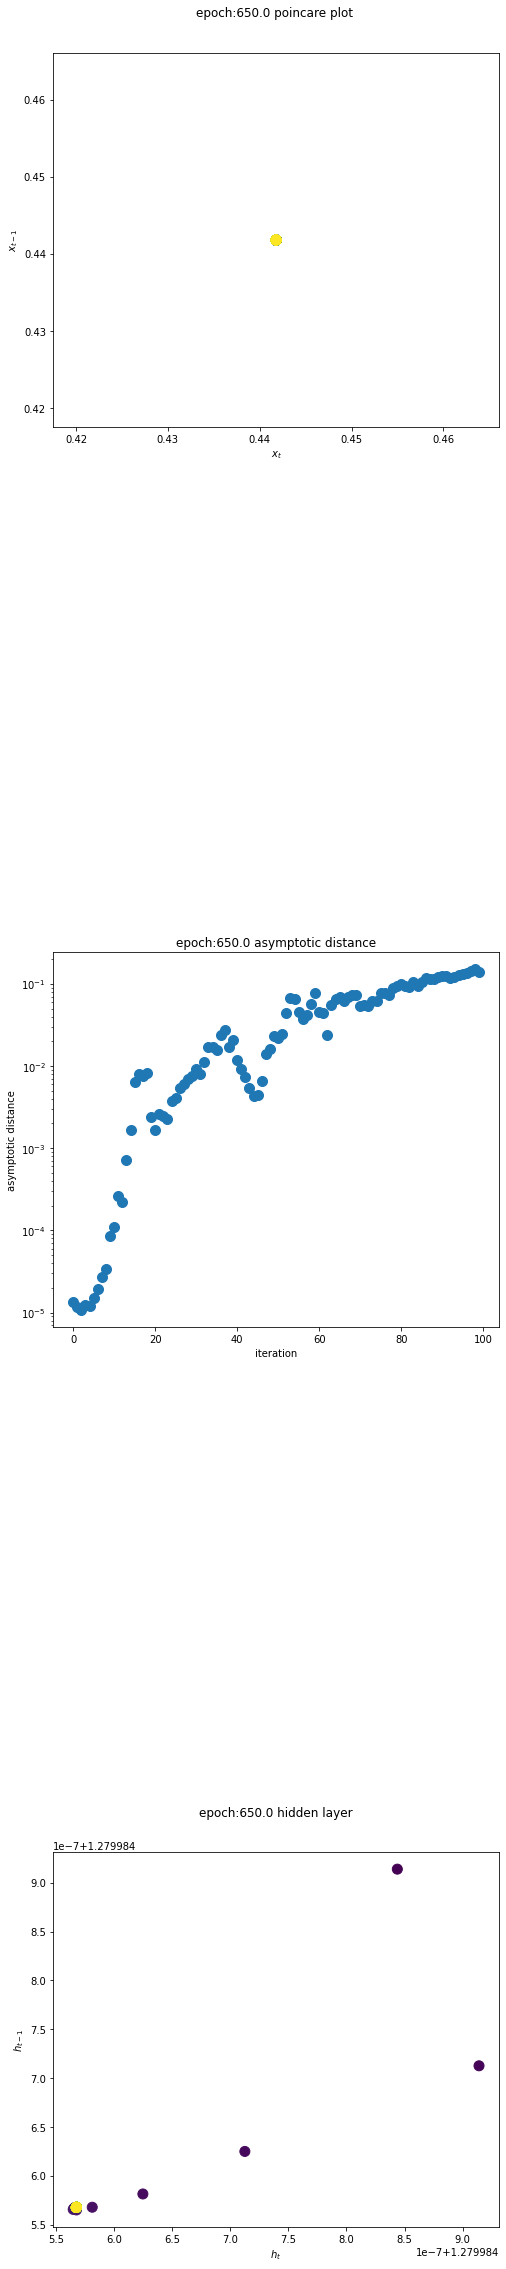

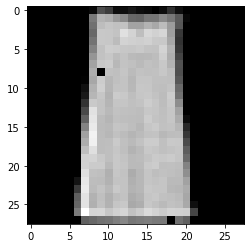

asymptotic image output epoch:650.jpg
epoch : 651/10000, training loss = 0.016317,validation loss = 0.019870
epoch : 652/10000, training loss = 0.016451,validation loss = 0.019915
epoch : 653/10000, training loss = 0.016263,validation loss = 0.019868
epoch : 654/10000, training loss = 0.016316,validation loss = 0.019854
epoch : 655/10000, training loss = 0.016184,validation loss = 0.019809
epoch : 656/10000, training loss = 0.016102,validation loss = 0.019780
epoch : 657/10000, training loss = 0.016060,validation loss = 0.019805
epoch : 658/10000, training loss = 0.016102,validation loss = 0.019702
epoch : 659/10000, training loss = 0.016190,validation loss = 0.019851
epoch : 660/10000, training loss = 0.016270,validation loss = 0.019835
epoch : 661/10000, training loss = 0.016092,validation loss = 0.019774
epoch : 662/10000, training loss = 0.016174,validation loss = 0.019735
epoch : 663/10000, training loss = 0.016166,validation loss = 0.019951
epoch : 664/10000, training loss = 0.01

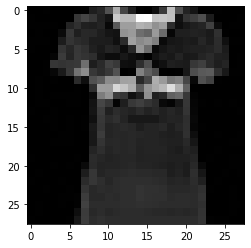

asymptotic image input epoch:700.jpg


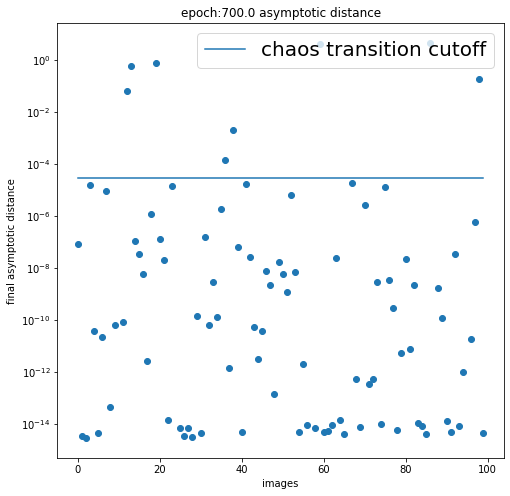

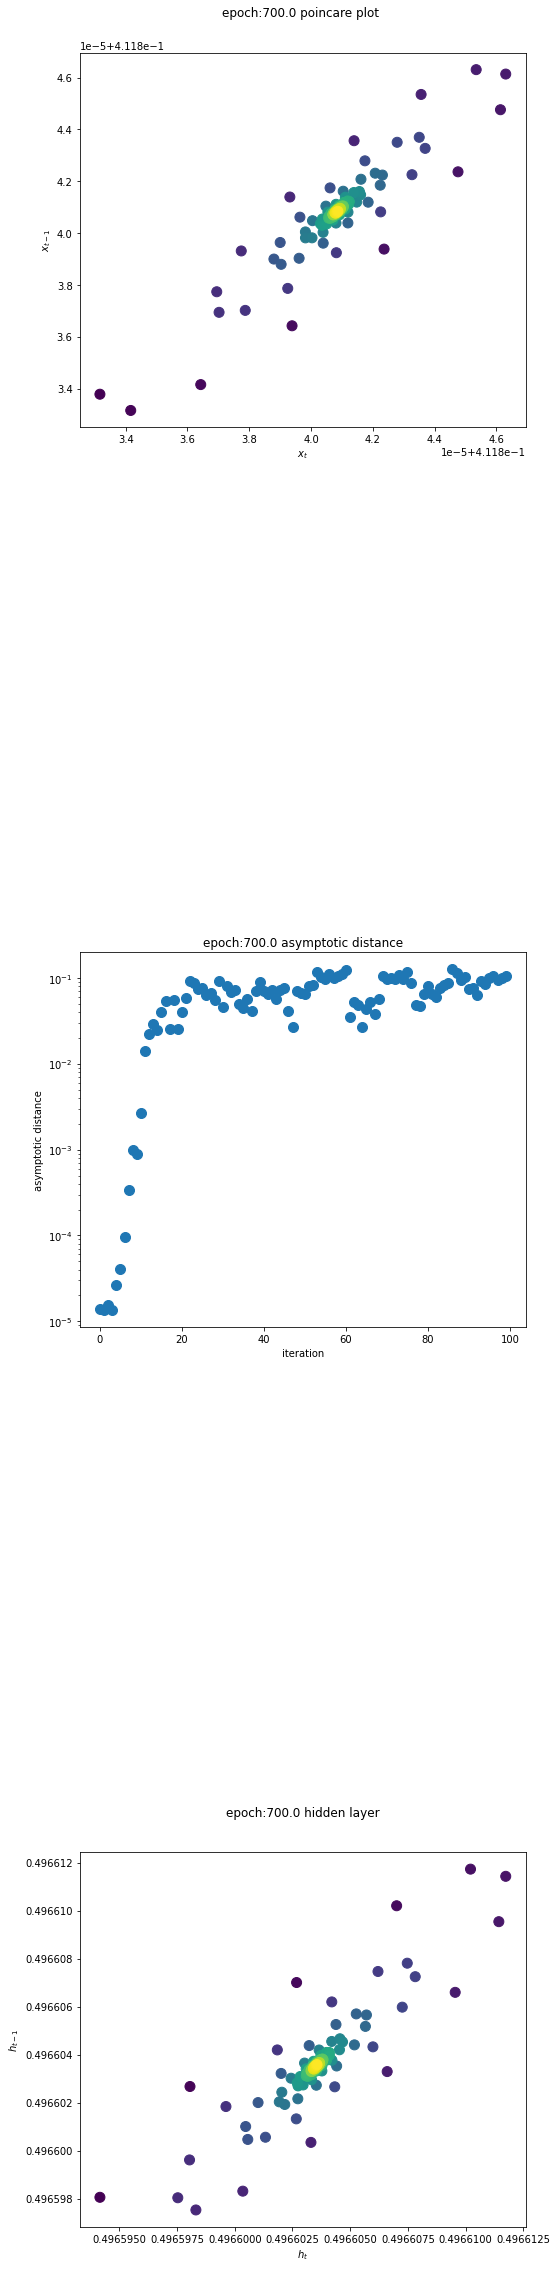

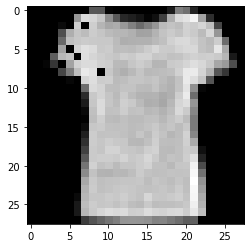

asymptotic image output epoch:700.jpg
epoch : 701/10000, training loss = 0.015997,validation loss = 0.019723
epoch : 702/10000, training loss = 0.015894,validation loss = 0.019539
epoch : 703/10000, training loss = 0.015954,validation loss = 0.019649
epoch : 704/10000, training loss = 0.016027,validation loss = 0.019598
epoch : 705/10000, training loss = 0.015936,validation loss = 0.019626
epoch : 706/10000, training loss = 0.015983,validation loss = 0.019751
epoch : 707/10000, training loss = 0.015950,validation loss = 0.019619
epoch : 708/10000, training loss = 0.015917,validation loss = 0.019532
epoch : 709/10000, training loss = 0.016006,validation loss = 0.019623
epoch : 710/10000, training loss = 0.015947,validation loss = 0.019678
epoch : 711/10000, training loss = 0.015955,validation loss = 0.019646
epoch : 712/10000, training loss = 0.015917,validation loss = 0.019782
epoch : 713/10000, training loss = 0.016027,validation loss = 0.019734
epoch : 714/10000, training loss = 0.01

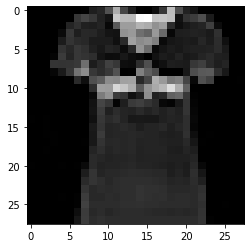

asymptotic image input epoch:750.jpg


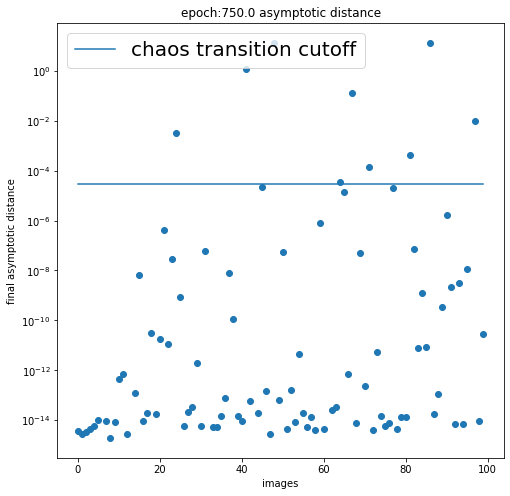

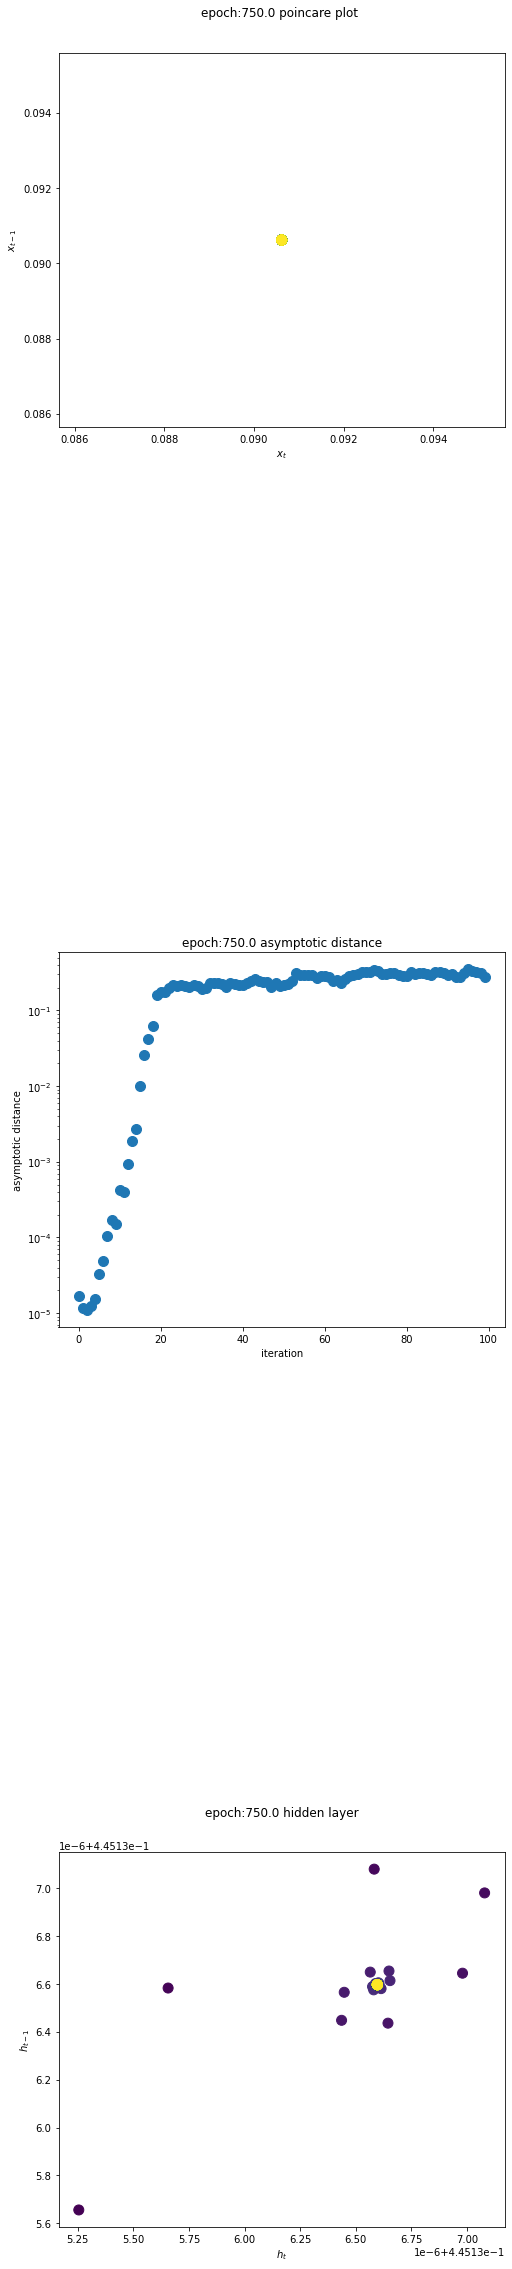

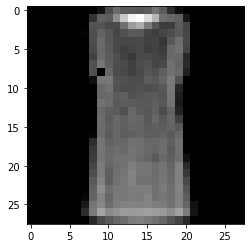

asymptotic image output epoch:750.jpg
epoch : 751/10000, training loss = 0.015950,validation loss = 0.019821
epoch : 752/10000, training loss = 0.015918,validation loss = 0.019654
epoch : 753/10000, training loss = 0.015929,validation loss = 0.019805
epoch : 754/10000, training loss = 0.015893,validation loss = 0.019364
epoch : 755/10000, training loss = 0.015512,validation loss = 0.019337
epoch : 756/10000, training loss = 0.015720,validation loss = 0.019410
epoch : 757/10000, training loss = 0.015594,validation loss = 0.019466
epoch : 758/10000, training loss = 0.015577,validation loss = 0.019563
epoch : 759/10000, training loss = 0.015491,validation loss = 0.019474
epoch : 760/10000, training loss = 0.015531,validation loss = 0.019412
epoch : 761/10000, training loss = 0.015652,validation loss = 0.019474
epoch : 762/10000, training loss = 0.015509,validation loss = 0.019335
epoch : 763/10000, training loss = 0.015668,validation loss = 0.019510
epoch : 764/10000, training loss = 0.01

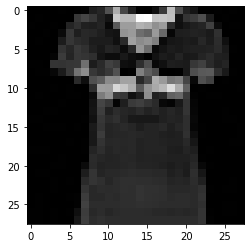

asymptotic image input epoch:800.jpg


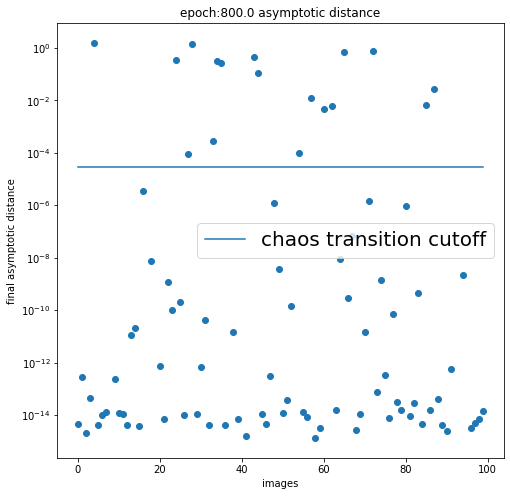

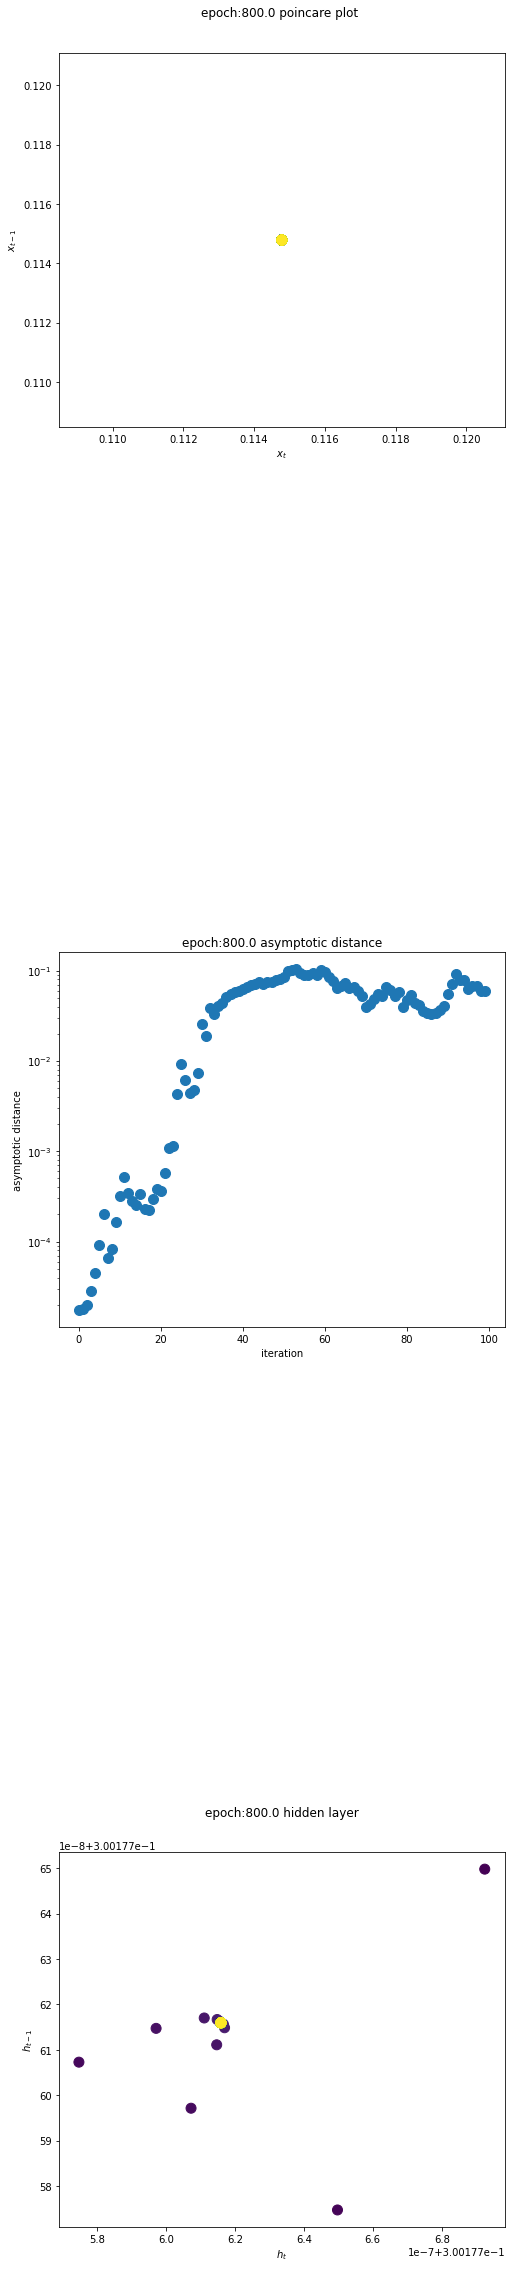

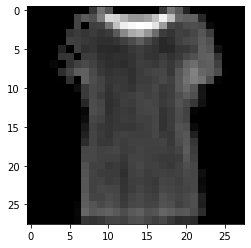

asymptotic image output epoch:800.jpg
epoch : 801/10000, training loss = 0.015645,validation loss = 0.019431
epoch : 802/10000, training loss = 0.015601,validation loss = 0.019464
epoch : 803/10000, training loss = 0.015598,validation loss = 0.019534
epoch : 804/10000, training loss = 0.015522,validation loss = 0.019371
epoch : 805/10000, training loss = 0.015398,validation loss = 0.019443
epoch : 806/10000, training loss = 0.015510,validation loss = 0.019139
epoch : 807/10000, training loss = 0.015412,validation loss = 0.019069
epoch : 808/10000, training loss = 0.015419,validation loss = 0.019202
epoch : 809/10000, training loss = 0.015210,validation loss = 0.019319
epoch : 810/10000, training loss = 0.015253,validation loss = 0.019215
epoch : 811/10000, training loss = 0.015360,validation loss = 0.019287
epoch : 812/10000, training loss = 0.015231,validation loss = 0.019203
epoch : 813/10000, training loss = 0.015338,validation loss = 0.019400
epoch : 814/10000, training loss = 0.01

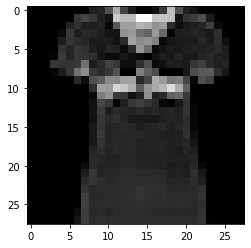

asymptotic image input epoch:850.jpg


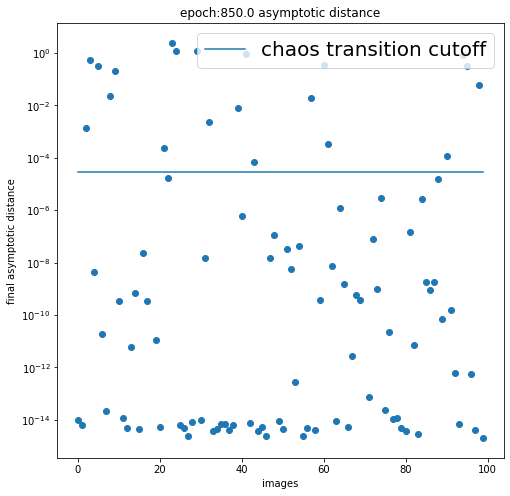

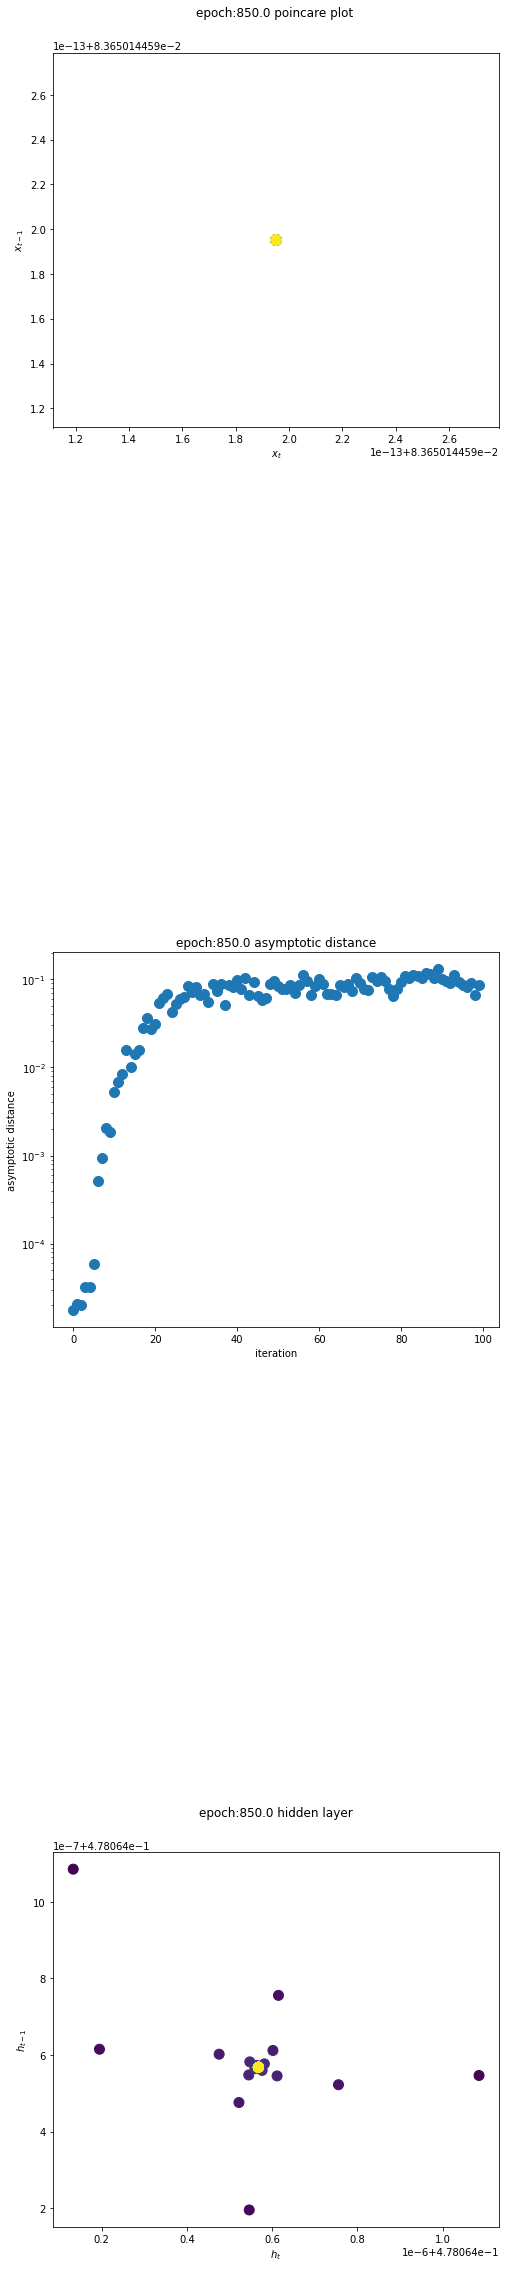

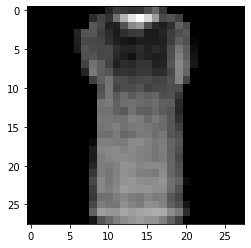

asymptotic image output epoch:850.jpg
epoch : 851/10000, training loss = 0.015292,validation loss = 0.019203
epoch : 852/10000, training loss = 0.015312,validation loss = 0.019269
epoch : 853/10000, training loss = 0.015237,validation loss = 0.019194
epoch : 854/10000, training loss = 0.015145,validation loss = 0.019072
epoch : 855/10000, training loss = 0.015228,validation loss = 0.019215
epoch : 856/10000, training loss = 0.015207,validation loss = 0.019137
epoch : 857/10000, training loss = 0.015177,validation loss = 0.019275
epoch : 858/10000, training loss = 0.015164,validation loss = 0.019181
epoch : 859/10000, training loss = 0.015028,validation loss = 0.019079
epoch : 860/10000, training loss = 0.015278,validation loss = 0.019025
epoch : 861/10000, training loss = 0.015113,validation loss = 0.019045
epoch : 862/10000, training loss = 0.015027,validation loss = 0.019062
epoch : 863/10000, training loss = 0.015307,validation loss = 0.019217
epoch : 864/10000, training loss = 0.01

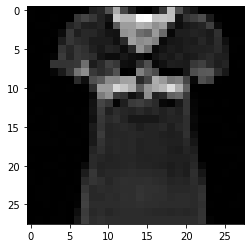

asymptotic image input epoch:900.jpg


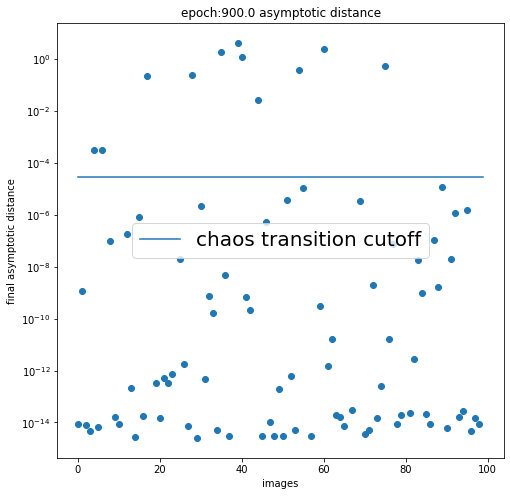

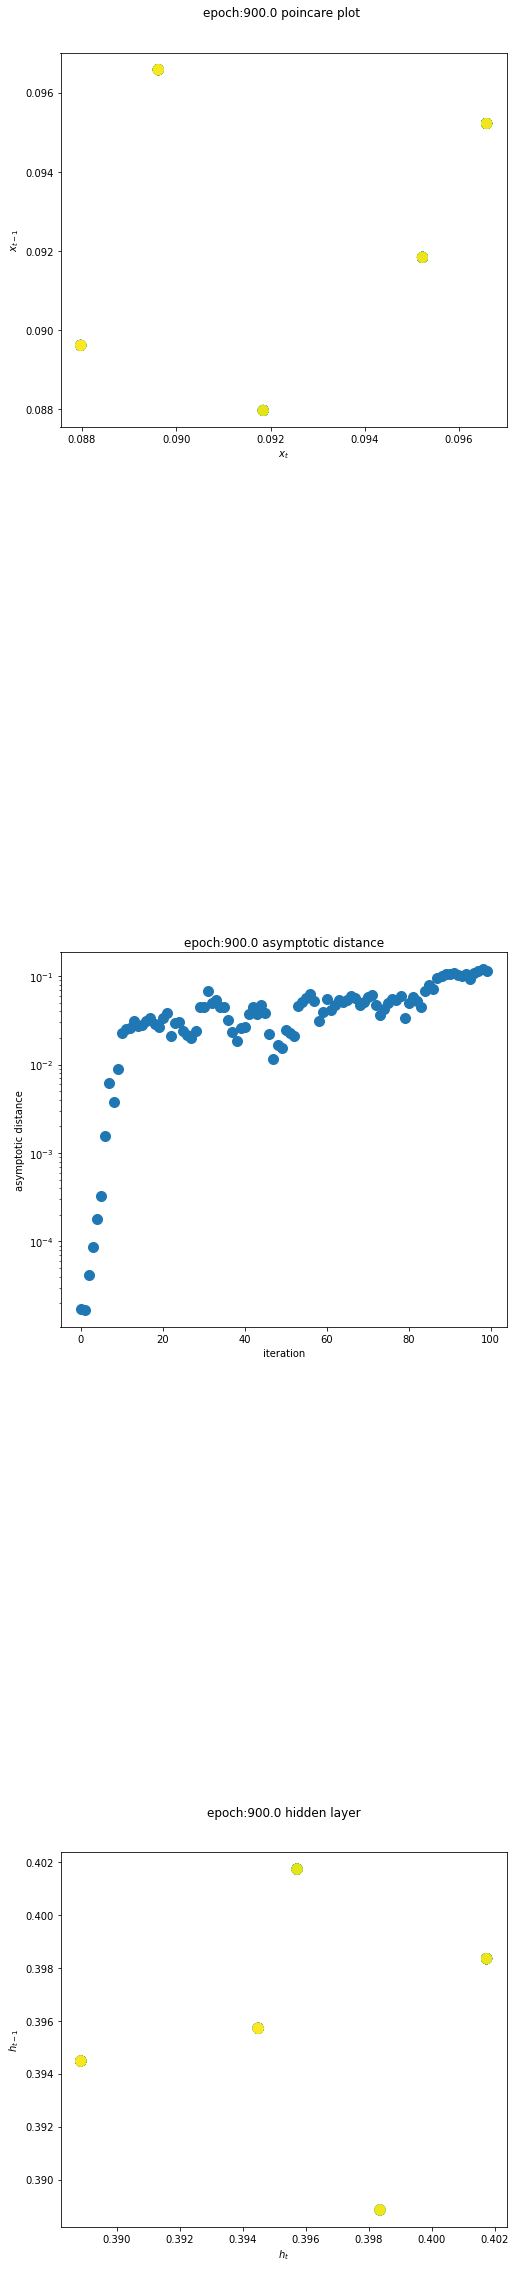

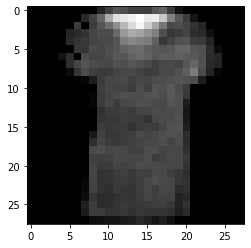

asymptotic image output epoch:900.jpg
epoch : 901/10000, training loss = 0.015065,validation loss = 0.019316
epoch : 902/10000, training loss = 0.015201,validation loss = 0.019155
epoch : 903/10000, training loss = 0.015224,validation loss = 0.019150
epoch : 904/10000, training loss = 0.015081,validation loss = 0.019056
epoch : 905/10000, training loss = 0.015060,validation loss = 0.019066
epoch : 906/10000, training loss = 0.015060,validation loss = 0.019071
epoch : 907/10000, training loss = 0.015090,validation loss = 0.019102
epoch : 908/10000, training loss = 0.015208,validation loss = 0.019124
epoch : 909/10000, training loss = 0.015190,validation loss = 0.019191
epoch : 910/10000, training loss = 0.015146,validation loss = 0.019069
epoch : 911/10000, training loss = 0.015236,validation loss = 0.019108
epoch : 912/10000, training loss = 0.015053,validation loss = 0.019172
epoch : 913/10000, training loss = 0.015032,validation loss = 0.019206
epoch : 914/10000, training loss = 0.01

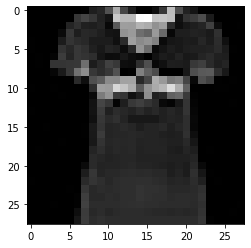

asymptotic image input epoch:950.jpg


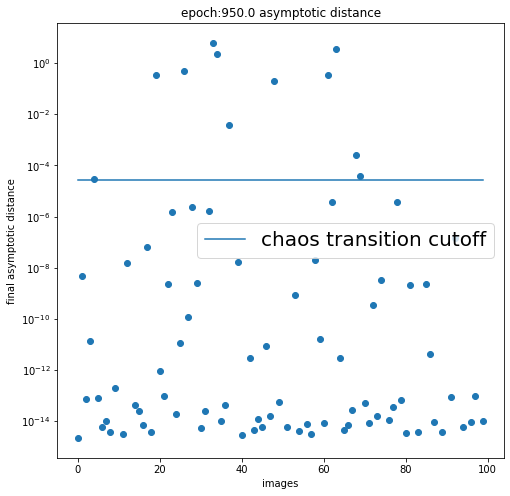

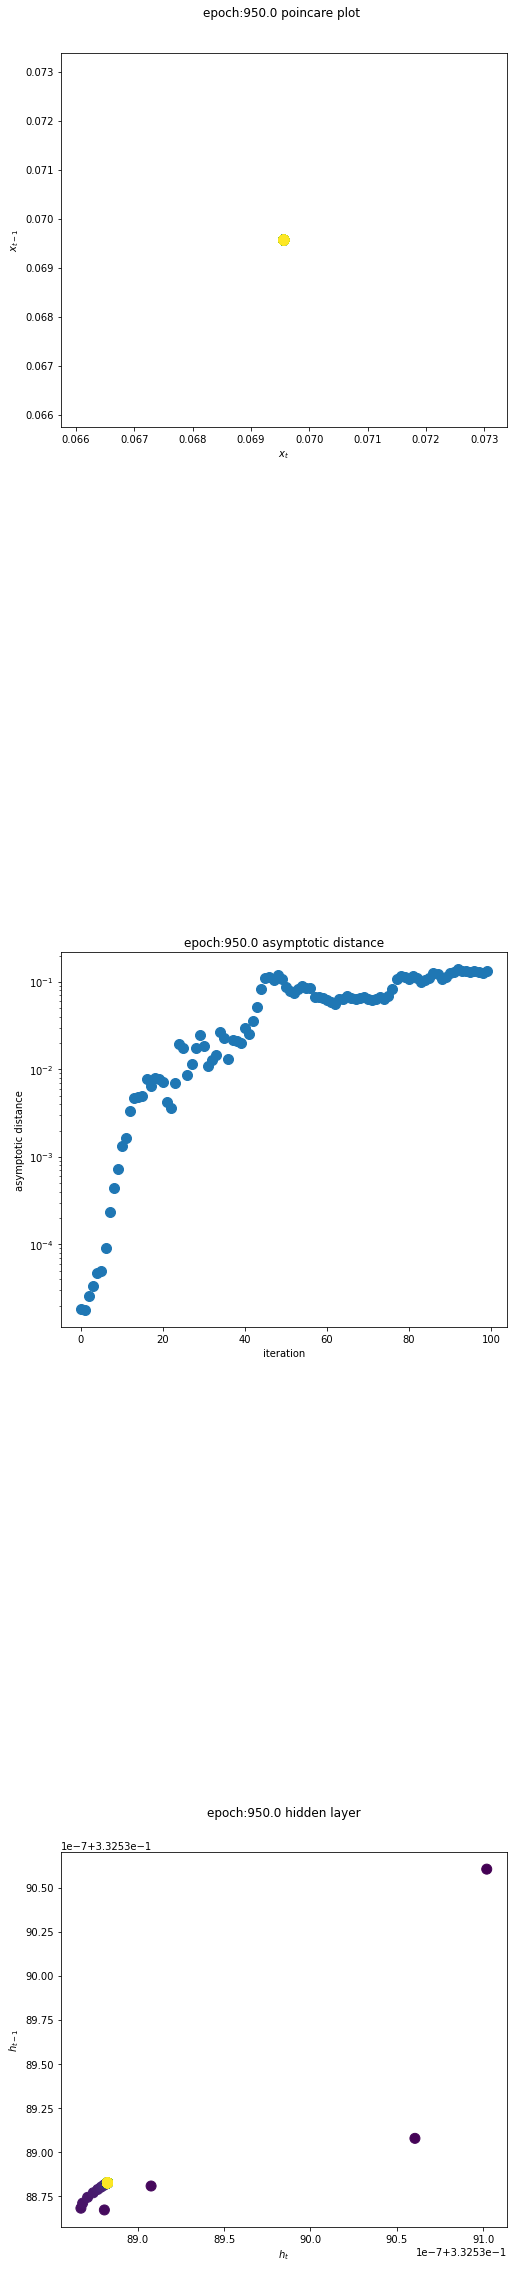

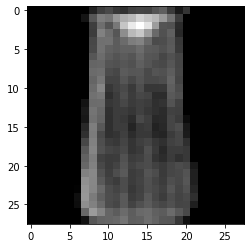

asymptotic image output epoch:950.jpg
epoch : 951/10000, training loss = 0.015088,validation loss = 0.019162
epoch : 952/10000, training loss = 0.015052,validation loss = 0.019060
epoch : 953/10000, training loss = 0.015031,validation loss = 0.019039
epoch : 954/10000, training loss = 0.015022,validation loss = 0.019168
epoch : 955/10000, training loss = 0.015063,validation loss = 0.019083
epoch : 956/10000, training loss = 0.015168,validation loss = 0.019146
epoch : 957/10000, training loss = 0.015145,validation loss = 0.019055
epoch : 958/10000, training loss = 0.015050,validation loss = 0.019165
epoch : 959/10000, training loss = 0.015011,validation loss = 0.019218
epoch : 960/10000, training loss = 0.015086,validation loss = 0.019119
epoch : 961/10000, training loss = 0.014987,validation loss = 0.019156
epoch : 962/10000, training loss = 0.015073,validation loss = 0.019169
epoch : 963/10000, training loss = 0.015098,validation loss = 0.019157
epoch : 964/10000, training loss = 0.01

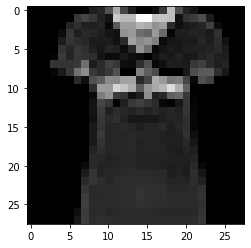

asymptotic image input epoch:1000.jpg


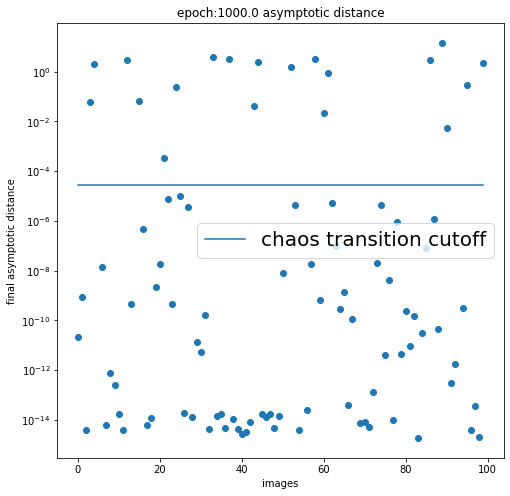

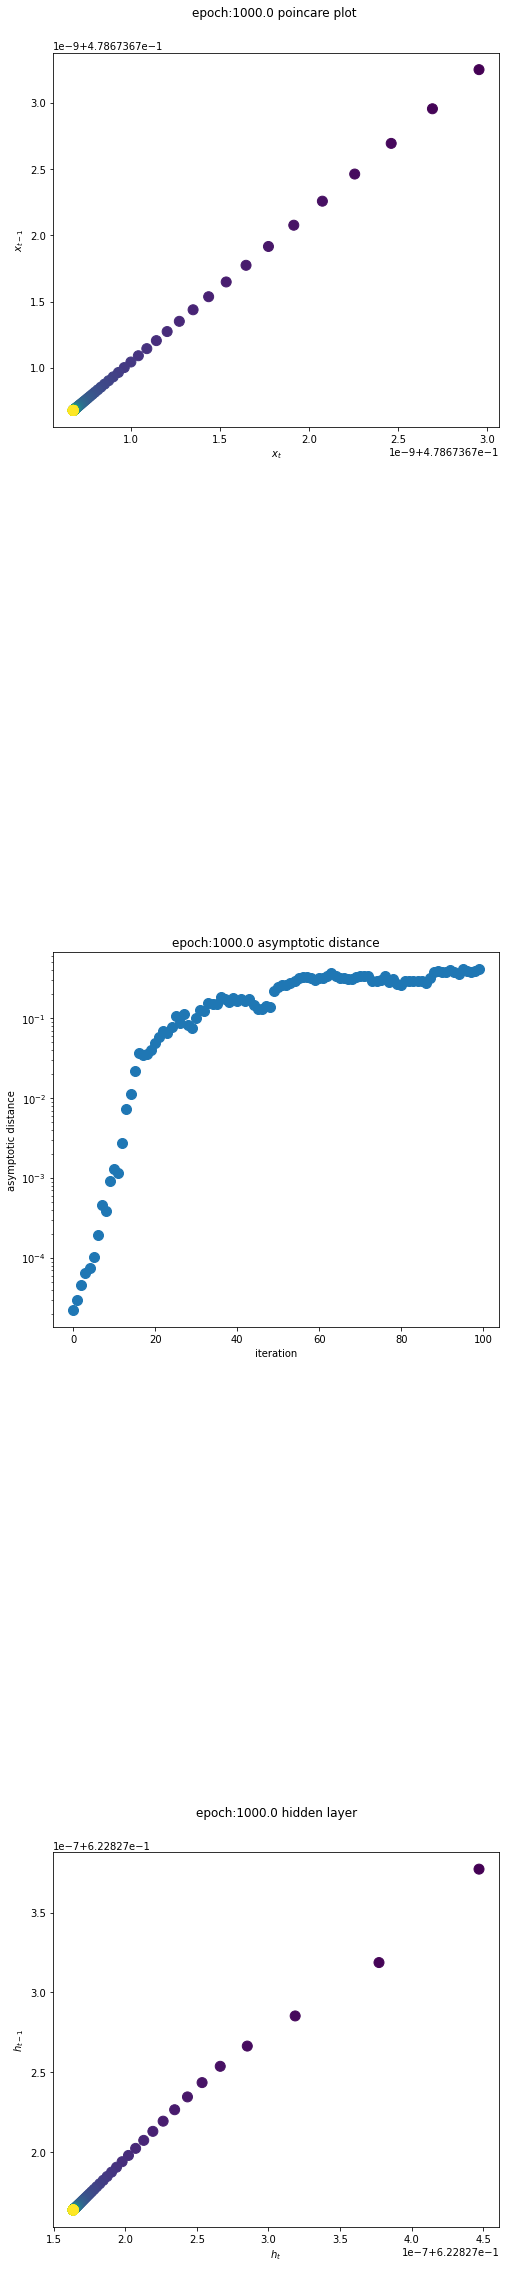

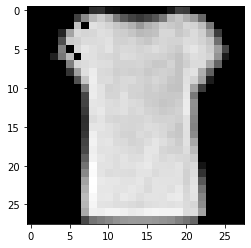

asymptotic image output epoch:1000.jpg
epoch : 1001/10000, training loss = 0.015119,validation loss = 0.019247
epoch : 1002/10000, training loss = 0.015168,validation loss = 0.019275
epoch : 1003/10000, training loss = 0.015059,validation loss = 0.019170
epoch : 1004/10000, training loss = 0.015123,validation loss = 0.019120
epoch : 1005/10000, training loss = 0.015080,validation loss = 0.019184
epoch : 1006/10000, training loss = 0.015143,validation loss = 0.019145
epoch : 1007/10000, training loss = 0.015025,validation loss = 0.019280
epoch : 1008/10000, training loss = 0.015101,validation loss = 0.019174
epoch : 1009/10000, training loss = 0.015085,validation loss = 0.019199
epoch : 1010/10000, training loss = 0.015162,validation loss = 0.019118
epoch : 1011/10000, training loss = 0.015102,validation loss = 0.019155
epoch : 1012/10000, training loss = 0.015059,validation loss = 0.019214
epoch : 1013/10000, training loss = 0.015048,validation loss = 0.019255
epoch : 1014/10000, train

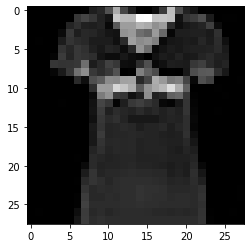

asymptotic image input epoch:1050.jpg


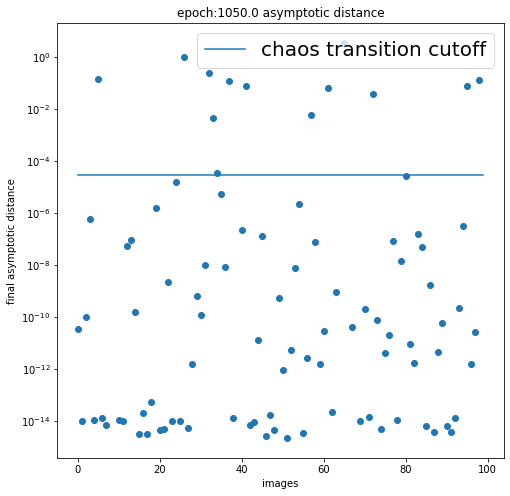

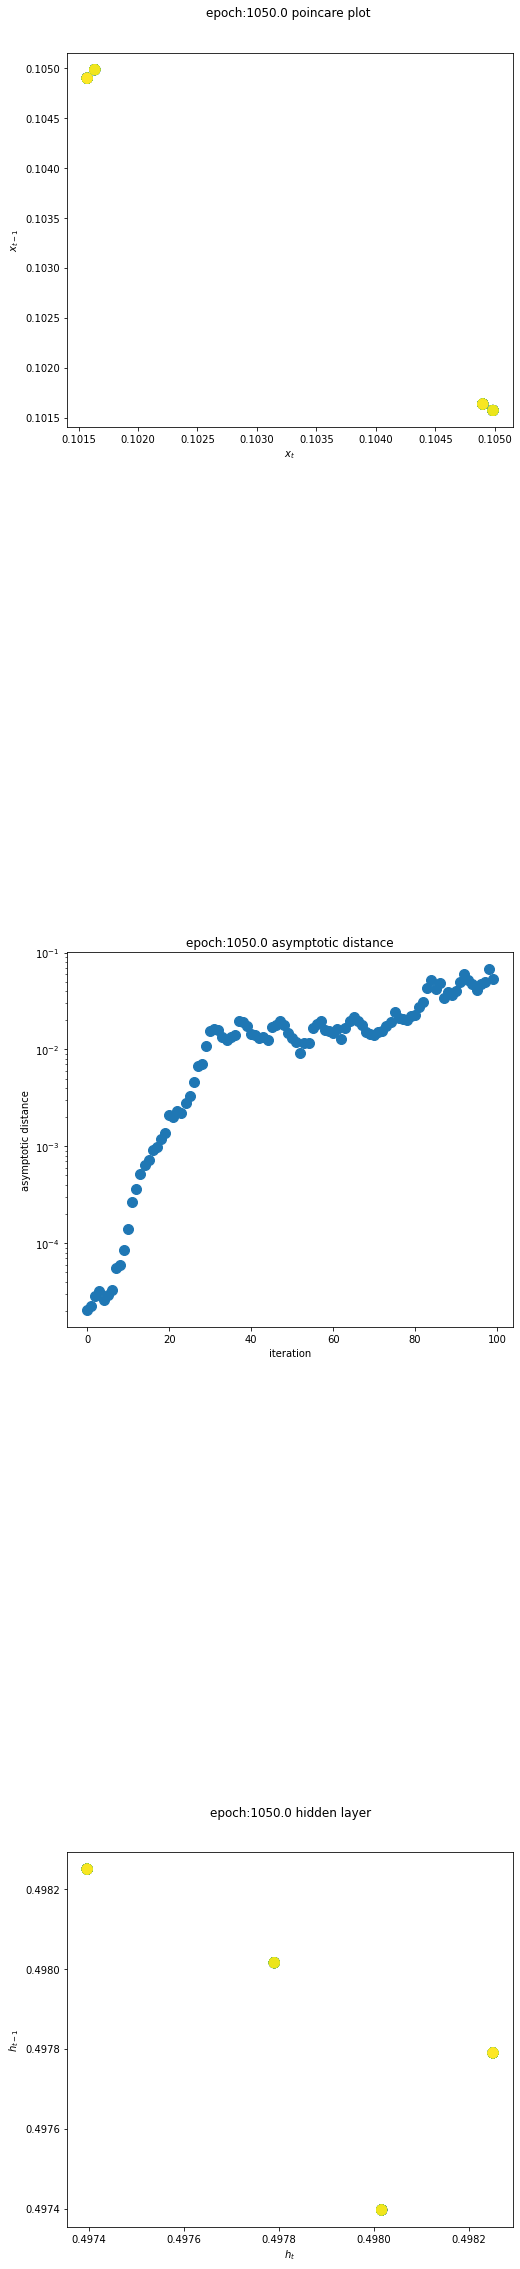

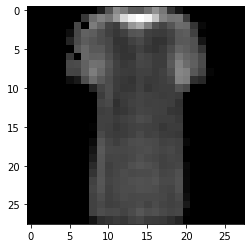

asymptotic image output epoch:1050.jpg
epoch : 1051/10000, training loss = 0.014942,validation loss = 0.019152
epoch : 1052/10000, training loss = 0.015024,validation loss = 0.019218
epoch : 1053/10000, training loss = 0.015351,validation loss = 0.019150
epoch : 1054/10000, training loss = 0.014938,validation loss = 0.019109
epoch : 1055/10000, training loss = 0.015154,validation loss = 0.019278
epoch : 1056/10000, training loss = 0.015004,validation loss = 0.019092
epoch : 1057/10000, training loss = 0.014892,validation loss = 0.019120
epoch : 1058/10000, training loss = 0.015163,validation loss = 0.019197
epoch : 1059/10000, training loss = 0.014998,validation loss = 0.019105
epoch : 1060/10000, training loss = 0.015192,validation loss = 0.019078
epoch : 1061/10000, training loss = 0.015046,validation loss = 0.019175
epoch : 1062/10000, training loss = 0.014893,validation loss = 0.019192
epoch : 1063/10000, training loss = 0.015025,validation loss = 0.019345
epoch : 1064/10000, train

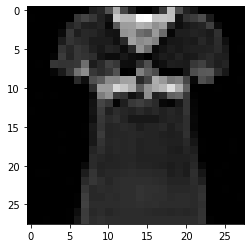

asymptotic image input epoch:1100.jpg


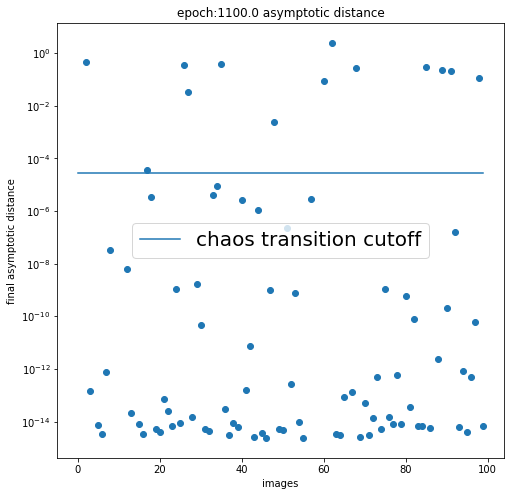

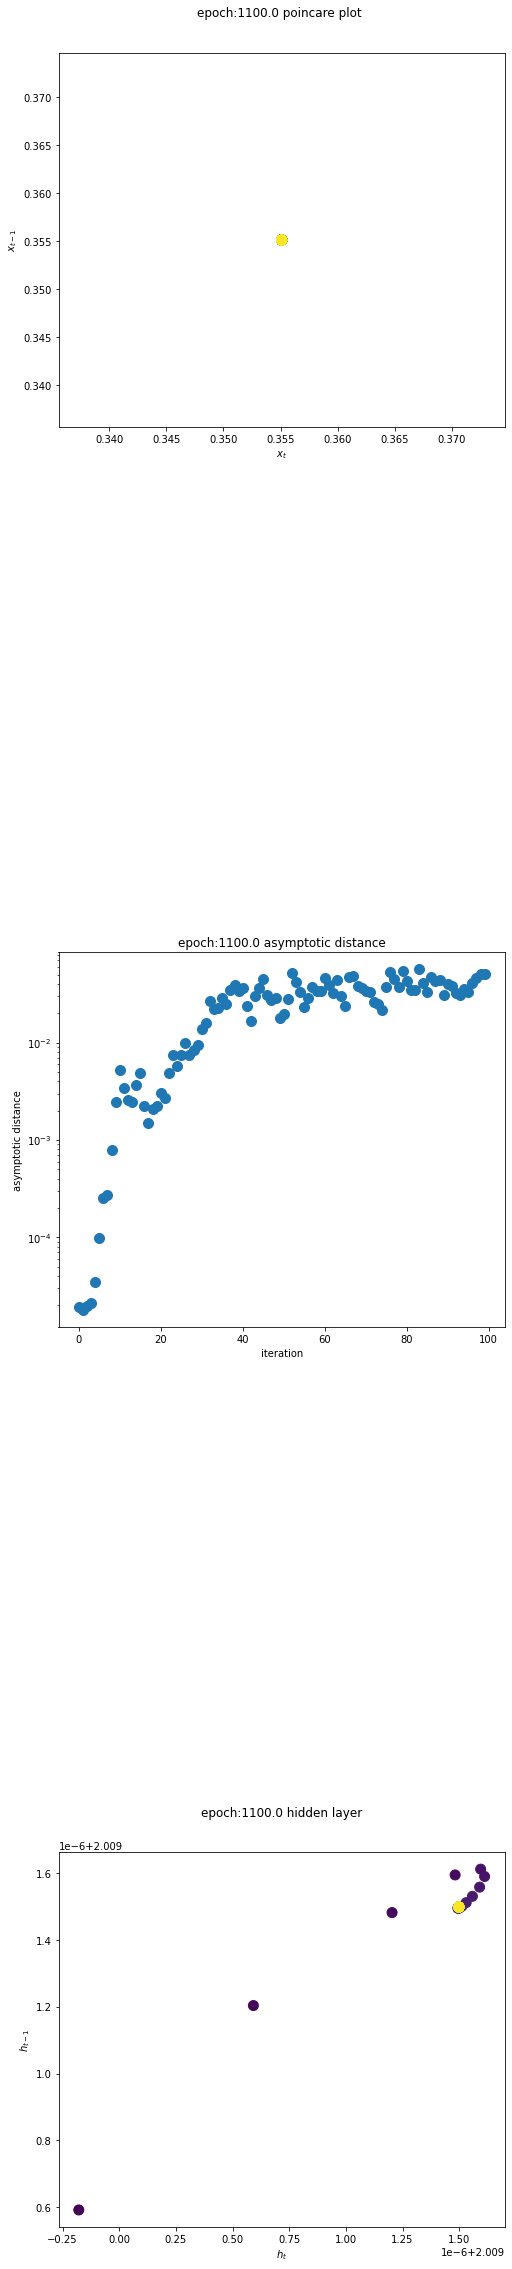

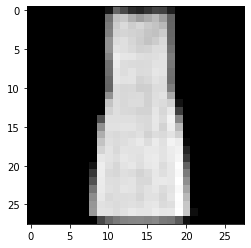

asymptotic image output epoch:1100.jpg
epoch : 1101/10000, training loss = 0.014939,validation loss = 0.019287
epoch : 1102/10000, training loss = 0.014910,validation loss = 0.019094
epoch : 1103/10000, training loss = 0.014870,validation loss = 0.019186
epoch : 1104/10000, training loss = 0.014878,validation loss = 0.019156
epoch : 1105/10000, training loss = 0.014952,validation loss = 0.019219
epoch : 1106/10000, training loss = 0.015269,validation loss = 0.019055
epoch : 1107/10000, training loss = 0.014988,validation loss = 0.019070
epoch : 1108/10000, training loss = 0.014901,validation loss = 0.019046
epoch : 1109/10000, training loss = 0.014994,validation loss = 0.019156
epoch : 1110/10000, training loss = 0.014863,validation loss = 0.019242
epoch : 1111/10000, training loss = 0.014867,validation loss = 0.019157
epoch : 1112/10000, training loss = 0.014949,validation loss = 0.019287
epoch : 1113/10000, training loss = 0.015165,validation loss = 0.019170
epoch : 1114/10000, train

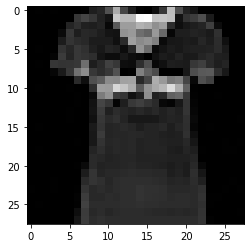

asymptotic image input epoch:1150.jpg


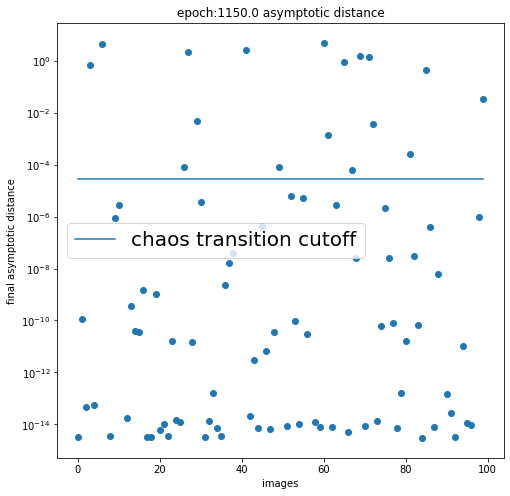

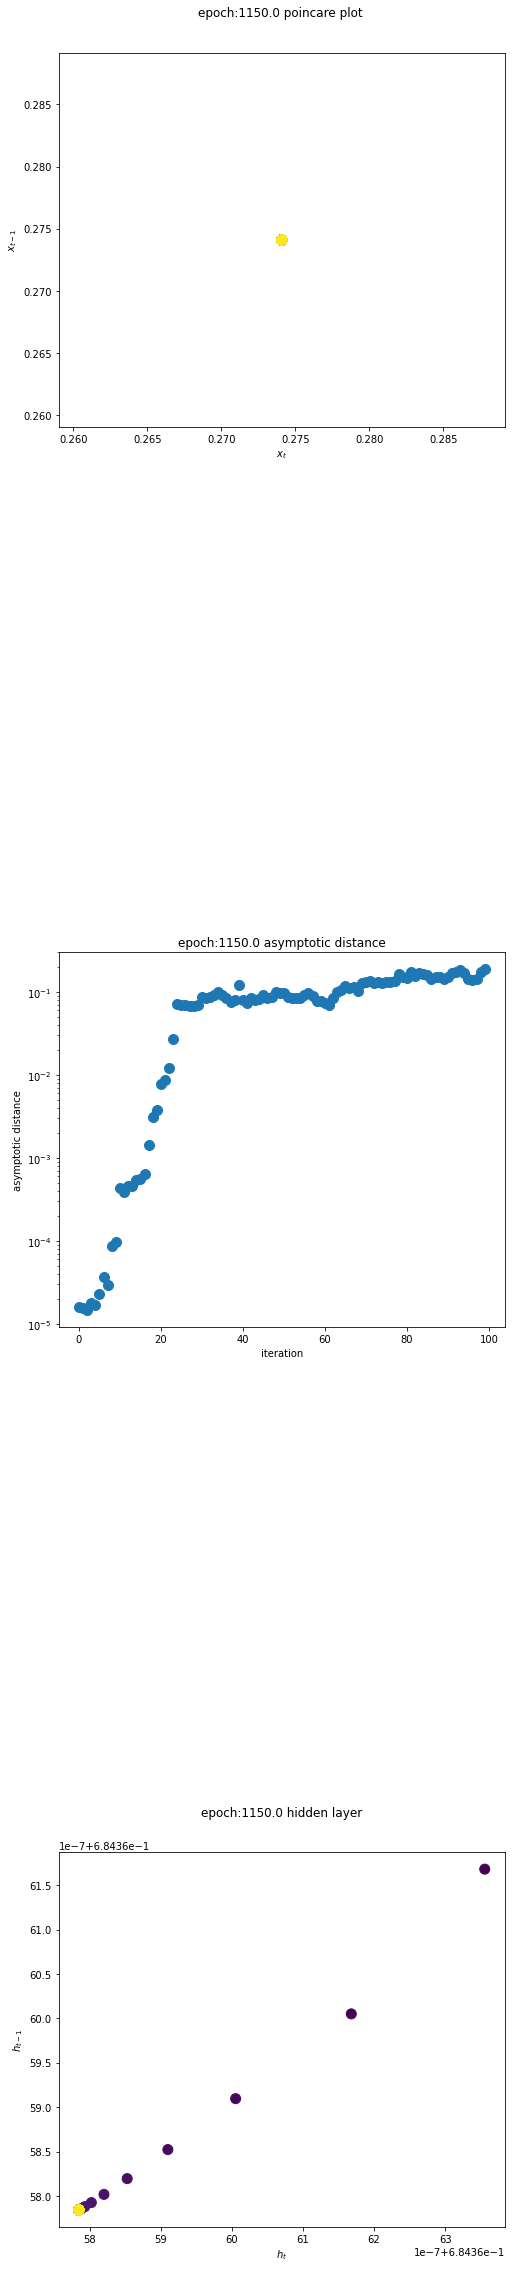

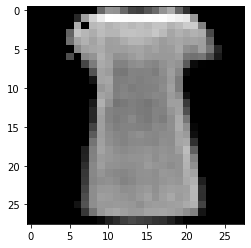

asymptotic image output epoch:1150.jpg
epoch : 1151/10000, training loss = 0.014891,validation loss = 0.019138
epoch : 1152/10000, training loss = 0.014951,validation loss = 0.019102
epoch : 1153/10000, training loss = 0.015114,validation loss = 0.019345
epoch : 1154/10000, training loss = 0.015099,validation loss = 0.019126
epoch : 1155/10000, training loss = 0.015001,validation loss = 0.019273
epoch : 1156/10000, training loss = 0.014987,validation loss = 0.019180
epoch : 1157/10000, training loss = 0.014864,validation loss = 0.019224
epoch : 1158/10000, training loss = 0.014916,validation loss = 0.019227
epoch : 1159/10000, training loss = 0.015135,validation loss = 0.019293
epoch : 1160/10000, training loss = 0.014973,validation loss = 0.019156
epoch : 1161/10000, training loss = 0.014989,validation loss = 0.019105
epoch : 1162/10000, training loss = 0.015011,validation loss = 0.019206
epoch : 1163/10000, training loss = 0.014867,validation loss = 0.019216
epoch : 1164/10000, train

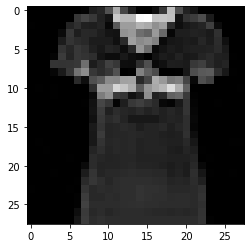

asymptotic image input epoch:1200.jpg


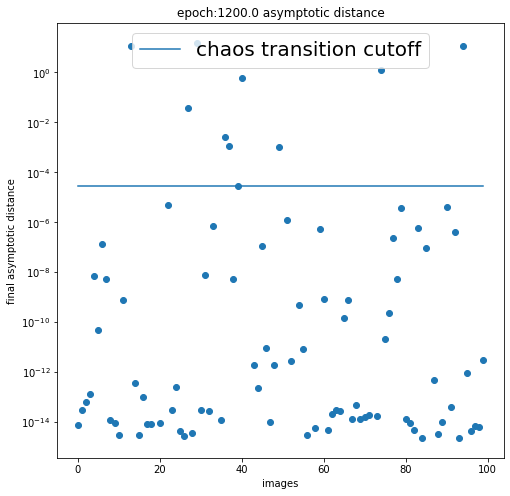

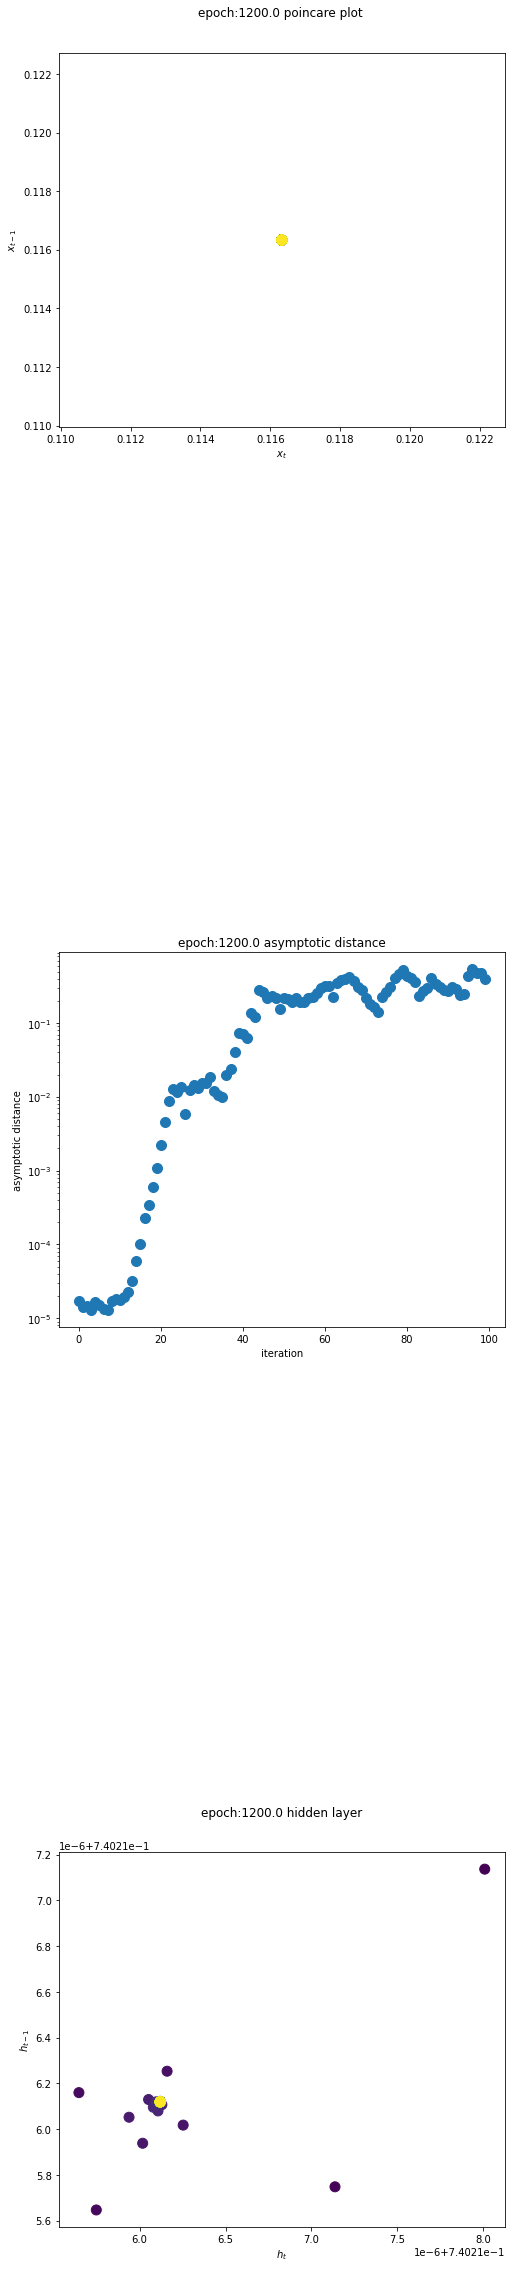

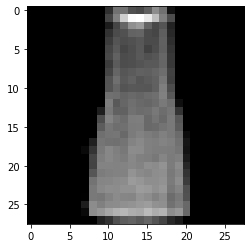

asymptotic image output epoch:1200.jpg
epoch : 1201/10000, training loss = 0.014859,validation loss = 0.019358
epoch : 1202/10000, training loss = 0.014838,validation loss = 0.019190
epoch : 1203/10000, training loss = 0.014916,validation loss = 0.019150
epoch : 1204/10000, training loss = 0.015106,validation loss = 0.019371
epoch : 1205/10000, training loss = 0.015219,validation loss = 0.019364
epoch : 1206/10000, training loss = 0.015208,validation loss = 0.019168
epoch : 1207/10000, training loss = 0.014900,validation loss = 0.019272
epoch : 1208/10000, training loss = 0.014875,validation loss = 0.019296
epoch : 1209/10000, training loss = 0.014901,validation loss = 0.019427
epoch : 1210/10000, training loss = 0.014961,validation loss = 0.019342
epoch : 1211/10000, training loss = 0.014946,validation loss = 0.019291
epoch : 1212/10000, training loss = 0.015170,validation loss = 0.019161
epoch : 1213/10000, training loss = 0.015066,validation loss = 0.019235
epoch : 1214/10000, train

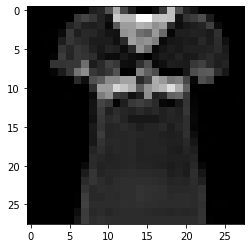

asymptotic image input epoch:1250.jpg


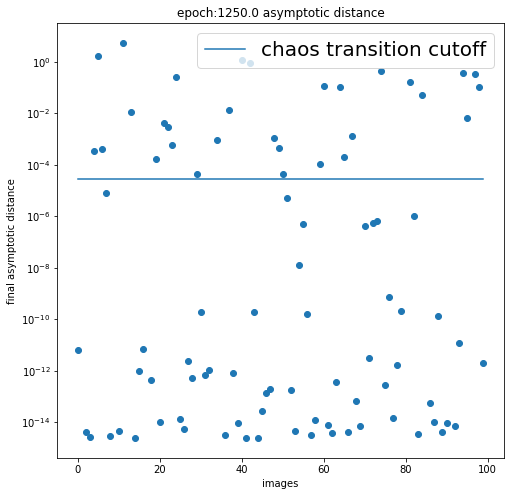

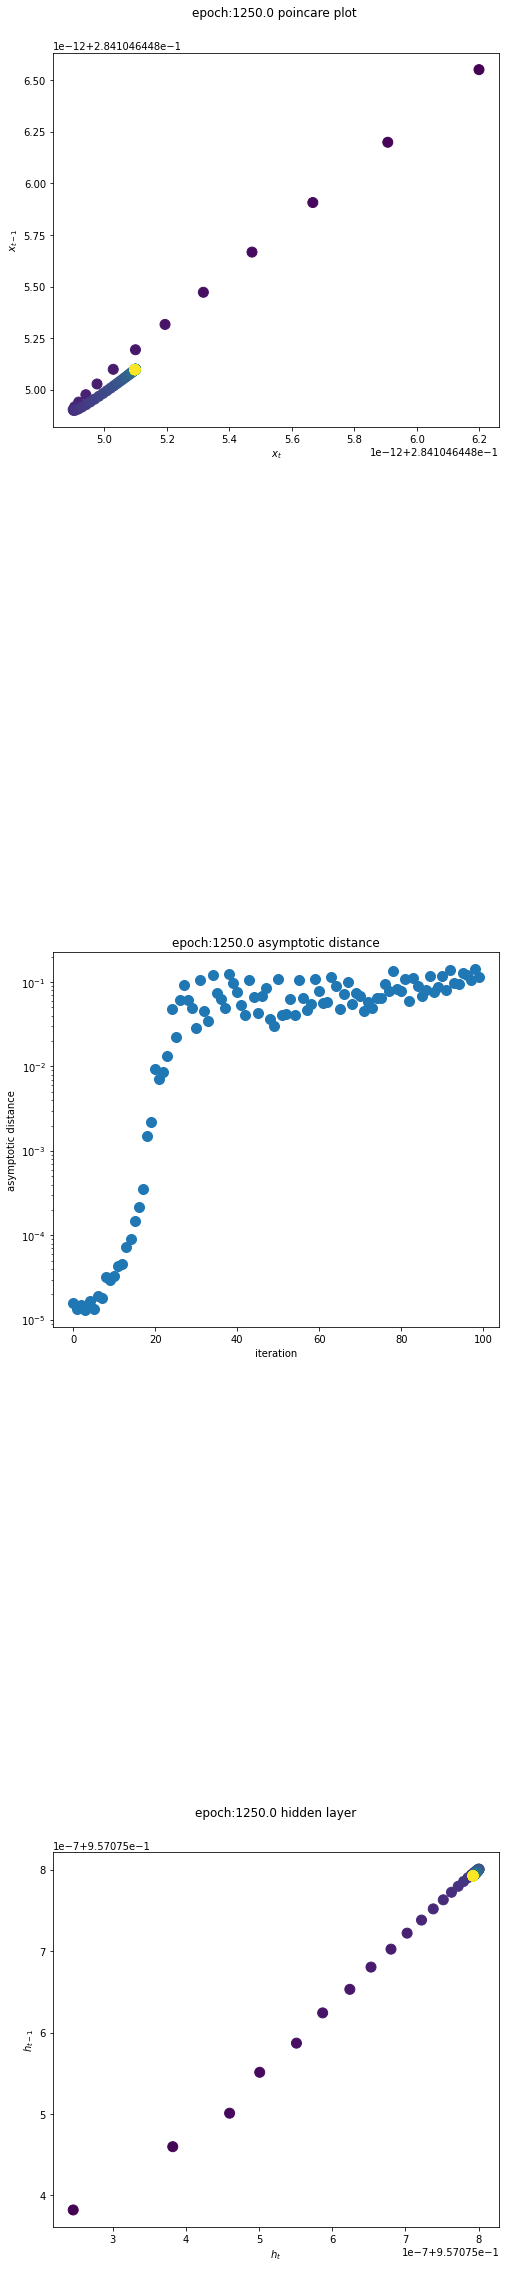

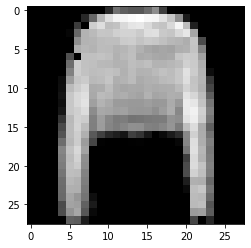

asymptotic image output epoch:1250.jpg
epoch : 1251/10000, training loss = 0.014879,validation loss = 0.019316
epoch : 1252/10000, training loss = 0.014978,validation loss = 0.019221
epoch : 1253/10000, training loss = 0.015665,validation loss = 0.019241
epoch : 1254/10000, training loss = 0.015210,validation loss = 0.019126
epoch : 1255/10000, training loss = 0.015019,validation loss = 0.019132
epoch : 1256/10000, training loss = 0.014813,validation loss = 0.019228
epoch : 1257/10000, training loss = 0.014819,validation loss = 0.019291
epoch : 1258/10000, training loss = 0.015008,validation loss = 0.019241
epoch : 1259/10000, training loss = 0.015065,validation loss = 0.019276
epoch : 1260/10000, training loss = 0.015013,validation loss = 0.019220
epoch : 1261/10000, training loss = 0.014947,validation loss = 0.019344
epoch : 1262/10000, training loss = 0.014828,validation loss = 0.019188
epoch : 1263/10000, training loss = 0.014826,validation loss = 0.019167
epoch : 1264/10000, train

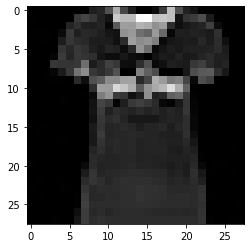

asymptotic image input epoch:1300.jpg


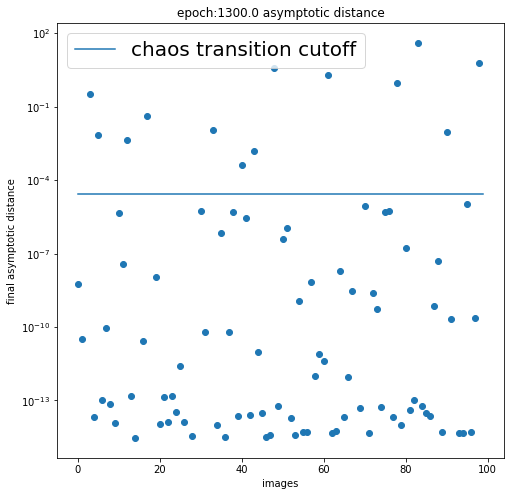

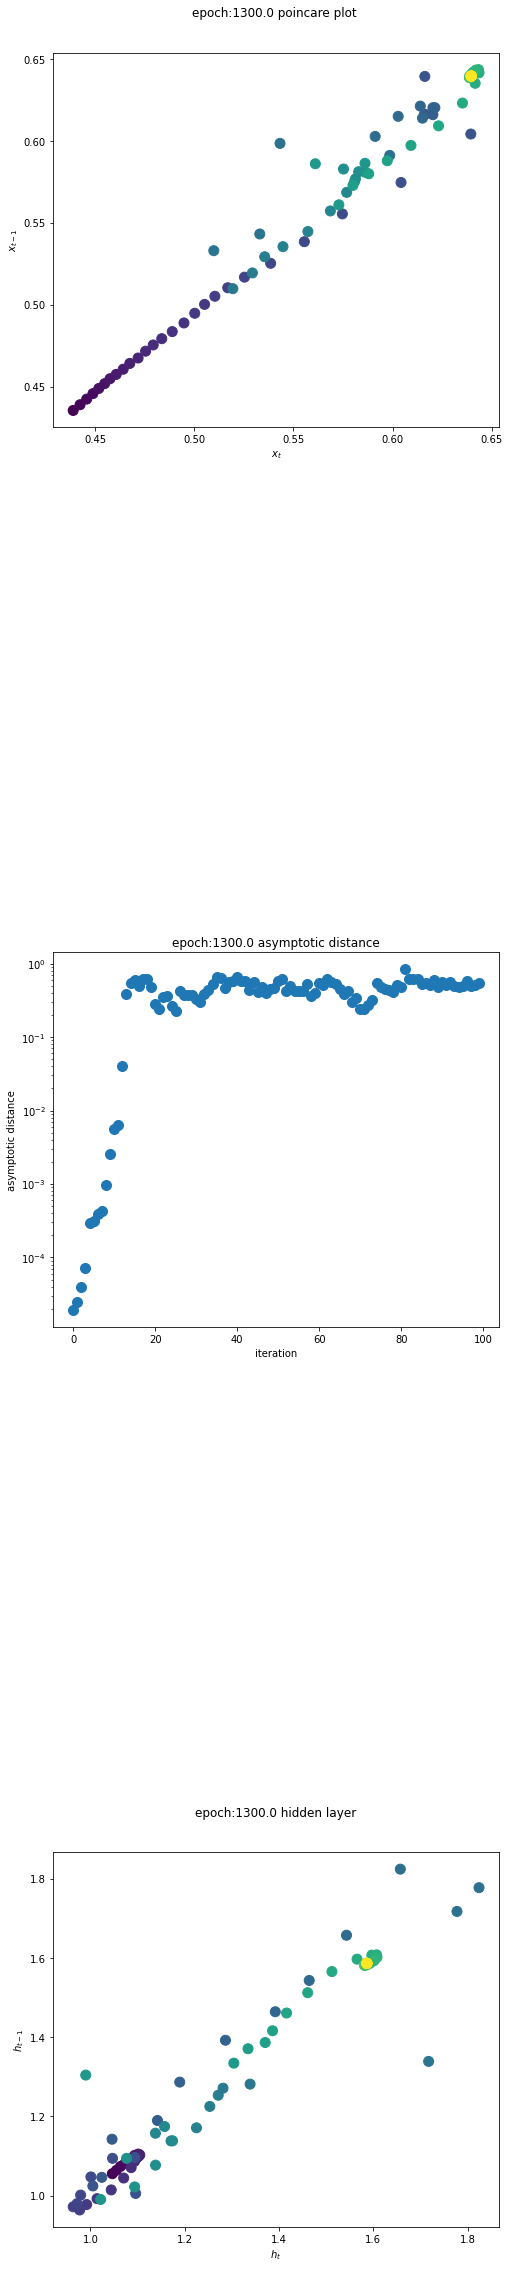

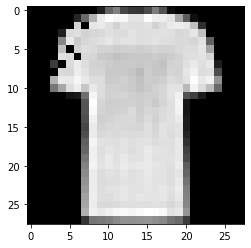

asymptotic image output epoch:1300.jpg
epoch : 1301/10000, training loss = 0.014998,validation loss = 0.019196
epoch : 1302/10000, training loss = 0.014981,validation loss = 0.019362
epoch : 1303/10000, training loss = 0.014993,validation loss = 0.019147
epoch : 1304/10000, training loss = 0.015064,validation loss = 0.019213
epoch : 1305/10000, training loss = 0.015016,validation loss = 0.019239
epoch : 1306/10000, training loss = 0.015013,validation loss = 0.019105
epoch : 1307/10000, training loss = 0.014894,validation loss = 0.019295
epoch : 1308/10000, training loss = 0.014997,validation loss = 0.019308
epoch : 1309/10000, training loss = 0.015012,validation loss = 0.019277
epoch : 1310/10000, training loss = 0.014986,validation loss = 0.019232
epoch : 1311/10000, training loss = 0.014932,validation loss = 0.019313
epoch : 1312/10000, training loss = 0.014987,validation loss = 0.019090
epoch : 1313/10000, training loss = 0.014988,validation loss = 0.019181
epoch : 1314/10000, train

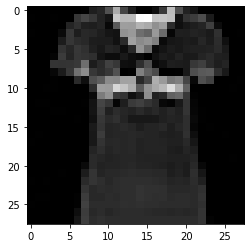

asymptotic image input epoch:1350.jpg


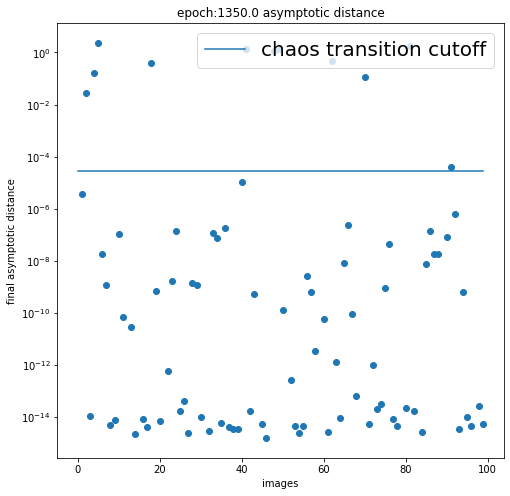

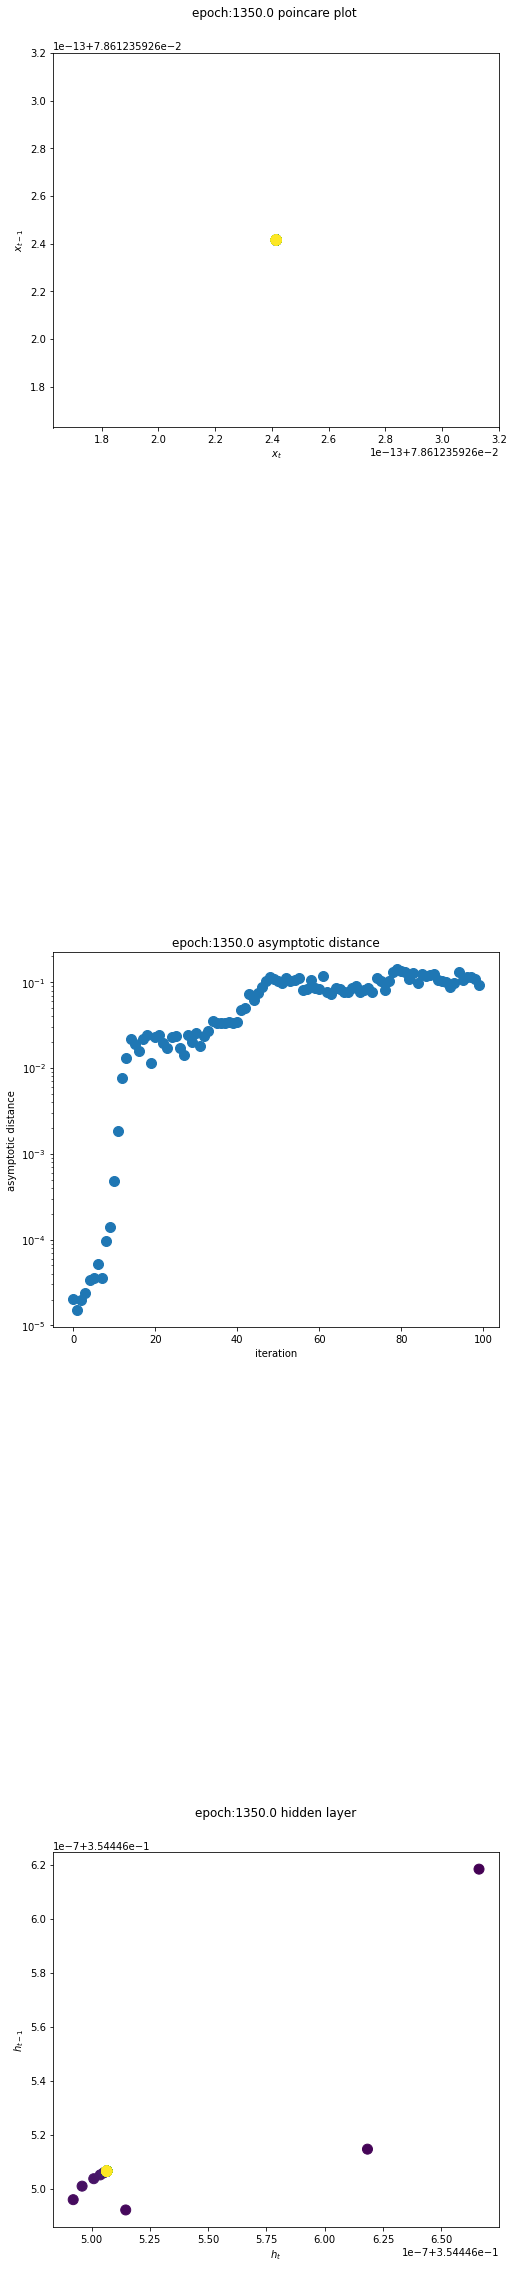

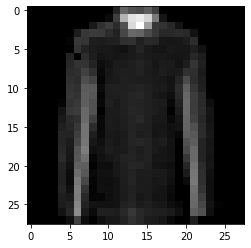

asymptotic image output epoch:1350.jpg
epoch : 1351/10000, training loss = 0.014959,validation loss = 0.019177
epoch : 1352/10000, training loss = 0.014901,validation loss = 0.019123
epoch : 1353/10000, training loss = 0.014896,validation loss = 0.019244
epoch : 1354/10000, training loss = 0.014928,validation loss = 0.019171
epoch : 1355/10000, training loss = 0.014868,validation loss = 0.019200
epoch : 1356/10000, training loss = 0.014971,validation loss = 0.019260
epoch : 1357/10000, training loss = 0.014792,validation loss = 0.019334
epoch : 1358/10000, training loss = 0.014885,validation loss = 0.019261
epoch : 1359/10000, training loss = 0.014900,validation loss = 0.019175
epoch : 1360/10000, training loss = 0.014789,validation loss = 0.019239
epoch : 1361/10000, training loss = 0.014934,validation loss = 0.019459
epoch : 1362/10000, training loss = 0.014968,validation loss = 0.019366
epoch : 1363/10000, training loss = 0.014846,validation loss = 0.019245
epoch : 1364/10000, train

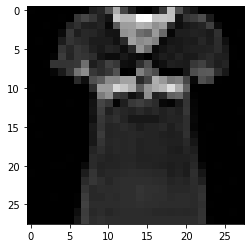

asymptotic image input epoch:1400.jpg


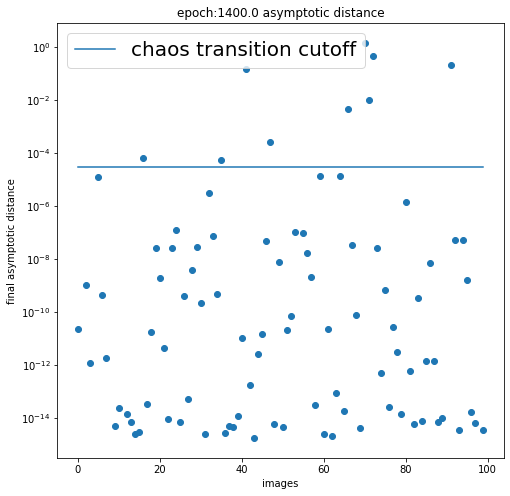

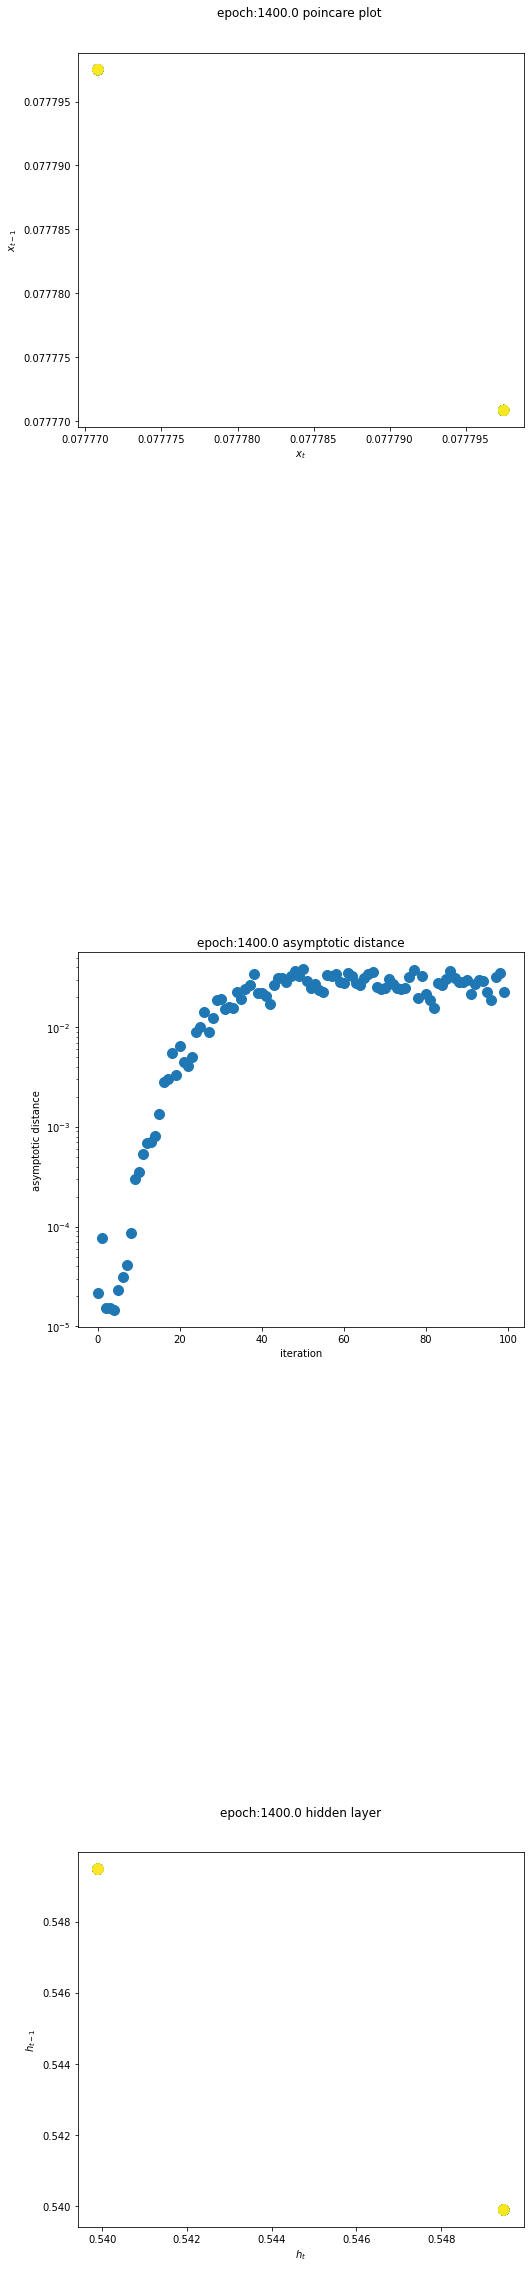

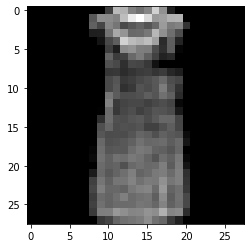

asymptotic image output epoch:1400.jpg
epoch : 1401/10000, training loss = 0.014882,validation loss = 0.019259
epoch : 1402/10000, training loss = 0.014971,validation loss = 0.019226
epoch : 1403/10000, training loss = 0.014829,validation loss = 0.019240
epoch : 1404/10000, training loss = 0.015124,validation loss = 0.019354
epoch : 1405/10000, training loss = 0.015081,validation loss = 0.019180
epoch : 1406/10000, training loss = 0.014810,validation loss = 0.019272
epoch : 1407/10000, training loss = 0.014979,validation loss = 0.019300
epoch : 1408/10000, training loss = 0.014863,validation loss = 0.019215
epoch : 1409/10000, training loss = 0.014885,validation loss = 0.019181
epoch : 1410/10000, training loss = 0.014842,validation loss = 0.019354
epoch : 1411/10000, training loss = 0.015167,validation loss = 0.019272
epoch : 1412/10000, training loss = 0.014904,validation loss = 0.019463
epoch : 1413/10000, training loss = 0.014919,validation loss = 0.019227
epoch : 1414/10000, train

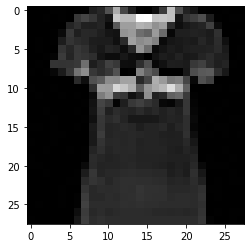

asymptotic image input epoch:1450.jpg


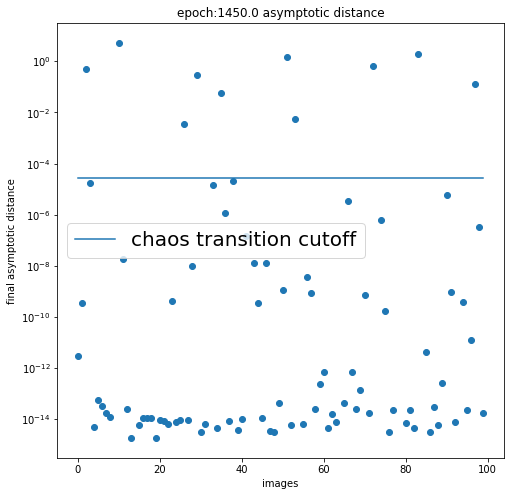

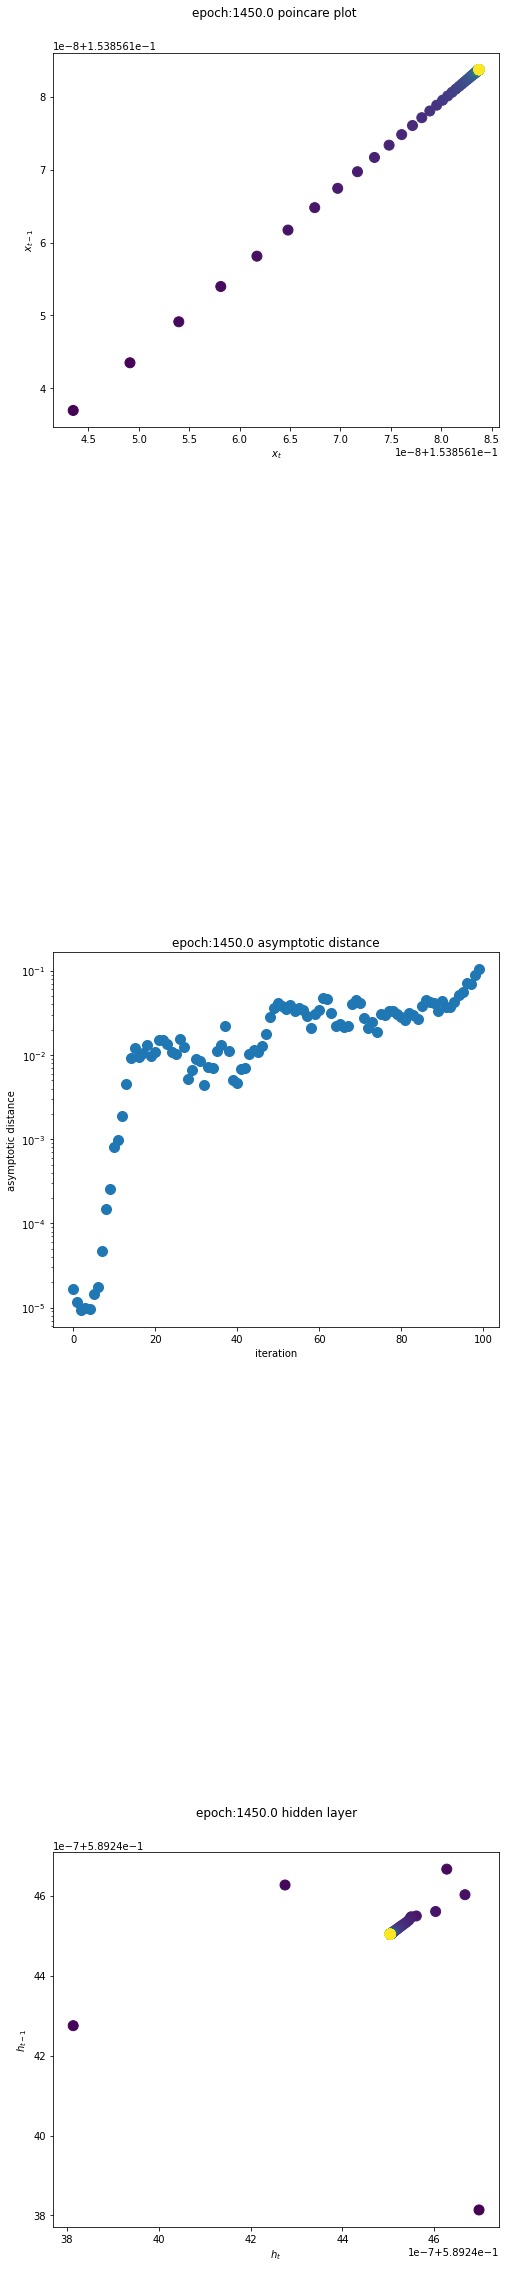

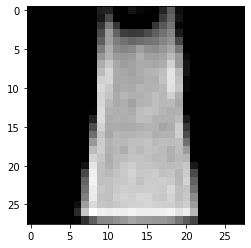

asymptotic image output epoch:1450.jpg
epoch : 1451/10000, training loss = 0.014828,validation loss = 0.019381
epoch : 1452/10000, training loss = 0.014978,validation loss = 0.019254
epoch : 1453/10000, training loss = 0.014857,validation loss = 0.019368
epoch : 1454/10000, training loss = 0.014930,validation loss = 0.019272
epoch : 1455/10000, training loss = 0.014844,validation loss = 0.019270
epoch : 1456/10000, training loss = 0.015036,validation loss = 0.019445
epoch : 1457/10000, training loss = 0.015178,validation loss = 0.019372
epoch : 1458/10000, training loss = 0.015033,validation loss = 0.019225
epoch : 1459/10000, training loss = 0.014865,validation loss = 0.019244
epoch : 1460/10000, training loss = 0.014995,validation loss = 0.019286
epoch : 1461/10000, training loss = 0.014789,validation loss = 0.019248
epoch : 1462/10000, training loss = 0.014823,validation loss = 0.019163
epoch : 1463/10000, training loss = 0.015155,validation loss = 0.019192
epoch : 1464/10000, train

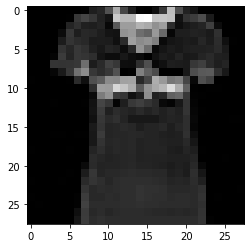

asymptotic image input epoch:1500.jpg


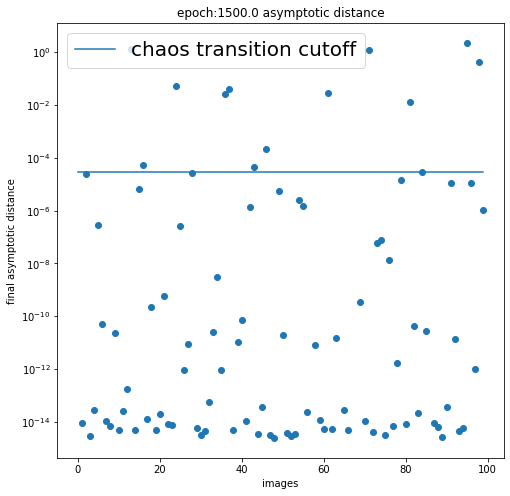

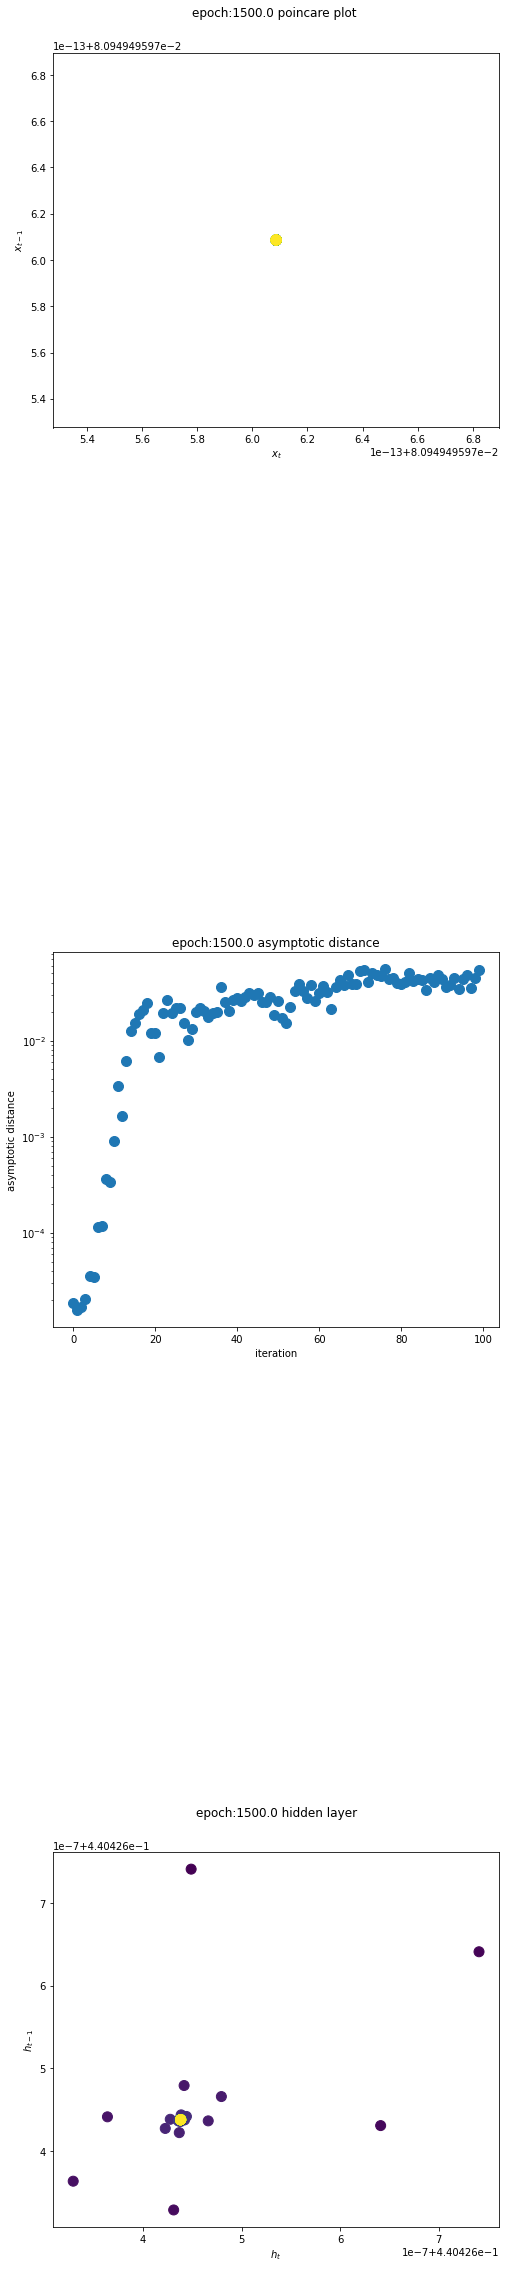

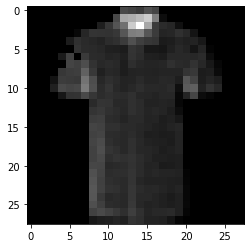

asymptotic image output epoch:1500.jpg
epoch : 1501/10000, training loss = 0.014964,validation loss = 0.019442
epoch : 1502/10000, training loss = 0.014901,validation loss = 0.019296
epoch : 1503/10000, training loss = 0.014828,validation loss = 0.019161
epoch : 1504/10000, training loss = 0.014715,validation loss = 0.019474
epoch : 1505/10000, training loss = 0.014964,validation loss = 0.019293
epoch : 1506/10000, training loss = 0.014901,validation loss = 0.019457
epoch : 1507/10000, training loss = 0.014998,validation loss = 0.019381
epoch : 1508/10000, training loss = 0.014911,validation loss = 0.019407
epoch : 1509/10000, training loss = 0.015173,validation loss = 0.019304
epoch : 1510/10000, training loss = 0.014980,validation loss = 0.019232
epoch : 1511/10000, training loss = 0.014827,validation loss = 0.019314
epoch : 1512/10000, training loss = 0.014811,validation loss = 0.019293
epoch : 1513/10000, training loss = 0.014861,validation loss = 0.019183
epoch : 1514/10000, train

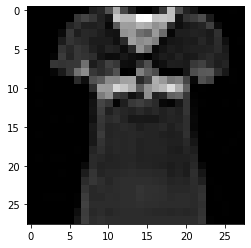

asymptotic image input epoch:1550.jpg


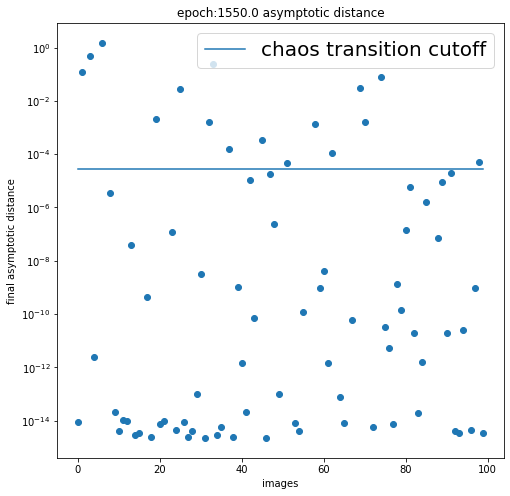

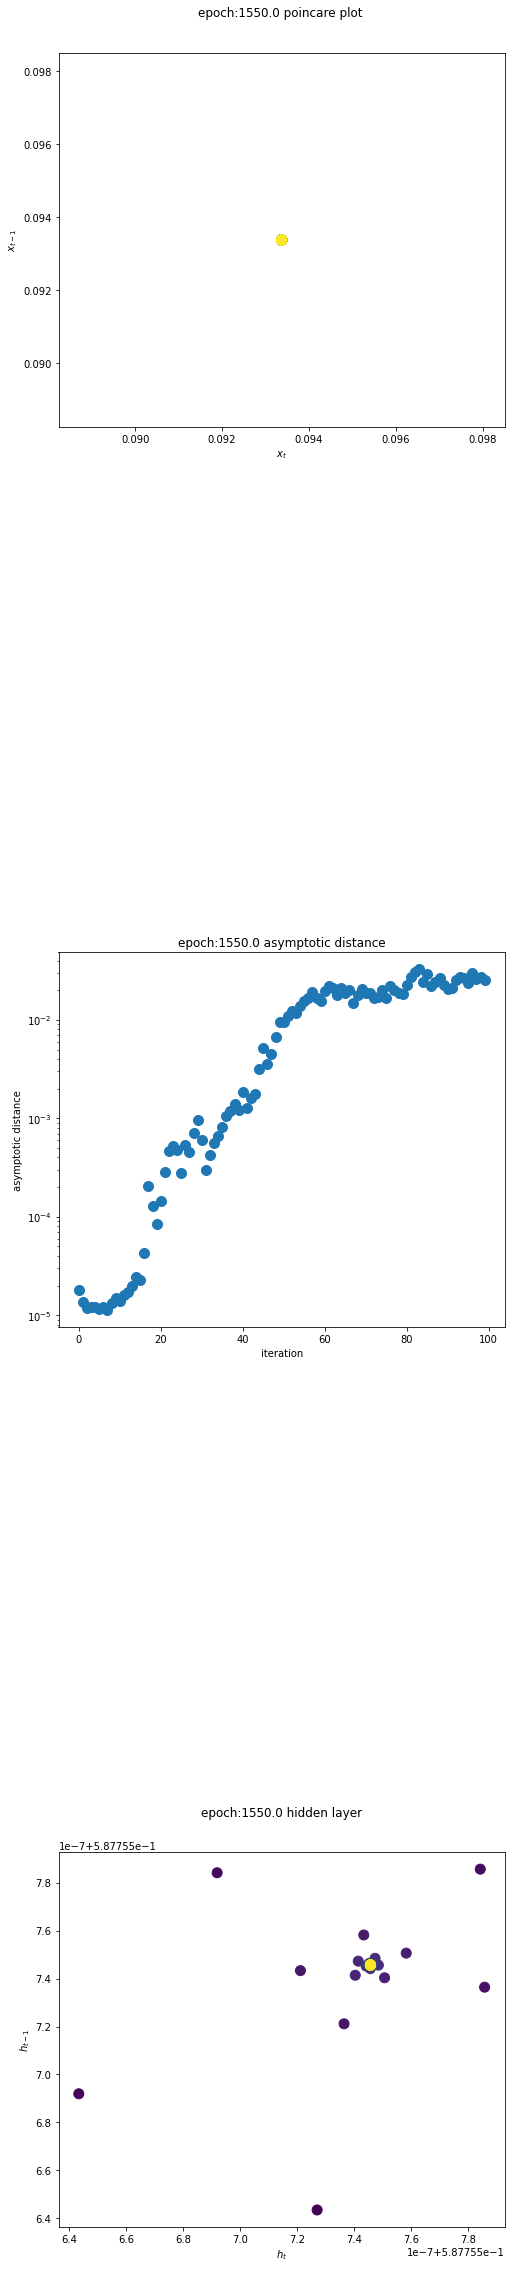

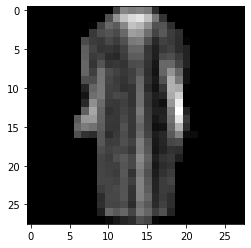

asymptotic image output epoch:1550.jpg
epoch : 1551/10000, training loss = 0.014880,validation loss = 0.019471
epoch : 1552/10000, training loss = 0.015264,validation loss = 0.019234
epoch : 1553/10000, training loss = 0.014910,validation loss = 0.019284
epoch : 1554/10000, training loss = 0.014954,validation loss = 0.019185
epoch : 1555/10000, training loss = 0.014859,validation loss = 0.019225
epoch : 1556/10000, training loss = 0.014799,validation loss = 0.019261
epoch : 1557/10000, training loss = 0.014895,validation loss = 0.019222
epoch : 1558/10000, training loss = 0.014840,validation loss = 0.019214
epoch : 1559/10000, training loss = 0.015006,validation loss = 0.019193
epoch : 1560/10000, training loss = 0.014777,validation loss = 0.019310
epoch : 1561/10000, training loss = 0.015214,validation loss = 0.019196
epoch : 1562/10000, training loss = 0.015112,validation loss = 0.019292
epoch : 1563/10000, training loss = 0.015241,validation loss = 0.019218
epoch : 1564/10000, train

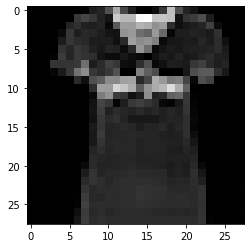

asymptotic image input epoch:1600.jpg


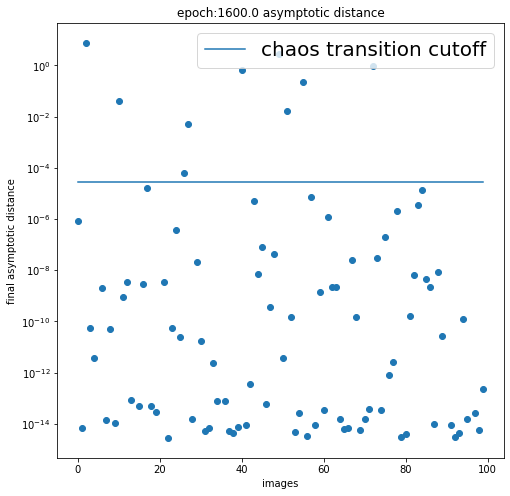

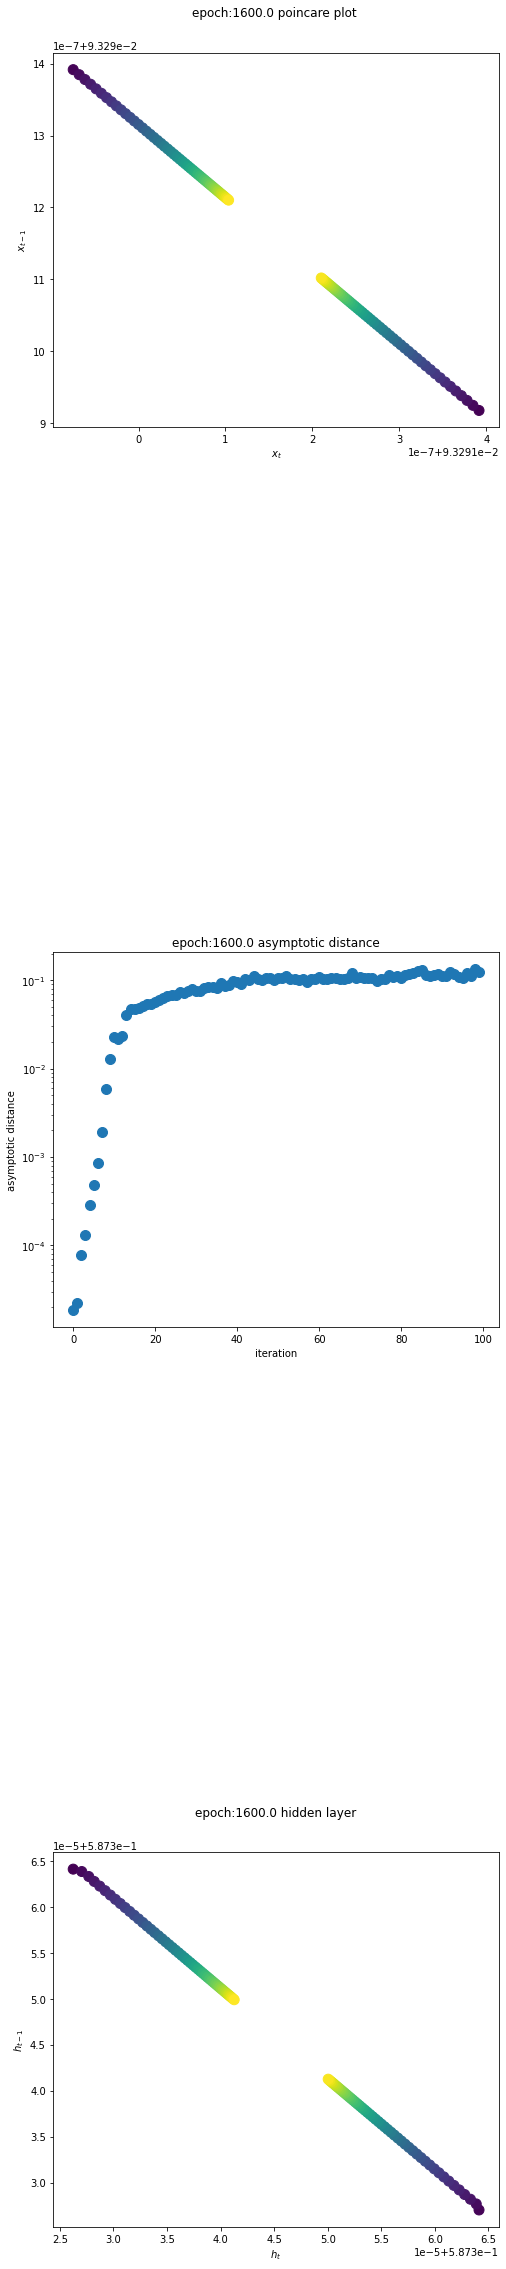

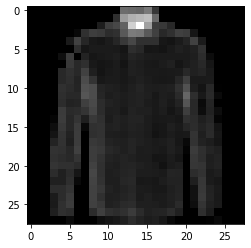

asymptotic image output epoch:1600.jpg
epoch : 1601/10000, training loss = 0.014911,validation loss = 0.019323
epoch : 1602/10000, training loss = 0.014875,validation loss = 0.019248
epoch : 1603/10000, training loss = 0.015022,validation loss = 0.019298
epoch : 1604/10000, training loss = 0.015368,validation loss = 0.019427
epoch : 1605/10000, training loss = 0.014902,validation loss = 0.019179
epoch : 1606/10000, training loss = 0.014804,validation loss = 0.019307
epoch : 1607/10000, training loss = 0.014725,validation loss = 0.019245
epoch : 1608/10000, training loss = 0.014650,validation loss = 0.019282
epoch : 1609/10000, training loss = 0.014942,validation loss = 0.019451
epoch : 1610/10000, training loss = 0.015073,validation loss = 0.019346
epoch : 1611/10000, training loss = 0.014738,validation loss = 0.019251
epoch : 1612/10000, training loss = 0.014790,validation loss = 0.019201
epoch : 1613/10000, training loss = 0.014816,validation loss = 0.019189
epoch : 1614/10000, train

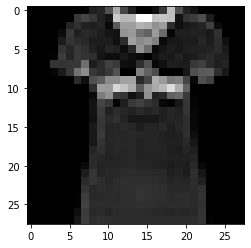

asymptotic image input epoch:1650.jpg


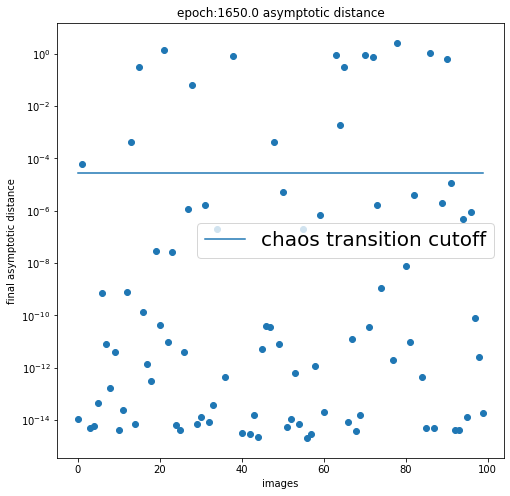

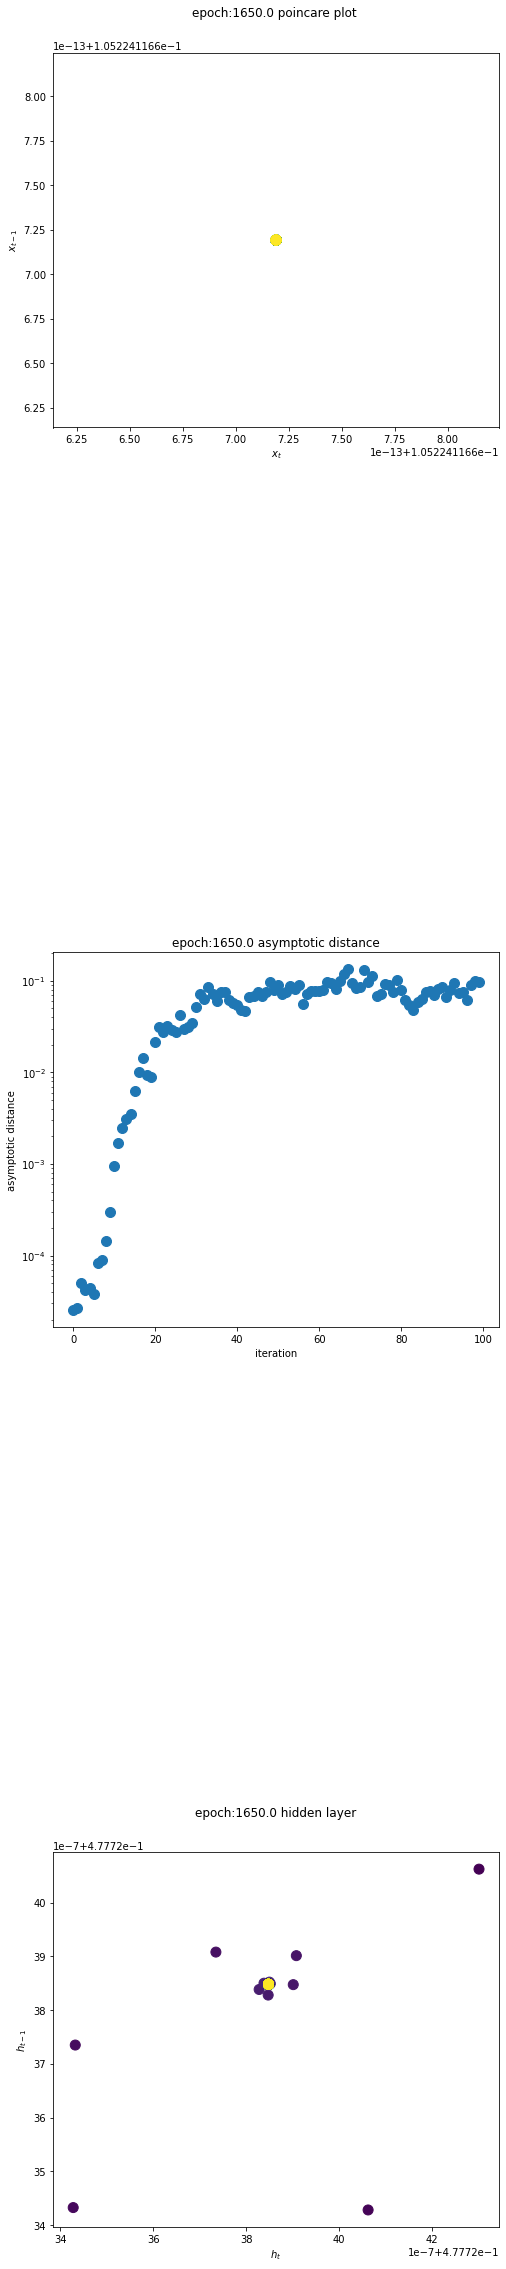

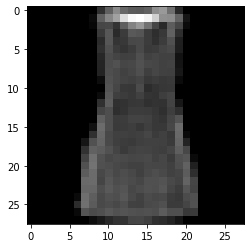

asymptotic image output epoch:1650.jpg
epoch : 1651/10000, training loss = 0.015042,validation loss = 0.019239
epoch : 1652/10000, training loss = 0.014890,validation loss = 0.019322
epoch : 1653/10000, training loss = 0.015076,validation loss = 0.019195
epoch : 1654/10000, training loss = 0.014836,validation loss = 0.019214
epoch : 1655/10000, training loss = 0.014706,validation loss = 0.019270
epoch : 1656/10000, training loss = 0.014784,validation loss = 0.019201
epoch : 1657/10000, training loss = 0.014898,validation loss = 0.019554
epoch : 1658/10000, training loss = 0.015056,validation loss = 0.019254
epoch : 1659/10000, training loss = 0.015019,validation loss = 0.019413
epoch : 1660/10000, training loss = 0.014702,validation loss = 0.019336
epoch : 1661/10000, training loss = 0.014654,validation loss = 0.019343
epoch : 1662/10000, training loss = 0.014858,validation loss = 0.019315
epoch : 1663/10000, training loss = 0.015001,validation loss = 0.019374
epoch : 1664/10000, train

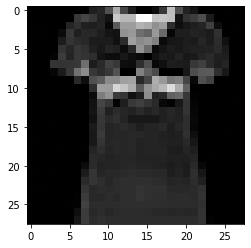

asymptotic image input epoch:1700.jpg


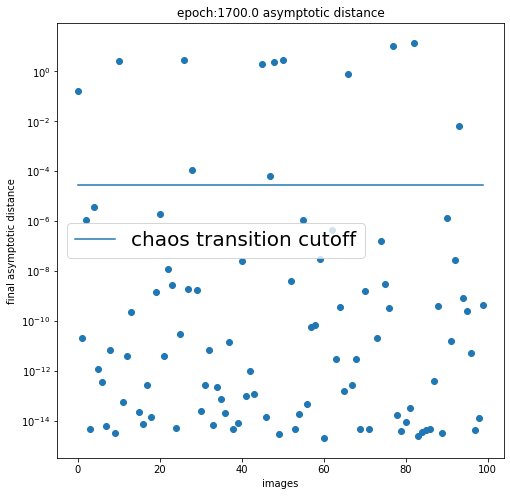

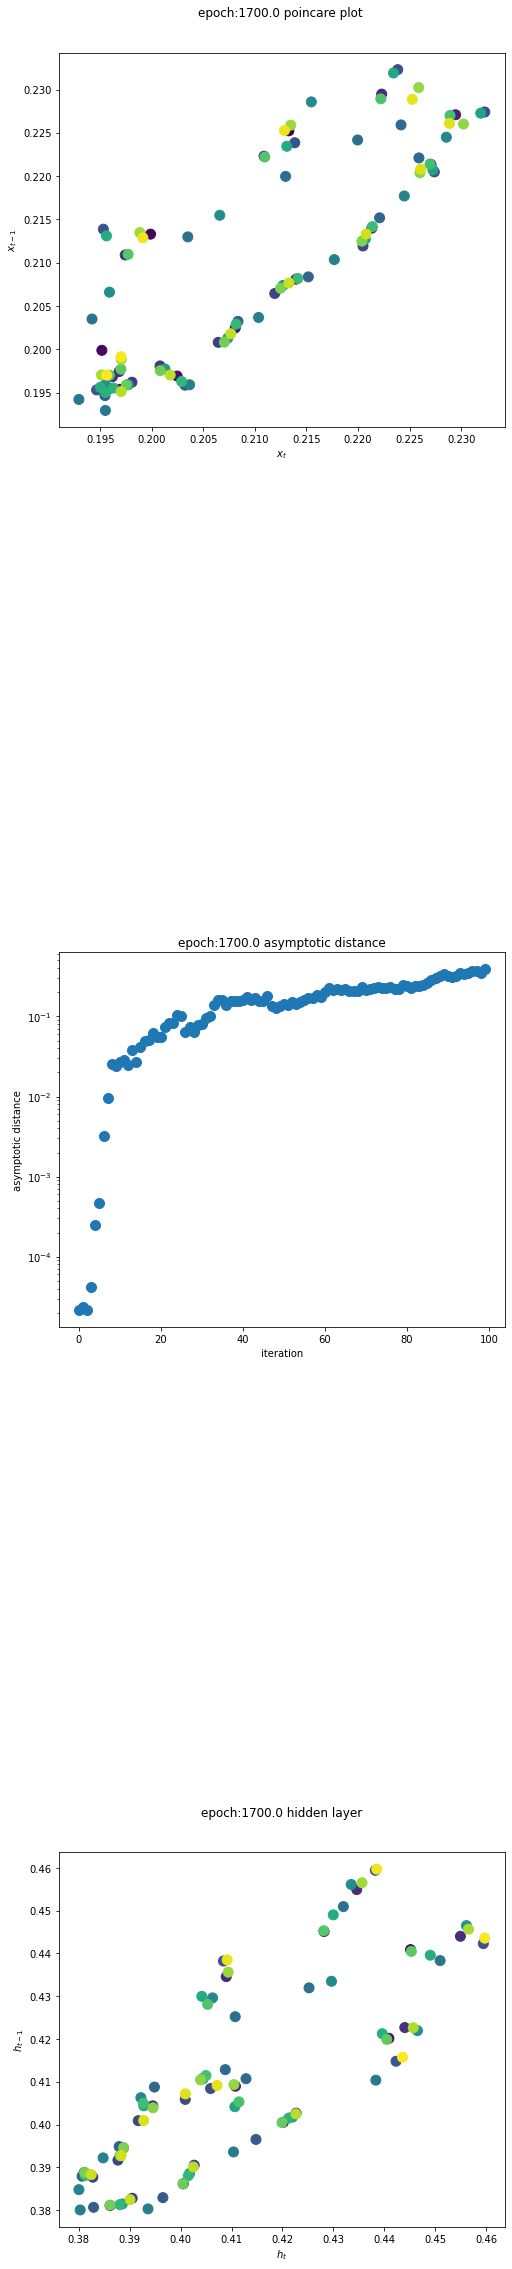

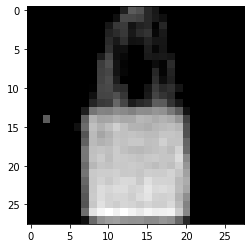

asymptotic image output epoch:1700.jpg
epoch : 1701/10000, training loss = 0.014628,validation loss = 0.019097
epoch : 1702/10000, training loss = 0.014576,validation loss = 0.019094
epoch : 1703/10000, training loss = 0.014505,validation loss = 0.019163
epoch : 1704/10000, training loss = 0.014831,validation loss = 0.019095
epoch : 1705/10000, training loss = 0.014696,validation loss = 0.019102
epoch : 1706/10000, training loss = 0.014685,validation loss = 0.019082
epoch : 1707/10000, training loss = 0.014591,validation loss = 0.019094
epoch : 1708/10000, training loss = 0.014595,validation loss = 0.019143
epoch : 1709/10000, training loss = 0.014662,validation loss = 0.019080
epoch : 1710/10000, training loss = 0.014781,validation loss = 0.019059
epoch : 1711/10000, training loss = 0.014592,validation loss = 0.019092
epoch : 1712/10000, training loss = 0.014691,validation loss = 0.019219
epoch : 1713/10000, training loss = 0.014908,validation loss = 0.019191
epoch : 1714/10000, train

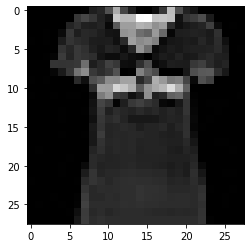

asymptotic image input epoch:1750.jpg


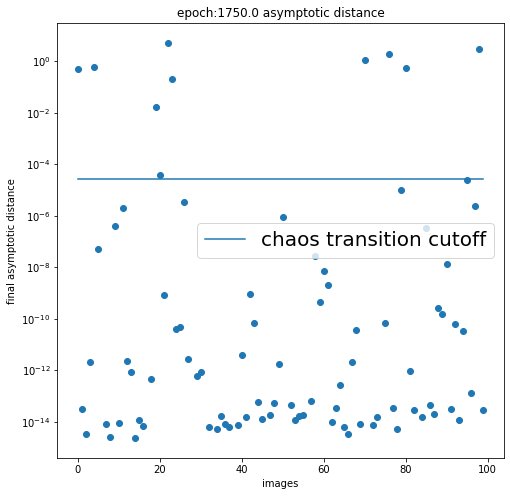

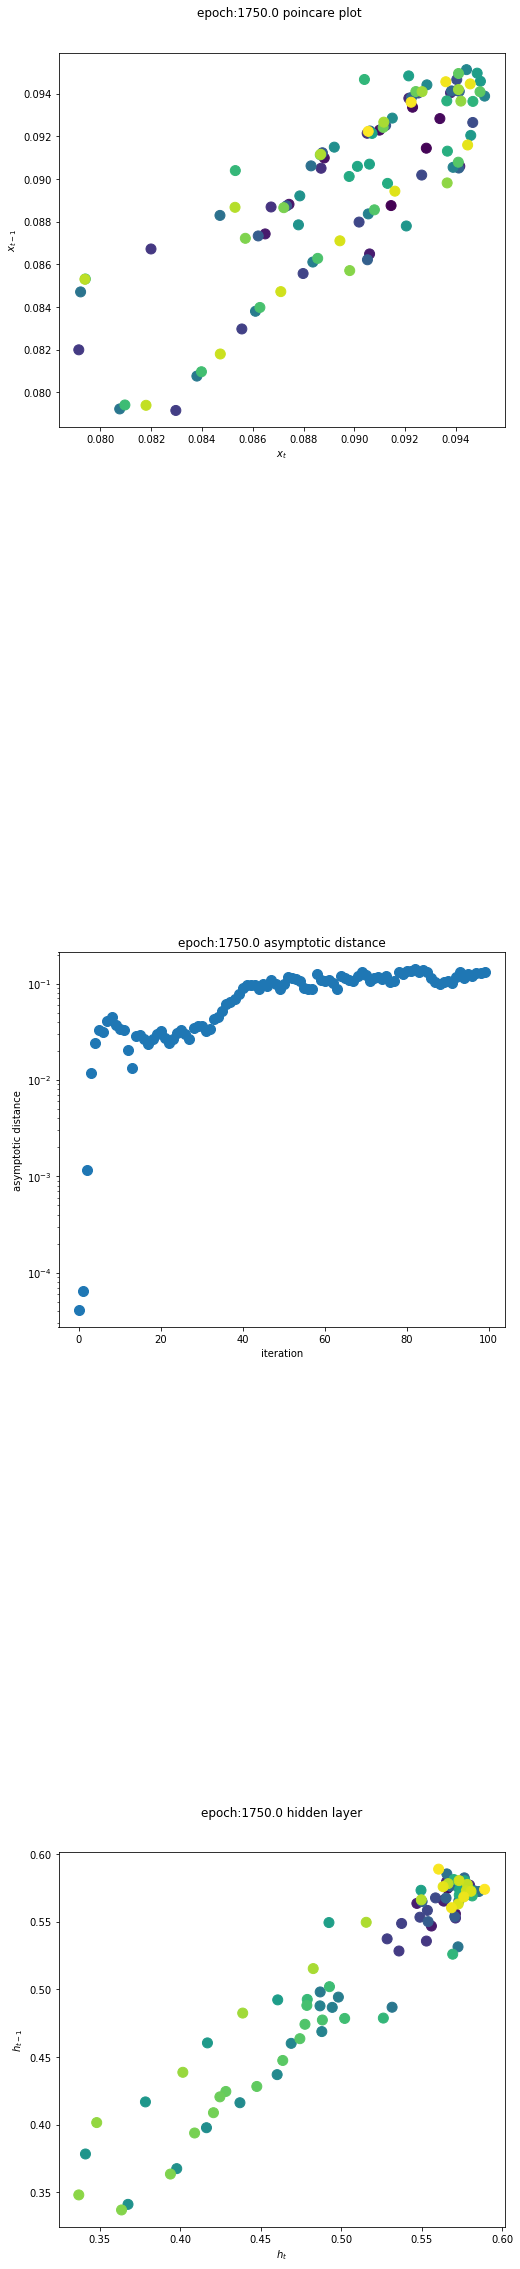

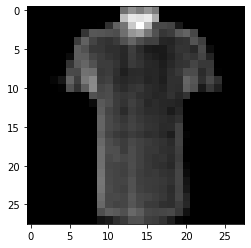

asymptotic image output epoch:1750.jpg
epoch : 1751/10000, training loss = 0.014548,validation loss = 0.019175
epoch : 1752/10000, training loss = 0.014671,validation loss = 0.019074
epoch : 1753/10000, training loss = 0.014794,validation loss = 0.019328
epoch : 1754/10000, training loss = 0.014684,validation loss = 0.019133
epoch : 1755/10000, training loss = 0.014937,validation loss = 0.019155
epoch : 1756/10000, training loss = 0.014626,validation loss = 0.019077
epoch : 1757/10000, training loss = 0.014553,validation loss = 0.019184
epoch : 1758/10000, training loss = 0.014632,validation loss = 0.019196
epoch : 1759/10000, training loss = 0.014498,validation loss = 0.019092
epoch : 1760/10000, training loss = 0.014637,validation loss = 0.019112
epoch : 1761/10000, training loss = 0.014660,validation loss = 0.019067
epoch : 1762/10000, training loss = 0.014604,validation loss = 0.019085
epoch : 1763/10000, training loss = 0.014665,validation loss = 0.019312
epoch : 1764/10000, train

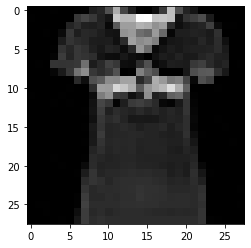

asymptotic image input epoch:1800.jpg


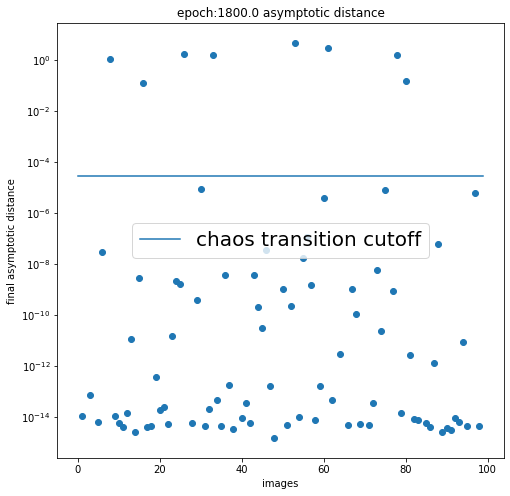

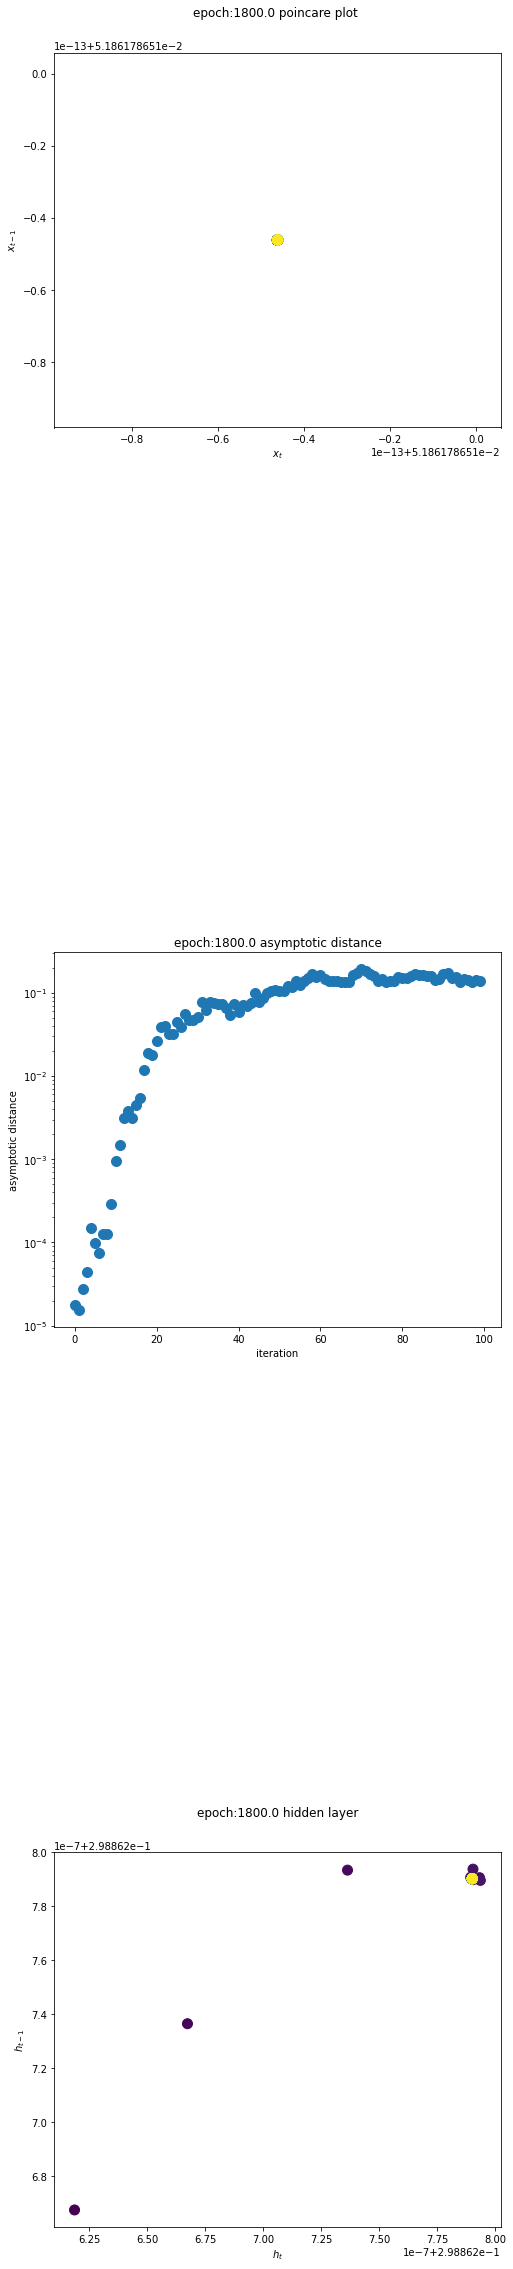

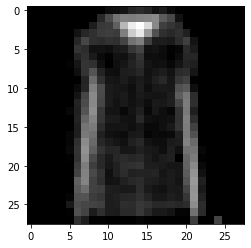

asymptotic image output epoch:1800.jpg
epoch : 1801/10000, training loss = 0.014667,validation loss = 0.019197
epoch : 1802/10000, training loss = 0.014503,validation loss = 0.019122
epoch : 1803/10000, training loss = 0.014677,validation loss = 0.019166
epoch : 1804/10000, training loss = 0.014875,validation loss = 0.019118
epoch : 1805/10000, training loss = 0.014599,validation loss = 0.019151
epoch : 1806/10000, training loss = 0.014749,validation loss = 0.019036
epoch : 1807/10000, training loss = 0.014735,validation loss = 0.019050
epoch : 1808/10000, training loss = 0.014611,validation loss = 0.019145
epoch : 1809/10000, training loss = 0.014732,validation loss = 0.019139
epoch : 1810/10000, training loss = 0.014466,validation loss = 0.019095
epoch : 1811/10000, training loss = 0.014446,validation loss = 0.019112
epoch : 1812/10000, training loss = 0.014566,validation loss = 0.019286
epoch : 1813/10000, training loss = 0.014800,validation loss = 0.019584
epoch : 1814/10000, train

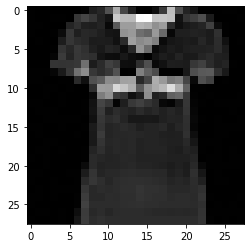

asymptotic image input epoch:1850.jpg


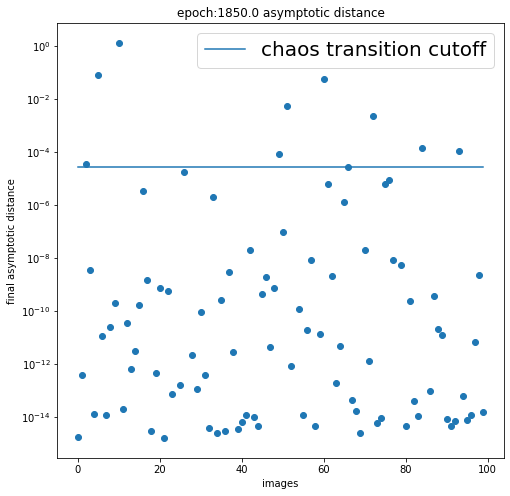

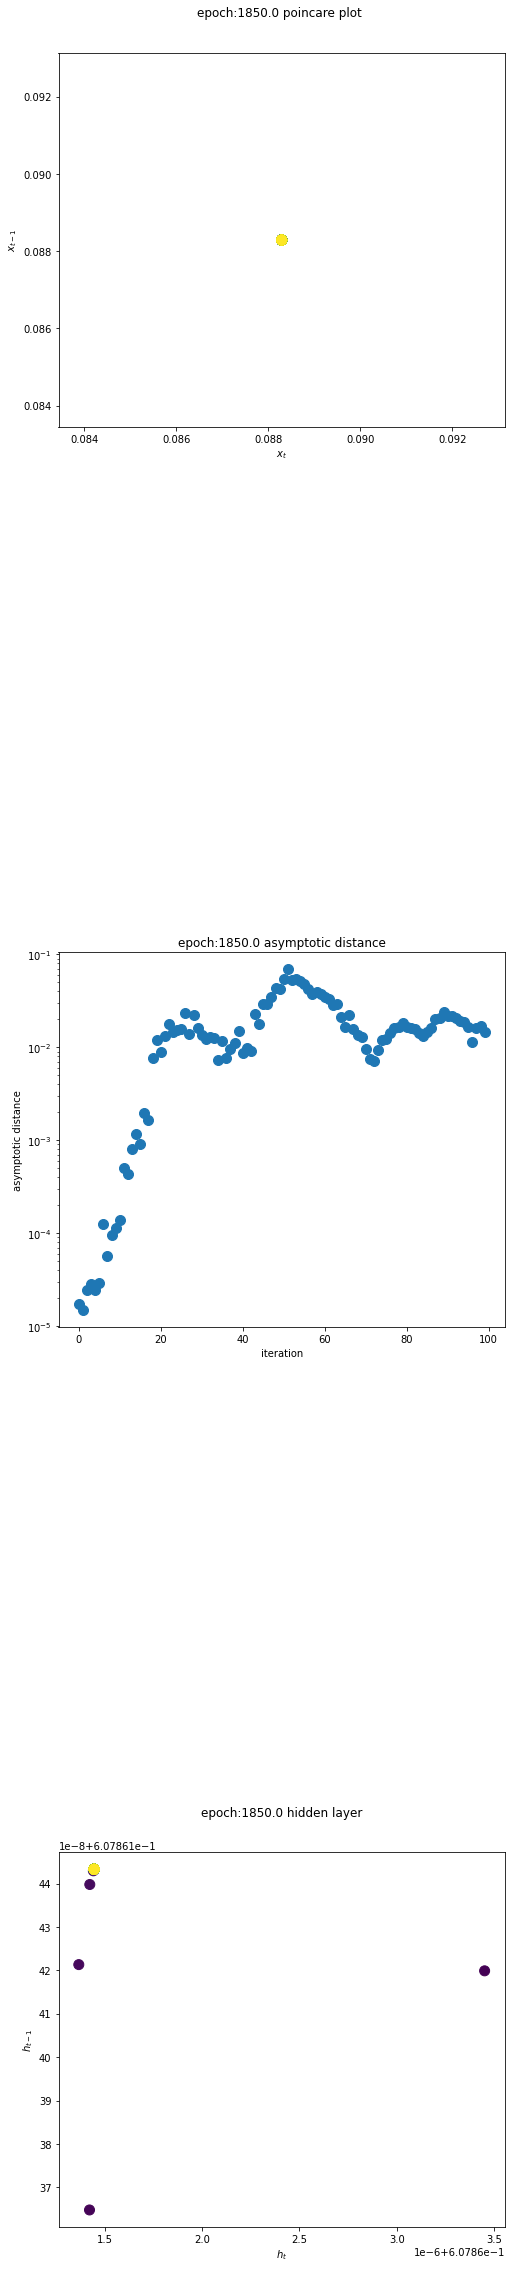

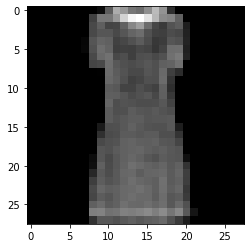

asymptotic image output epoch:1850.jpg
epoch : 1851/10000, training loss = 0.014596,validation loss = 0.019086
epoch : 1852/10000, training loss = 0.014436,validation loss = 0.018995
epoch : 1853/10000, training loss = 0.014615,validation loss = 0.019114
epoch : 1854/10000, training loss = 0.014553,validation loss = 0.019108
epoch : 1855/10000, training loss = 0.014676,validation loss = 0.019208
epoch : 1856/10000, training loss = 0.014580,validation loss = 0.019028
epoch : 1857/10000, training loss = 0.014507,validation loss = 0.019098
epoch : 1858/10000, training loss = 0.014533,validation loss = 0.019179
epoch : 1859/10000, training loss = 0.014680,validation loss = 0.019170
epoch : 1860/10000, training loss = 0.014681,validation loss = 0.019118
epoch : 1861/10000, training loss = 0.014792,validation loss = 0.019058
epoch : 1862/10000, training loss = 0.014610,validation loss = 0.019279
epoch : 1863/10000, training loss = 0.014810,validation loss = 0.019056
epoch : 1864/10000, train

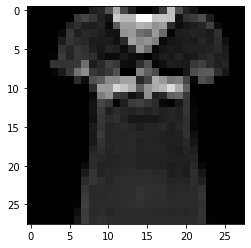

asymptotic image input epoch:1900.jpg


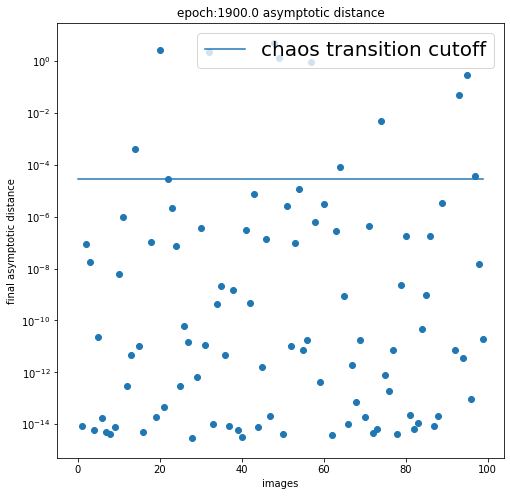

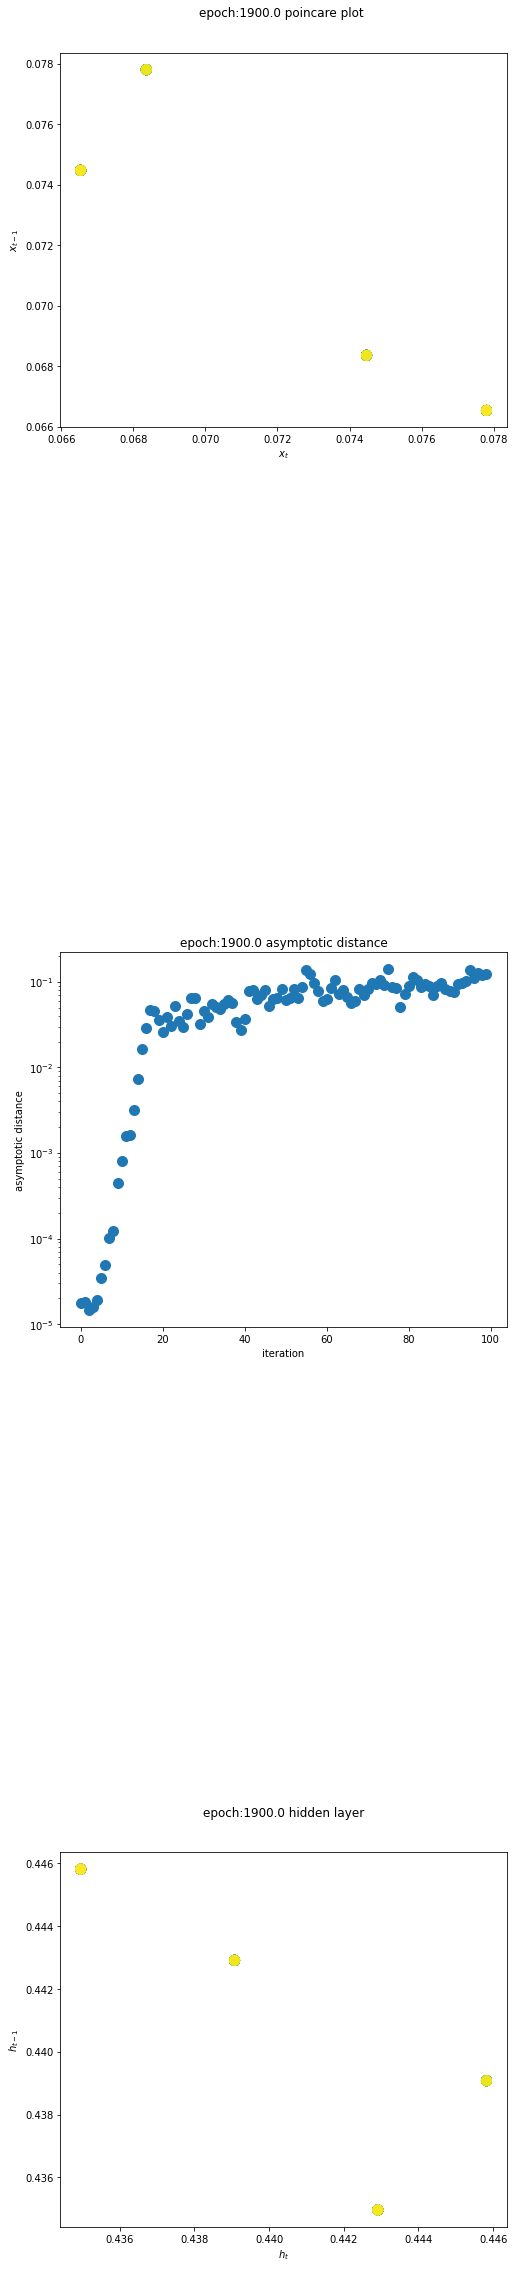

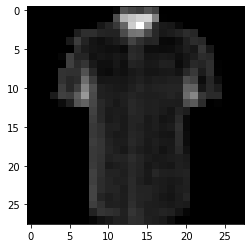

asymptotic image output epoch:1900.jpg
epoch : 1901/10000, training loss = 0.015031,validation loss = 0.019163
epoch : 1902/10000, training loss = 0.014620,validation loss = 0.019373
epoch : 1903/10000, training loss = 0.014794,validation loss = 0.019050
epoch : 1904/10000, training loss = 0.014578,validation loss = 0.018970
epoch : 1905/10000, training loss = 0.014410,validation loss = 0.019045
epoch : 1906/10000, training loss = 0.014550,validation loss = 0.018983
epoch : 1907/10000, training loss = 0.014622,validation loss = 0.019211
epoch : 1908/10000, training loss = 0.014521,validation loss = 0.019078
epoch : 1909/10000, training loss = 0.014669,validation loss = 0.019229
epoch : 1910/10000, training loss = 0.014812,validation loss = 0.019327
epoch : 1911/10000, training loss = 0.014672,validation loss = 0.019119
epoch : 1912/10000, training loss = 0.014912,validation loss = 0.019250
epoch : 1913/10000, training loss = 0.014616,validation loss = 0.019148
epoch : 1914/10000, train

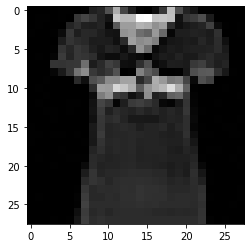

asymptotic image input epoch:1950.jpg


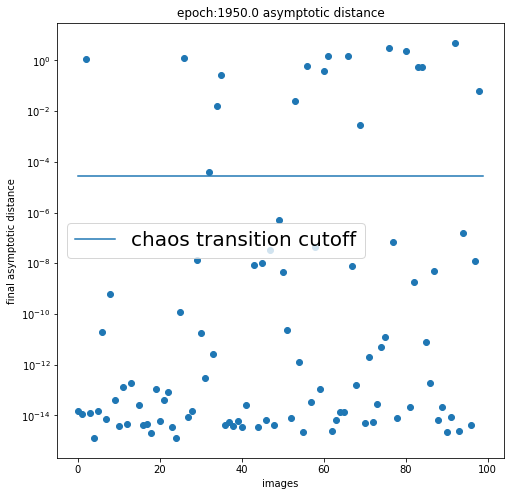

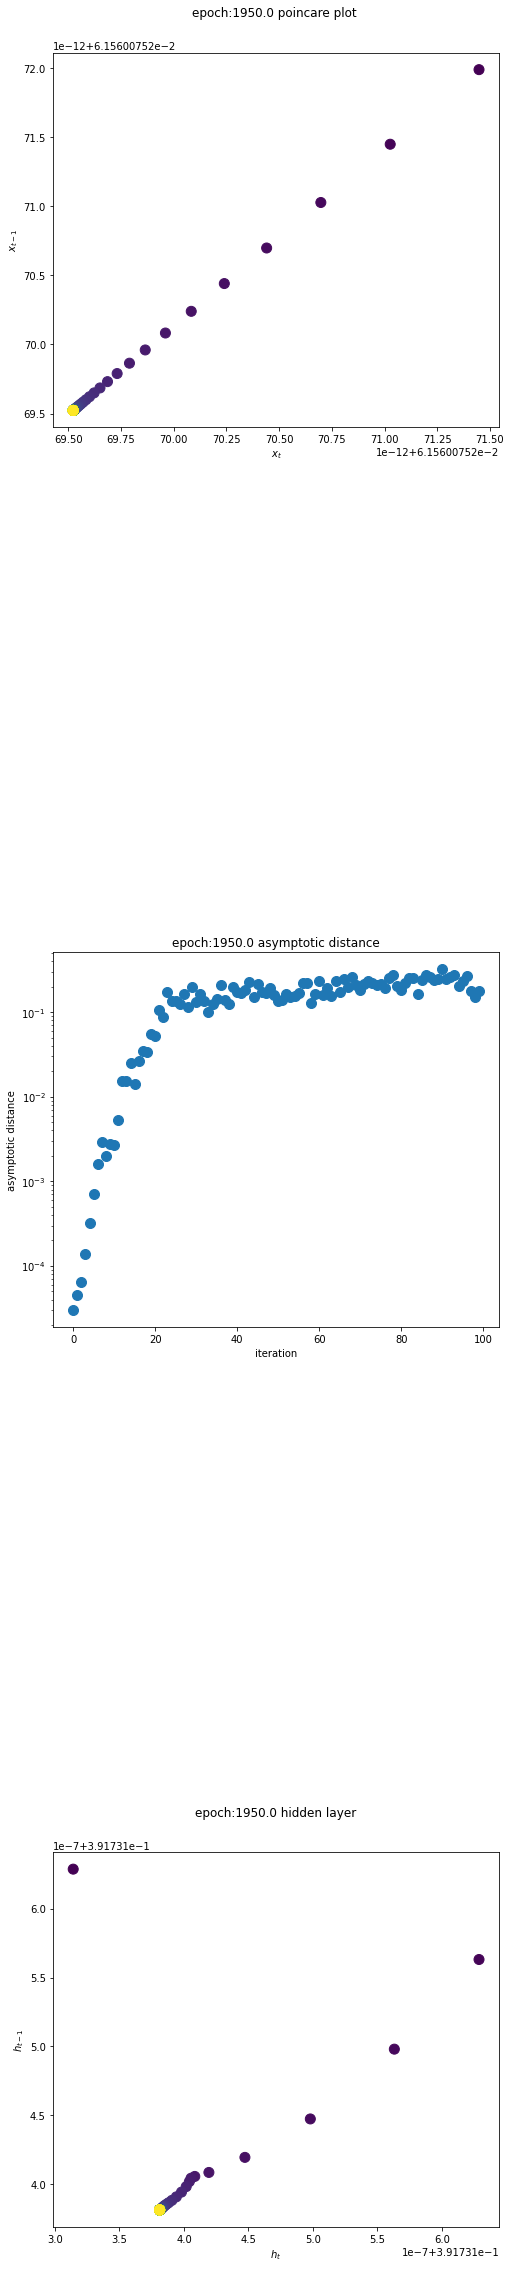

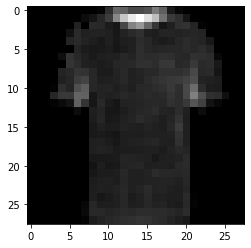

asymptotic image output epoch:1950.jpg
epoch : 1951/10000, training loss = 0.014716,validation loss = 0.019216
epoch : 1952/10000, training loss = 0.014600,validation loss = 0.019111
epoch : 1953/10000, training loss = 0.014662,validation loss = 0.019139
epoch : 1954/10000, training loss = 0.014497,validation loss = 0.019095
epoch : 1955/10000, training loss = 0.014636,validation loss = 0.019165
epoch : 1956/10000, training loss = 0.014612,validation loss = 0.019100
epoch : 1957/10000, training loss = 0.014506,validation loss = 0.019313
epoch : 1958/10000, training loss = 0.014609,validation loss = 0.019202
epoch : 1959/10000, training loss = 0.014755,validation loss = 0.019207
epoch : 1960/10000, training loss = 0.014620,validation loss = 0.019098
epoch : 1961/10000, training loss = 0.014638,validation loss = 0.019180
epoch : 1962/10000, training loss = 0.015023,validation loss = 0.019068
epoch : 1963/10000, training loss = 0.014640,validation loss = 0.019115
epoch : 1964/10000, train

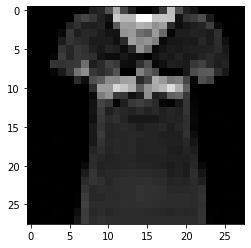

asymptotic image input epoch:2000.jpg


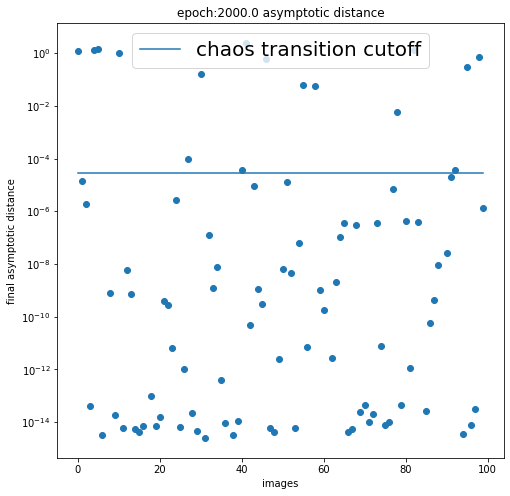

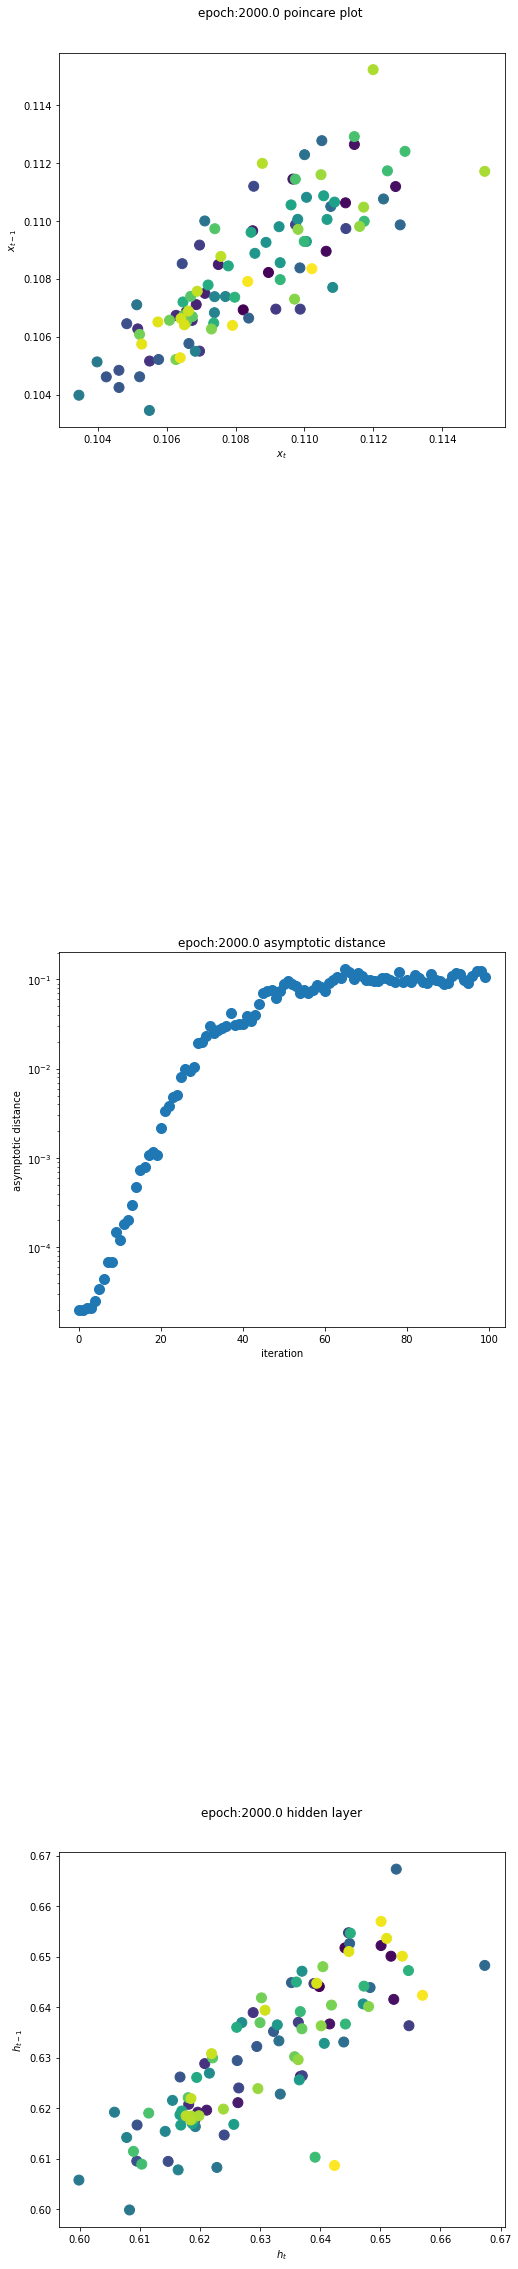

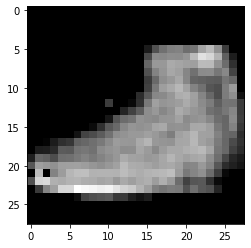

asymptotic image output epoch:2000.jpg
epoch : 2001/10000, training loss = 0.014465,validation loss = 0.019155
epoch : 2002/10000, training loss = 0.014631,validation loss = 0.019175
epoch : 2003/10000, training loss = 0.014579,validation loss = 0.019106
epoch : 2004/10000, training loss = 0.014552,validation loss = 0.019182
epoch : 2005/10000, training loss = 0.014748,validation loss = 0.019183
epoch : 2006/10000, training loss = 0.014441,validation loss = 0.019215
epoch : 2007/10000, training loss = 0.014597,validation loss = 0.019179
epoch : 2008/10000, training loss = 0.014838,validation loss = 0.019251
epoch : 2009/10000, training loss = 0.014762,validation loss = 0.019145
epoch : 2010/10000, training loss = 0.014717,validation loss = 0.019141
epoch : 2011/10000, training loss = 0.014625,validation loss = 0.019087
epoch : 2012/10000, training loss = 0.014445,validation loss = 0.019214
epoch : 2013/10000, training loss = 0.014764,validation loss = 0.019235
epoch : 2014/10000, train

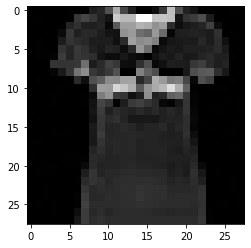

asymptotic image input epoch:2050.jpg


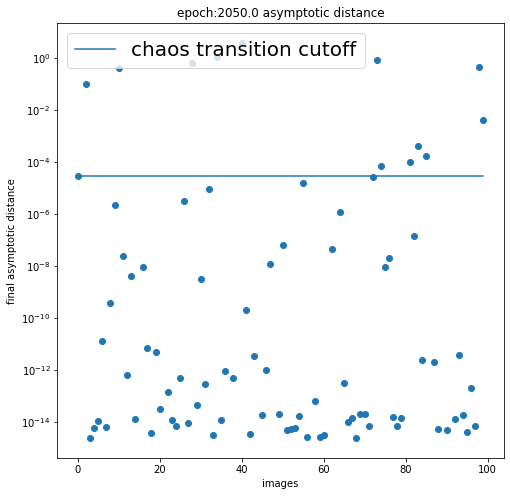

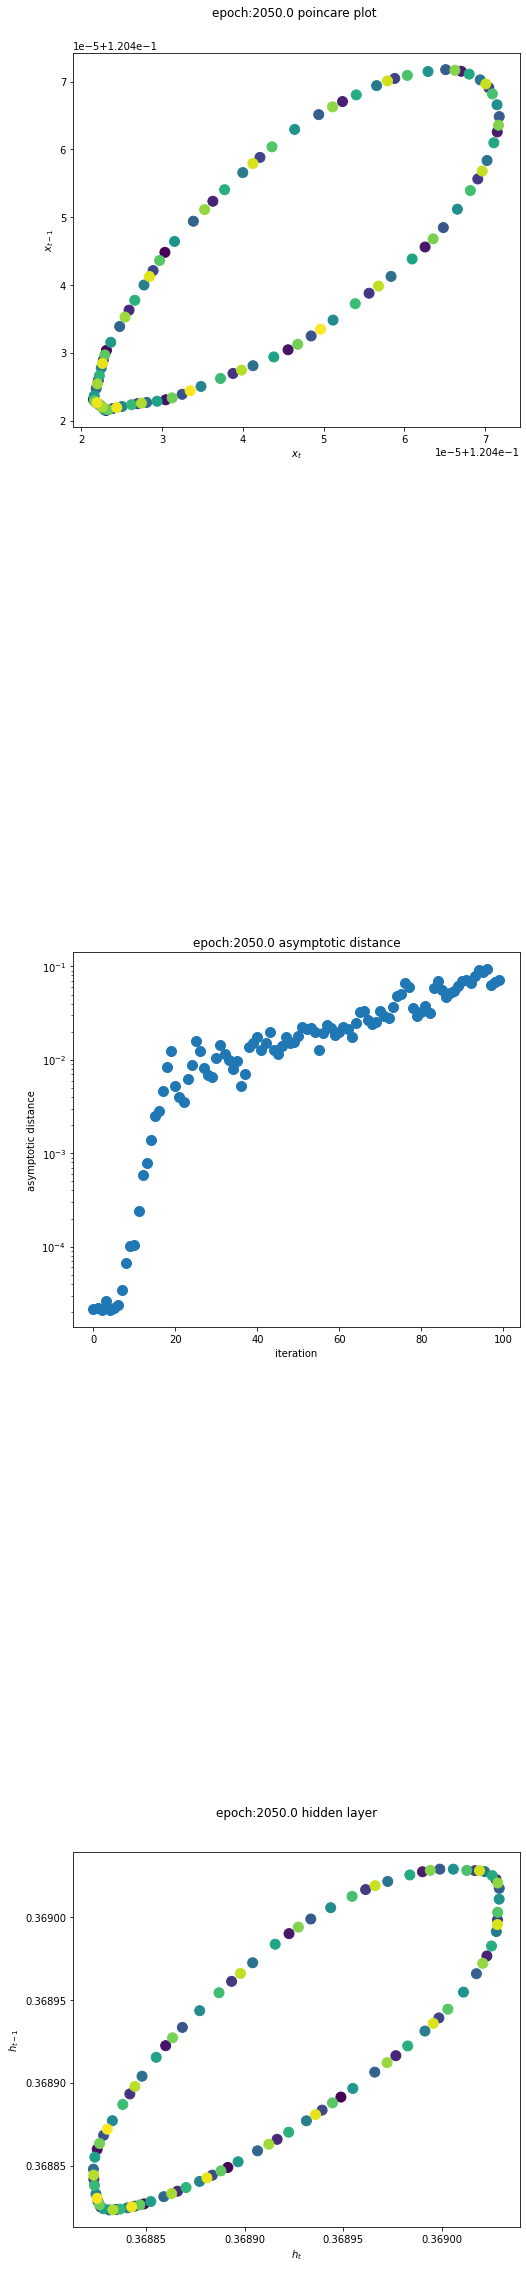

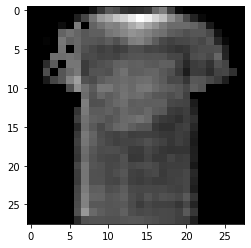

asymptotic image output epoch:2050.jpg
epoch : 2051/10000, training loss = 0.014701,validation loss = 0.019220
epoch : 2052/10000, training loss = 0.014578,validation loss = 0.019349
epoch : 2053/10000, training loss = 0.014662,validation loss = 0.019216
epoch : 2054/10000, training loss = 0.014692,validation loss = 0.019161
epoch : 2055/10000, training loss = 0.014579,validation loss = 0.019233
epoch : 2056/10000, training loss = 0.014680,validation loss = 0.019267
epoch : 2057/10000, training loss = 0.014564,validation loss = 0.019245
epoch : 2058/10000, training loss = 0.014610,validation loss = 0.019275
epoch : 2059/10000, training loss = 0.014640,validation loss = 0.019263
epoch : 2060/10000, training loss = 0.014591,validation loss = 0.019225
epoch : 2061/10000, training loss = 0.014587,validation loss = 0.019164
epoch : 2062/10000, training loss = 0.014533,validation loss = 0.019268
epoch : 2063/10000, training loss = 0.014533,validation loss = 0.019392
epoch : 2064/10000, train

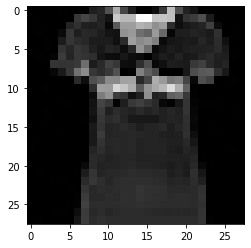

asymptotic image input epoch:2100.jpg


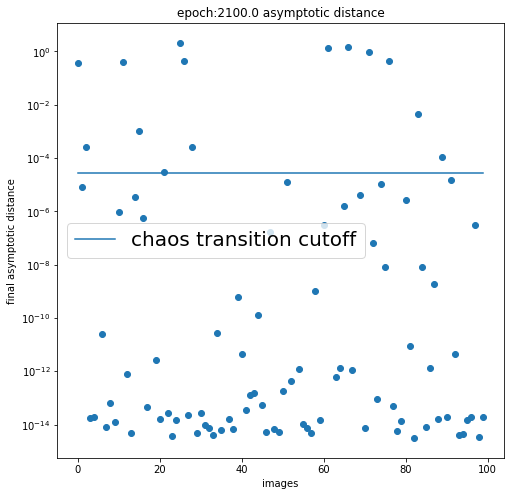

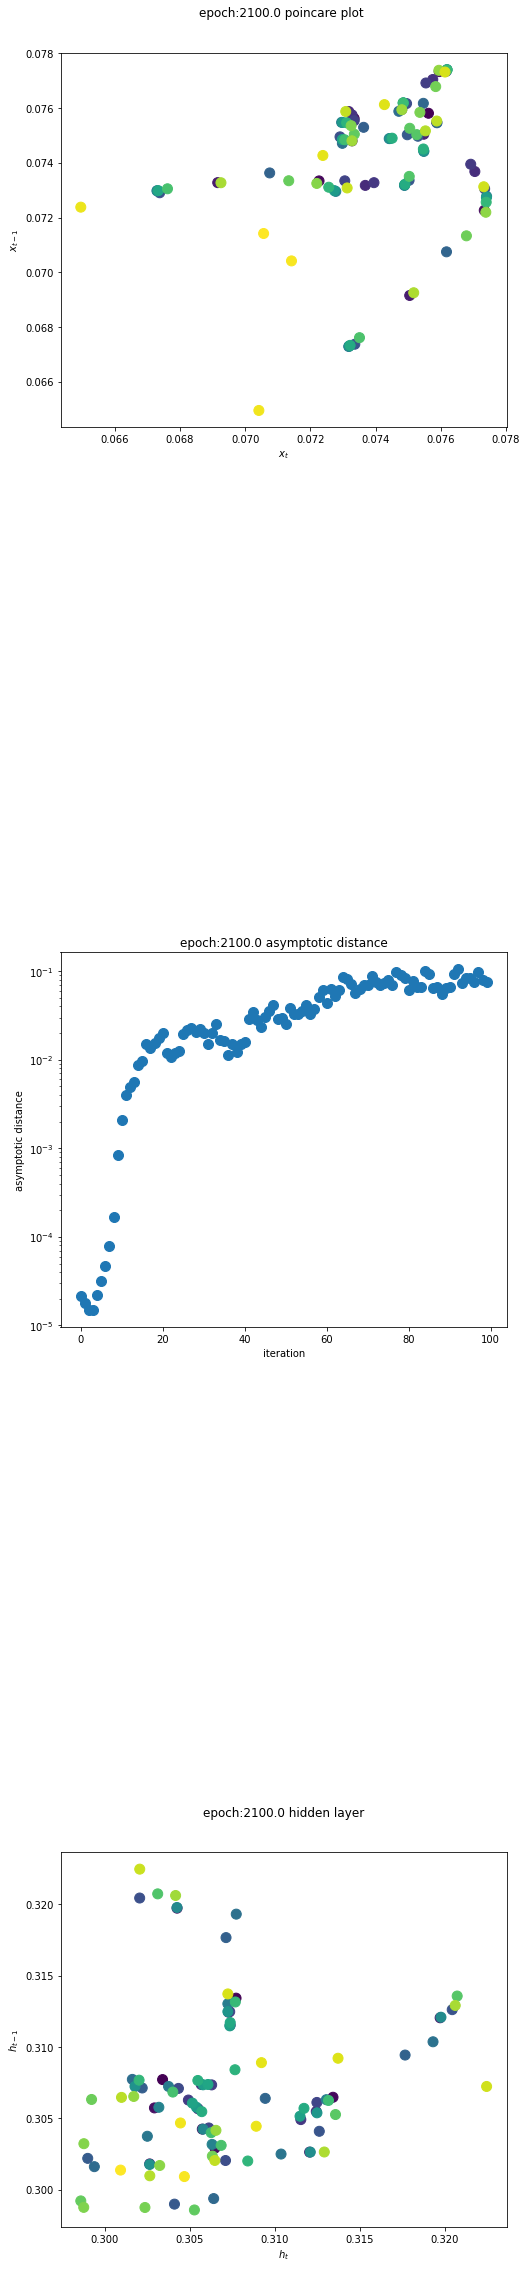

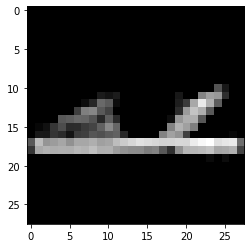

asymptotic image output epoch:2100.jpg
epoch : 2101/10000, training loss = 0.014457,validation loss = 0.019128
epoch : 2102/10000, training loss = 0.014670,validation loss = 0.019174
epoch : 2103/10000, training loss = 0.014589,validation loss = 0.019309
epoch : 2104/10000, training loss = 0.014723,validation loss = 0.019203
epoch : 2105/10000, training loss = 0.014548,validation loss = 0.019183
epoch : 2106/10000, training loss = 0.014555,validation loss = 0.019203
epoch : 2107/10000, training loss = 0.014536,validation loss = 0.019322
epoch : 2108/10000, training loss = 0.014860,validation loss = 0.019228
epoch : 2109/10000, training loss = 0.014668,validation loss = 0.019354
epoch : 2110/10000, training loss = 0.014530,validation loss = 0.019313
epoch : 2111/10000, training loss = 0.014602,validation loss = 0.019248
epoch : 2112/10000, training loss = 0.014653,validation loss = 0.019221
epoch : 2113/10000, training loss = 0.014704,validation loss = 0.019110
epoch : 2114/10000, train

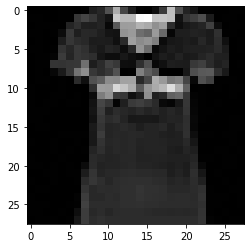

asymptotic image input epoch:2150.jpg


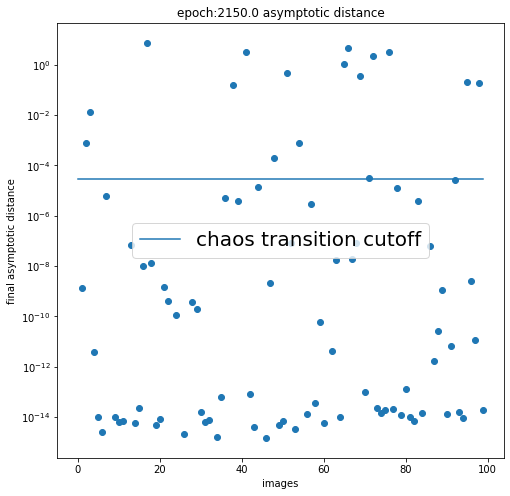

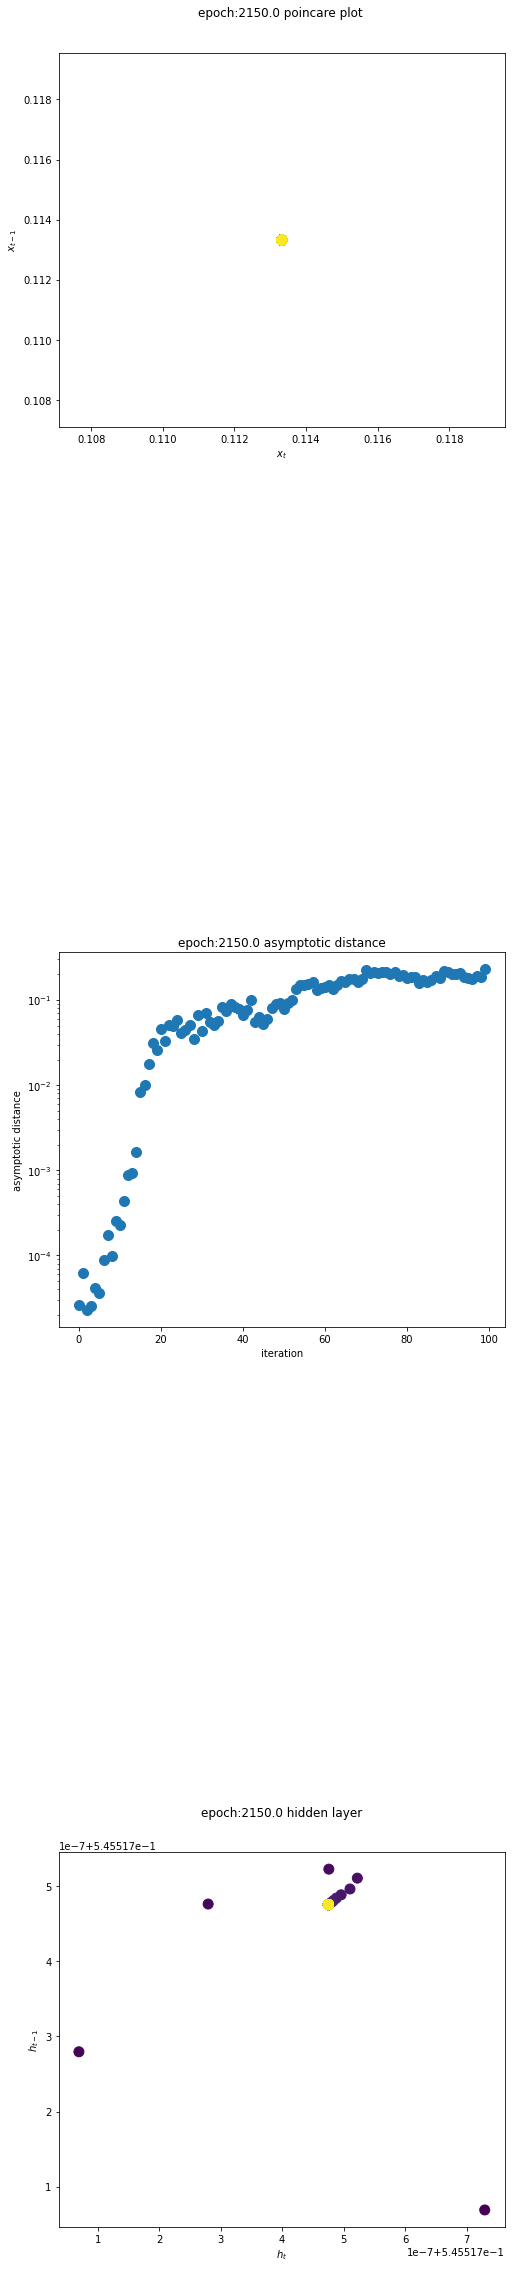

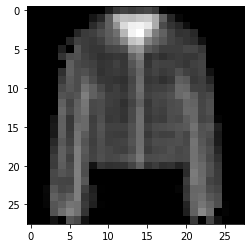

asymptotic image output epoch:2150.jpg
epoch : 2151/10000, training loss = 0.014675,validation loss = 0.019194
epoch : 2152/10000, training loss = 0.014533,validation loss = 0.019163
epoch : 2153/10000, training loss = 0.014522,validation loss = 0.019150
epoch : 2154/10000, training loss = 0.014679,validation loss = 0.019191
epoch : 2155/10000, training loss = 0.014607,validation loss = 0.019192
epoch : 2156/10000, training loss = 0.014529,validation loss = 0.019228
epoch : 2157/10000, training loss = 0.014567,validation loss = 0.019190
epoch : 2158/10000, training loss = 0.014555,validation loss = 0.019230
epoch : 2159/10000, training loss = 0.014578,validation loss = 0.019277
epoch : 2160/10000, training loss = 0.014676,validation loss = 0.019377
epoch : 2161/10000, training loss = 0.014559,validation loss = 0.019285
epoch : 2162/10000, training loss = 0.014619,validation loss = 0.019264
epoch : 2163/10000, training loss = 0.014767,validation loss = 0.019356
epoch : 2164/10000, train

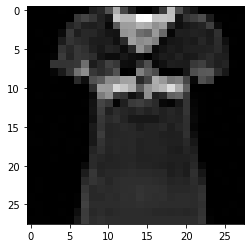

asymptotic image input epoch:2200.jpg


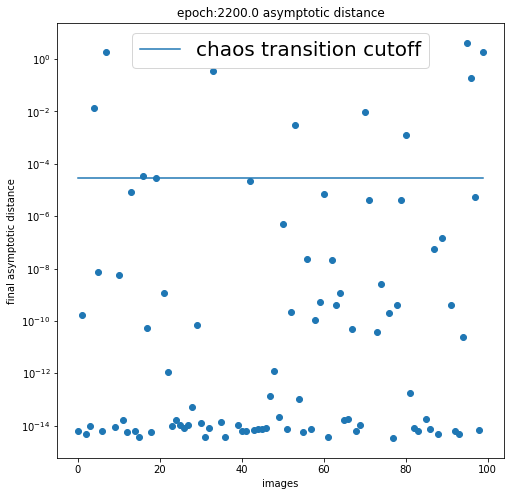

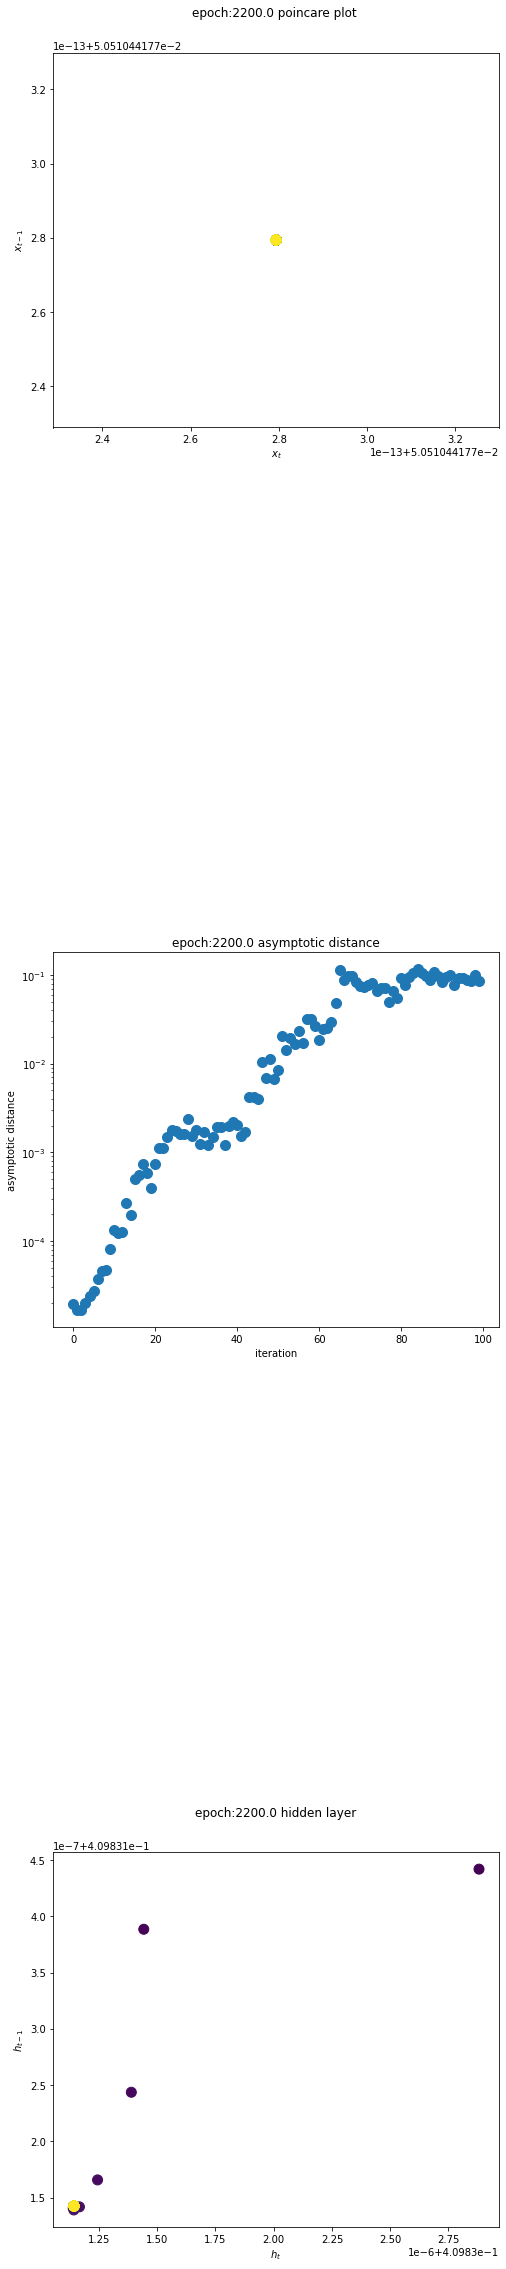

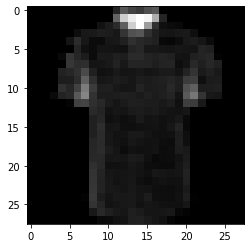

asymptotic image output epoch:2200.jpg
epoch : 2201/10000, training loss = 0.014632,validation loss = 0.019276
epoch : 2202/10000, training loss = 0.014722,validation loss = 0.019282
epoch : 2203/10000, training loss = 0.014646,validation loss = 0.019640
epoch : 2204/10000, training loss = 0.014852,validation loss = 0.019202
epoch : 2205/10000, training loss = 0.014542,validation loss = 0.019256
epoch : 2206/10000, training loss = 0.014562,validation loss = 0.019248
epoch : 2207/10000, training loss = 0.014814,validation loss = 0.019457
epoch : 2208/10000, training loss = 0.014772,validation loss = 0.019242
epoch : 2209/10000, training loss = 0.014720,validation loss = 0.019227
epoch : 2210/10000, training loss = 0.014552,validation loss = 0.019160
epoch : 2211/10000, training loss = 0.014711,validation loss = 0.019254
epoch : 2212/10000, training loss = 0.014839,validation loss = 0.019388
epoch : 2213/10000, training loss = 0.014791,validation loss = 0.019163
epoch : 2214/10000, train

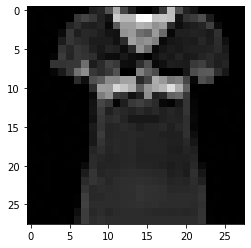

asymptotic image input epoch:2250.jpg


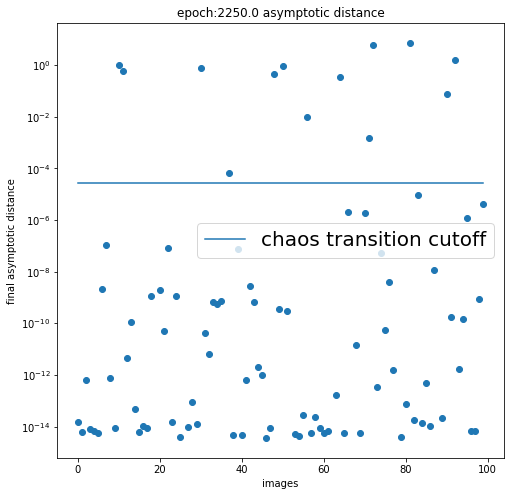

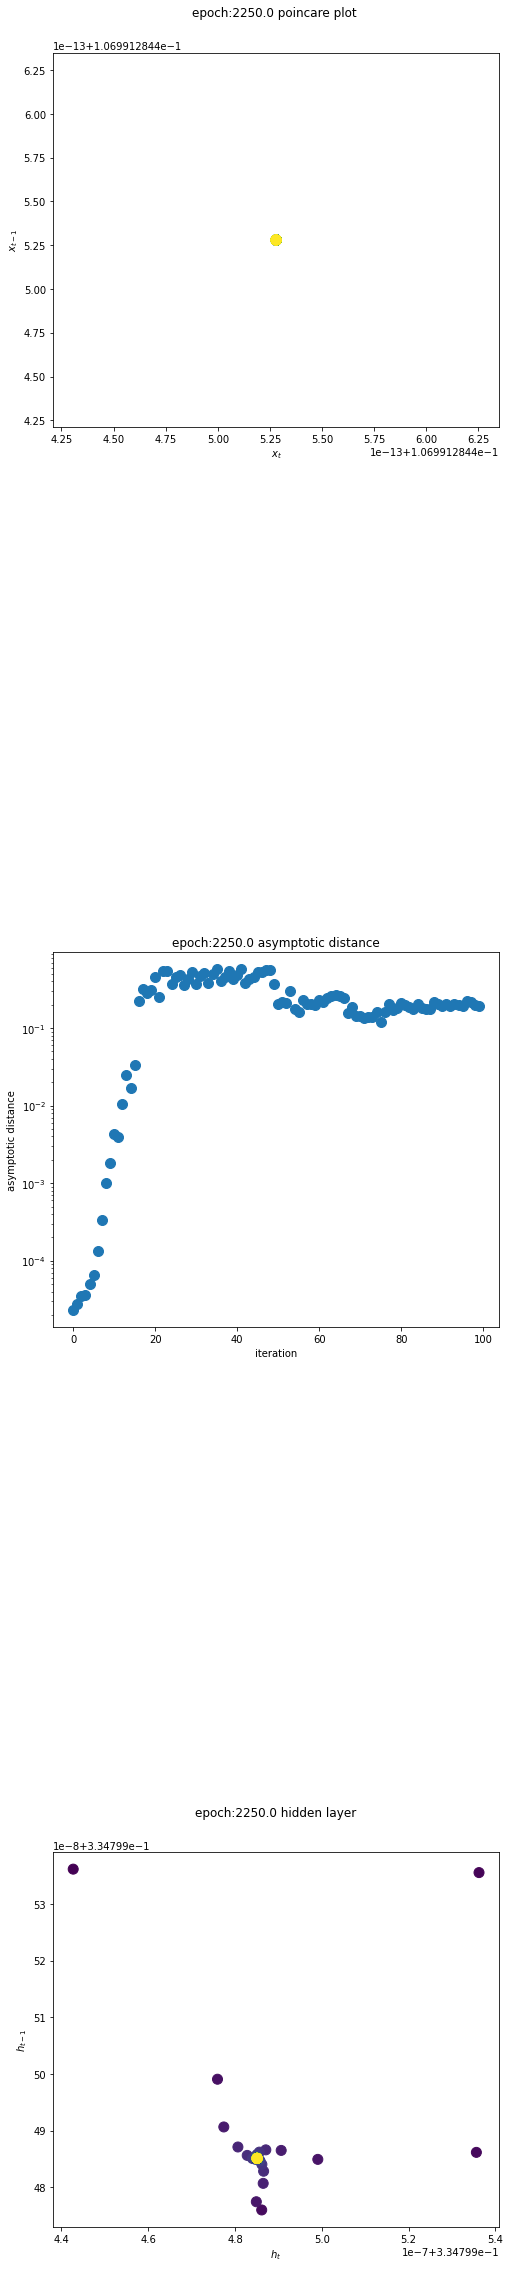

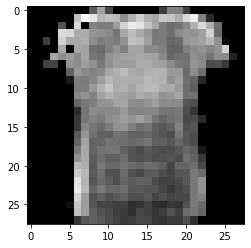

asymptotic image output epoch:2250.jpg
epoch : 2251/10000, training loss = 0.014811,validation loss = 0.019299
epoch : 2252/10000, training loss = 0.014687,validation loss = 0.019173
epoch : 2253/10000, training loss = 0.014792,validation loss = 0.019420
epoch : 2254/10000, training loss = 0.014771,validation loss = 0.019228
epoch : 2255/10000, training loss = 0.014798,validation loss = 0.019355
epoch : 2256/10000, training loss = 0.014831,validation loss = 0.019572
epoch : 2257/10000, training loss = 0.014964,validation loss = 0.019269
epoch : 2258/10000, training loss = 0.014701,validation loss = 0.019377
epoch : 2259/10000, training loss = 0.014875,validation loss = 0.019349
epoch : 2260/10000, training loss = 0.014765,validation loss = 0.019266
epoch : 2261/10000, training loss = 0.014592,validation loss = 0.019312
epoch : 2262/10000, training loss = 0.015040,validation loss = 0.019552
epoch : 2263/10000, training loss = 0.014813,validation loss = 0.019084
epoch : 2264/10000, train

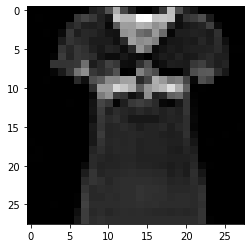

asymptotic image input epoch:2300.jpg


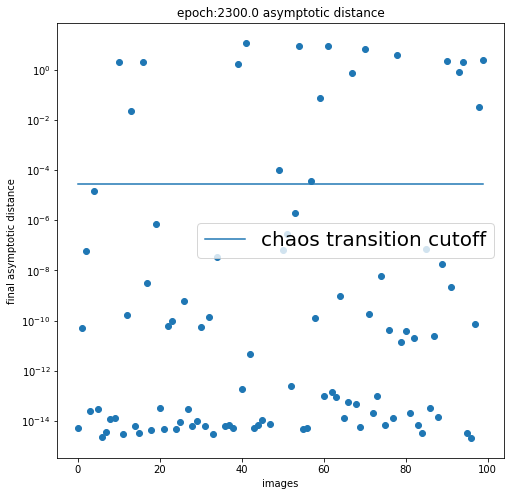

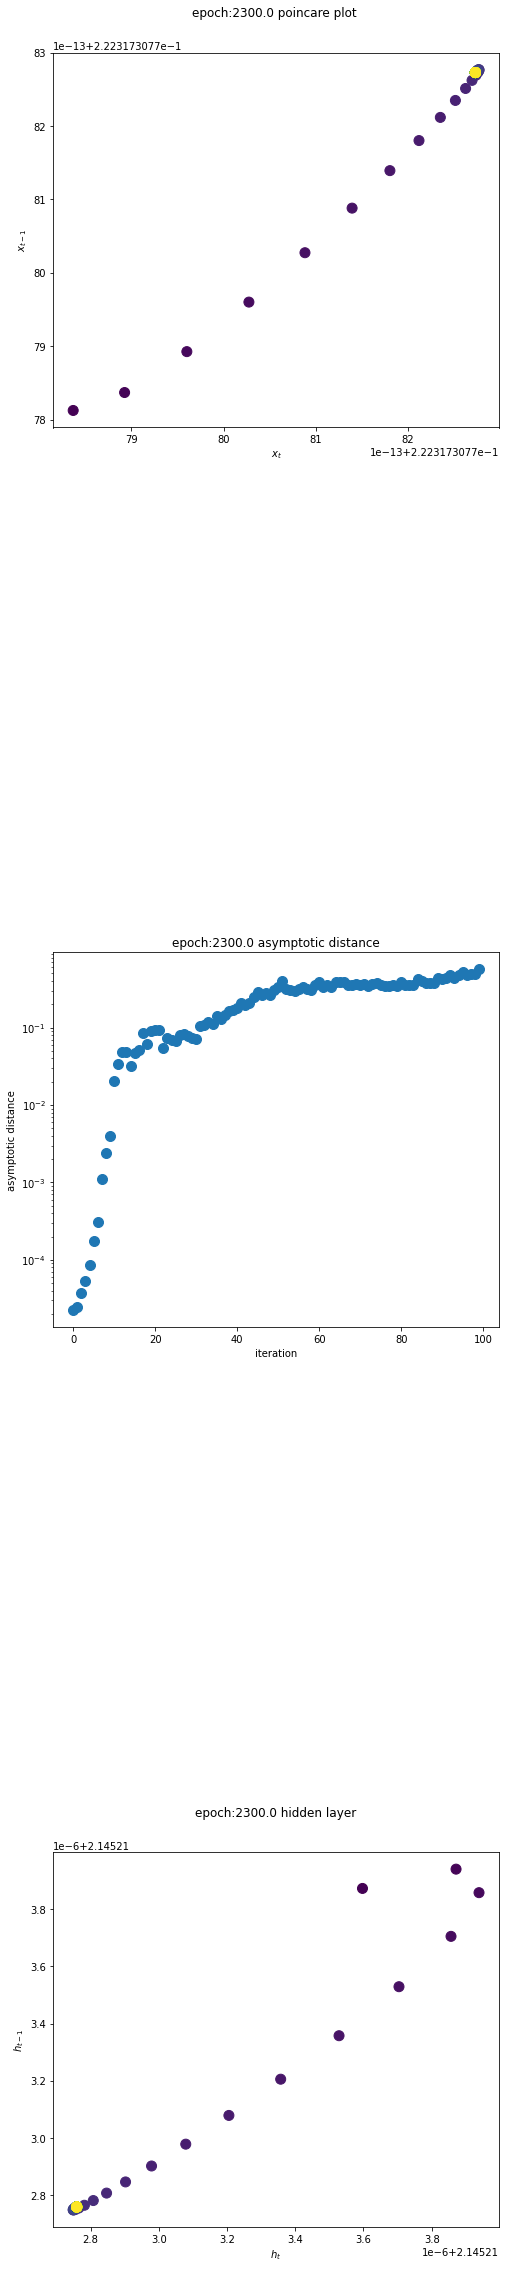

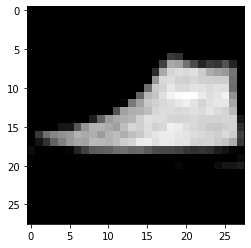

asymptotic image output epoch:2300.jpg
epoch : 2301/10000, training loss = 0.014580,validation loss = 0.019221
epoch : 2302/10000, training loss = 0.014794,validation loss = 0.019402
epoch : 2303/10000, training loss = 0.014612,validation loss = 0.019342
epoch : 2304/10000, training loss = 0.014704,validation loss = 0.019287
epoch : 2305/10000, training loss = 0.014612,validation loss = 0.019261
epoch : 2306/10000, training loss = 0.014585,validation loss = 0.019267
epoch : 2307/10000, training loss = 0.014675,validation loss = 0.019234
epoch : 2308/10000, training loss = 0.014629,validation loss = 0.019288
epoch : 2309/10000, training loss = 0.014632,validation loss = 0.019462
epoch : 2310/10000, training loss = 0.014677,validation loss = 0.019380
epoch : 2311/10000, training loss = 0.014637,validation loss = 0.019191
epoch : 2312/10000, training loss = 0.014693,validation loss = 0.019289
epoch : 2313/10000, training loss = 0.014527,validation loss = 0.019270
epoch : 2314/10000, train

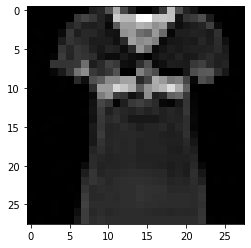

asymptotic image input epoch:2350.jpg


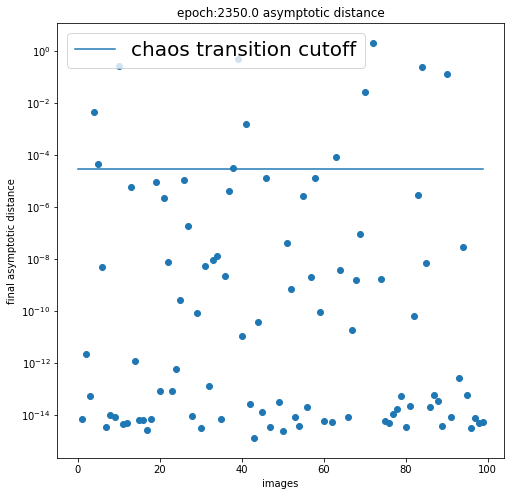

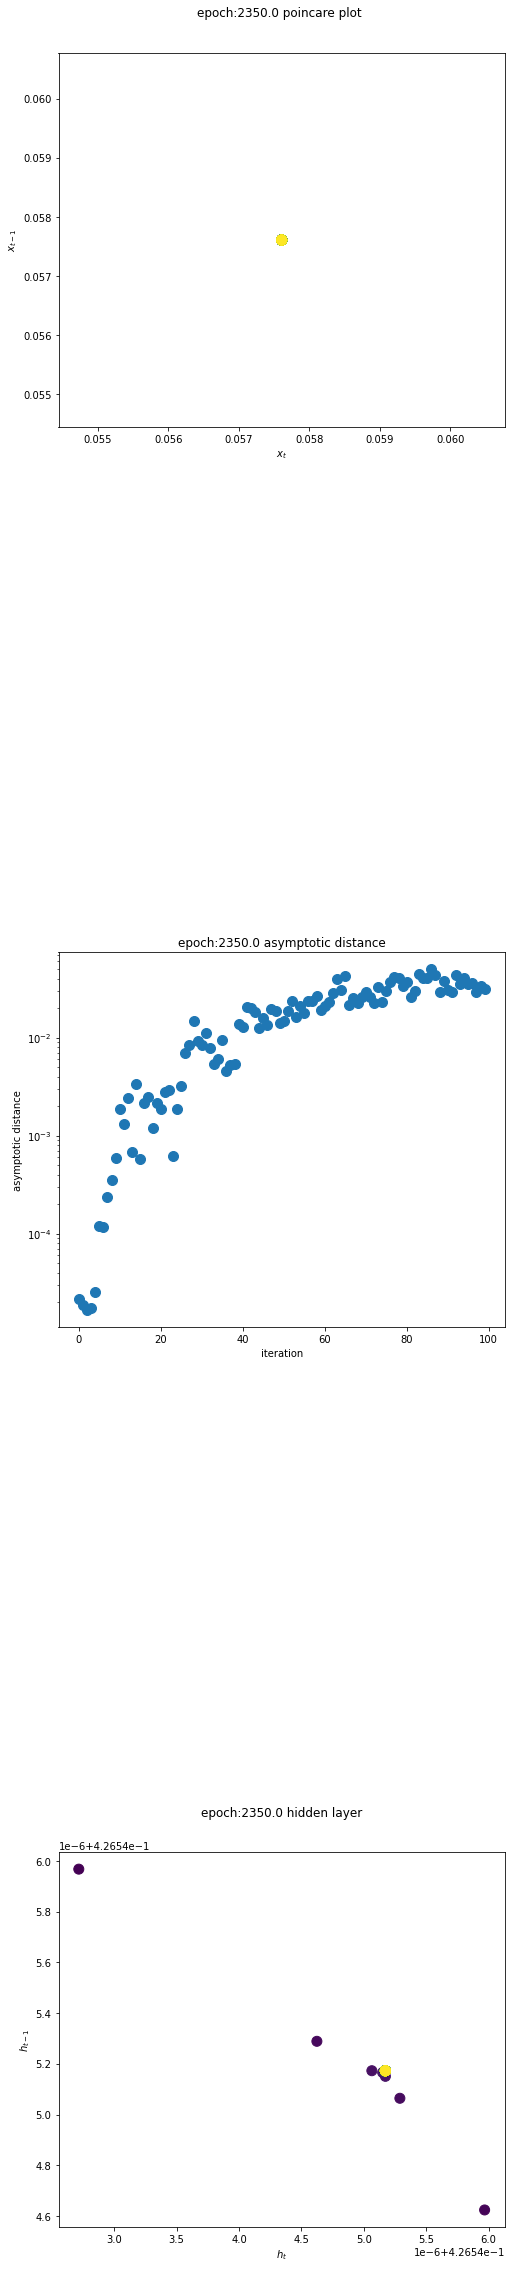

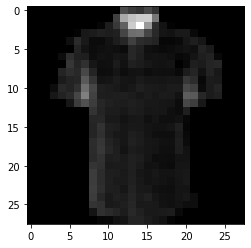

asymptotic image output epoch:2350.jpg
epoch : 2351/10000, training loss = 0.014691,validation loss = 0.019296
epoch : 2352/10000, training loss = 0.014837,validation loss = 0.019287
epoch : 2353/10000, training loss = 0.014563,validation loss = 0.019272
epoch : 2354/10000, training loss = 0.014565,validation loss = 0.019264
epoch : 2355/10000, training loss = 0.014477,validation loss = 0.019267
epoch : 2356/10000, training loss = 0.014485,validation loss = 0.019373
epoch : 2357/10000, training loss = 0.014854,validation loss = 0.019336
epoch : 2358/10000, training loss = 0.014594,validation loss = 0.019222
epoch : 2359/10000, training loss = 0.014571,validation loss = 0.019342
epoch : 2360/10000, training loss = 0.014704,validation loss = 0.019301
epoch : 2361/10000, training loss = 0.014790,validation loss = 0.019316
epoch : 2362/10000, training loss = 0.014671,validation loss = 0.019432
epoch : 2363/10000, training loss = 0.014692,validation loss = 0.019254
epoch : 2364/10000, train

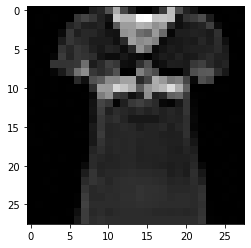

asymptotic image input epoch:2400.jpg


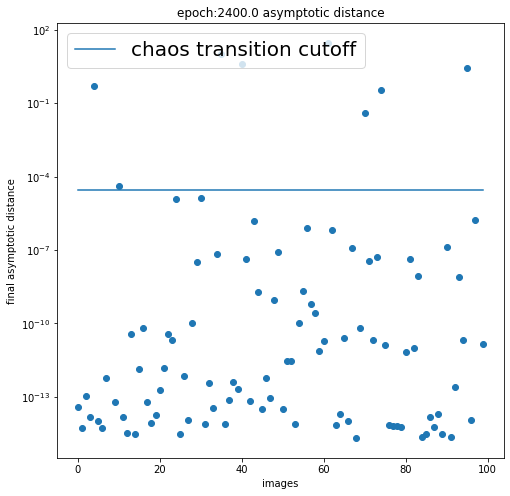

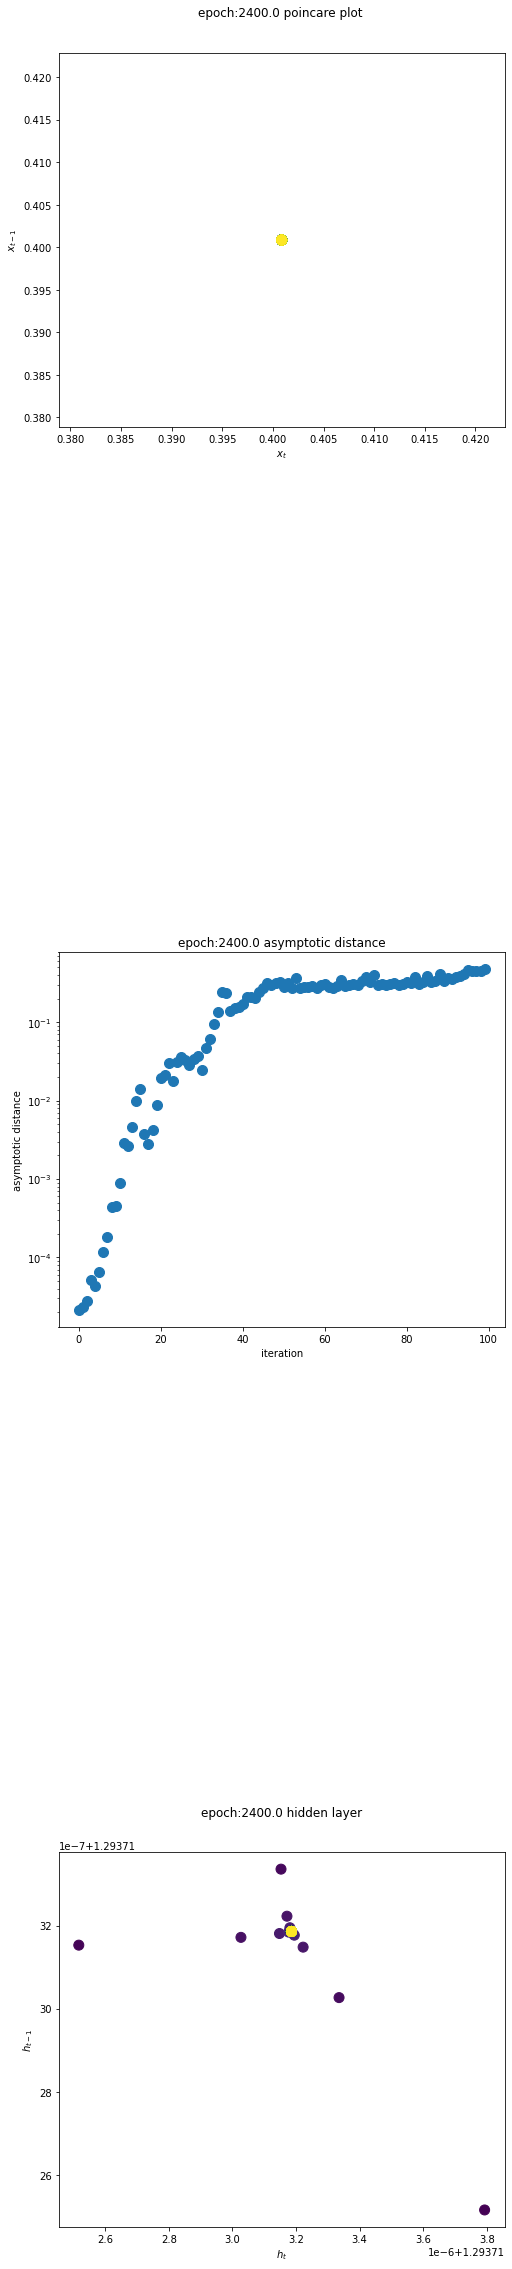

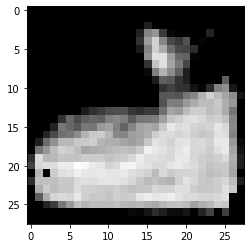

asymptotic image output epoch:2400.jpg
epoch : 2401/10000, training loss = 0.014696,validation loss = 0.019358
epoch : 2402/10000, training loss = 0.014866,validation loss = 0.019557
epoch : 2403/10000, training loss = 0.014842,validation loss = 0.019366
epoch : 2404/10000, training loss = 0.014616,validation loss = 0.019216
epoch : 2405/10000, training loss = 0.014571,validation loss = 0.019469
epoch : 2406/10000, training loss = 0.014678,validation loss = 0.019233
epoch : 2407/10000, training loss = 0.014616,validation loss = 0.019299
epoch : 2408/10000, training loss = 0.014658,validation loss = 0.019409
epoch : 2409/10000, training loss = 0.014767,validation loss = 0.019347
epoch : 2410/10000, training loss = 0.014625,validation loss = 0.019361
epoch : 2411/10000, training loss = 0.014850,validation loss = 0.019329
epoch : 2412/10000, training loss = 0.014824,validation loss = 0.019517
epoch : 2413/10000, training loss = 0.014723,validation loss = 0.019301
epoch : 2414/10000, train

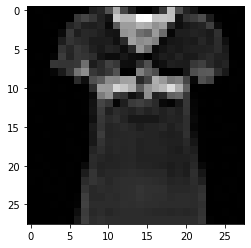

asymptotic image input epoch:2450.jpg


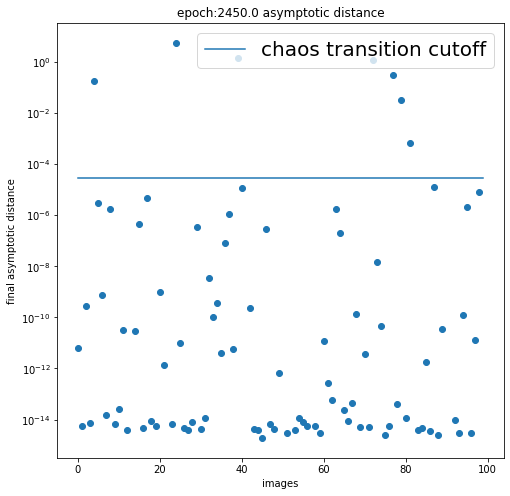

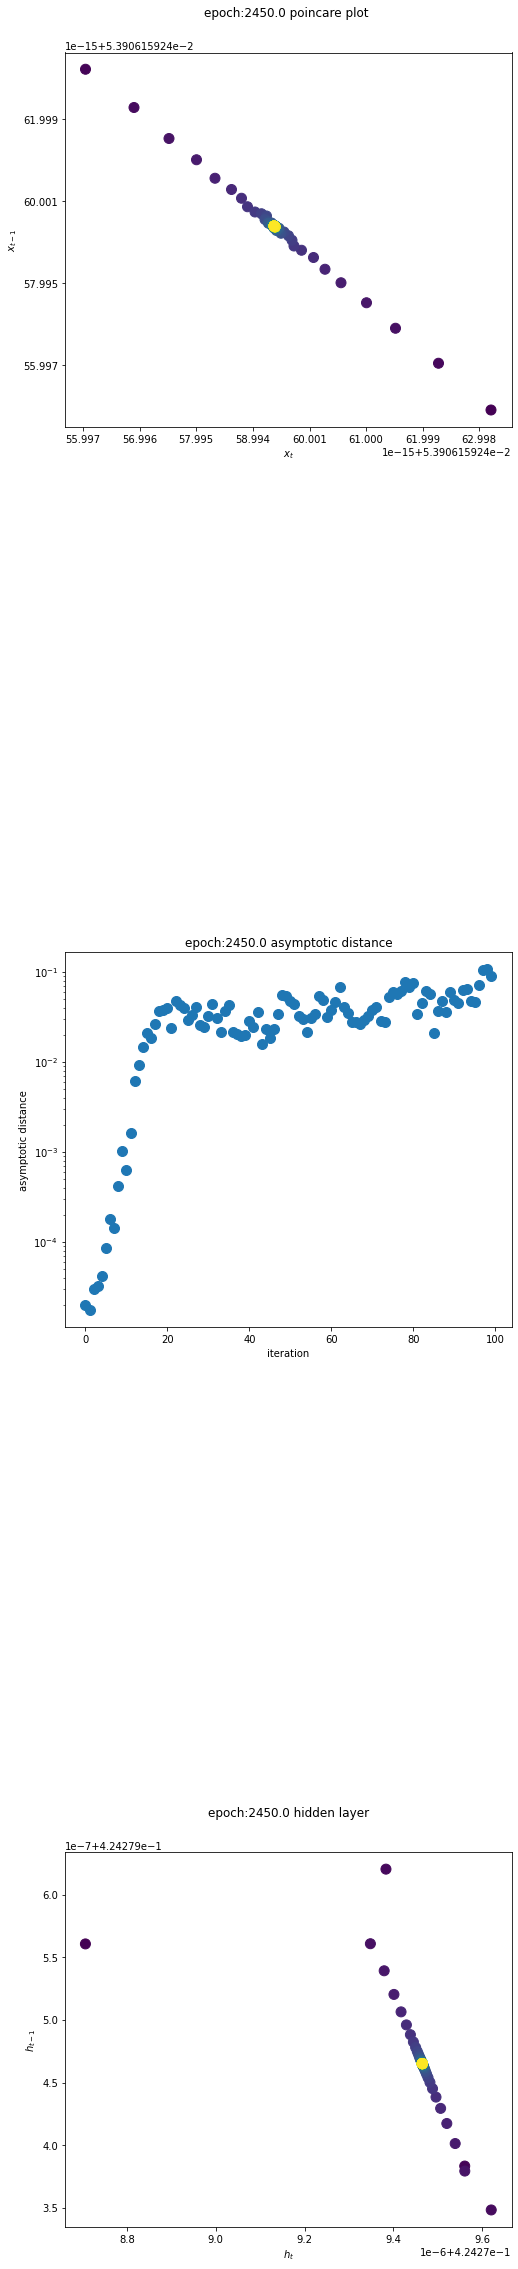

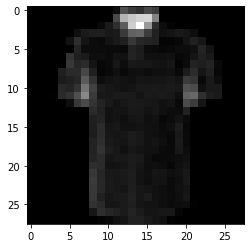

asymptotic image output epoch:2450.jpg
epoch : 2451/10000, training loss = 0.014485,validation loss = 0.019309
epoch : 2452/10000, training loss = 0.014652,validation loss = 0.019443
epoch : 2453/10000, training loss = 0.014676,validation loss = 0.019356
epoch : 2454/10000, training loss = 0.014530,validation loss = 0.019329
epoch : 2455/10000, training loss = 0.014620,validation loss = 0.019343
epoch : 2456/10000, training loss = 0.014666,validation loss = 0.019443
epoch : 2457/10000, training loss = 0.014547,validation loss = 0.019378
epoch : 2458/10000, training loss = 0.014513,validation loss = 0.019336
epoch : 2459/10000, training loss = 0.014629,validation loss = 0.019465
epoch : 2460/10000, training loss = 0.014702,validation loss = 0.019518
epoch : 2461/10000, training loss = 0.014717,validation loss = 0.019354
epoch : 2462/10000, training loss = 0.014730,validation loss = 0.019368
epoch : 2463/10000, training loss = 0.014723,validation loss = 0.019454
epoch : 2464/10000, train

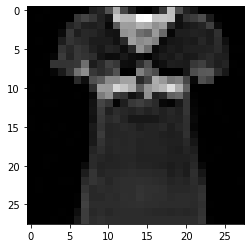

asymptotic image input epoch:2500.jpg


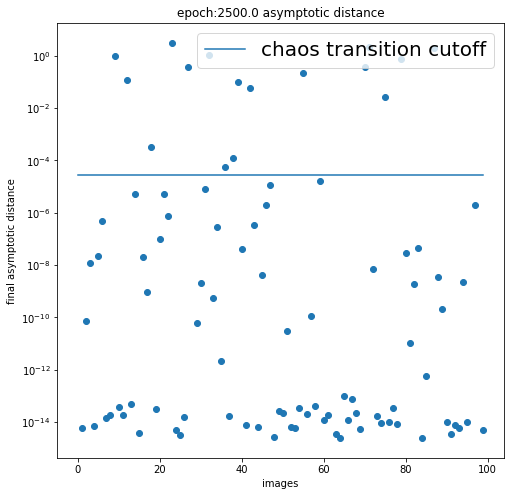

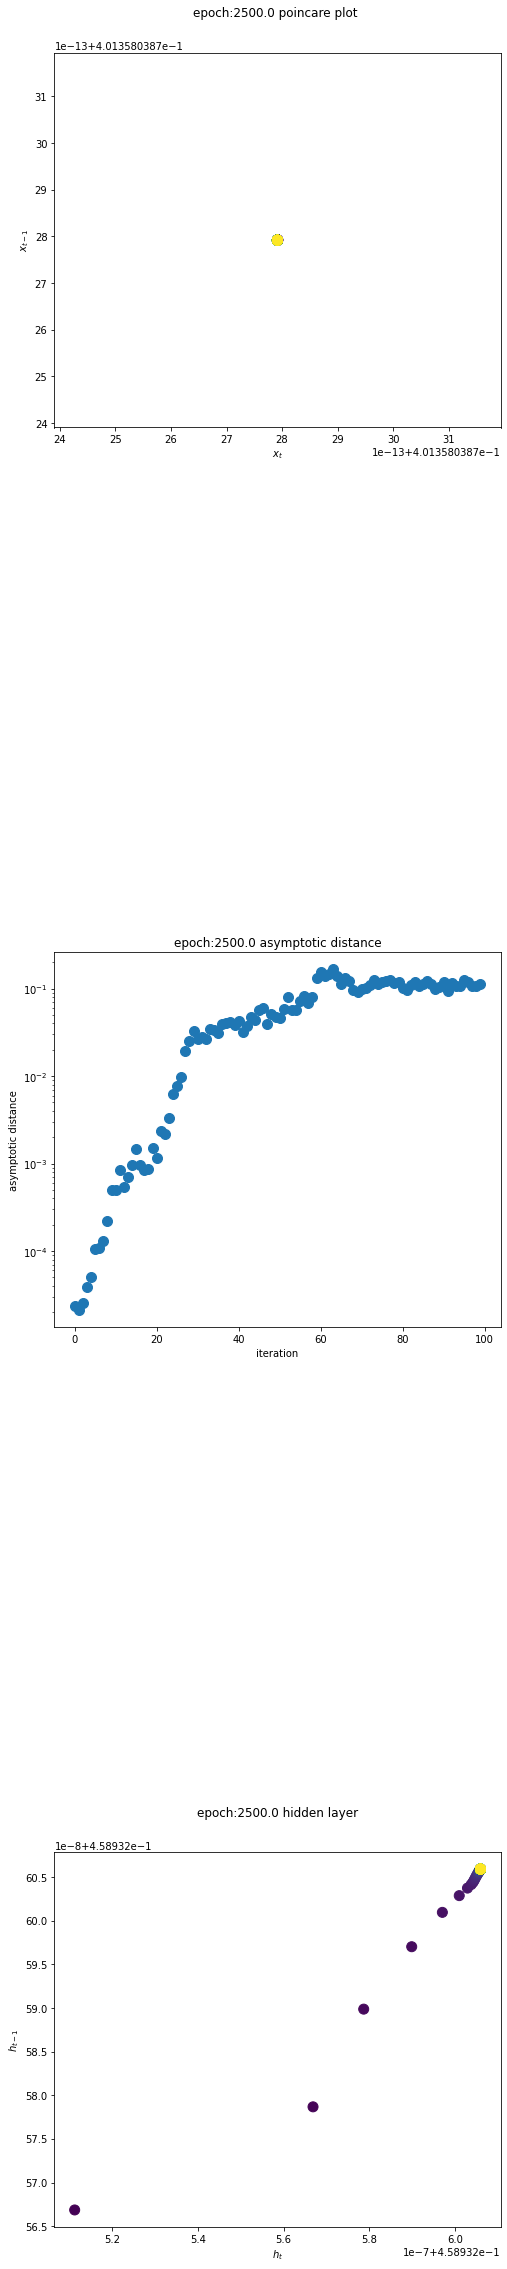

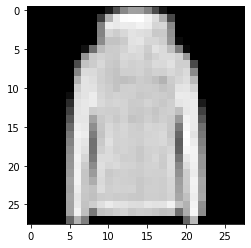

asymptotic image output epoch:2500.jpg
epoch : 2501/10000, training loss = 0.014617,validation loss = 0.019504
epoch : 2502/10000, training loss = 0.014555,validation loss = 0.019448
epoch : 2503/10000, training loss = 0.014656,validation loss = 0.019395
epoch : 2504/10000, training loss = 0.014988,validation loss = 0.019229
epoch : 2505/10000, training loss = 0.014591,validation loss = 0.019430
epoch : 2506/10000, training loss = 0.014528,validation loss = 0.019441
epoch : 2507/10000, training loss = 0.014647,validation loss = 0.019336
epoch : 2508/10000, training loss = 0.014712,validation loss = 0.019237
epoch : 2509/10000, training loss = 0.014497,validation loss = 0.019254
epoch : 2510/10000, training loss = 0.014611,validation loss = 0.019417
epoch : 2511/10000, training loss = 0.014637,validation loss = 0.019406
epoch : 2512/10000, training loss = 0.014688,validation loss = 0.019347
epoch : 2513/10000, training loss = 0.014615,validation loss = 0.019388
epoch : 2514/10000, train

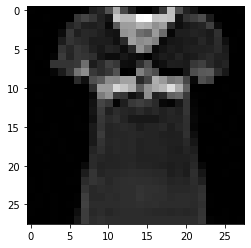

asymptotic image input epoch:2550.jpg


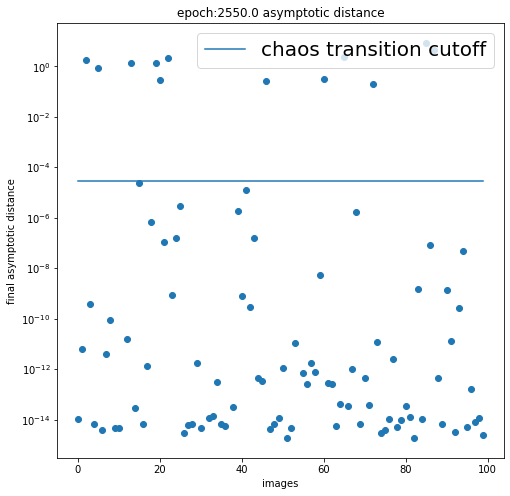

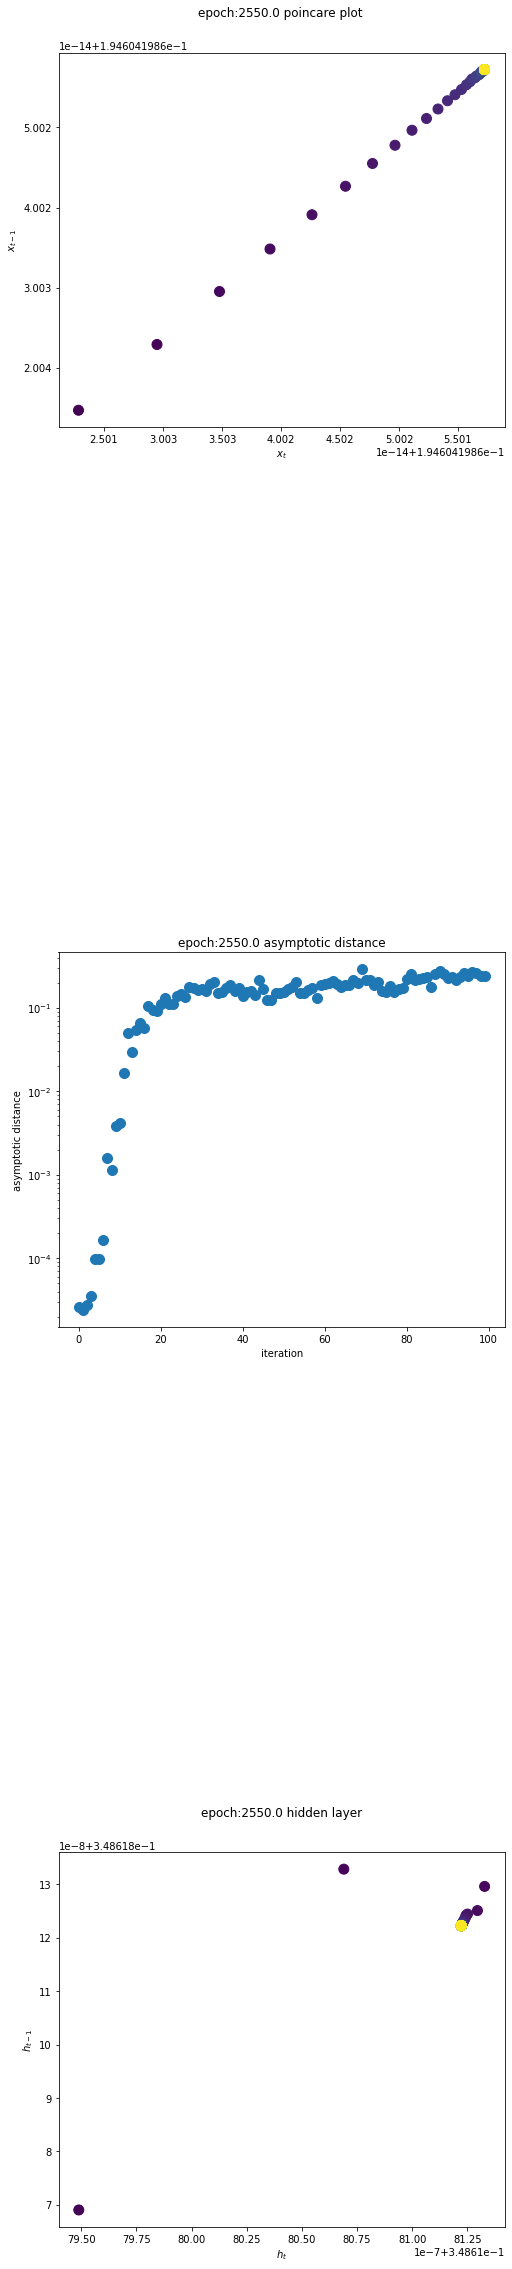

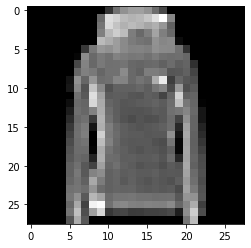

asymptotic image output epoch:2550.jpg
epoch : 2551/10000, training loss = 0.014851,validation loss = 0.019374
epoch : 2552/10000, training loss = 0.014699,validation loss = 0.019360
epoch : 2553/10000, training loss = 0.014836,validation loss = 0.019345
epoch : 2554/10000, training loss = 0.014608,validation loss = 0.019195
epoch : 2555/10000, training loss = 0.014681,validation loss = 0.019366
epoch : 2556/10000, training loss = 0.014643,validation loss = 0.019316
epoch : 2557/10000, training loss = 0.014584,validation loss = 0.019484
epoch : 2558/10000, training loss = 0.014791,validation loss = 0.019346
epoch : 2559/10000, training loss = 0.014694,validation loss = 0.019347
epoch : 2560/10000, training loss = 0.014496,validation loss = 0.019343
epoch : 2561/10000, training loss = 0.014581,validation loss = 0.019289
epoch : 2562/10000, training loss = 0.014610,validation loss = 0.019333
epoch : 2563/10000, training loss = 0.014607,validation loss = 0.019386
epoch : 2564/10000, train

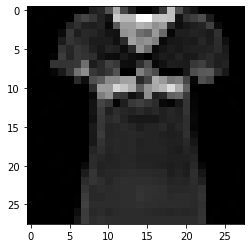

asymptotic image input epoch:2600.jpg


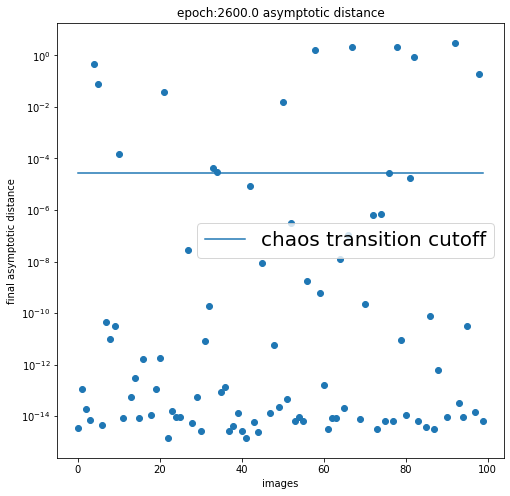

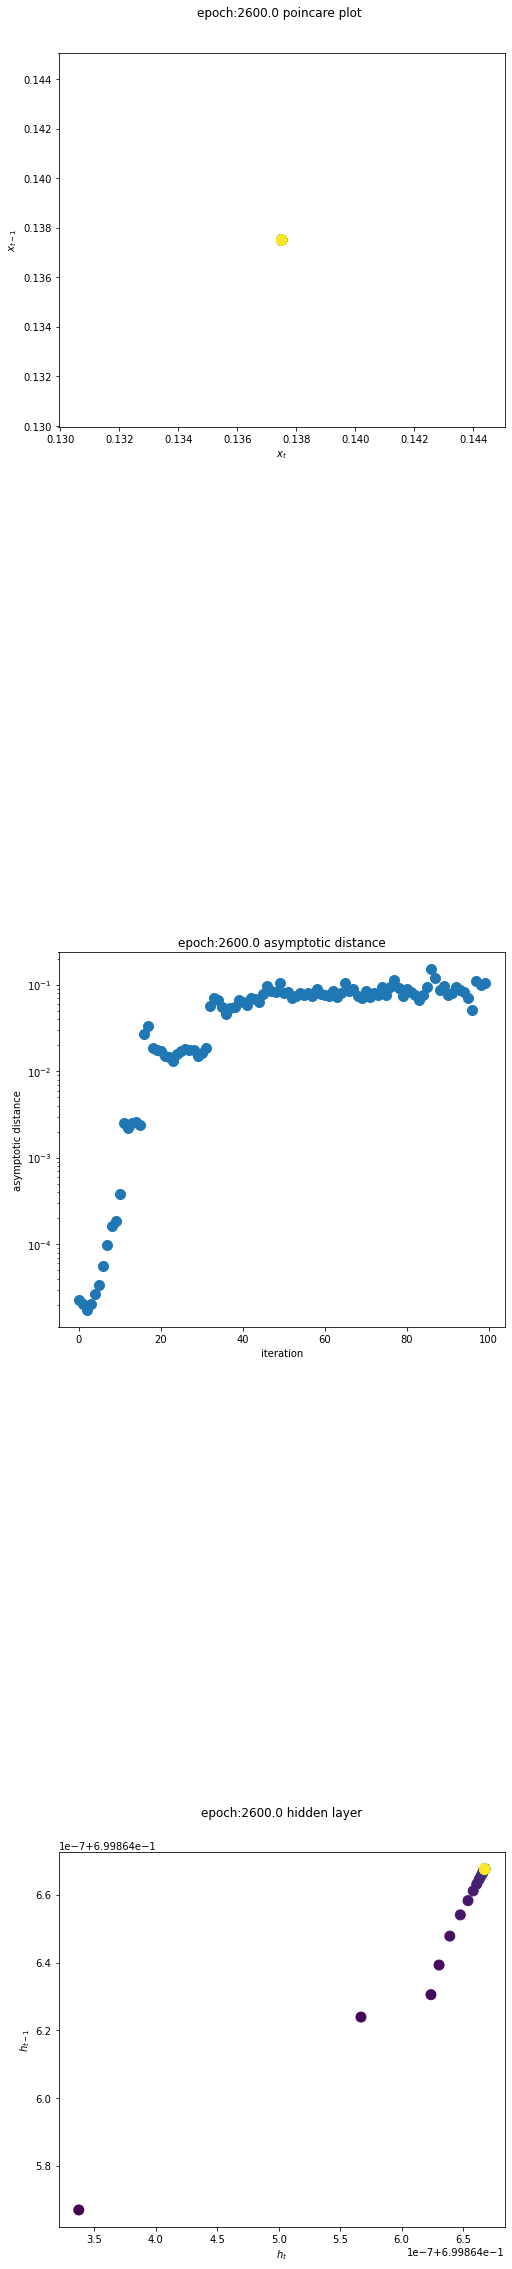

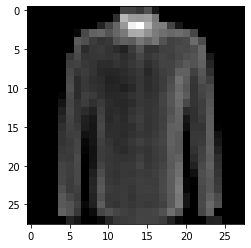

asymptotic image output epoch:2600.jpg
epoch : 2601/10000, training loss = 0.014589,validation loss = 0.019430
epoch : 2602/10000, training loss = 0.014602,validation loss = 0.019464
epoch : 2603/10000, training loss = 0.014771,validation loss = 0.019438
epoch : 2604/10000, training loss = 0.014511,validation loss = 0.019420
epoch : 2605/10000, training loss = 0.014437,validation loss = 0.019809
epoch : 2606/10000, training loss = 0.014743,validation loss = 0.019369
epoch : 2607/10000, training loss = 0.014748,validation loss = 0.019418
epoch : 2608/10000, training loss = 0.014741,validation loss = 0.019409
epoch : 2609/10000, training loss = 0.014777,validation loss = 0.019382
epoch : 2610/10000, training loss = 0.014754,validation loss = 0.019391
epoch : 2611/10000, training loss = 0.014666,validation loss = 0.019386
epoch : 2612/10000, training loss = 0.014732,validation loss = 0.019542
epoch : 2613/10000, training loss = 0.014525,validation loss = 0.019493
epoch : 2614/10000, train

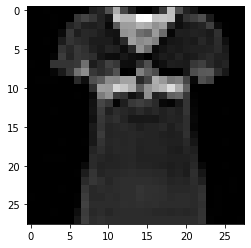

asymptotic image input epoch:2650.jpg


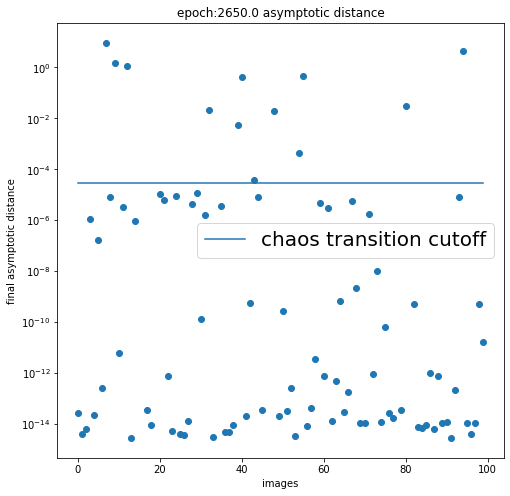

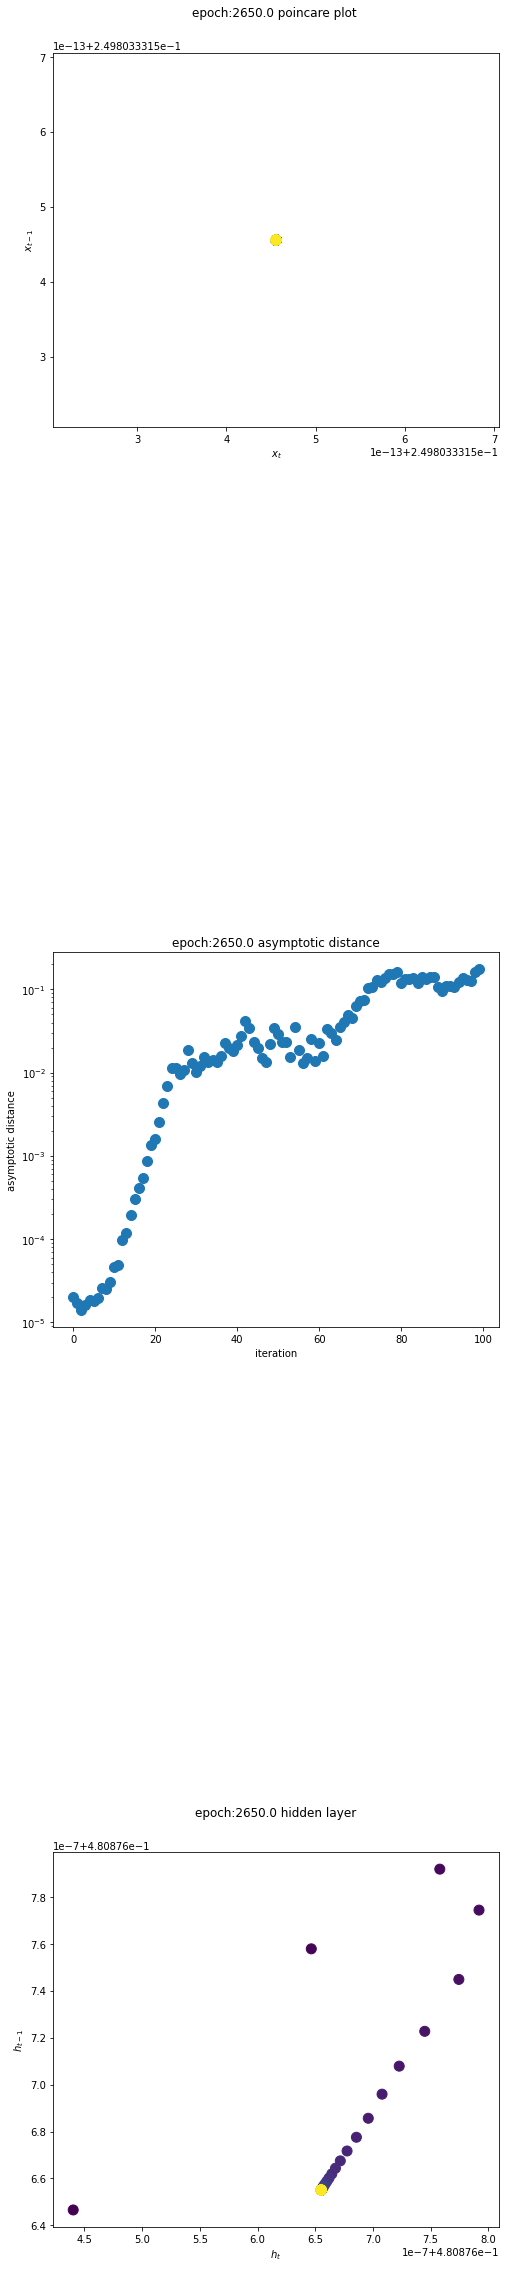

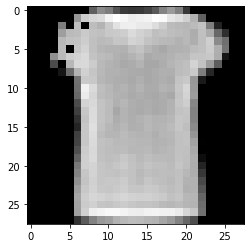

asymptotic image output epoch:2650.jpg
epoch : 2651/10000, training loss = 0.014573,validation loss = 0.019662
epoch : 2652/10000, training loss = 0.014656,validation loss = 0.019361
epoch : 2653/10000, training loss = 0.014482,validation loss = 0.019572
epoch : 2654/10000, training loss = 0.014698,validation loss = 0.019459
epoch : 2655/10000, training loss = 0.014677,validation loss = 0.019607
epoch : 2656/10000, training loss = 0.014843,validation loss = 0.019538
epoch : 2657/10000, training loss = 0.014621,validation loss = 0.019442
epoch : 2658/10000, training loss = 0.014579,validation loss = 0.019479
epoch : 2659/10000, training loss = 0.014678,validation loss = 0.019510
epoch : 2660/10000, training loss = 0.014695,validation loss = 0.019338
epoch : 2661/10000, training loss = 0.014613,validation loss = 0.019321
epoch : 2662/10000, training loss = 0.014700,validation loss = 0.019424
epoch : 2663/10000, training loss = 0.014908,validation loss = 0.019341
epoch : 2664/10000, train

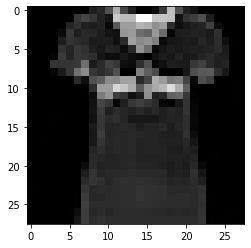

asymptotic image input epoch:2700.jpg


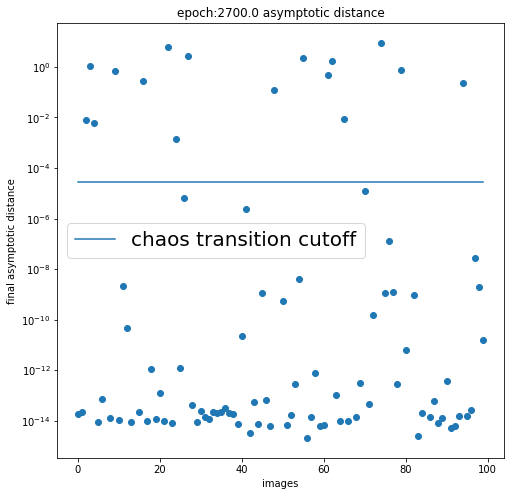

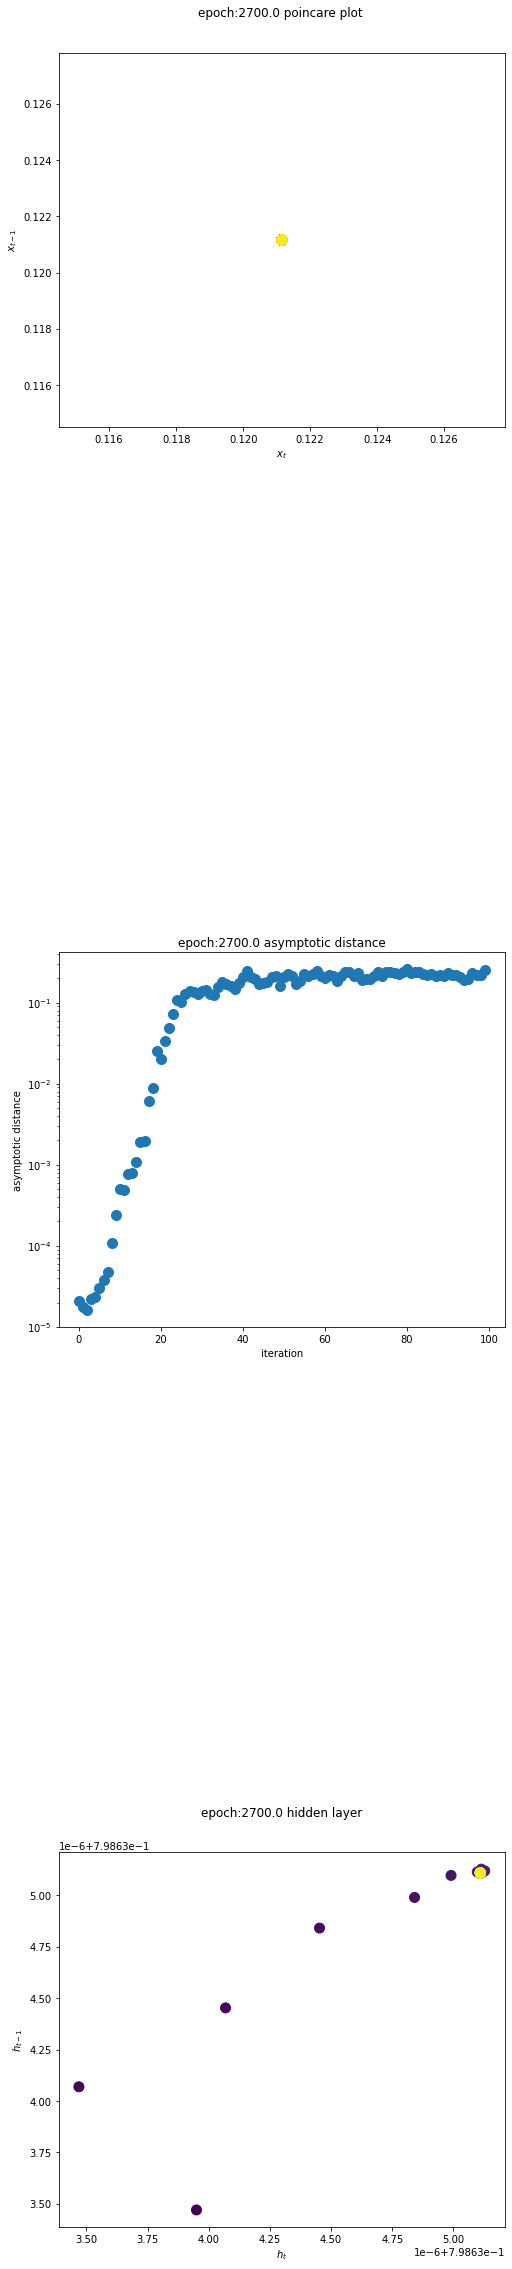

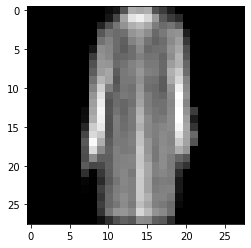

asymptotic image output epoch:2700.jpg
epoch : 2701/10000, training loss = 0.015035,validation loss = 0.019445
epoch : 2702/10000, training loss = 0.014694,validation loss = 0.019342
epoch : 2703/10000, training loss = 0.014609,validation loss = 0.019539
epoch : 2704/10000, training loss = 0.014585,validation loss = 0.019562
epoch : 2705/10000, training loss = 0.014564,validation loss = 0.019414
epoch : 2706/10000, training loss = 0.014668,validation loss = 0.019686
epoch : 2707/10000, training loss = 0.014773,validation loss = 0.019375
epoch : 2708/10000, training loss = 0.014701,validation loss = 0.019459
epoch : 2709/10000, training loss = 0.014676,validation loss = 0.019367
epoch : 2710/10000, training loss = 0.014649,validation loss = 0.019347
epoch : 2711/10000, training loss = 0.014513,validation loss = 0.019419
epoch : 2712/10000, training loss = 0.014667,validation loss = 0.019453
epoch : 2713/10000, training loss = 0.014723,validation loss = 0.019572
epoch : 2714/10000, train

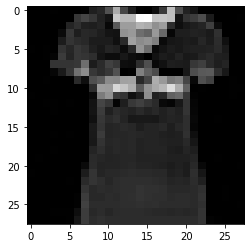

asymptotic image input epoch:2750.jpg


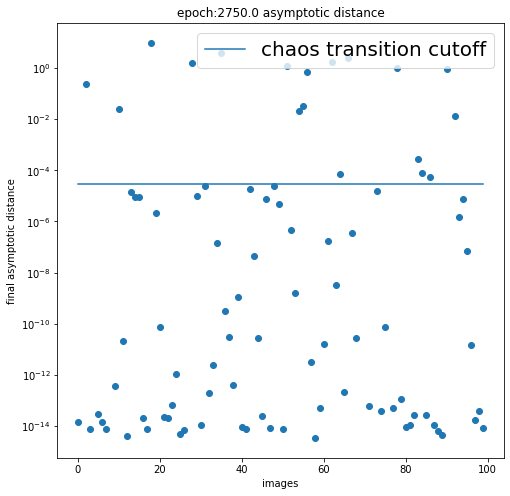

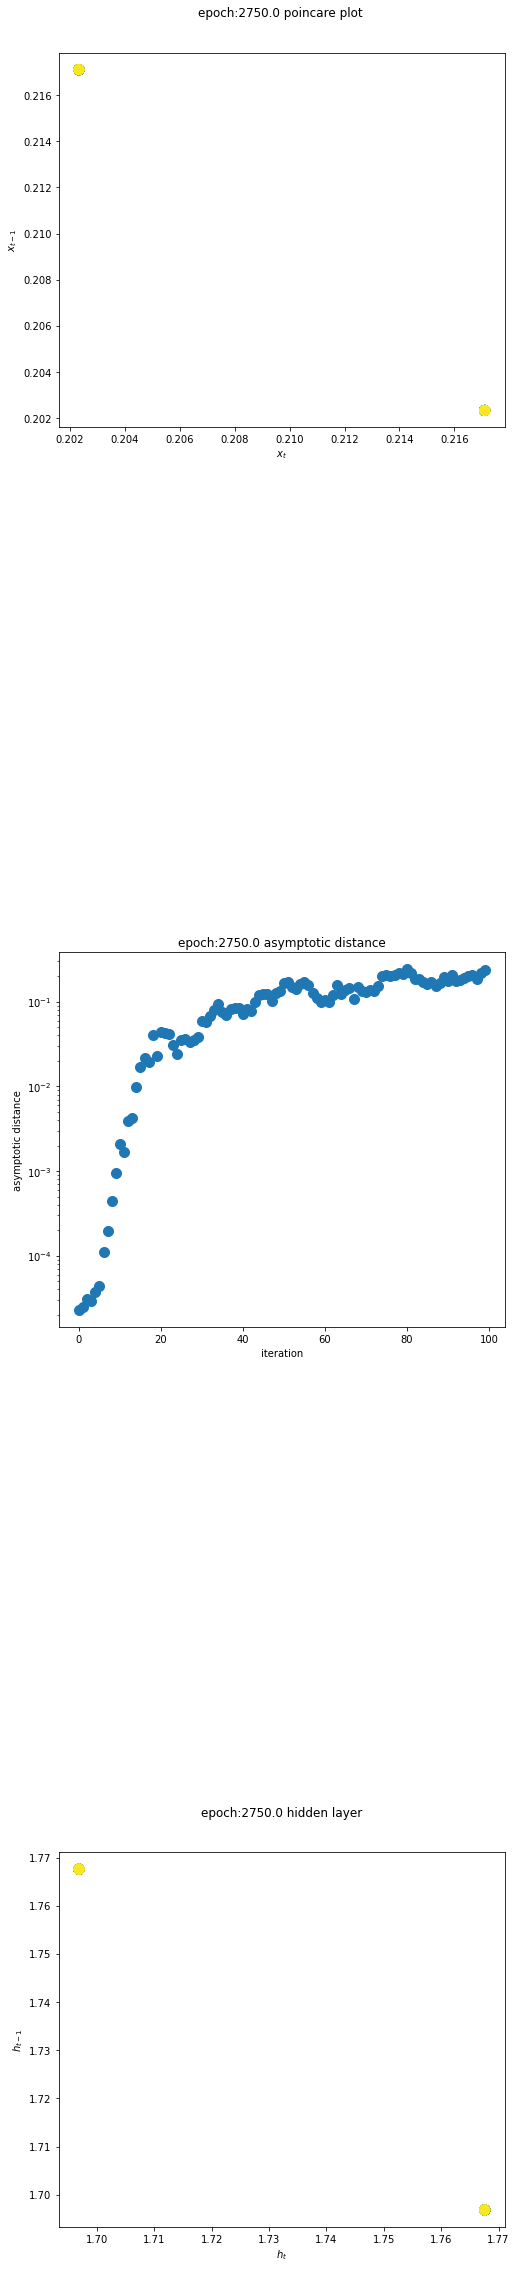

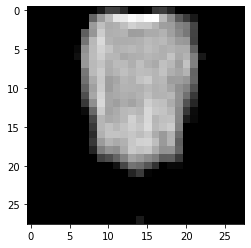

asymptotic image output epoch:2750.jpg
epoch : 2751/10000, training loss = 0.014577,validation loss = 0.019396
epoch : 2752/10000, training loss = 0.014468,validation loss = 0.019501
epoch : 2753/10000, training loss = 0.015008,validation loss = 0.019571
epoch : 2754/10000, training loss = 0.014773,validation loss = 0.019416
epoch : 2755/10000, training loss = 0.014408,validation loss = 0.019343
epoch : 2756/10000, training loss = 0.014584,validation loss = 0.019463
epoch : 2757/10000, training loss = 0.014757,validation loss = 0.019427
epoch : 2758/10000, training loss = 0.014621,validation loss = 0.019566
epoch : 2759/10000, training loss = 0.014578,validation loss = 0.019475
epoch : 2760/10000, training loss = 0.014908,validation loss = 0.019435
epoch : 2761/10000, training loss = 0.014707,validation loss = 0.019442
epoch : 2762/10000, training loss = 0.014712,validation loss = 0.019399
epoch : 2763/10000, training loss = 0.014406,validation loss = 0.019437
epoch : 2764/10000, train

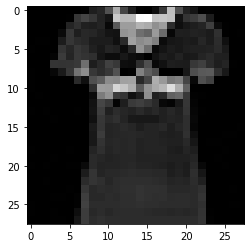

asymptotic image input epoch:2800.jpg


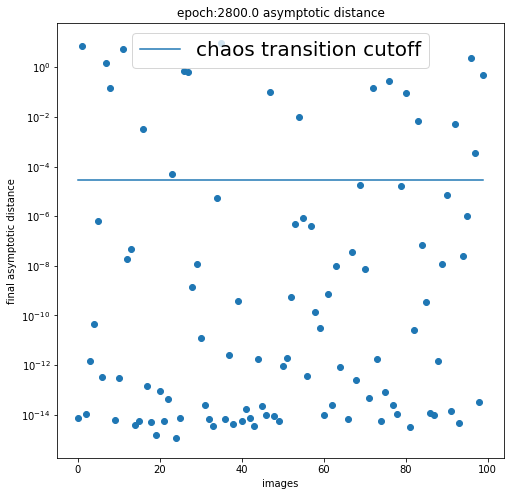

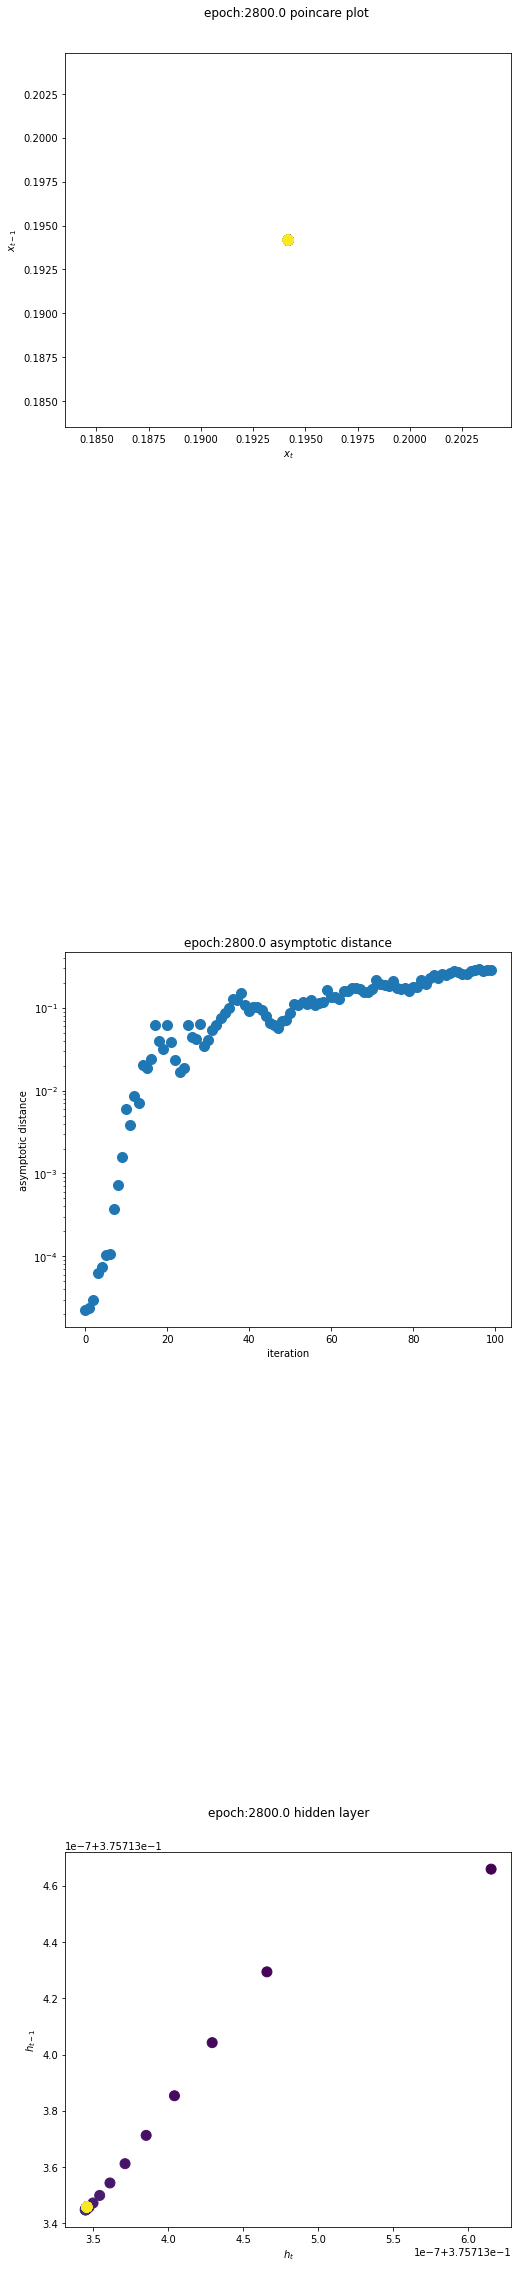

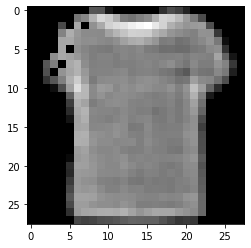

asymptotic image output epoch:2800.jpg
epoch : 2801/10000, training loss = 0.014549,validation loss = 0.019369
epoch : 2802/10000, training loss = 0.014590,validation loss = 0.019546
epoch : 2803/10000, training loss = 0.014719,validation loss = 0.019384
epoch : 2804/10000, training loss = 0.015066,validation loss = 0.019614
epoch : 2805/10000, training loss = 0.014597,validation loss = 0.019398
epoch : 2806/10000, training loss = 0.014373,validation loss = 0.019348
epoch : 2807/10000, training loss = 0.014360,validation loss = 0.019322
epoch : 2808/10000, training loss = 0.014391,validation loss = 0.019409
epoch : 2809/10000, training loss = 0.014748,validation loss = 0.019452
epoch : 2810/10000, training loss = 0.014734,validation loss = 0.019516
epoch : 2811/10000, training loss = 0.014546,validation loss = 0.019340
epoch : 2812/10000, training loss = 0.014624,validation loss = 0.019394
epoch : 2813/10000, training loss = 0.014925,validation loss = 0.019481
epoch : 2814/10000, train

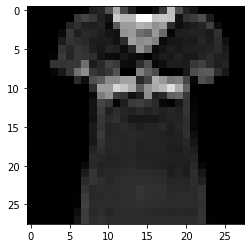

asymptotic image input epoch:2850.jpg


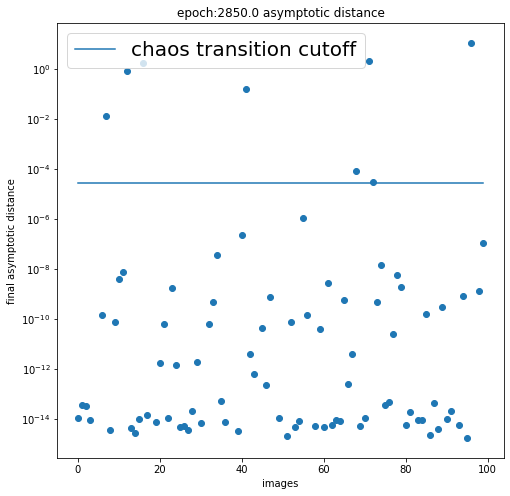

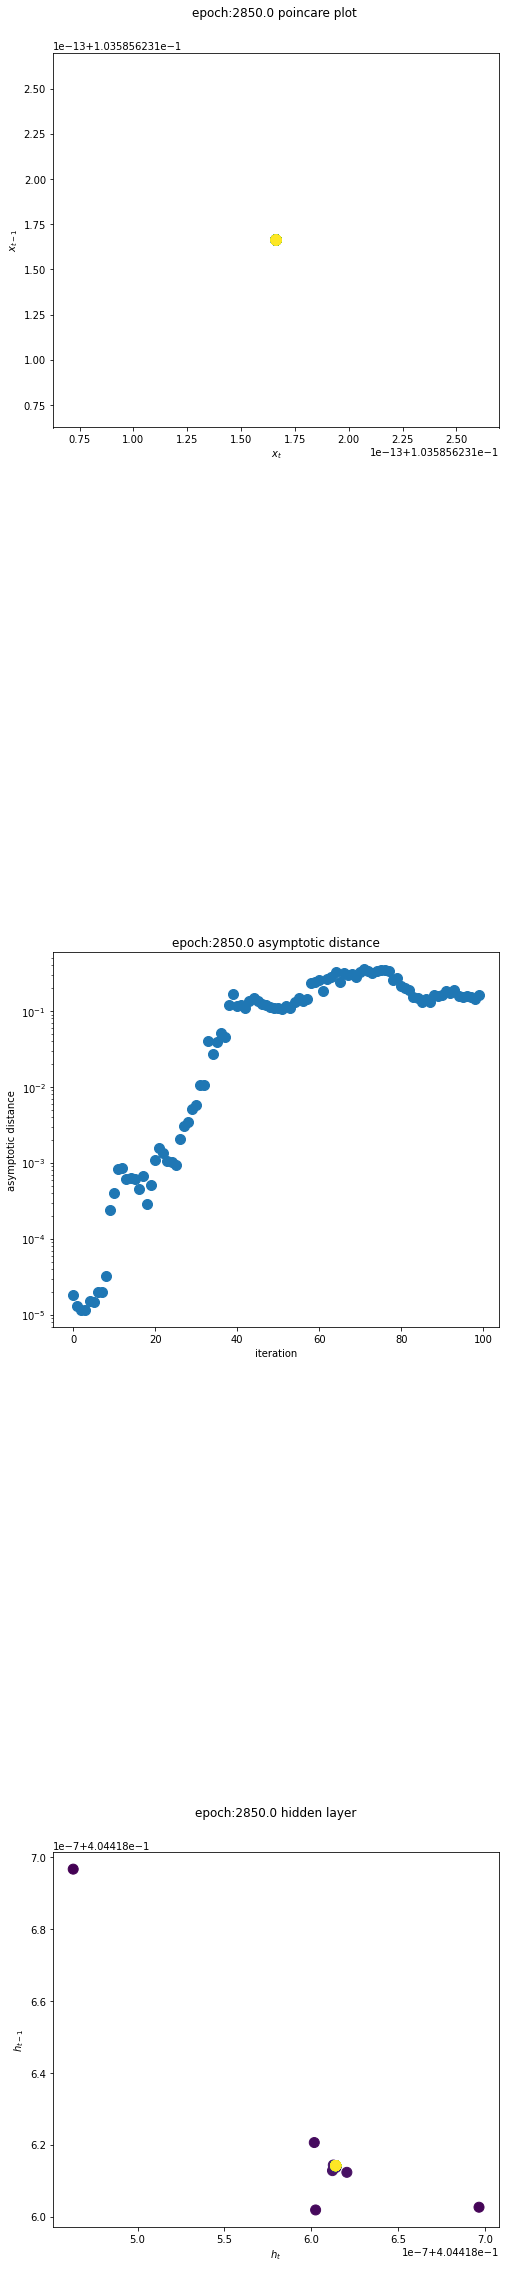

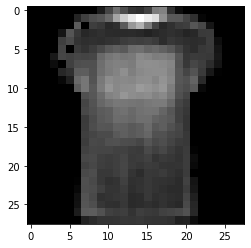

asymptotic image output epoch:2850.jpg
epoch : 2851/10000, training loss = 0.014584,validation loss = 0.019462
epoch : 2852/10000, training loss = 0.014568,validation loss = 0.019369
epoch : 2853/10000, training loss = 0.014551,validation loss = 0.019543
epoch : 2854/10000, training loss = 0.014870,validation loss = 0.019407
epoch : 2855/10000, training loss = 0.014612,validation loss = 0.019536
epoch : 2856/10000, training loss = 0.014515,validation loss = 0.019574
epoch : 2857/10000, training loss = 0.014612,validation loss = 0.019515
epoch : 2858/10000, training loss = 0.014591,validation loss = 0.019569
epoch : 2859/10000, training loss = 0.014620,validation loss = 0.019566
epoch : 2860/10000, training loss = 0.014692,validation loss = 0.019455
epoch : 2861/10000, training loss = 0.014643,validation loss = 0.019563
epoch : 2862/10000, training loss = 0.014748,validation loss = 0.019447
epoch : 2863/10000, training loss = 0.014655,validation loss = 0.019474
epoch : 2864/10000, train

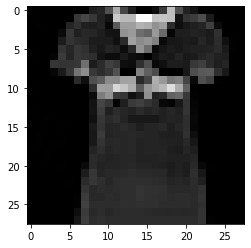

asymptotic image input epoch:2900.jpg


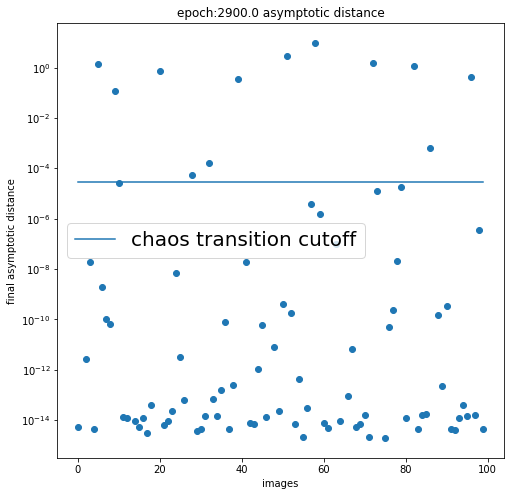

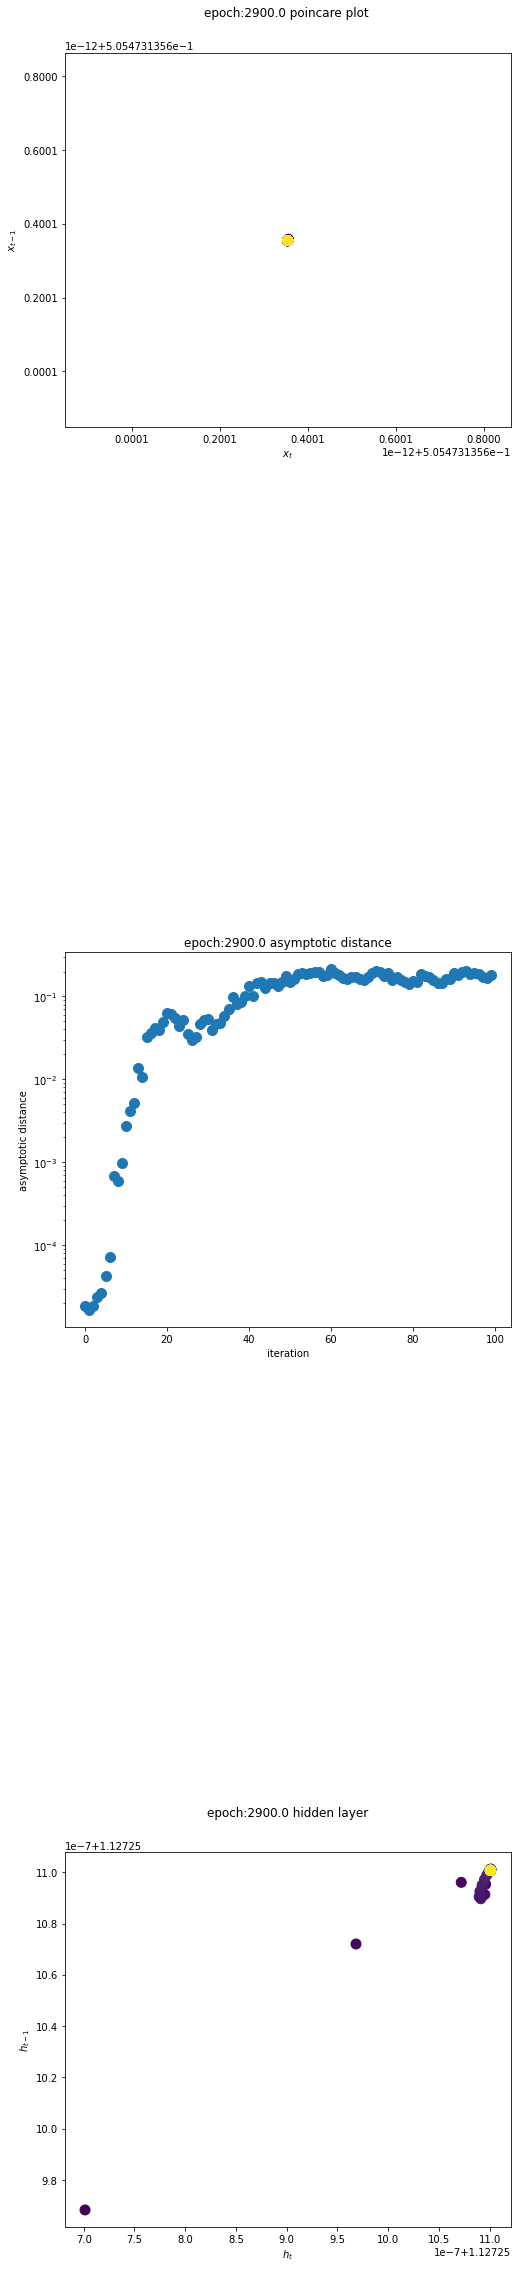

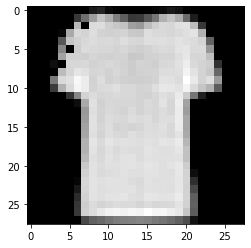

asymptotic image output epoch:2900.jpg
epoch : 2901/10000, training loss = 0.014770,validation loss = 0.019388
epoch : 2902/10000, training loss = 0.014482,validation loss = 0.019448
epoch : 2903/10000, training loss = 0.014717,validation loss = 0.019528
epoch : 2904/10000, training loss = 0.014819,validation loss = 0.019346
epoch : 2905/10000, training loss = 0.014670,validation loss = 0.019390
epoch : 2906/10000, training loss = 0.014470,validation loss = 0.019352
epoch : 2907/10000, training loss = 0.014557,validation loss = 0.019421
epoch : 2908/10000, training loss = 0.014630,validation loss = 0.019590
epoch : 2909/10000, training loss = 0.015074,validation loss = 0.019560
epoch : 2910/10000, training loss = 0.014786,validation loss = 0.019568
epoch : 2911/10000, training loss = 0.014685,validation loss = 0.019358
epoch : 2912/10000, training loss = 0.014486,validation loss = 0.019283
epoch : 2913/10000, training loss = 0.014449,validation loss = 0.019490
epoch : 2914/10000, train

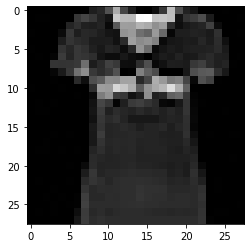

asymptotic image input epoch:2950.jpg


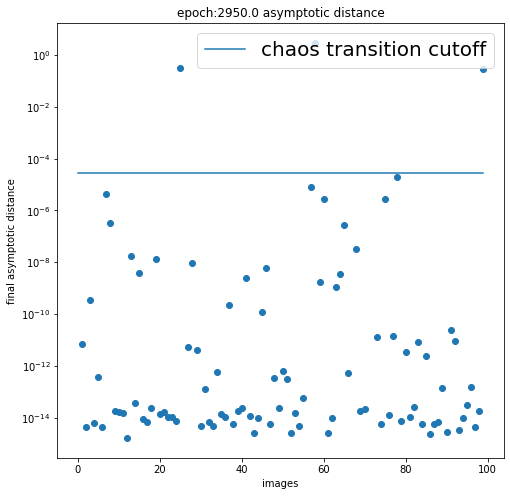

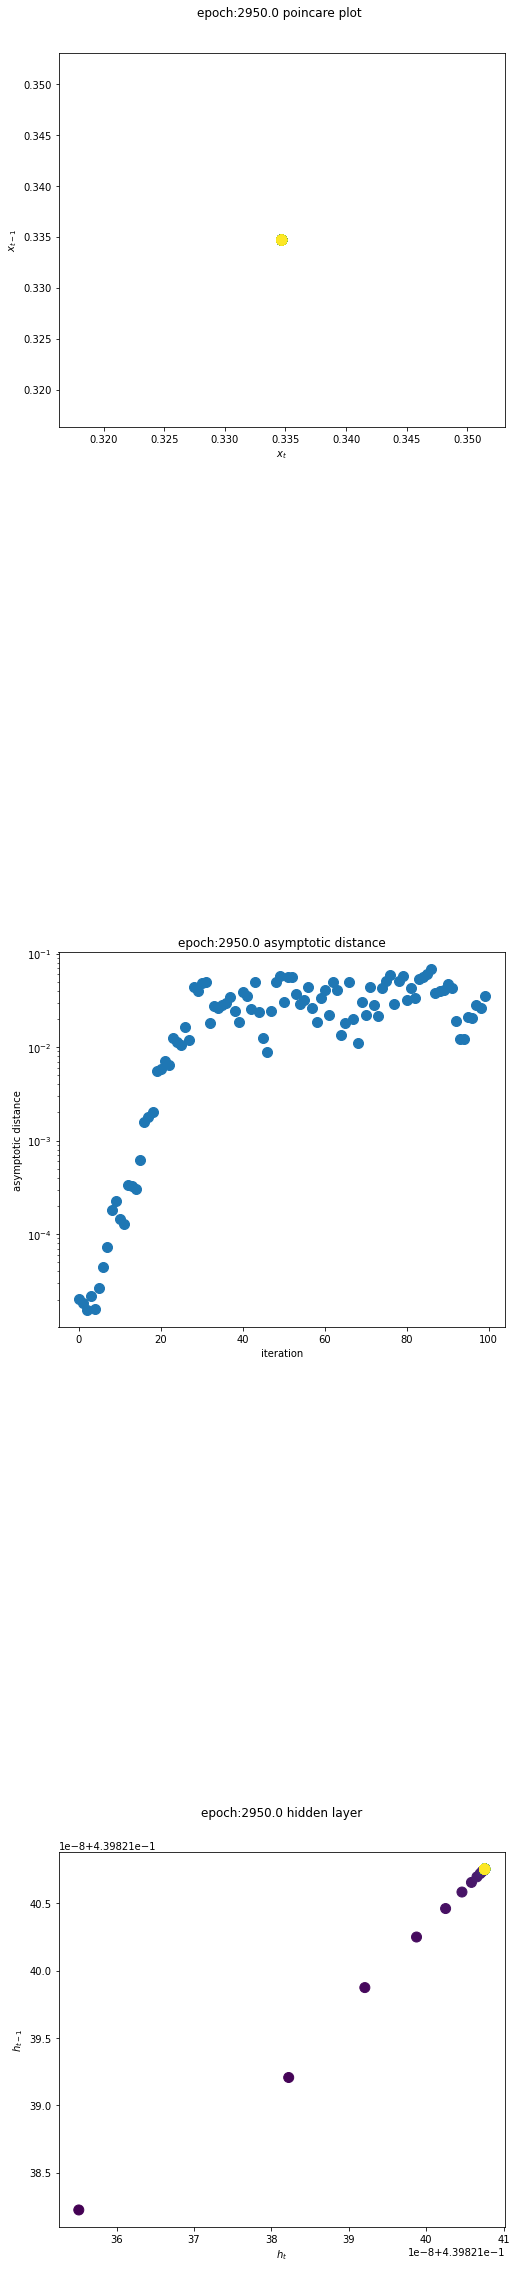

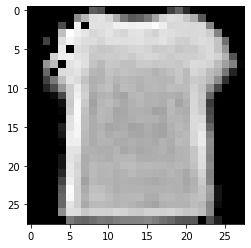

asymptotic image output epoch:2950.jpg
epoch : 2951/10000, training loss = 0.014540,validation loss = 0.019499
epoch : 2952/10000, training loss = 0.014636,validation loss = 0.019442
epoch : 2953/10000, training loss = 0.014652,validation loss = 0.019632
epoch : 2954/10000, training loss = 0.014643,validation loss = 0.019599
epoch : 2955/10000, training loss = 0.014760,validation loss = 0.019506
epoch : 2956/10000, training loss = 0.014965,validation loss = 0.019420
epoch : 2957/10000, training loss = 0.014681,validation loss = 0.019457
epoch : 2958/10000, training loss = 0.014927,validation loss = 0.019517
epoch : 2959/10000, training loss = 0.014656,validation loss = 0.019384
epoch : 2960/10000, training loss = 0.014497,validation loss = 0.019329
epoch : 2961/10000, training loss = 0.014618,validation loss = 0.019446
epoch : 2962/10000, training loss = 0.014730,validation loss = 0.019353
epoch : 2963/10000, training loss = 0.014914,validation loss = 0.022295
epoch : 2964/10000, train

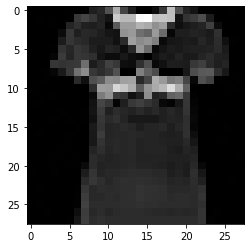

asymptotic image input epoch:3000.jpg


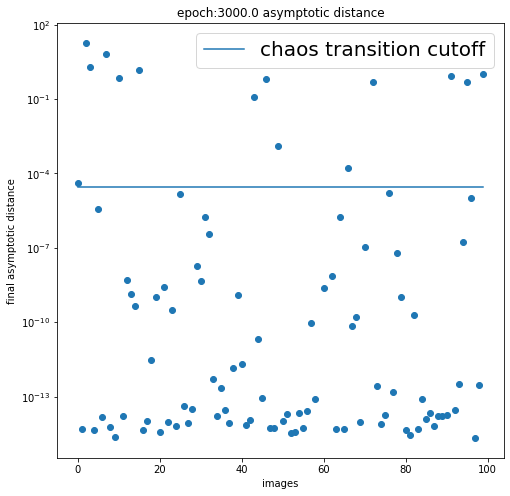

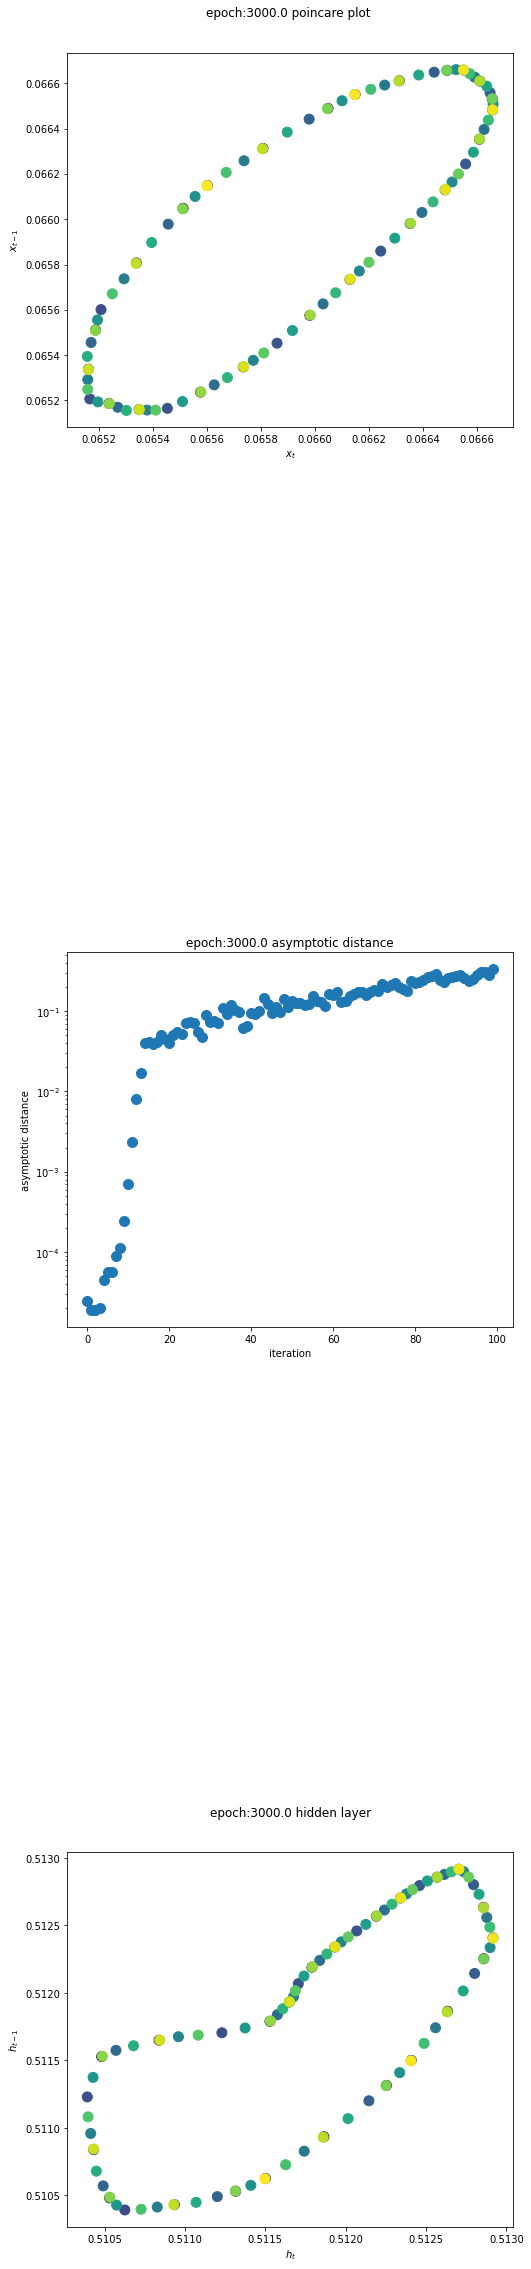

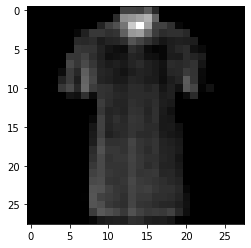

asymptotic image output epoch:3000.jpg
epoch : 3001/10000, training loss = 0.014557,validation loss = 0.019358
epoch : 3002/10000, training loss = 0.014894,validation loss = 0.019511
epoch : 3003/10000, training loss = 0.014696,validation loss = 0.019377
epoch : 3004/10000, training loss = 0.014969,validation loss = 0.019665
epoch : 3005/10000, training loss = 0.014793,validation loss = 0.019356
epoch : 3006/10000, training loss = 0.014775,validation loss = 0.019603
epoch : 3007/10000, training loss = 0.014684,validation loss = 0.019460
epoch : 3008/10000, training loss = 0.014646,validation loss = 0.019577
epoch : 3009/10000, training loss = 0.014669,validation loss = 0.019572
epoch : 3010/10000, training loss = 0.014644,validation loss = 0.019814
epoch : 3011/10000, training loss = 0.014932,validation loss = 0.019390
epoch : 3012/10000, training loss = 0.014646,validation loss = 0.019378
epoch : 3013/10000, training loss = 0.014666,validation loss = 0.019422
epoch : 3014/10000, train

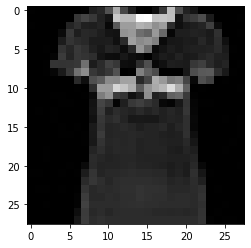

asymptotic image input epoch:3050.jpg


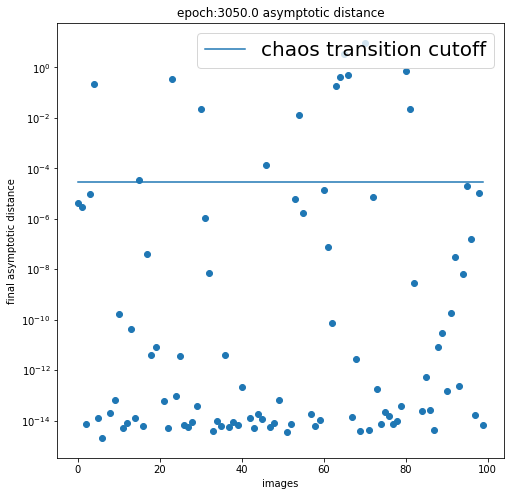

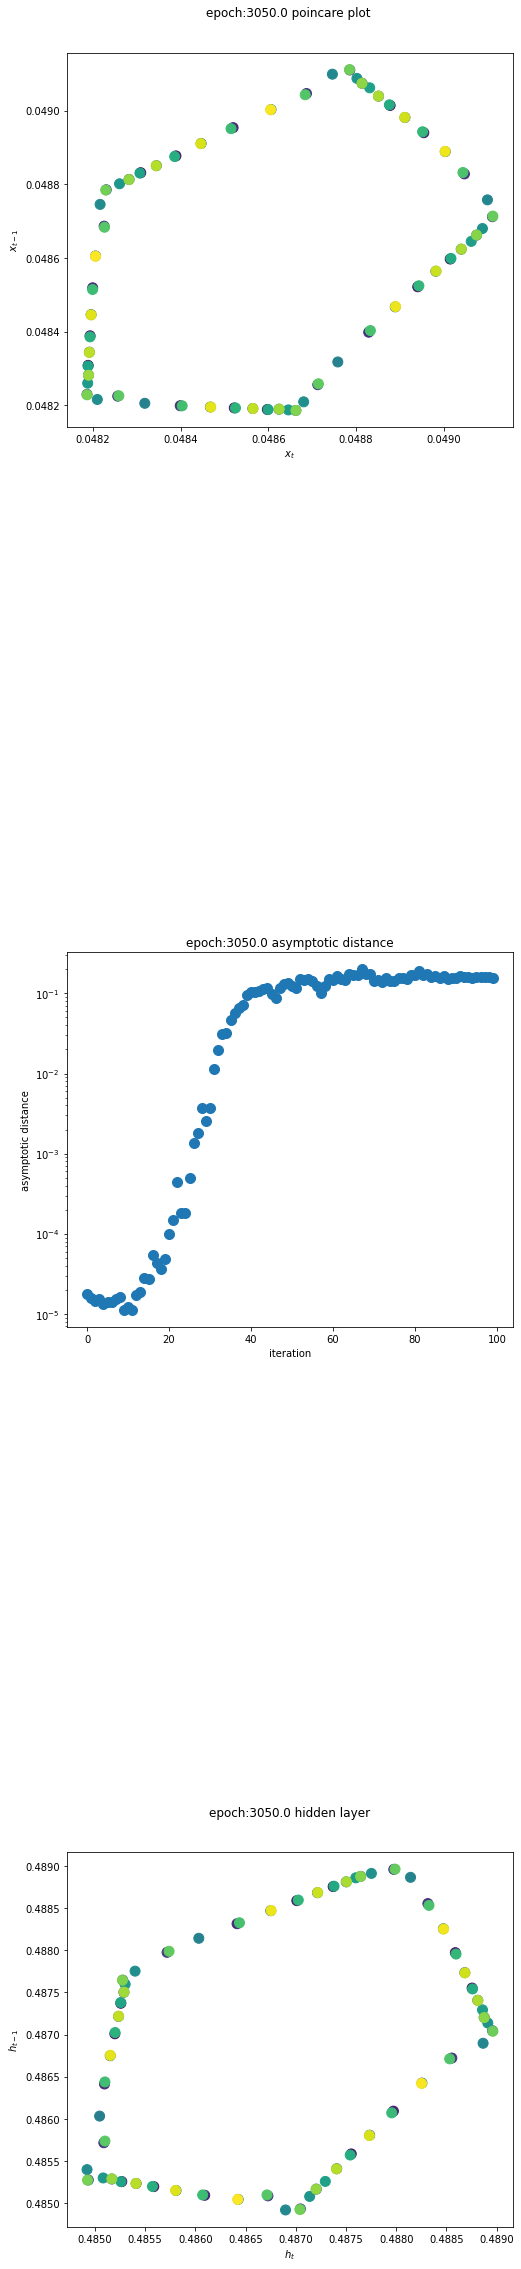

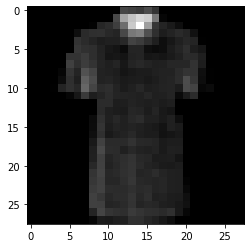

asymptotic image output epoch:3050.jpg
epoch : 3051/10000, training loss = 0.014752,validation loss = 0.019531
epoch : 3052/10000, training loss = 0.014597,validation loss = 0.019530
epoch : 3053/10000, training loss = 0.014570,validation loss = 0.019410
epoch : 3054/10000, training loss = 0.014832,validation loss = 0.019470
epoch : 3055/10000, training loss = 0.014711,validation loss = 0.019442
epoch : 3056/10000, training loss = 0.014796,validation loss = 0.019406
epoch : 3057/10000, training loss = 0.014916,validation loss = 0.019430
epoch : 3058/10000, training loss = 0.014588,validation loss = 0.019367
epoch : 3059/10000, training loss = 0.014519,validation loss = 0.019336
epoch : 3060/10000, training loss = 0.014569,validation loss = 0.019419
epoch : 3061/10000, training loss = 0.014555,validation loss = 0.019418
epoch : 3062/10000, training loss = 0.014690,validation loss = 0.019288
epoch : 3063/10000, training loss = 0.014704,validation loss = 0.019388
epoch : 3064/10000, train

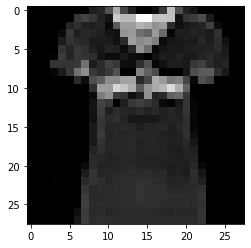

asymptotic image input epoch:3100.jpg


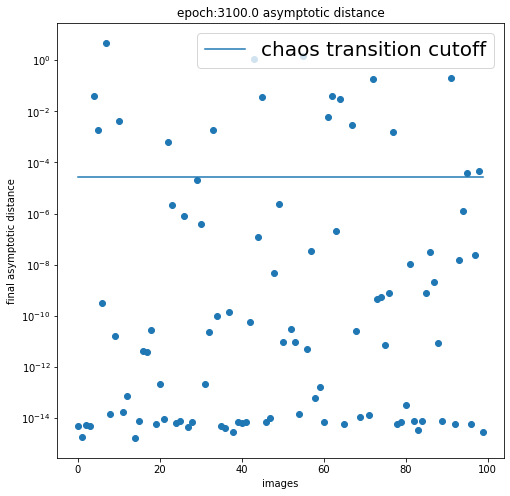

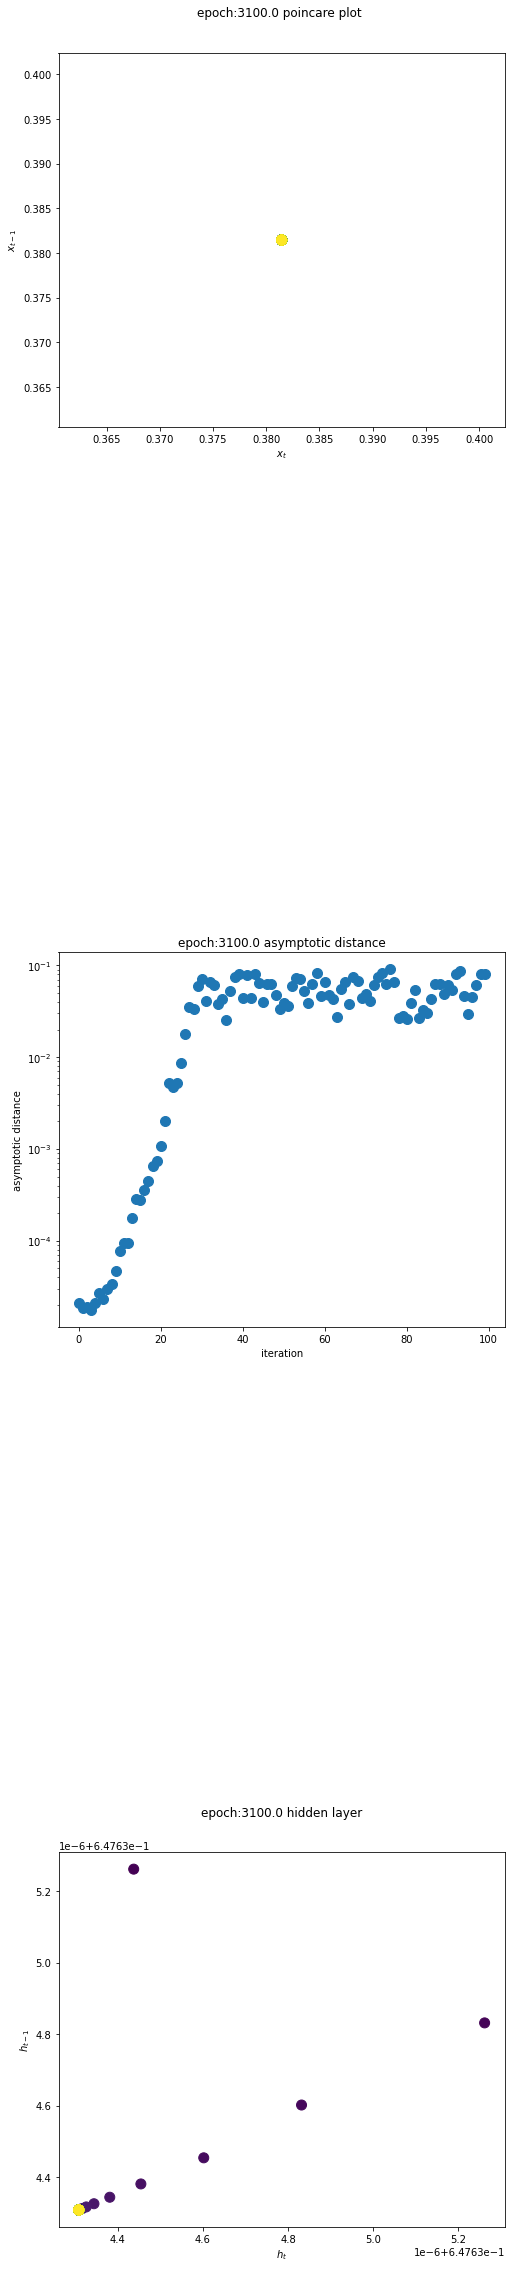

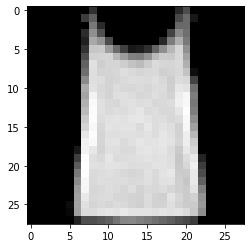

asymptotic image output epoch:3100.jpg
epoch : 3101/10000, training loss = 0.014562,validation loss = 0.019438
epoch : 3102/10000, training loss = 0.014767,validation loss = 0.019393
epoch : 3103/10000, training loss = 0.014486,validation loss = 0.019442
epoch : 3104/10000, training loss = 0.014619,validation loss = 0.019268
epoch : 3105/10000, training loss = 0.014700,validation loss = 0.019487
epoch : 3106/10000, training loss = 0.015145,validation loss = 0.019644
epoch : 3107/10000, training loss = 0.014990,validation loss = 0.019474
epoch : 3108/10000, training loss = 0.014577,validation loss = 0.019333
epoch : 3109/10000, training loss = 0.014899,validation loss = 0.019453
epoch : 3110/10000, training loss = 0.014612,validation loss = 0.019423
epoch : 3111/10000, training loss = 0.014494,validation loss = 0.019365
epoch : 3112/10000, training loss = 0.014694,validation loss = 0.019516
epoch : 3113/10000, training loss = 0.014763,validation loss = 0.019301
epoch : 3114/10000, train

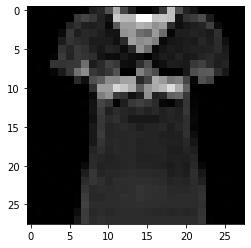

asymptotic image input epoch:3150.jpg


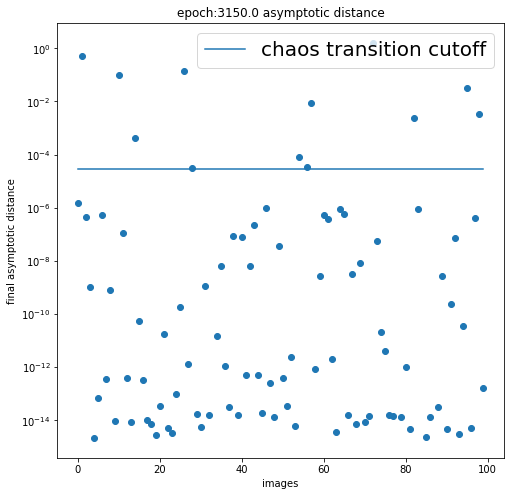

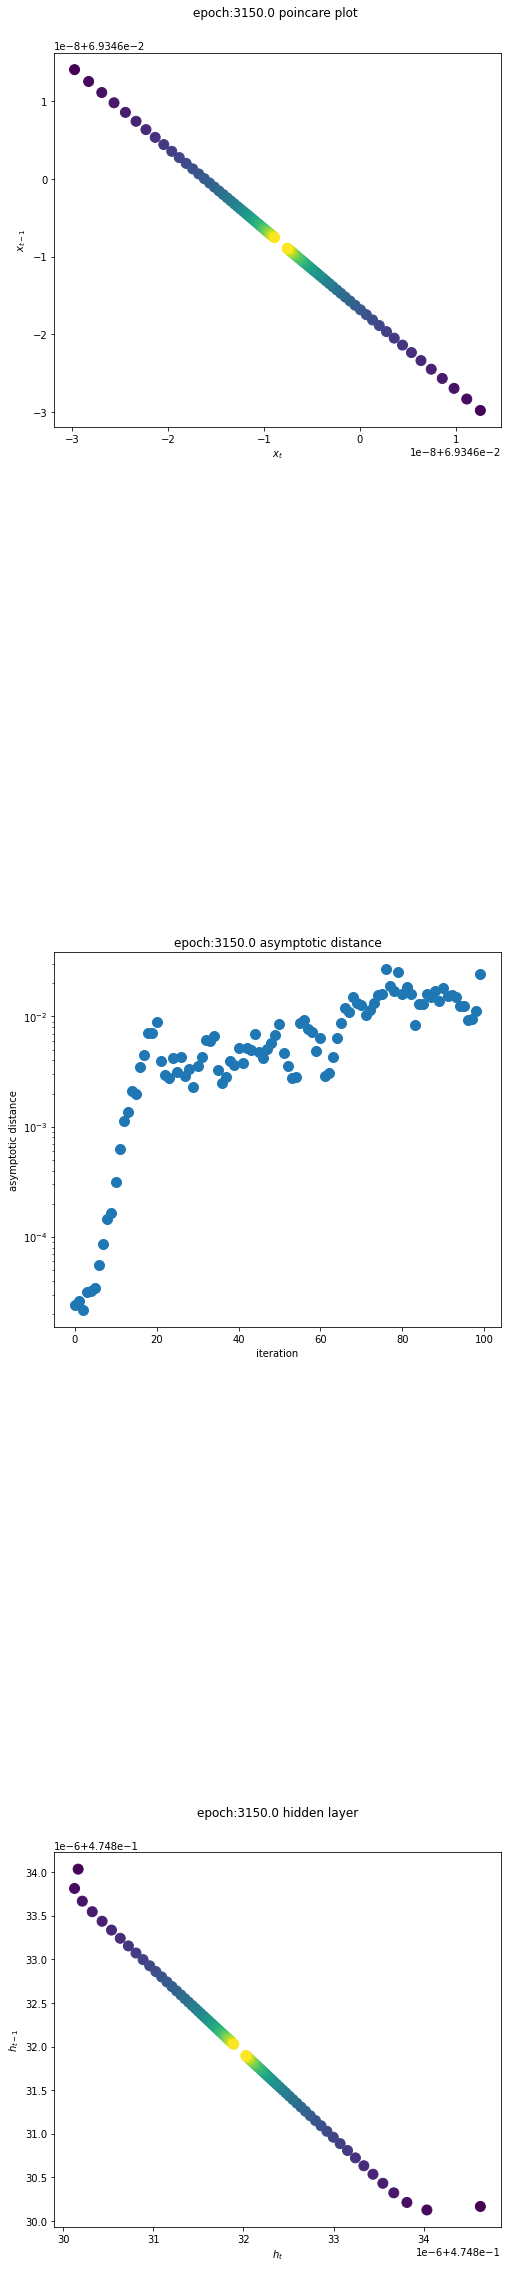

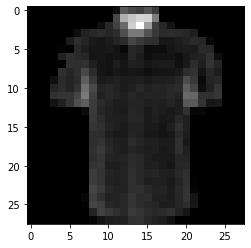

asymptotic image output epoch:3150.jpg
epoch : 3151/10000, training loss = 0.014854,validation loss = 0.019554
epoch : 3152/10000, training loss = 0.014660,validation loss = 0.019434
epoch : 3153/10000, training loss = 0.014606,validation loss = 0.019363
epoch : 3154/10000, training loss = 0.014506,validation loss = 0.019443
epoch : 3155/10000, training loss = 0.014595,validation loss = 0.019641
epoch : 3156/10000, training loss = 0.015029,validation loss = 0.019457
epoch : 3157/10000, training loss = 0.014583,validation loss = 0.019441
epoch : 3158/10000, training loss = 0.014536,validation loss = 0.019550
epoch : 3159/10000, training loss = 0.014515,validation loss = 0.019588
epoch : 3160/10000, training loss = 0.014673,validation loss = 0.019539
epoch : 3161/10000, training loss = 0.014717,validation loss = 0.019507
epoch : 3162/10000, training loss = 0.014516,validation loss = 0.019430
epoch : 3163/10000, training loss = 0.014672,validation loss = 0.019439
epoch : 3164/10000, train

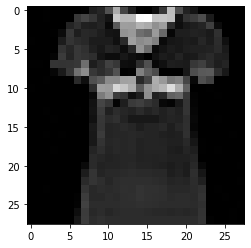

asymptotic image input epoch:3200.jpg


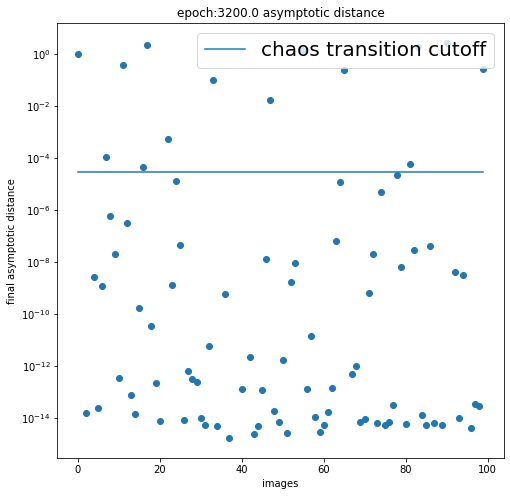

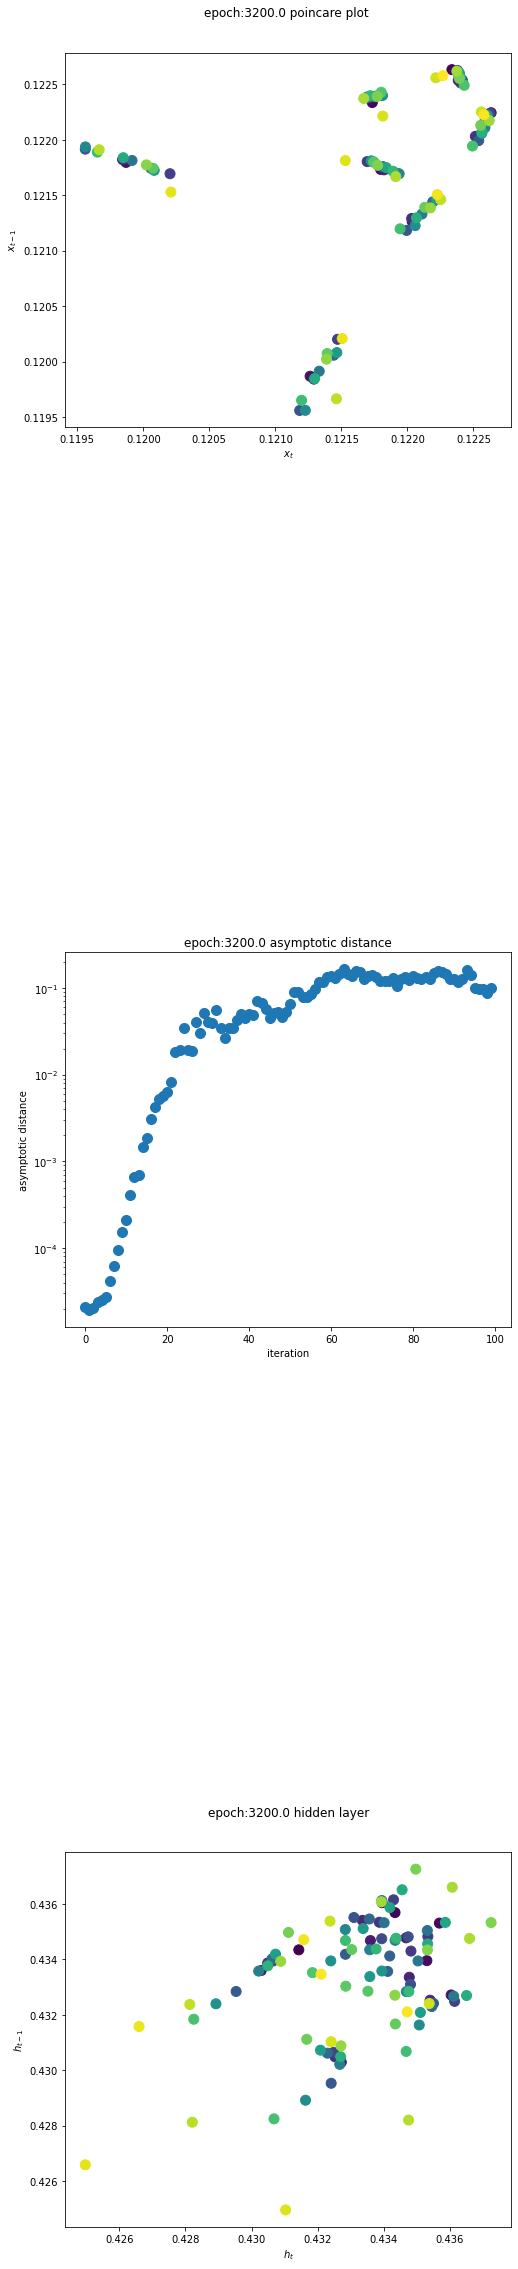

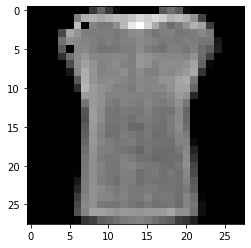

asymptotic image output epoch:3200.jpg
epoch : 3201/10000, training loss = 0.014595,validation loss = 0.019600
epoch : 3202/10000, training loss = 0.014649,validation loss = 0.019499
epoch : 3203/10000, training loss = 0.014465,validation loss = 0.019484
epoch : 3204/10000, training loss = 0.014557,validation loss = 0.019553
epoch : 3205/10000, training loss = 0.014573,validation loss = 0.019506
epoch : 3206/10000, training loss = 0.014493,validation loss = 0.019529
epoch : 3207/10000, training loss = 0.014813,validation loss = 0.019456
epoch : 3208/10000, training loss = 0.015058,validation loss = 0.019738
epoch : 3209/10000, training loss = 0.014747,validation loss = 0.019332
epoch : 3210/10000, training loss = 0.014505,validation loss = 0.019347
epoch : 3211/10000, training loss = 0.014462,validation loss = 0.019415
epoch : 3212/10000, training loss = 0.014527,validation loss = 0.019459
epoch : 3213/10000, training loss = 0.014462,validation loss = 0.019483
epoch : 3214/10000, train

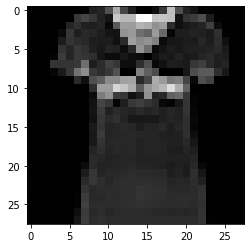

asymptotic image input epoch:3250.jpg


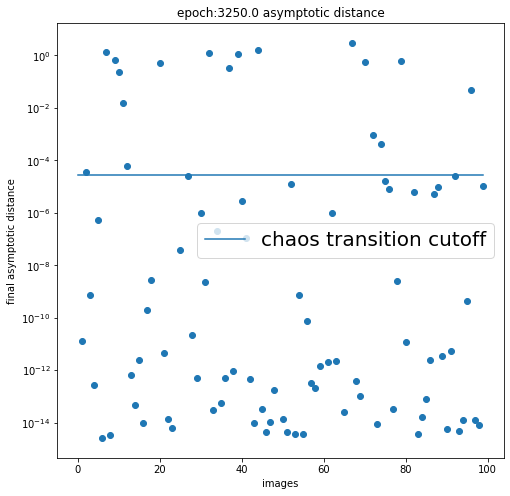

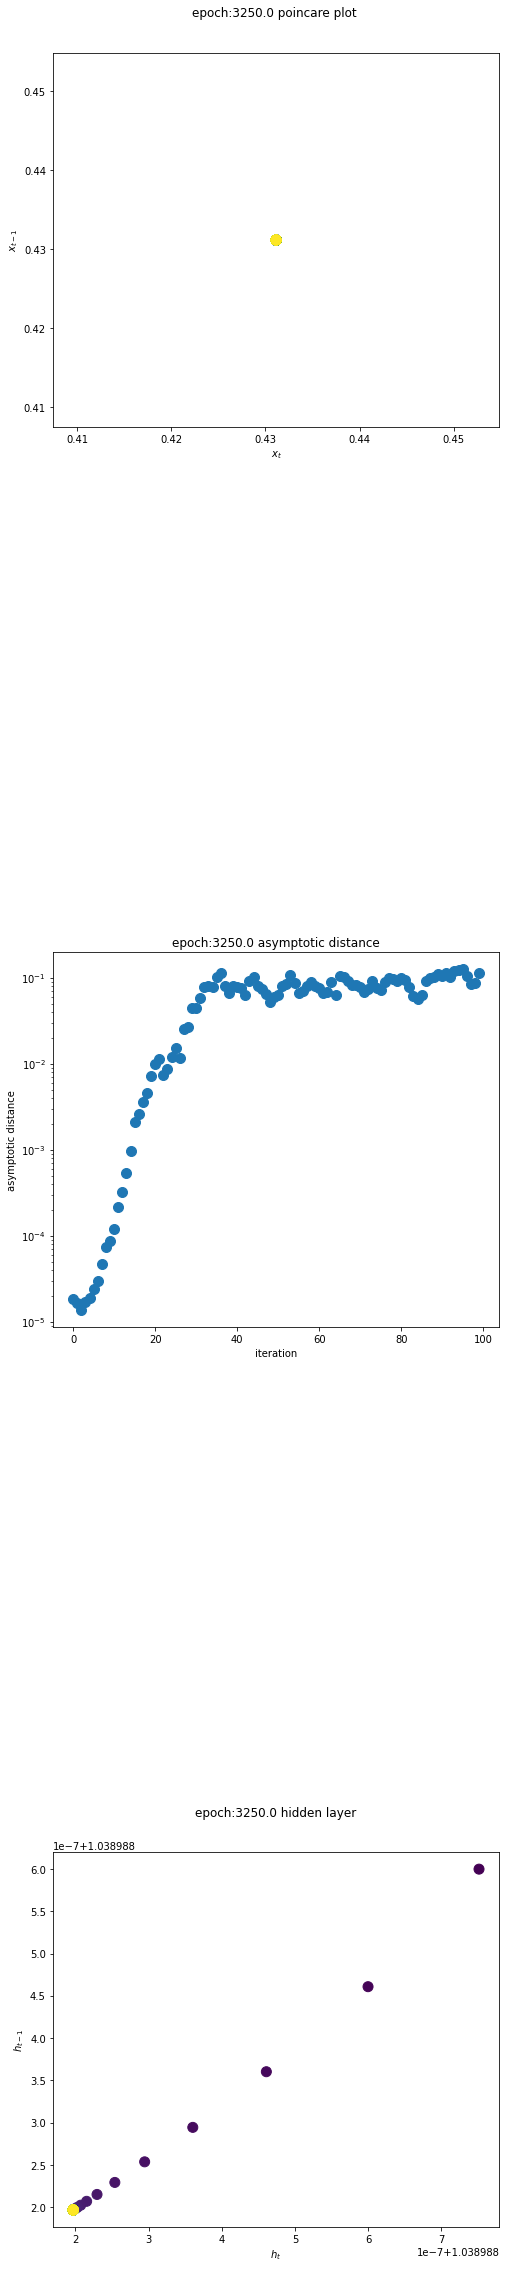

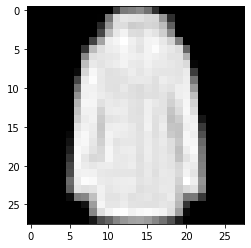

asymptotic image output epoch:3250.jpg
epoch : 3251/10000, training loss = 0.014575,validation loss = 0.019333
epoch : 3252/10000, training loss = 0.014574,validation loss = 0.019220
epoch : 3253/10000, training loss = 0.014974,validation loss = 0.019602
epoch : 3254/10000, training loss = 0.014746,validation loss = 0.019392
epoch : 3255/10000, training loss = 0.014504,validation loss = 0.019351
epoch : 3256/10000, training loss = 0.014623,validation loss = 0.019464
epoch : 3257/10000, training loss = 0.014726,validation loss = 0.019391
epoch : 3258/10000, training loss = 0.015259,validation loss = 0.019277
epoch : 3259/10000, training loss = 0.014477,validation loss = 0.019340
epoch : 3260/10000, training loss = 0.014706,validation loss = 0.019394
epoch : 3261/10000, training loss = 0.014522,validation loss = 0.019259
epoch : 3262/10000, training loss = 0.014574,validation loss = 0.019488
epoch : 3263/10000, training loss = 0.014555,validation loss = 0.019350
epoch : 3264/10000, train

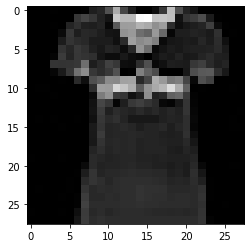

asymptotic image input epoch:3300.jpg


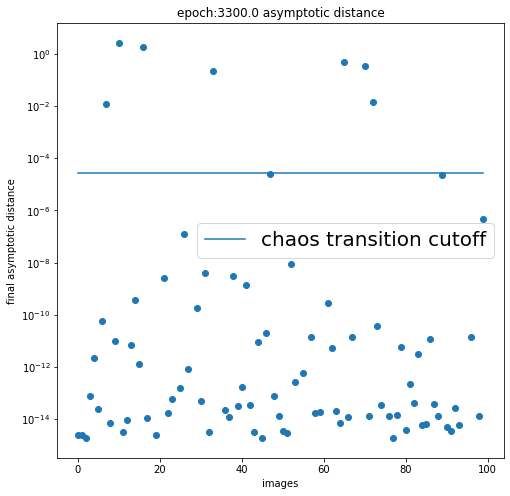

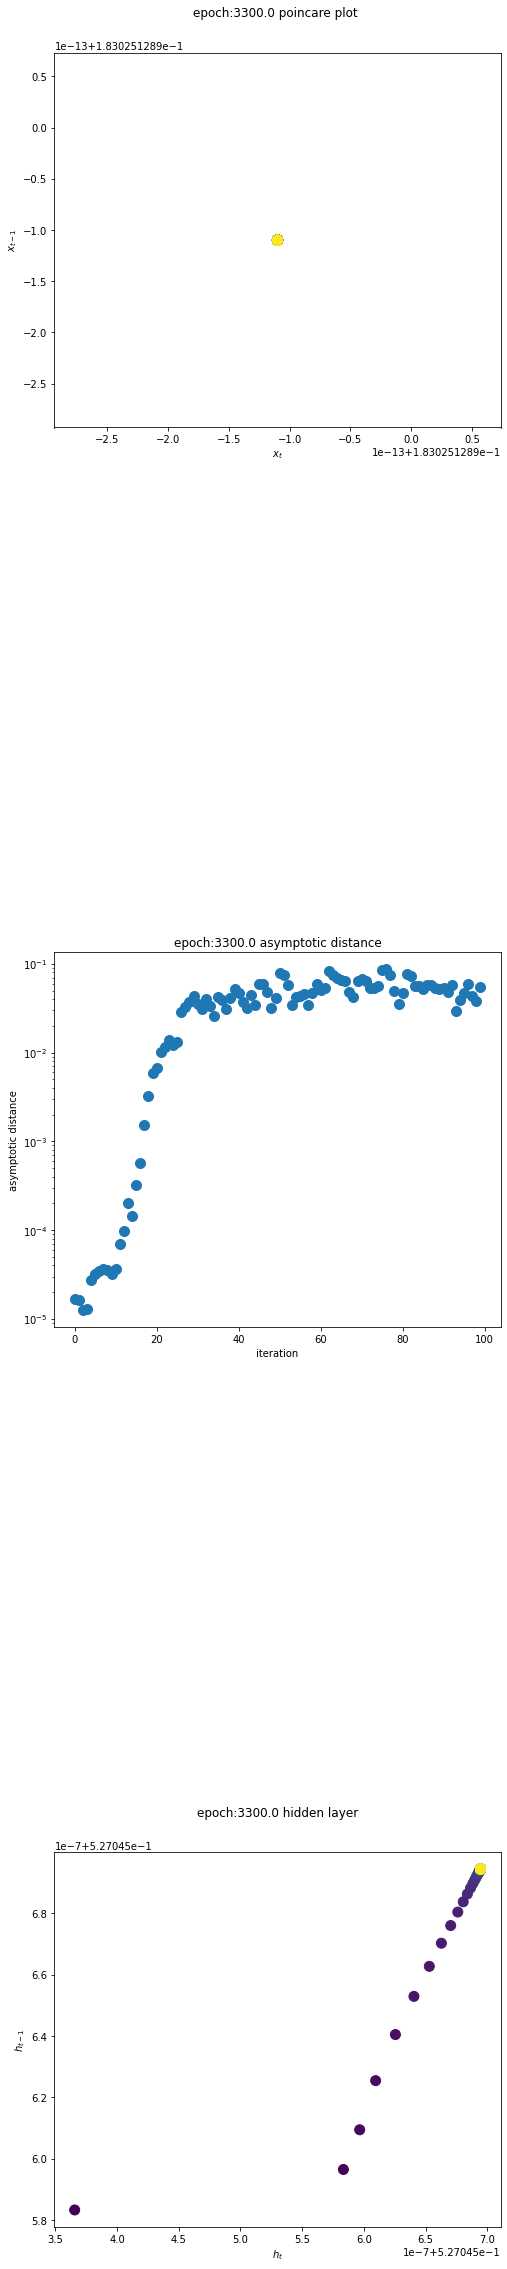

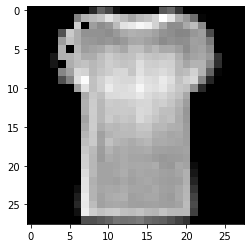

asymptotic image output epoch:3300.jpg
epoch : 3301/10000, training loss = 0.014487,validation loss = 0.019440
epoch : 3302/10000, training loss = 0.014372,validation loss = 0.019534
epoch : 3303/10000, training loss = 0.014756,validation loss = 0.019373
epoch : 3304/10000, training loss = 0.014807,validation loss = 0.019383
epoch : 3305/10000, training loss = 0.014400,validation loss = 0.019413
epoch : 3306/10000, training loss = 0.014548,validation loss = 0.019497
epoch : 3307/10000, training loss = 0.014568,validation loss = 0.019516
epoch : 3308/10000, training loss = 0.014574,validation loss = 0.019517
epoch : 3309/10000, training loss = 0.014582,validation loss = 0.019374
epoch : 3310/10000, training loss = 0.014544,validation loss = 0.019335
epoch : 3311/10000, training loss = 0.014506,validation loss = 0.019401
epoch : 3312/10000, training loss = 0.014567,validation loss = 0.019442
epoch : 3313/10000, training loss = 0.014563,validation loss = 0.019574
epoch : 3314/10000, train

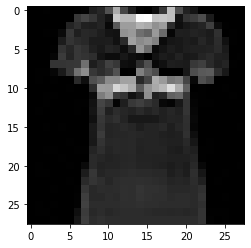

asymptotic image input epoch:3350.jpg


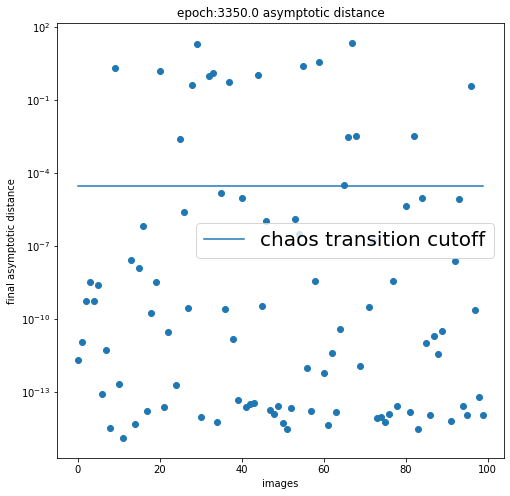

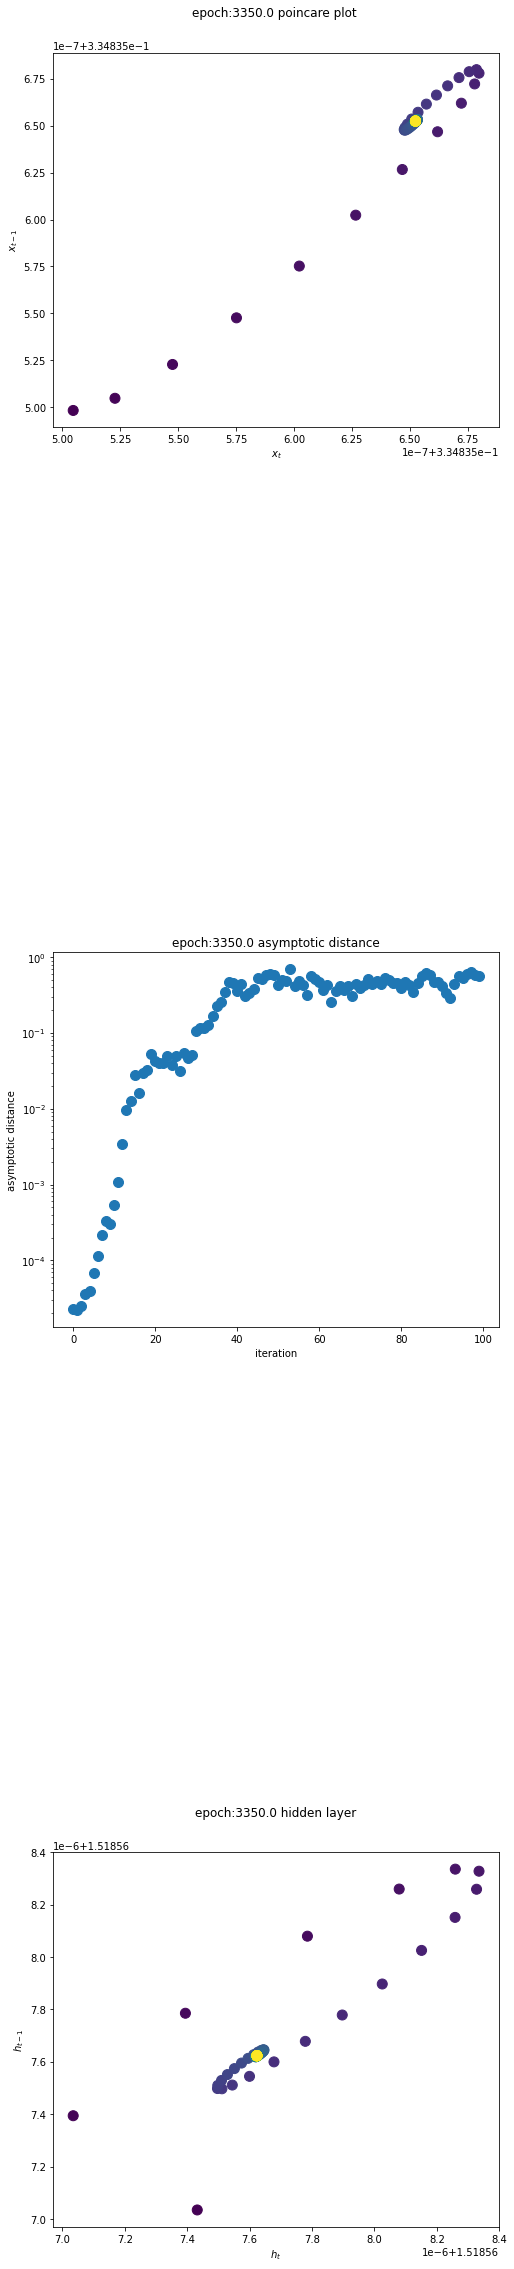

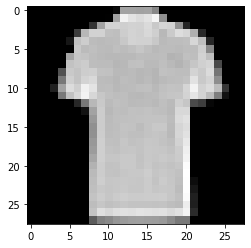

asymptotic image output epoch:3350.jpg
epoch : 3351/10000, training loss = 0.014418,validation loss = 0.019365
epoch : 3352/10000, training loss = 0.014445,validation loss = 0.019621
epoch : 3353/10000, training loss = 0.014978,validation loss = 0.019524
epoch : 3354/10000, training loss = 0.014736,validation loss = 0.019432
epoch : 3355/10000, training loss = 0.014638,validation loss = 0.019570
epoch : 3356/10000, training loss = 0.014716,validation loss = 0.019356
epoch : 3357/10000, training loss = 0.014642,validation loss = 0.019568
epoch : 3358/10000, training loss = 0.014533,validation loss = 0.019529
epoch : 3359/10000, training loss = 0.014599,validation loss = 0.019562
epoch : 3360/10000, training loss = 0.014496,validation loss = 0.019456
epoch : 3361/10000, training loss = 0.014524,validation loss = 0.019352
epoch : 3362/10000, training loss = 0.014546,validation loss = 0.019369
epoch : 3363/10000, training loss = 0.014664,validation loss = 0.019557
epoch : 3364/10000, train

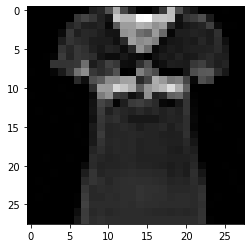

asymptotic image input epoch:3400.jpg


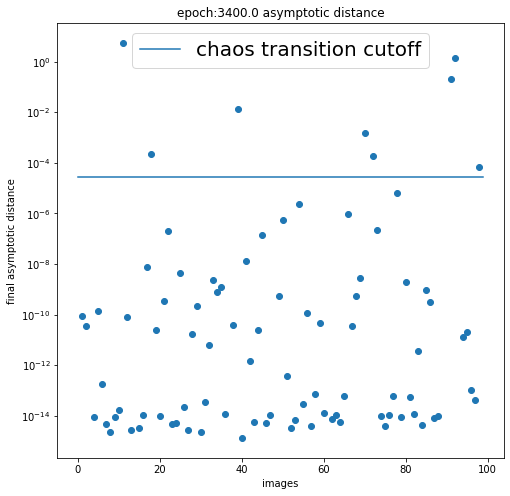

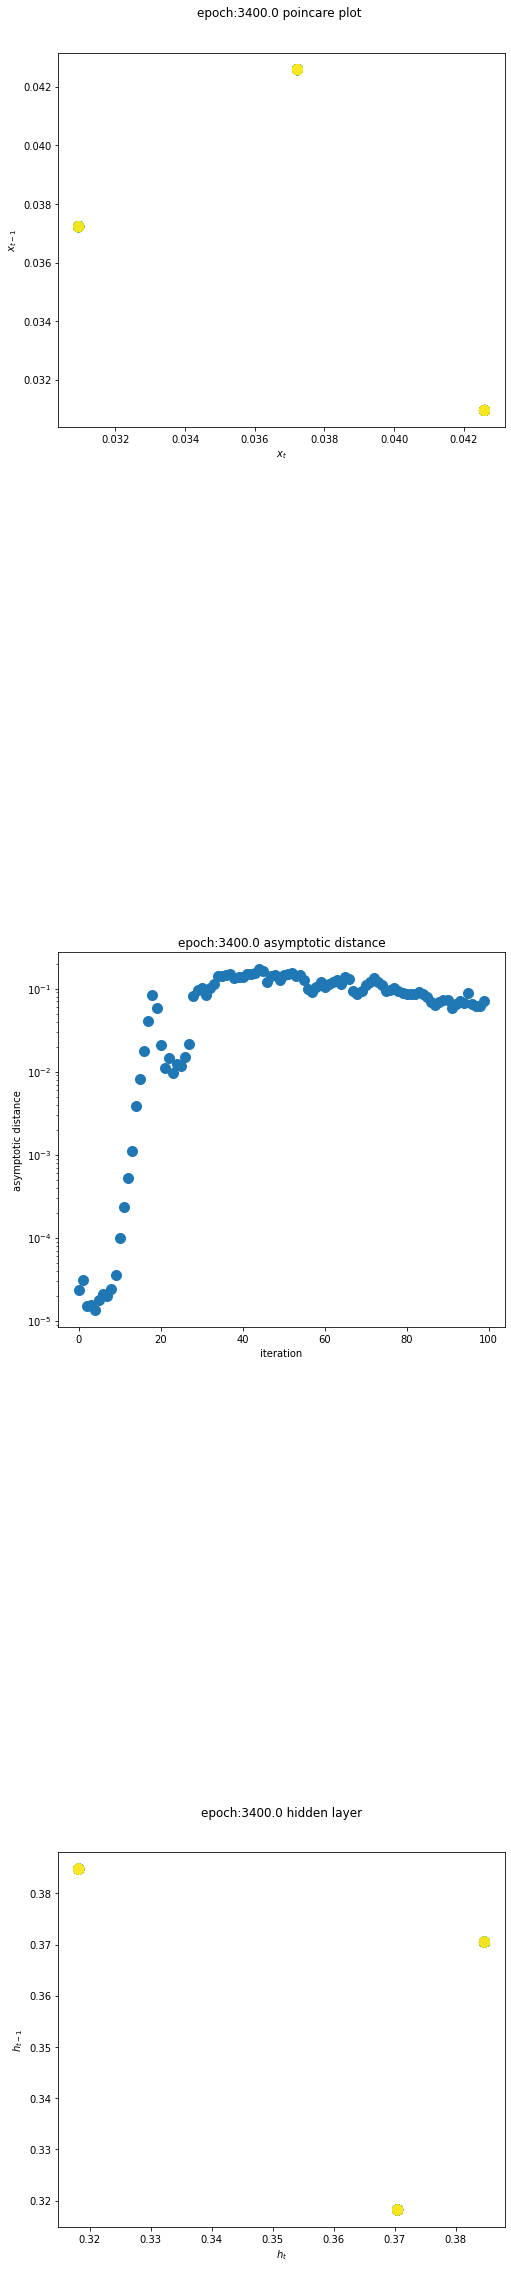

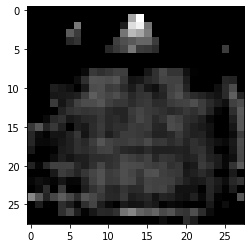

asymptotic image output epoch:3400.jpg
epoch : 3401/10000, training loss = 0.014726,validation loss = 0.019284
epoch : 3402/10000, training loss = 0.014490,validation loss = 0.019214
epoch : 3403/10000, training loss = 0.014521,validation loss = 0.019449
epoch : 3404/10000, training loss = 0.014768,validation loss = 0.019588
epoch : 3405/10000, training loss = 0.014671,validation loss = 0.019422
epoch : 3406/10000, training loss = 0.014694,validation loss = 0.019366
epoch : 3407/10000, training loss = 0.014585,validation loss = 0.019471
epoch : 3408/10000, training loss = 0.014363,validation loss = 0.019371
epoch : 3409/10000, training loss = 0.014643,validation loss = 0.019508
epoch : 3410/10000, training loss = 0.014749,validation loss = 0.019437
epoch : 3411/10000, training loss = 0.014593,validation loss = 0.019489
epoch : 3412/10000, training loss = 0.014546,validation loss = 0.019402
epoch : 3413/10000, training loss = 0.014477,validation loss = 0.019321
epoch : 3414/10000, train

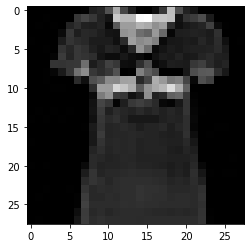

asymptotic image input epoch:3450.jpg


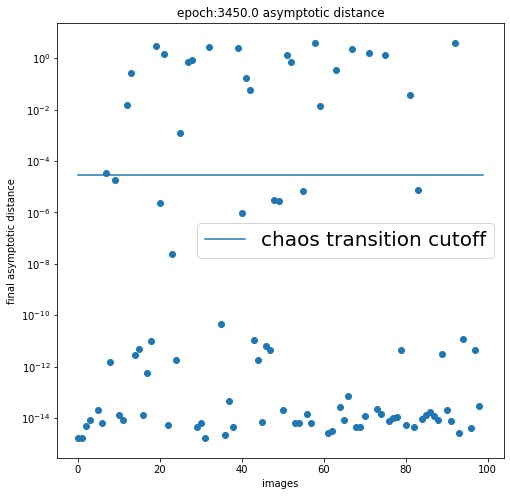

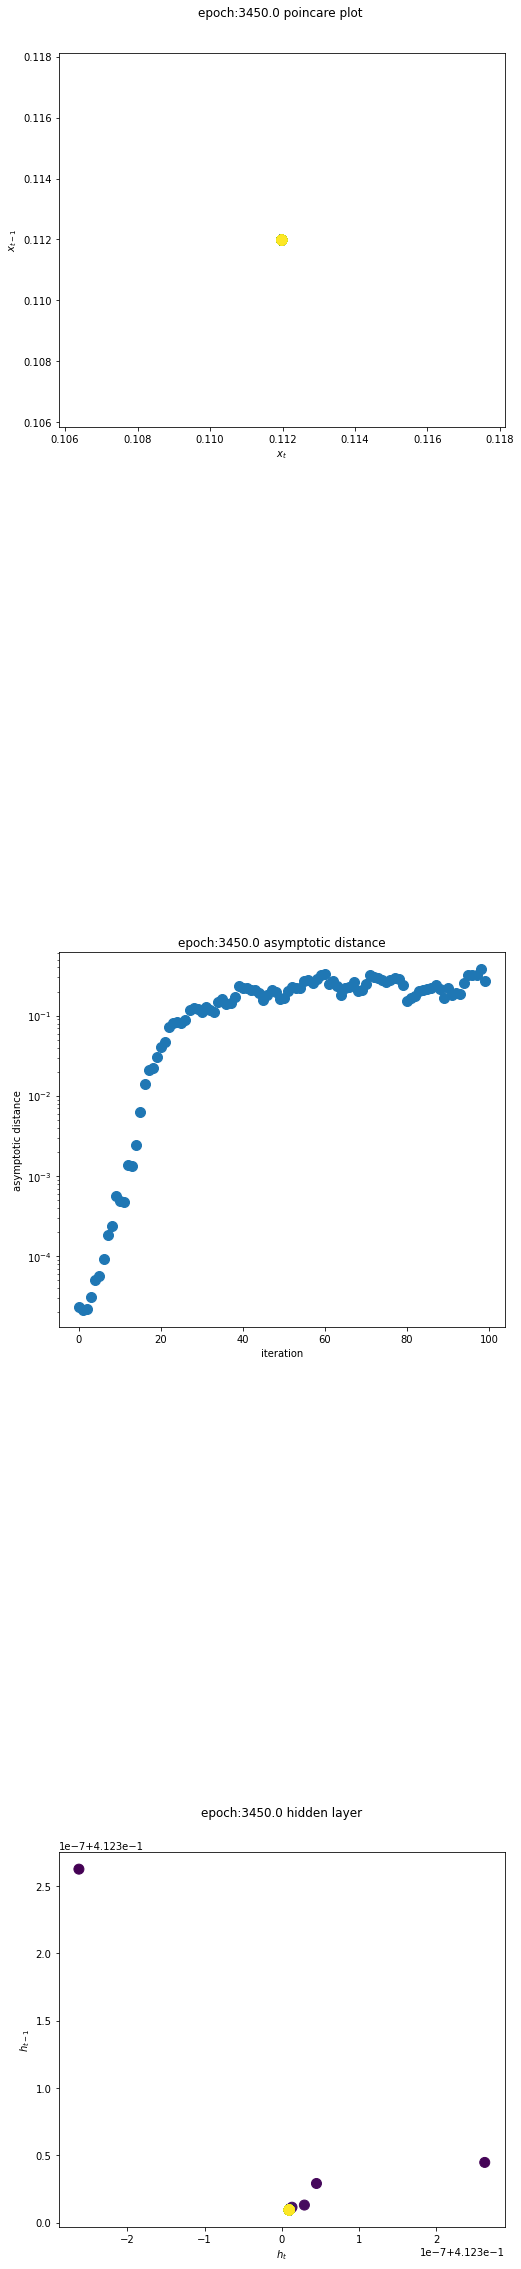

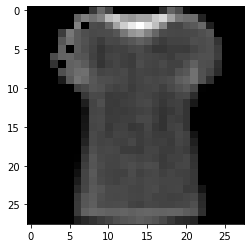

asymptotic image output epoch:3450.jpg
epoch : 3451/10000, training loss = 0.014636,validation loss = 0.019416
epoch : 3452/10000, training loss = 0.014610,validation loss = 0.019561
epoch : 3453/10000, training loss = 0.014466,validation loss = 0.019471
epoch : 3454/10000, training loss = 0.014561,validation loss = 0.019523
epoch : 3455/10000, training loss = 0.014481,validation loss = 0.019481
epoch : 3456/10000, training loss = 0.014706,validation loss = 0.019425
epoch : 3457/10000, training loss = 0.014499,validation loss = 0.019326
epoch : 3458/10000, training loss = 0.014528,validation loss = 0.019590
epoch : 3459/10000, training loss = 0.014695,validation loss = 0.019594
epoch : 3460/10000, training loss = 0.014562,validation loss = 0.019741
epoch : 3461/10000, training loss = 0.014645,validation loss = 0.019365
epoch : 3462/10000, training loss = 0.014434,validation loss = 0.019436
epoch : 3463/10000, training loss = 0.014342,validation loss = 0.019318
epoch : 3464/10000, train

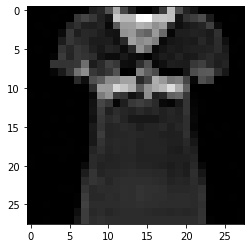

asymptotic image input epoch:3500.jpg


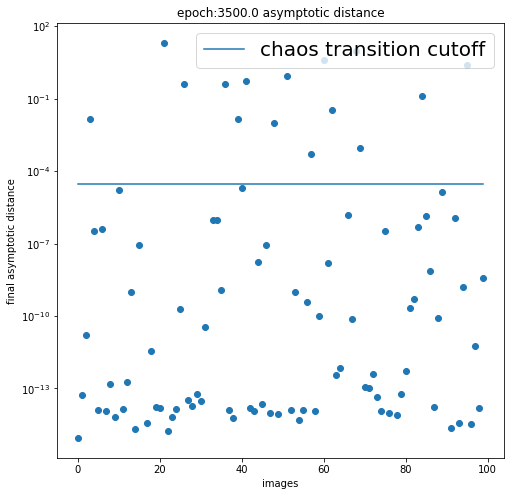

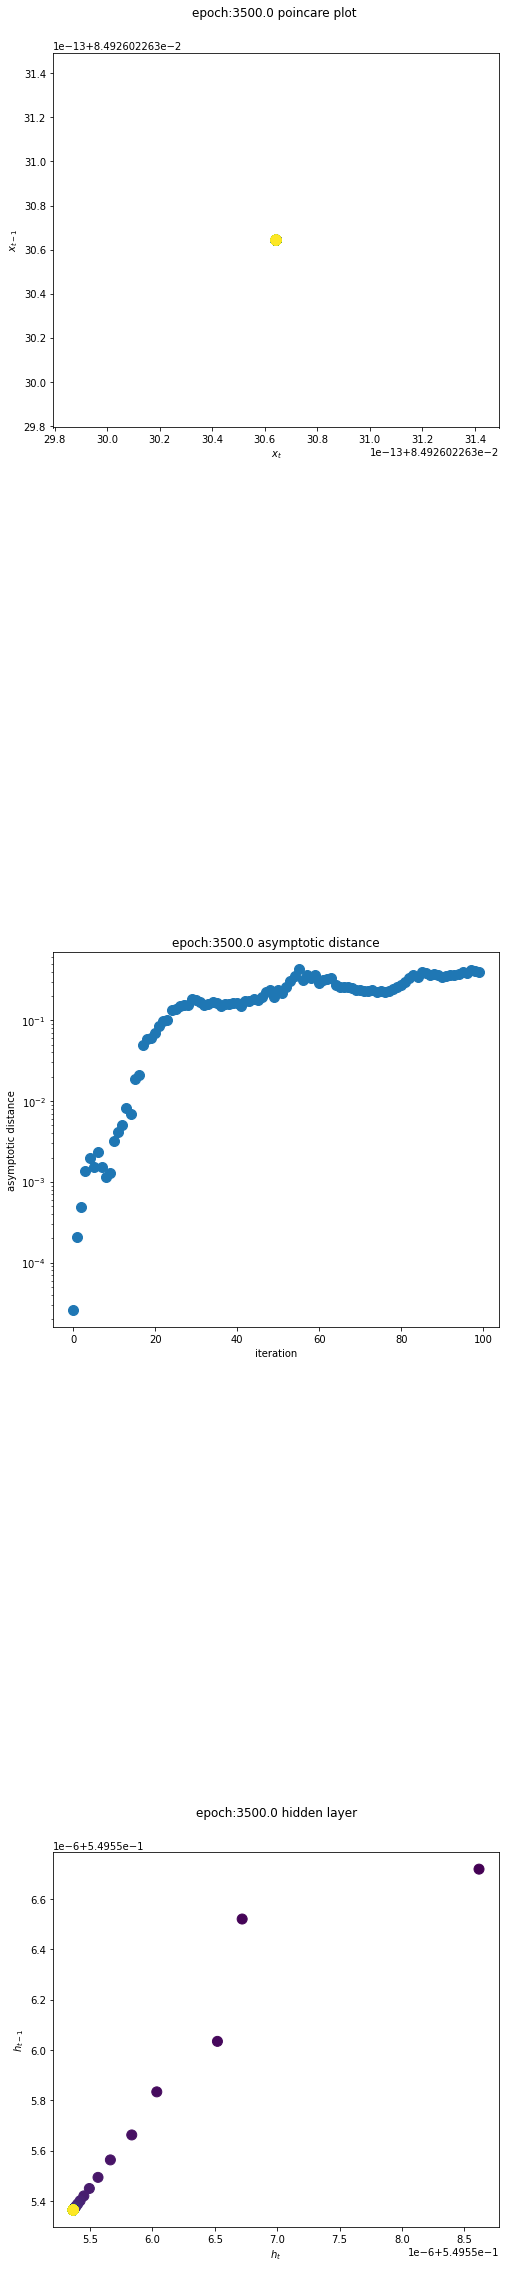

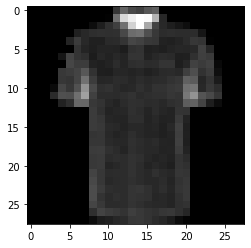

asymptotic image output epoch:3500.jpg
epoch : 3501/10000, training loss = 0.014629,validation loss = 0.019801
epoch : 3502/10000, training loss = 0.014874,validation loss = 0.019409
epoch : 3503/10000, training loss = 0.014615,validation loss = 0.019375
epoch : 3504/10000, training loss = 0.014559,validation loss = 0.019405
epoch : 3505/10000, training loss = 0.014574,validation loss = 0.019282
epoch : 3506/10000, training loss = 0.014537,validation loss = 0.019369
epoch : 3507/10000, training loss = 0.014783,validation loss = 0.019520
epoch : 3508/10000, training loss = 0.014641,validation loss = 0.019405
epoch : 3509/10000, training loss = 0.014586,validation loss = 0.019329
epoch : 3510/10000, training loss = 0.014476,validation loss = 0.019420
epoch : 3511/10000, training loss = 0.014727,validation loss = 0.019814
epoch : 3512/10000, training loss = 0.014832,validation loss = 0.019495
epoch : 3513/10000, training loss = 0.014524,validation loss = 0.019371
epoch : 3514/10000, train

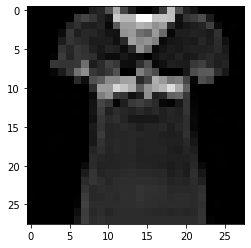

asymptotic image input epoch:3550.jpg


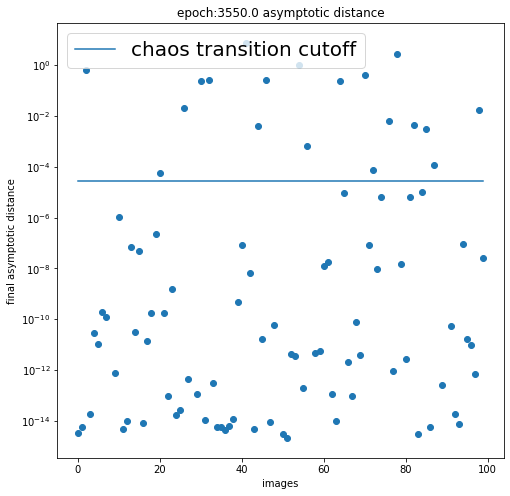

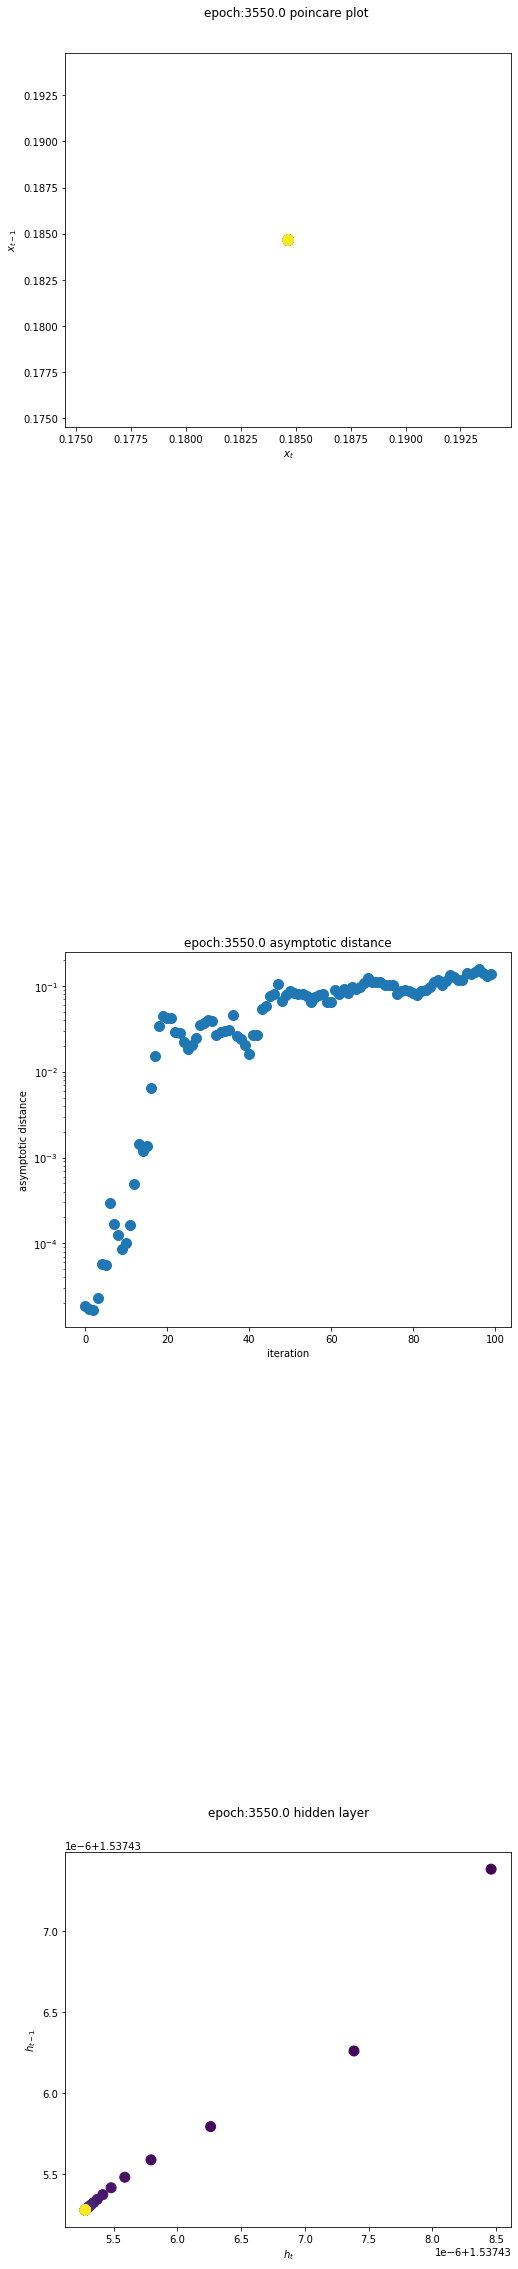

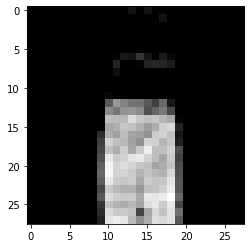

asymptotic image output epoch:3550.jpg
epoch : 3551/10000, training loss = 0.014761,validation loss = 0.019497
epoch : 3552/10000, training loss = 0.014656,validation loss = 0.019567
epoch : 3553/10000, training loss = 0.014585,validation loss = 0.019457
epoch : 3554/10000, training loss = 0.014772,validation loss = 0.019452
epoch : 3555/10000, training loss = 0.014719,validation loss = 0.019451
epoch : 3556/10000, training loss = 0.014801,validation loss = 0.019454
epoch : 3557/10000, training loss = 0.014674,validation loss = 0.019539
epoch : 3558/10000, training loss = 0.014456,validation loss = 0.019372
epoch : 3559/10000, training loss = 0.014650,validation loss = 0.019375
epoch : 3560/10000, training loss = 0.014643,validation loss = 0.019598
epoch : 3561/10000, training loss = 0.014857,validation loss = 0.019569
epoch : 3562/10000, training loss = 0.015257,validation loss = 0.019695
epoch : 3563/10000, training loss = 0.014920,validation loss = 0.019487
epoch : 3564/10000, train

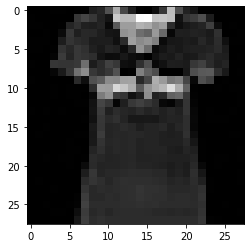

asymptotic image input epoch:3600.jpg


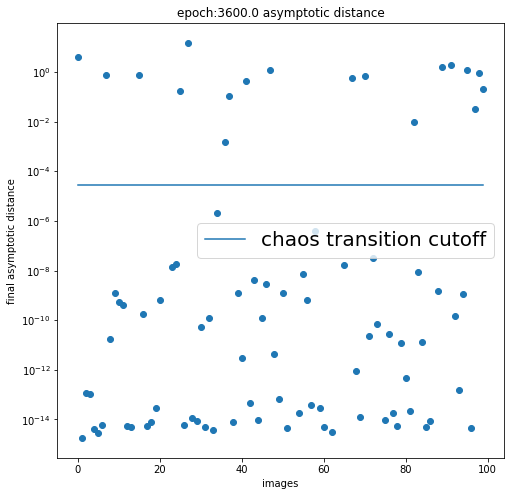

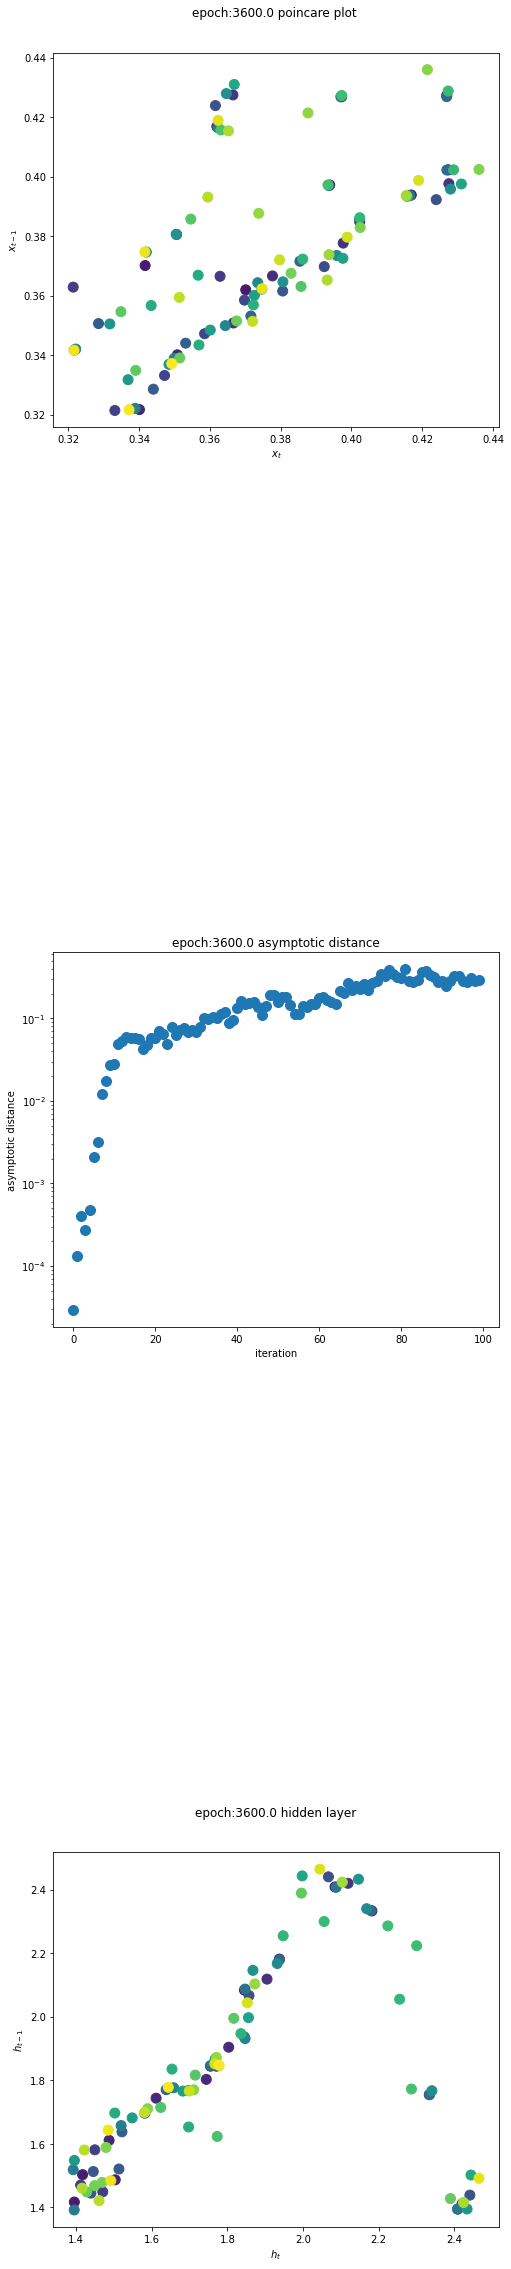

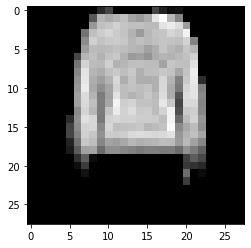

asymptotic image output epoch:3600.jpg
epoch : 3601/10000, training loss = 0.014871,validation loss = 0.019408
epoch : 3602/10000, training loss = 0.014458,validation loss = 0.019461
epoch : 3603/10000, training loss = 0.014717,validation loss = 0.019651
epoch : 3604/10000, training loss = 0.014686,validation loss = 0.019380
epoch : 3605/10000, training loss = 0.014623,validation loss = 0.019411
epoch : 3606/10000, training loss = 0.014606,validation loss = 0.019663
epoch : 3607/10000, training loss = 0.014625,validation loss = 0.019701
epoch : 3608/10000, training loss = 0.014889,validation loss = 0.019323
epoch : 3609/10000, training loss = 0.015304,validation loss = 0.019514
epoch : 3610/10000, training loss = 0.014765,validation loss = 0.019457
epoch : 3611/10000, training loss = 0.014598,validation loss = 0.019508
epoch : 3612/10000, training loss = 0.014516,validation loss = 0.019529
epoch : 3613/10000, training loss = 0.014896,validation loss = 0.019594
epoch : 3614/10000, train

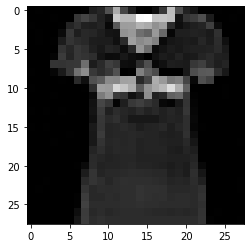

asymptotic image input epoch:3650.jpg


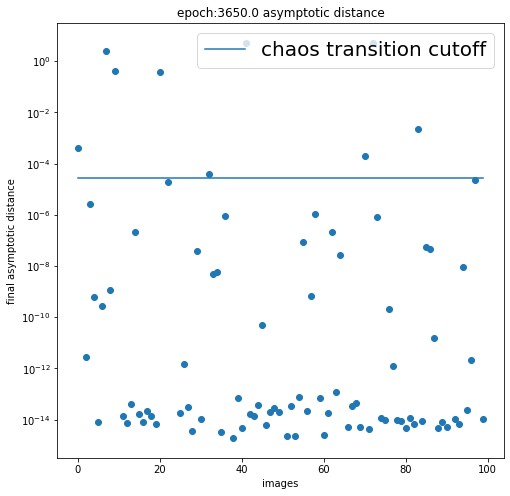

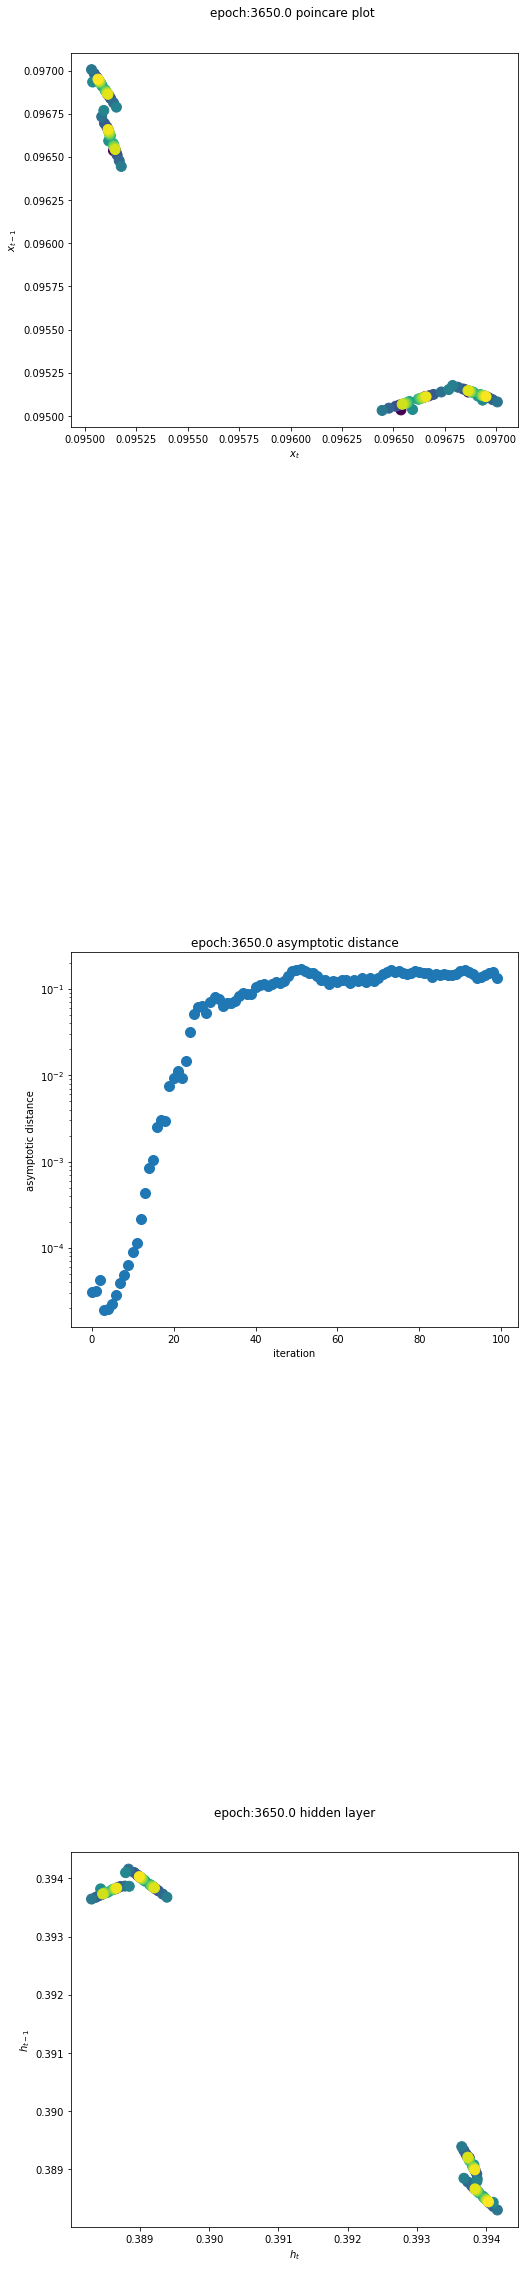

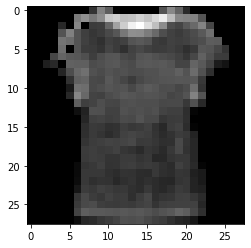

asymptotic image output epoch:3650.jpg
epoch : 3651/10000, training loss = 0.014617,validation loss = 0.019463
epoch : 3652/10000, training loss = 0.015017,validation loss = 0.019504
epoch : 3653/10000, training loss = 0.014833,validation loss = 0.019379
epoch : 3654/10000, training loss = 0.014612,validation loss = 0.019367
epoch : 3655/10000, training loss = 0.014607,validation loss = 0.019613
epoch : 3656/10000, training loss = 0.014864,validation loss = 0.019517
epoch : 3657/10000, training loss = 0.014834,validation loss = 0.019615
epoch : 3658/10000, training loss = 0.015054,validation loss = 0.019396
epoch : 3659/10000, training loss = 0.014743,validation loss = 0.019466
epoch : 3660/10000, training loss = 0.014727,validation loss = 0.019418
epoch : 3661/10000, training loss = 0.014641,validation loss = 0.019598
epoch : 3662/10000, training loss = 0.014812,validation loss = 0.019910
epoch : 3663/10000, training loss = 0.015221,validation loss = 0.019621
epoch : 3664/10000, train

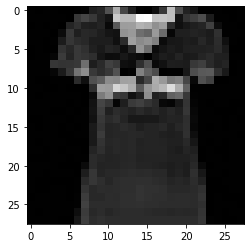

asymptotic image input epoch:3700.jpg


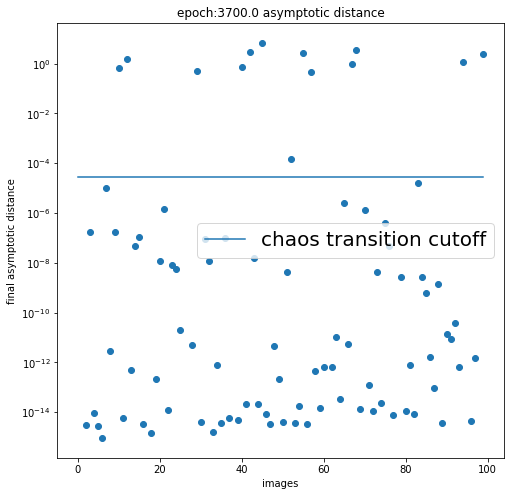

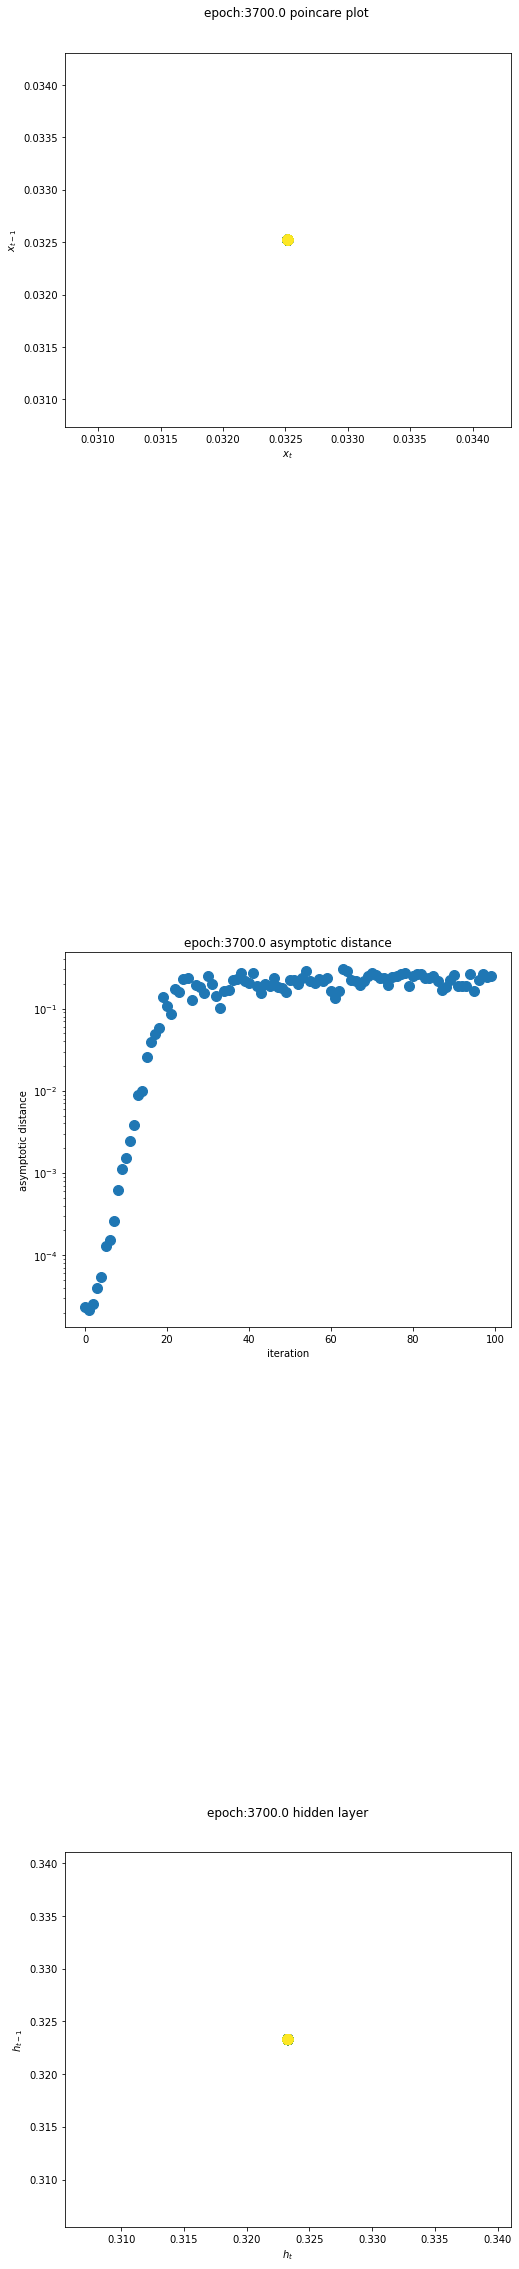

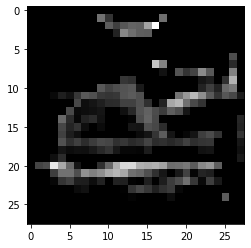

asymptotic image output epoch:3700.jpg
epoch : 3701/10000, training loss = 0.014564,validation loss = 0.019558
epoch : 3702/10000, training loss = 0.014637,validation loss = 0.019457
epoch : 3703/10000, training loss = 0.014603,validation loss = 0.019353
epoch : 3704/10000, training loss = 0.014558,validation loss = 0.019966
epoch : 3705/10000, training loss = 0.014983,validation loss = 0.019459
epoch : 3706/10000, training loss = 0.015122,validation loss = 0.019452
epoch : 3707/10000, training loss = 0.014599,validation loss = 0.019349
epoch : 3708/10000, training loss = 0.014493,validation loss = 0.019395
epoch : 3709/10000, training loss = 0.014603,validation loss = 0.019573
epoch : 3710/10000, training loss = 0.014654,validation loss = 0.019390
epoch : 3711/10000, training loss = 0.014598,validation loss = 0.019502
epoch : 3712/10000, training loss = 0.015026,validation loss = 0.019704
epoch : 3713/10000, training loss = 0.014883,validation loss = 0.019551
epoch : 3714/10000, train

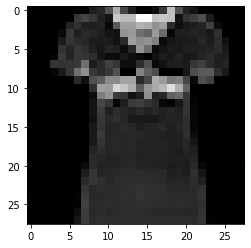

asymptotic image input epoch:3750.jpg


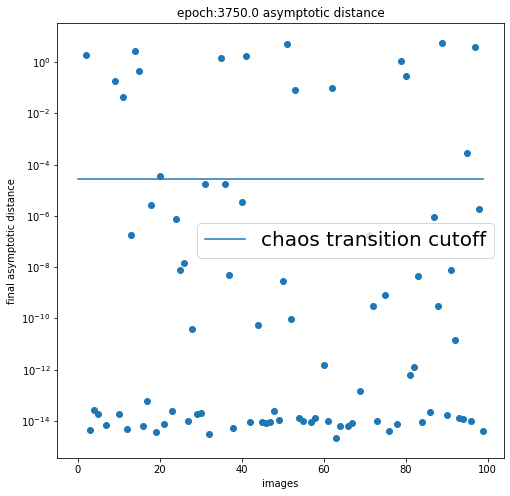

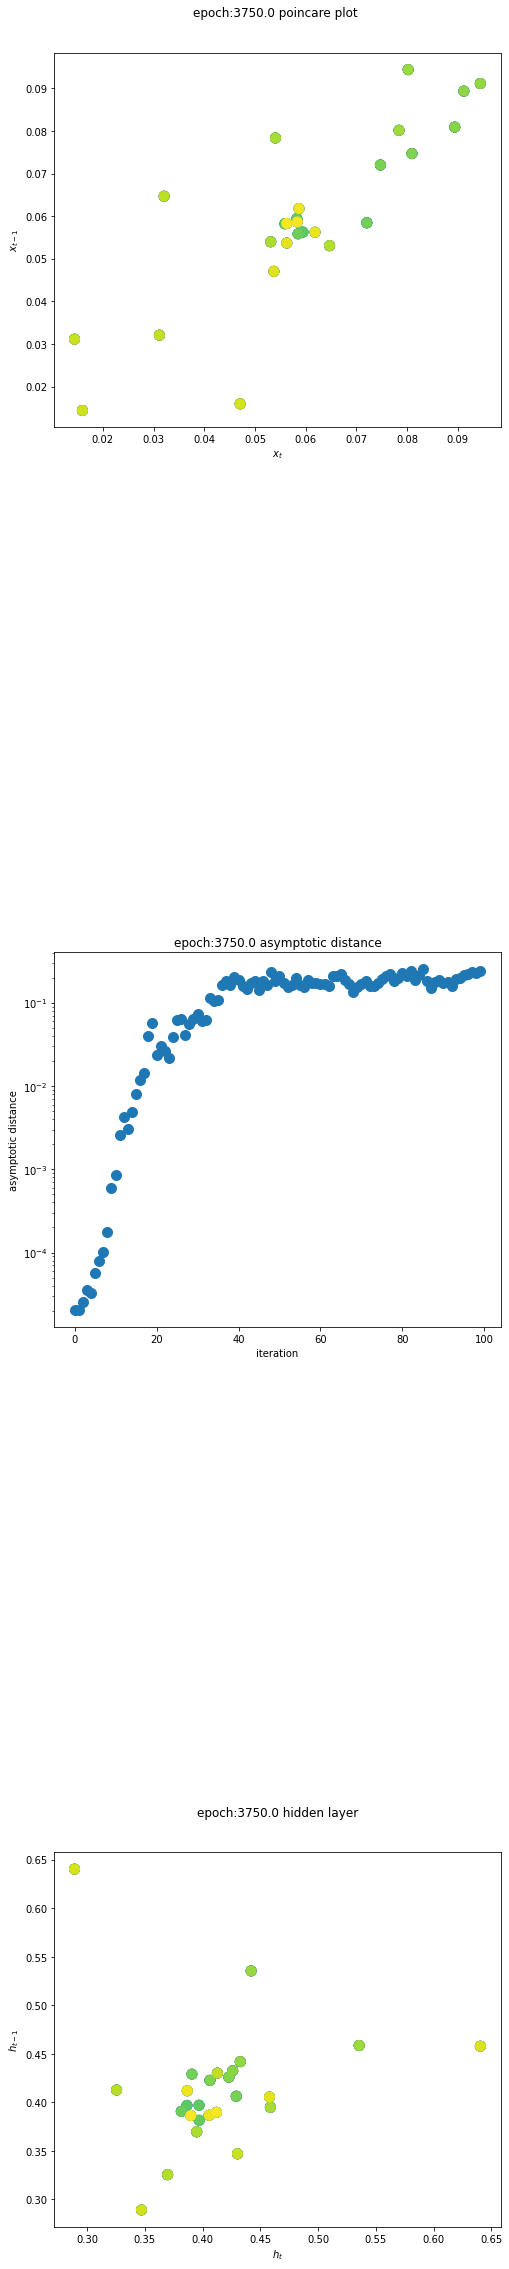

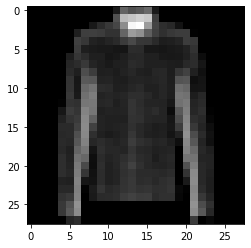

asymptotic image output epoch:3750.jpg
epoch : 3751/10000, training loss = 0.014516,validation loss = 0.019286
epoch : 3752/10000, training loss = 0.014458,validation loss = 0.019415
epoch : 3753/10000, training loss = 0.014750,validation loss = 0.019478
epoch : 3754/10000, training loss = 0.014701,validation loss = 0.019331
epoch : 3755/10000, training loss = 0.014584,validation loss = 0.019531
epoch : 3756/10000, training loss = 0.014655,validation loss = 0.019344
epoch : 3757/10000, training loss = 0.014718,validation loss = 0.019324
epoch : 3758/10000, training loss = 0.014649,validation loss = 0.019404
epoch : 3759/10000, training loss = 0.014793,validation loss = 0.019582
epoch : 3760/10000, training loss = 0.014531,validation loss = 0.019541
epoch : 3761/10000, training loss = 0.014749,validation loss = 0.019536
epoch : 3762/10000, training loss = 0.014697,validation loss = 0.019407
epoch : 3763/10000, training loss = 0.014695,validation loss = 0.019273
epoch : 3764/10000, train

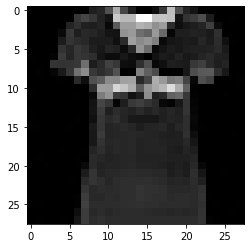

asymptotic image input epoch:3800.jpg


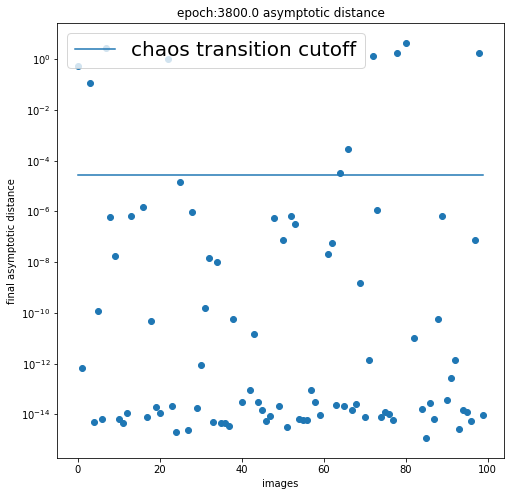

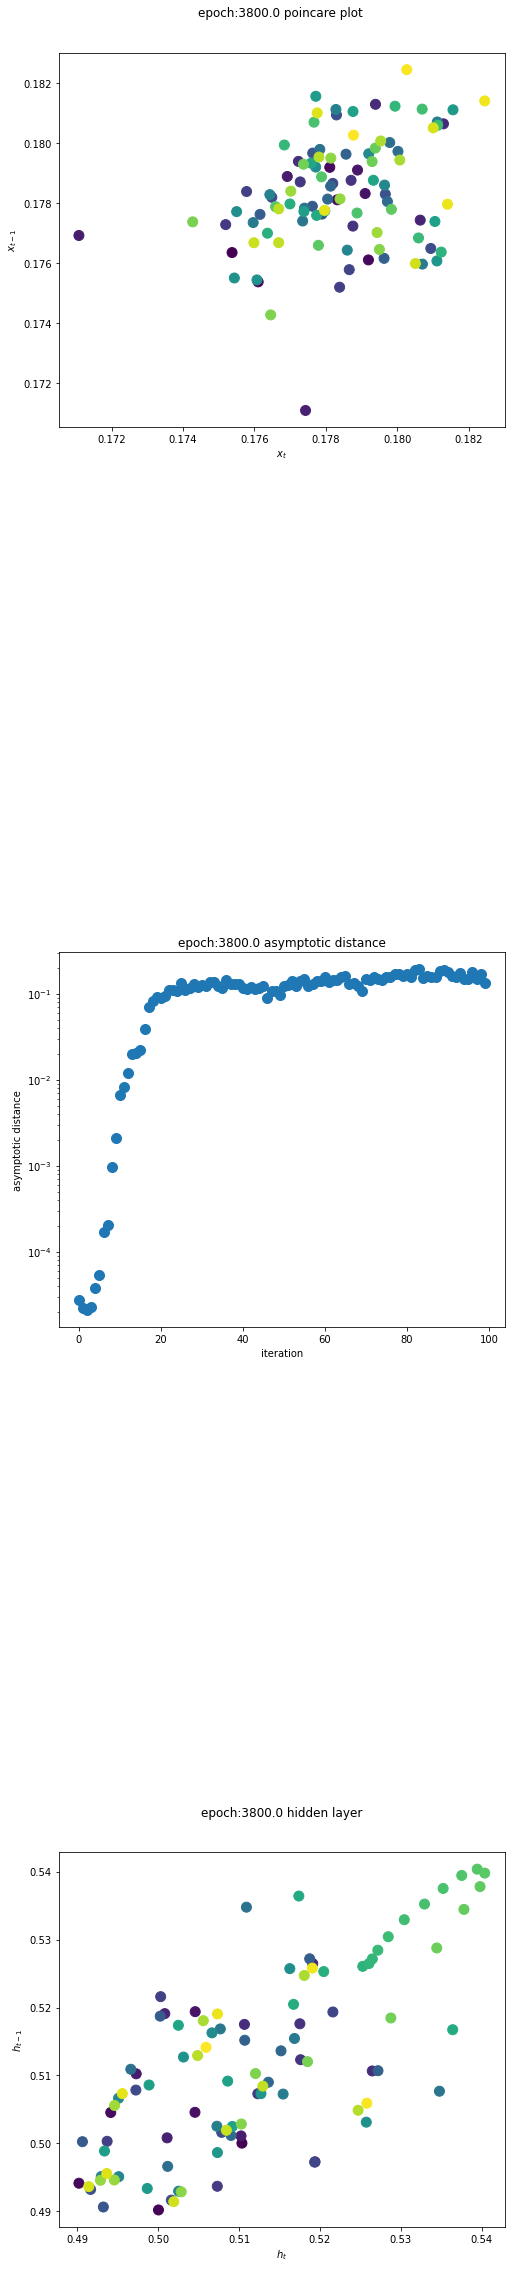

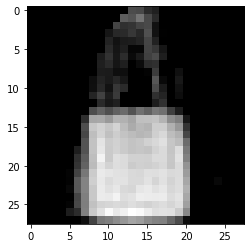

asymptotic image output epoch:3800.jpg
epoch : 3801/10000, training loss = 0.014506,validation loss = 0.019406
epoch : 3802/10000, training loss = 0.014811,validation loss = 0.019568
epoch : 3803/10000, training loss = 0.014764,validation loss = 0.019534
epoch : 3804/10000, training loss = 0.014822,validation loss = 0.019467
epoch : 3805/10000, training loss = 0.014737,validation loss = 0.019675
epoch : 3806/10000, training loss = 0.014913,validation loss = 0.019626
epoch : 3807/10000, training loss = 0.014754,validation loss = 0.019448
epoch : 3808/10000, training loss = 0.014487,validation loss = 0.019418
epoch : 3809/10000, training loss = 0.014592,validation loss = 0.019388
epoch : 3810/10000, training loss = 0.014654,validation loss = 0.019403
epoch : 3811/10000, training loss = 0.014723,validation loss = 0.019527
epoch : 3812/10000, training loss = 0.014676,validation loss = 0.019495
epoch : 3813/10000, training loss = 0.014634,validation loss = 0.019622
epoch : 3814/10000, train

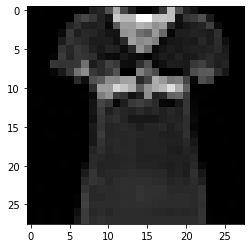

asymptotic image input epoch:3850.jpg


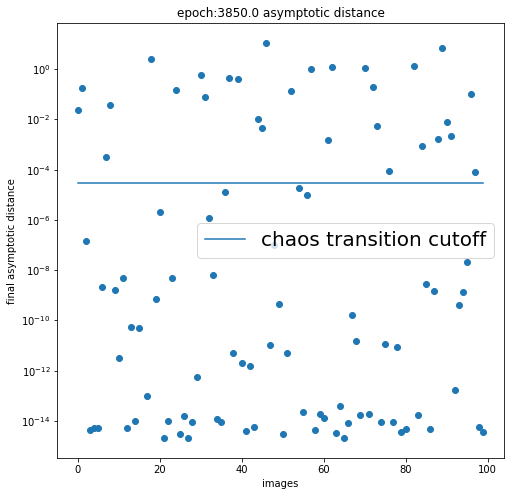

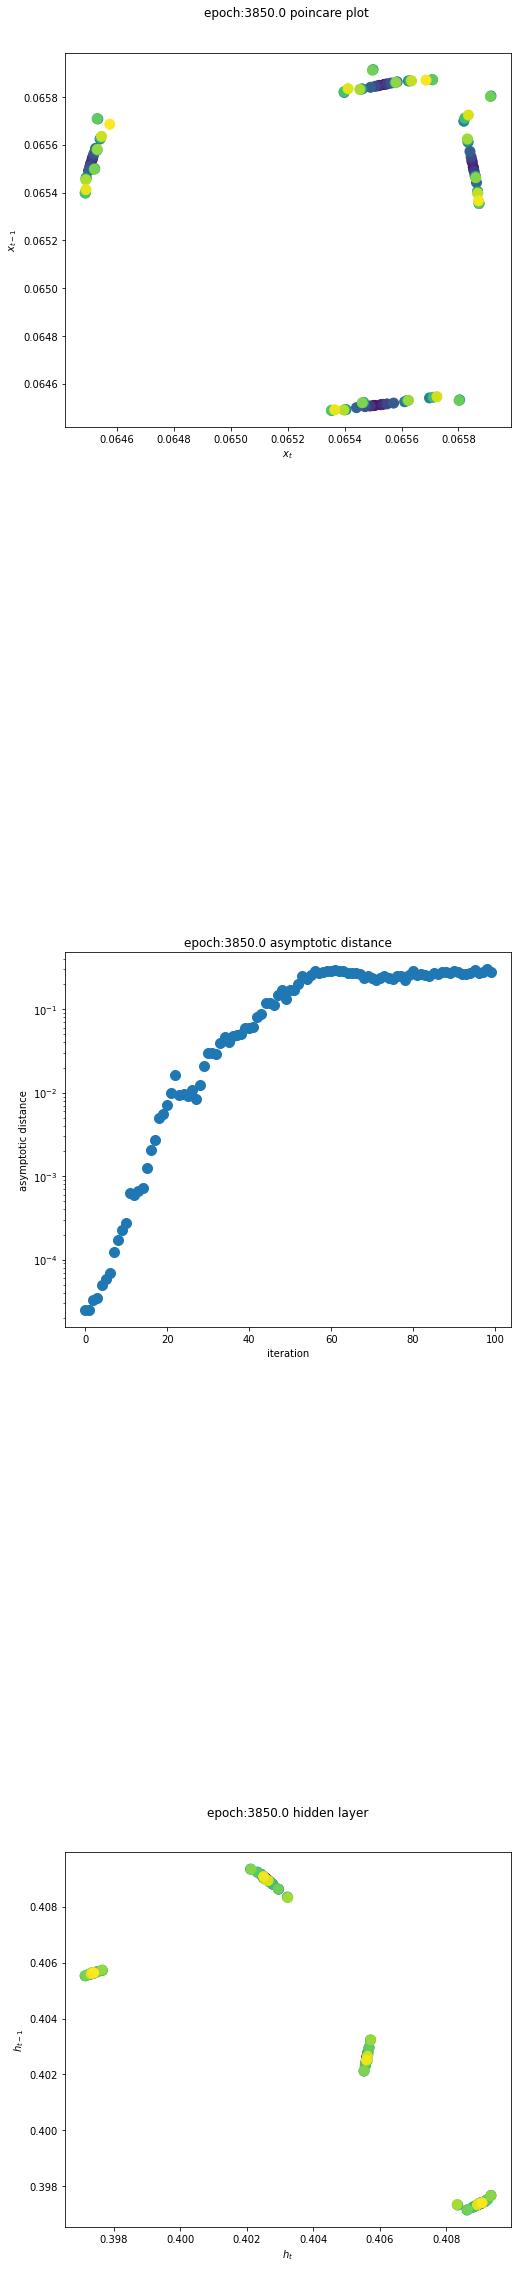

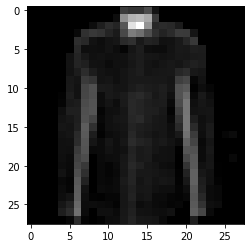

asymptotic image output epoch:3850.jpg
epoch : 3851/10000, training loss = 0.014596,validation loss = 0.019265
epoch : 3852/10000, training loss = 0.014631,validation loss = 0.019333
epoch : 3853/10000, training loss = 0.014497,validation loss = 0.019427
epoch : 3854/10000, training loss = 0.014856,validation loss = 0.019600
epoch : 3855/10000, training loss = 0.014677,validation loss = 0.019288
epoch : 3856/10000, training loss = 0.014622,validation loss = 0.019383
epoch : 3857/10000, training loss = 0.014582,validation loss = 0.019375
epoch : 3858/10000, training loss = 0.014716,validation loss = 0.019476
epoch : 3859/10000, training loss = 0.014706,validation loss = 0.019463
epoch : 3860/10000, training loss = 0.014678,validation loss = 0.019293
epoch : 3861/10000, training loss = 0.014602,validation loss = 0.019357
epoch : 3862/10000, training loss = 0.014782,validation loss = 0.019318
epoch : 3863/10000, training loss = 0.014708,validation loss = 0.019264
epoch : 3864/10000, train

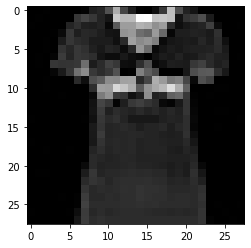

asymptotic image input epoch:3900.jpg


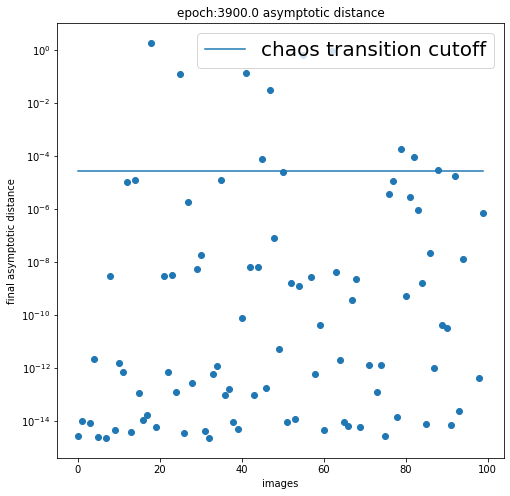

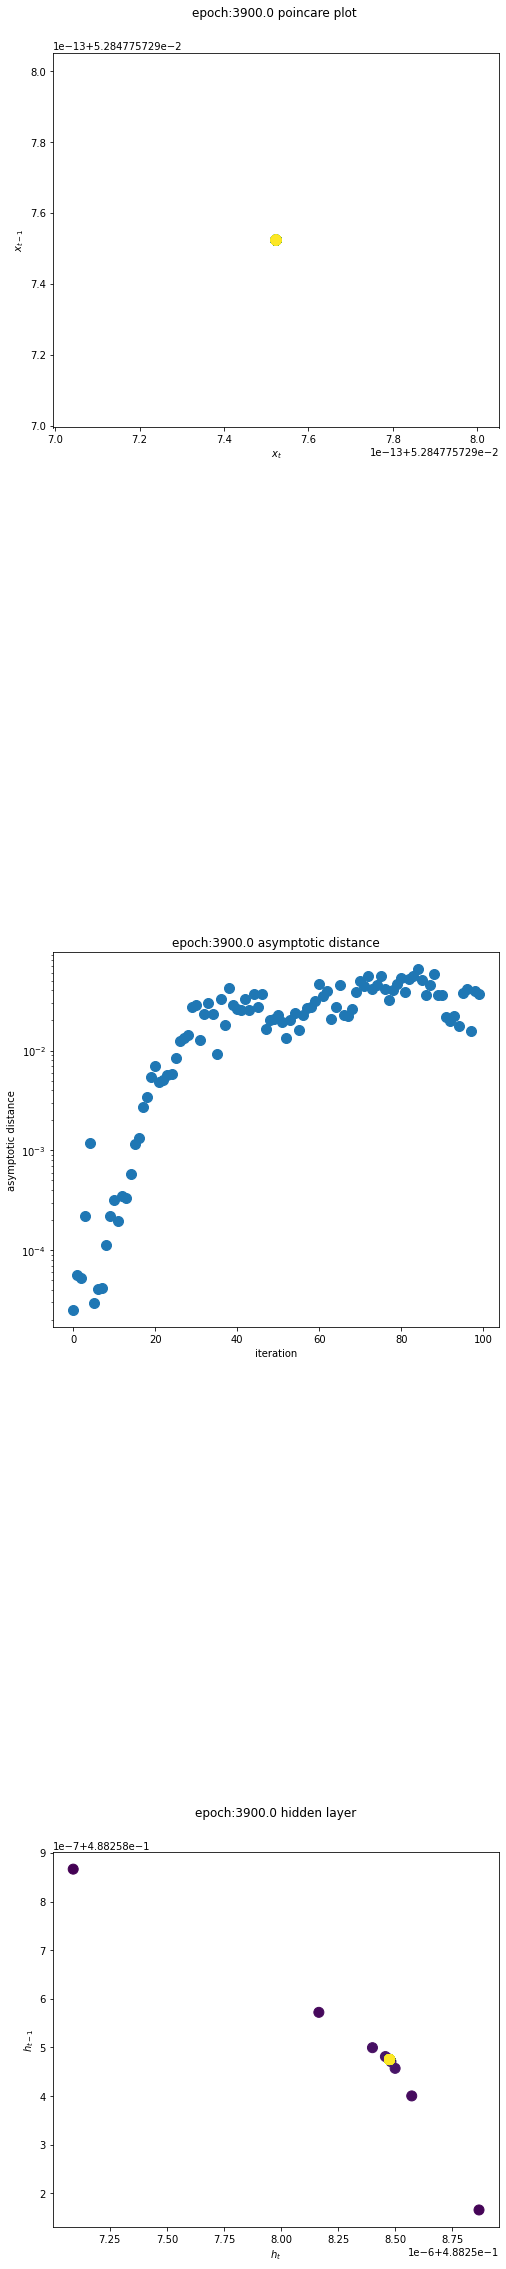

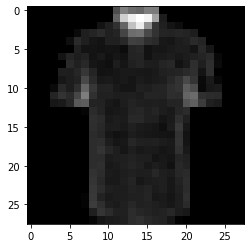

asymptotic image output epoch:3900.jpg
epoch : 3901/10000, training loss = 0.014761,validation loss = 0.019792
epoch : 3902/10000, training loss = 0.014660,validation loss = 0.019396
epoch : 3903/10000, training loss = 0.014715,validation loss = 0.019428
epoch : 3904/10000, training loss = 0.015133,validation loss = 0.019469
epoch : 3905/10000, training loss = 0.014773,validation loss = 0.019436
epoch : 3906/10000, training loss = 0.014542,validation loss = 0.019416
epoch : 3907/10000, training loss = 0.014492,validation loss = 0.019589
epoch : 3908/10000, training loss = 0.014674,validation loss = 0.019376
epoch : 3909/10000, training loss = 0.014532,validation loss = 0.019507
epoch : 3910/10000, training loss = 0.014520,validation loss = 0.019409
epoch : 3911/10000, training loss = 0.014807,validation loss = 0.019822
epoch : 3912/10000, training loss = 0.014764,validation loss = 0.019423
epoch : 3913/10000, training loss = 0.014532,validation loss = 0.019578
epoch : 3914/10000, train

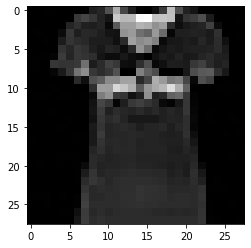

asymptotic image input epoch:3950.jpg


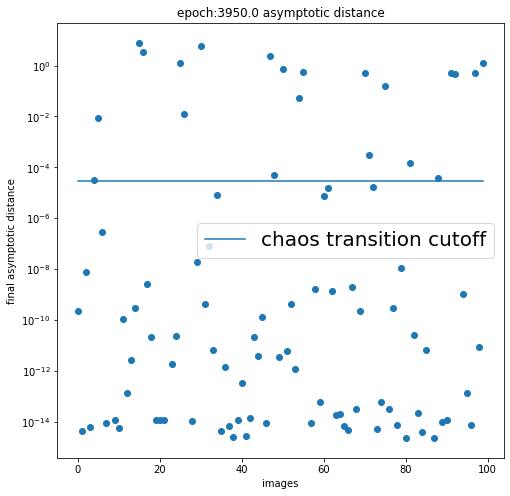

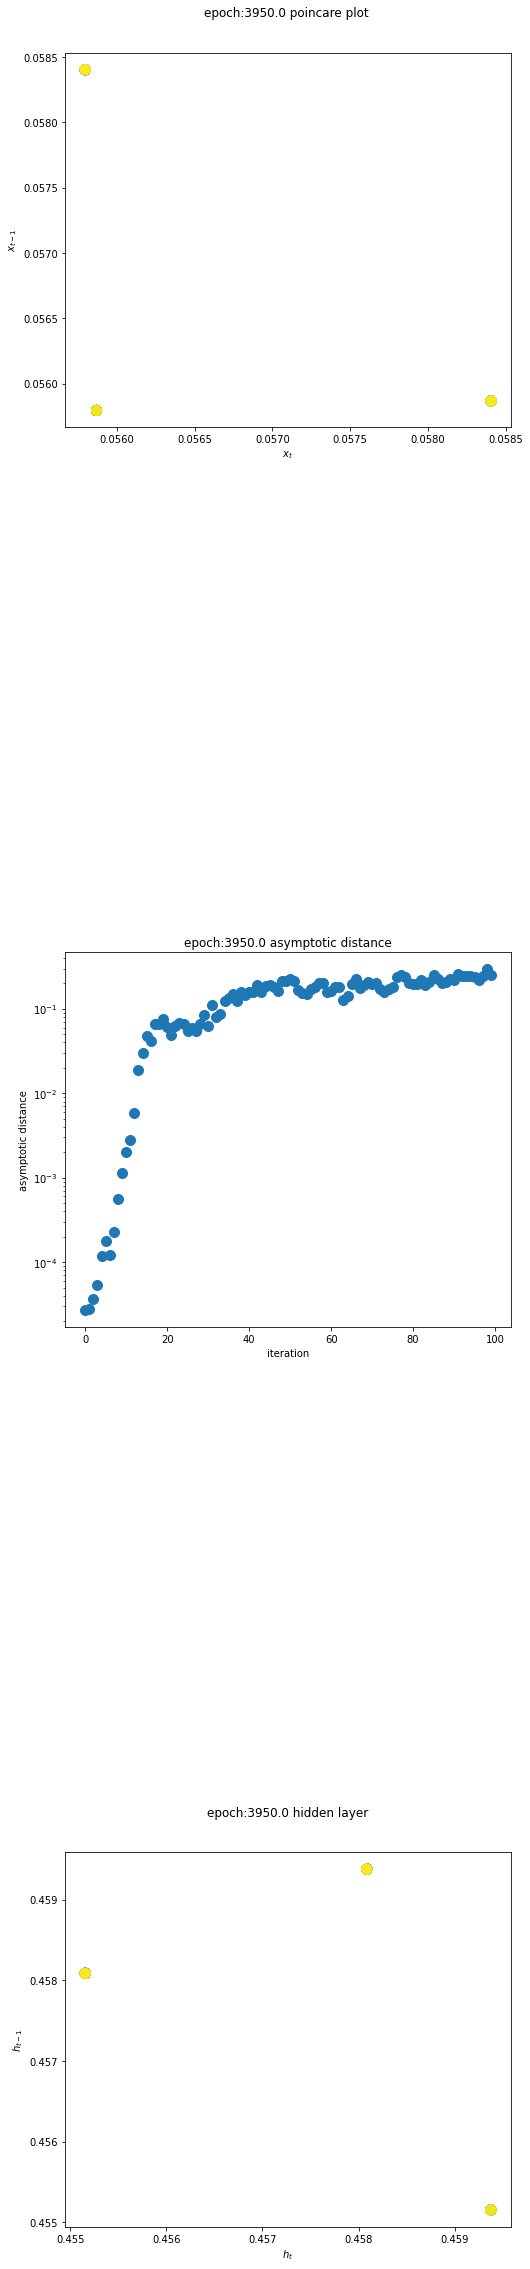

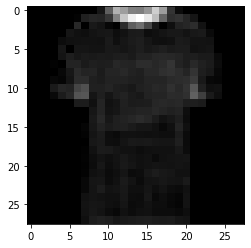

asymptotic image output epoch:3950.jpg
epoch : 3951/10000, training loss = 0.014593,validation loss = 0.019310
epoch : 3952/10000, training loss = 0.014449,validation loss = 0.019339
epoch : 3953/10000, training loss = 0.014812,validation loss = 0.019560
epoch : 3954/10000, training loss = 0.015108,validation loss = 0.019401
epoch : 3955/10000, training loss = 0.015005,validation loss = 0.019594
epoch : 3956/10000, training loss = 0.014894,validation loss = 0.019593
epoch : 3957/10000, training loss = 0.015093,validation loss = 0.019482
epoch : 3958/10000, training loss = 0.014598,validation loss = 0.019388
epoch : 3959/10000, training loss = 0.014525,validation loss = 0.019431
epoch : 3960/10000, training loss = 0.014731,validation loss = 0.019451
epoch : 3961/10000, training loss = 0.014800,validation loss = 0.019440
epoch : 3962/10000, training loss = 0.014865,validation loss = 0.019581
epoch : 3963/10000, training loss = 0.014910,validation loss = 0.019411
epoch : 3964/10000, train

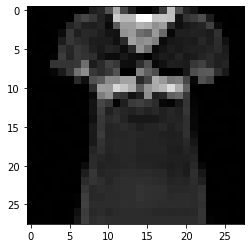

asymptotic image input epoch:4000.jpg


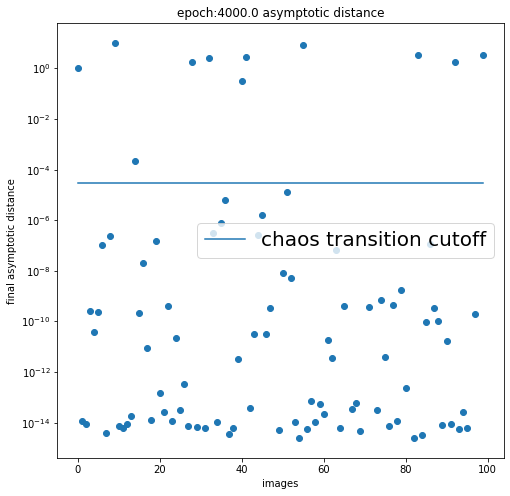

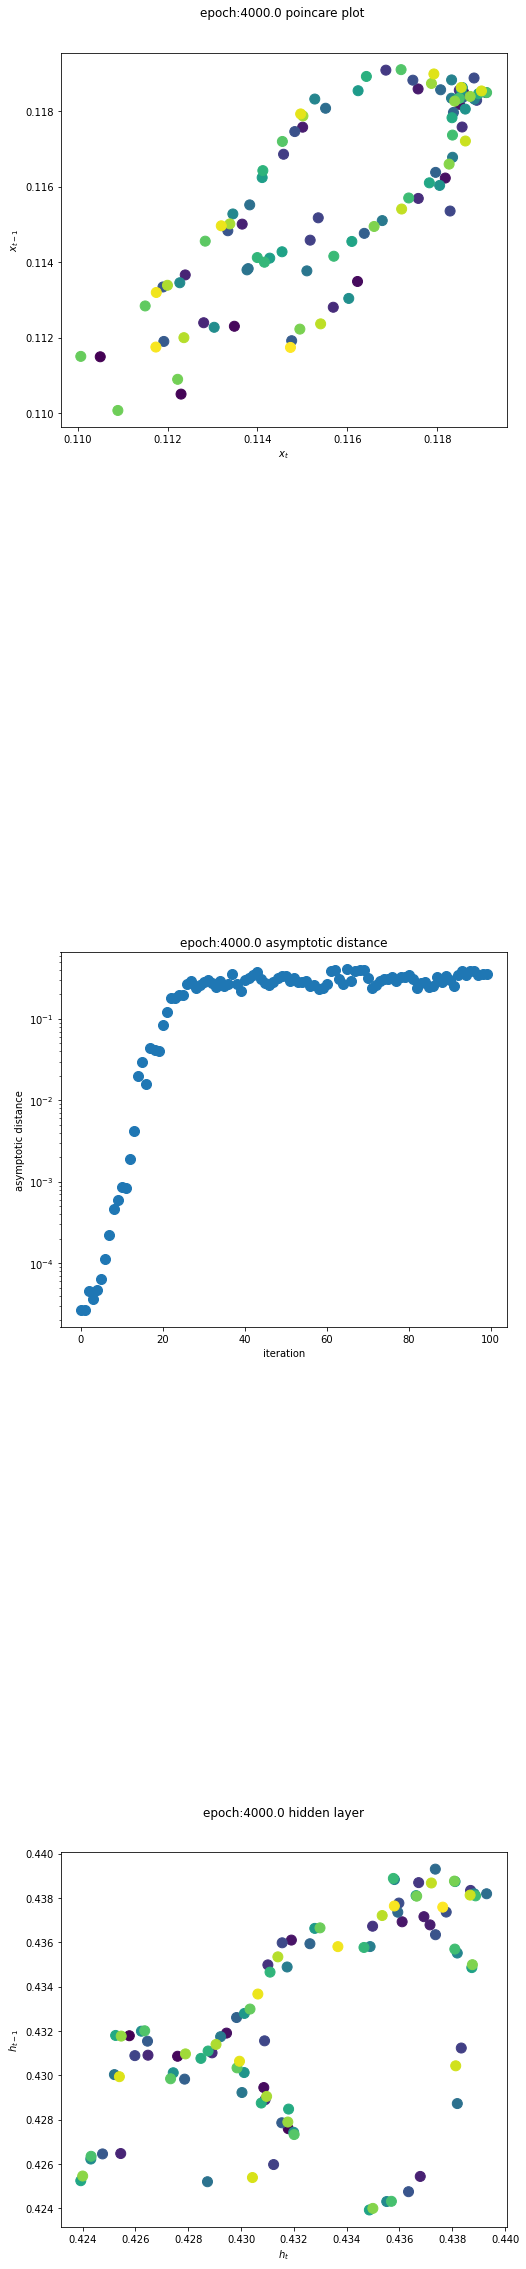

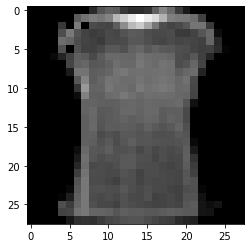

asymptotic image output epoch:4000.jpg
epoch : 4001/10000, training loss = 0.014539,validation loss = 0.019580
epoch : 4002/10000, training loss = 0.014544,validation loss = 0.019445
epoch : 4003/10000, training loss = 0.014703,validation loss = 0.019684
epoch : 4004/10000, training loss = 0.014762,validation loss = 0.019651
epoch : 4005/10000, training loss = 0.014782,validation loss = 0.019624
epoch : 4006/10000, training loss = 0.014612,validation loss = 0.019353
epoch : 4007/10000, training loss = 0.014616,validation loss = 0.019529
epoch : 4008/10000, training loss = 0.014498,validation loss = 0.019604
epoch : 4009/10000, training loss = 0.014605,validation loss = 0.019501
epoch : 4010/10000, training loss = 0.014734,validation loss = 0.019528
epoch : 4011/10000, training loss = 0.015005,validation loss = 0.019558
epoch : 4012/10000, training loss = 0.014760,validation loss = 0.019427
epoch : 4013/10000, training loss = 0.014544,validation loss = 0.019509
epoch : 4014/10000, train

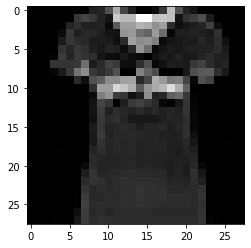

asymptotic image input epoch:4050.jpg


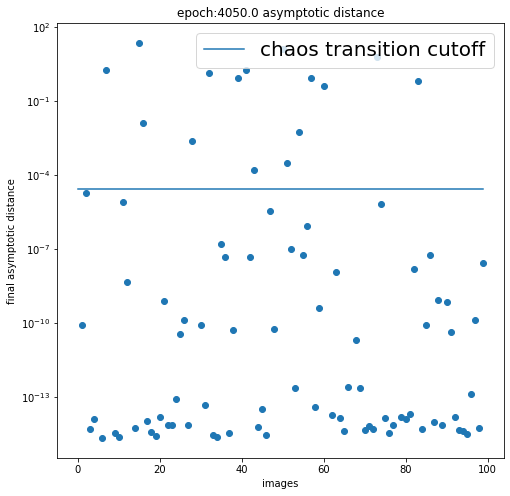

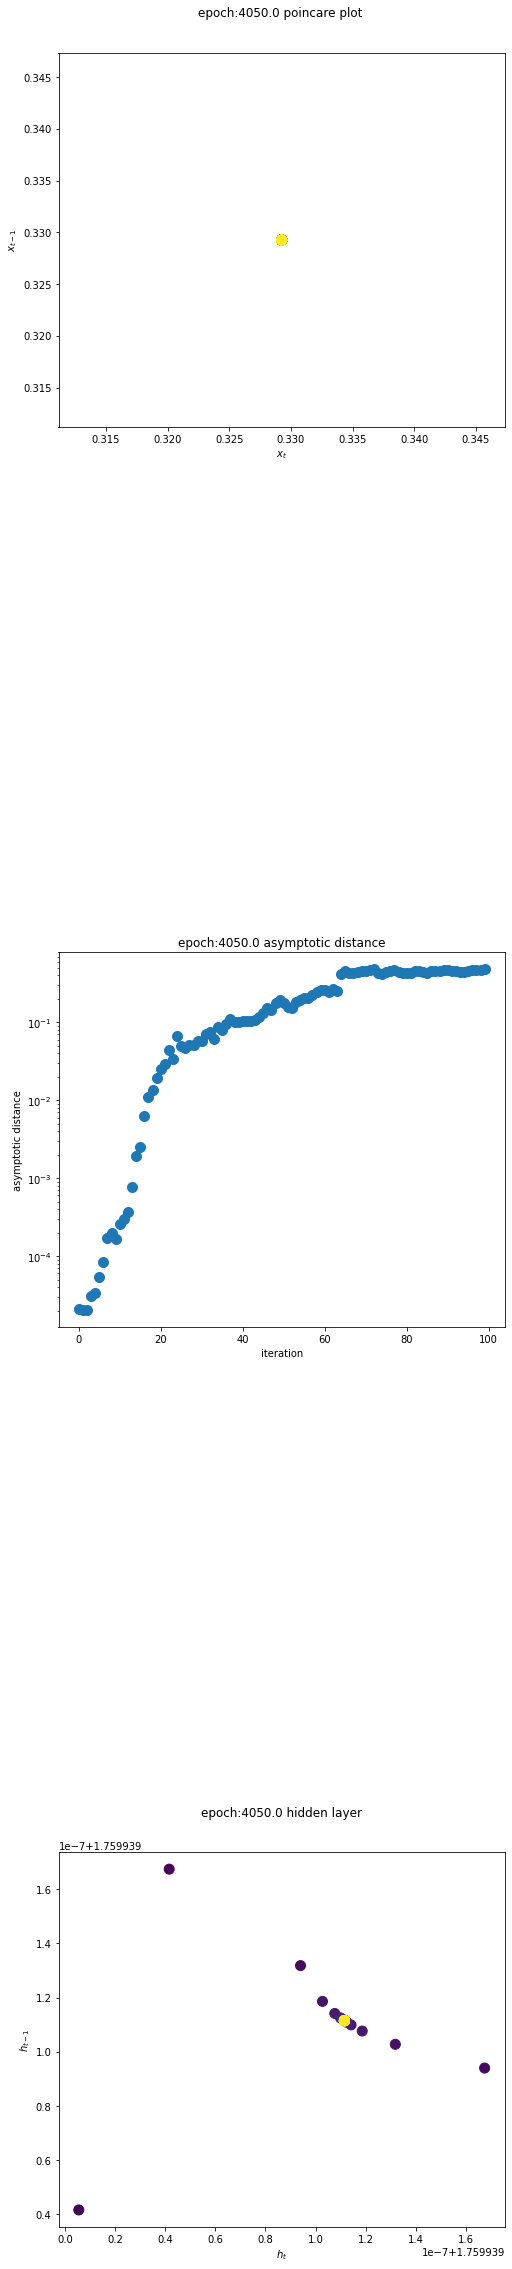

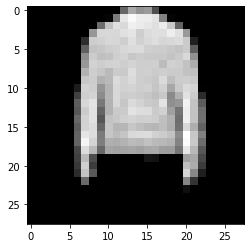

asymptotic image output epoch:4050.jpg
epoch : 4051/10000, training loss = 0.014637,validation loss = 0.019621
epoch : 4052/10000, training loss = 0.014647,validation loss = 0.019627
epoch : 4053/10000, training loss = 0.014588,validation loss = 0.019548
epoch : 4054/10000, training loss = 0.014546,validation loss = 0.019496
epoch : 4055/10000, training loss = 0.014454,validation loss = 0.019549
epoch : 4056/10000, training loss = 0.014482,validation loss = 0.019695
epoch : 4057/10000, training loss = 0.015054,validation loss = 0.019516
epoch : 4058/10000, training loss = 0.014592,validation loss = 0.019494
epoch : 4059/10000, training loss = 0.014683,validation loss = 0.019551
epoch : 4060/10000, training loss = 0.014601,validation loss = 0.019637
epoch : 4061/10000, training loss = 0.014972,validation loss = 0.019787
epoch : 4062/10000, training loss = 0.014870,validation loss = 0.019501
epoch : 4063/10000, training loss = 0.014721,validation loss = 0.019554
epoch : 4064/10000, train

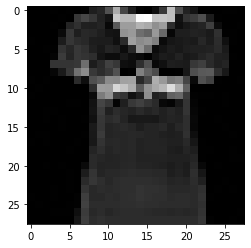

asymptotic image input epoch:4100.jpg


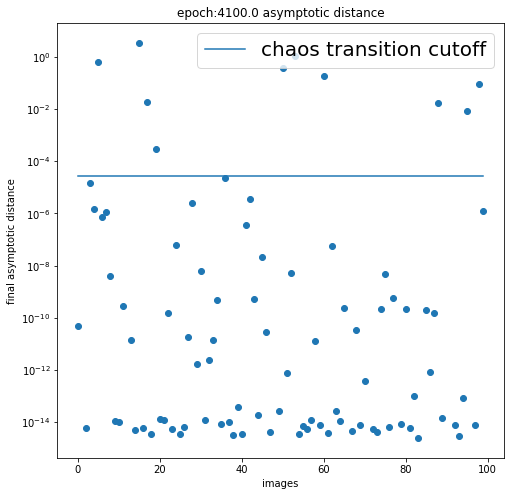

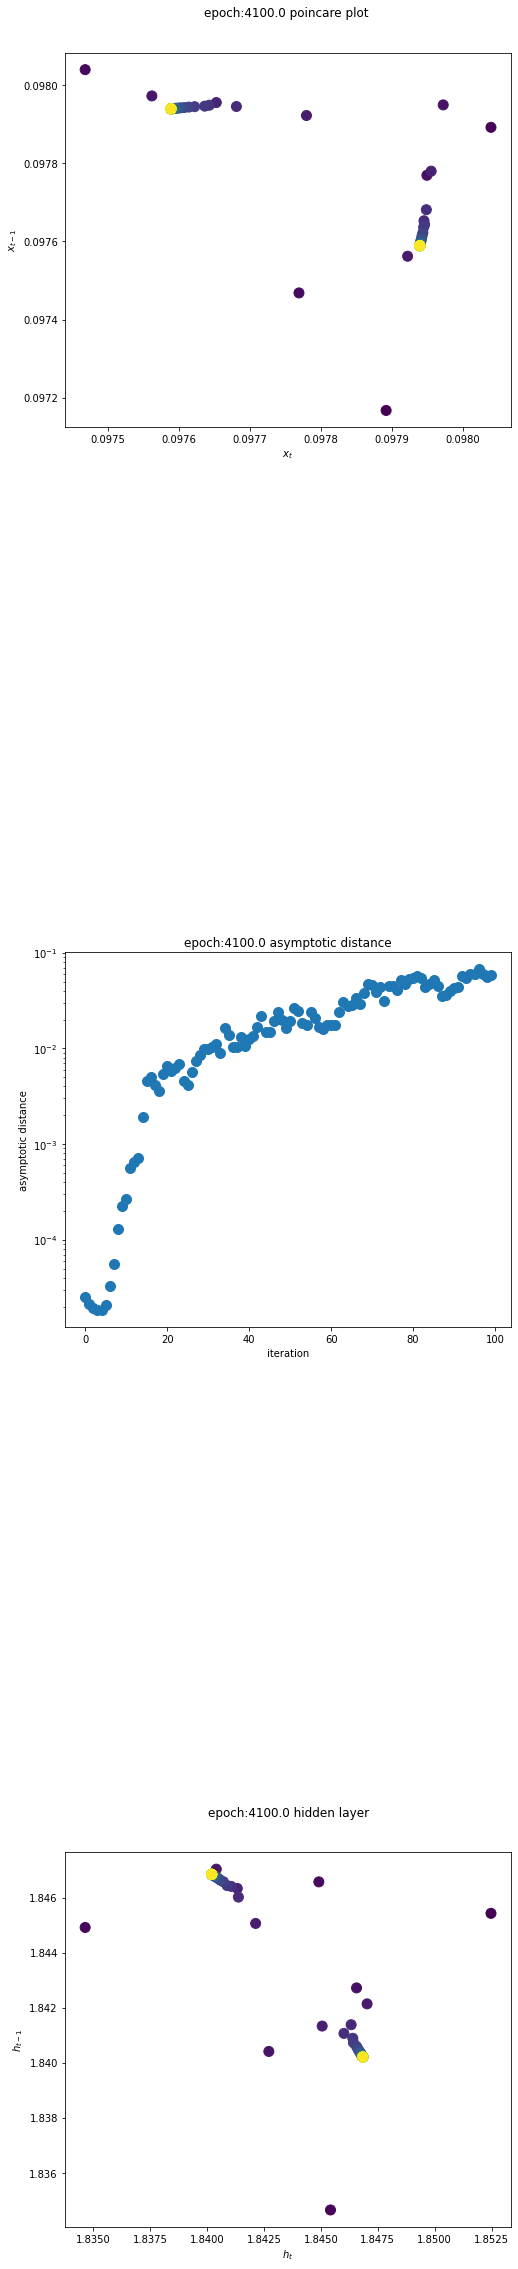

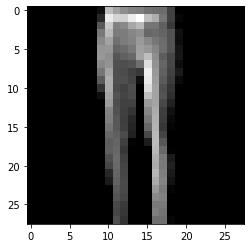

asymptotic image output epoch:4100.jpg
epoch : 4101/10000, training loss = 0.014747,validation loss = 0.019631
epoch : 4102/10000, training loss = 0.014539,validation loss = 0.019360
epoch : 4103/10000, training loss = 0.014791,validation loss = 0.019600
epoch : 4104/10000, training loss = 0.014673,validation loss = 0.019659
epoch : 4105/10000, training loss = 0.014700,validation loss = 0.019458
epoch : 4106/10000, training loss = 0.014606,validation loss = 0.019529
epoch : 4107/10000, training loss = 0.014842,validation loss = 0.019600
epoch : 4108/10000, training loss = 0.014703,validation loss = 0.019470
epoch : 4109/10000, training loss = 0.014648,validation loss = 0.019498
epoch : 4110/10000, training loss = 0.014885,validation loss = 0.019397
epoch : 4111/10000, training loss = 0.014587,validation loss = 0.019588
epoch : 4112/10000, training loss = 0.014431,validation loss = 0.019574
epoch : 4113/10000, training loss = 0.014494,validation loss = 0.019392
epoch : 4114/10000, train

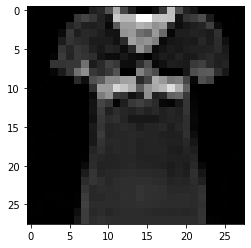

asymptotic image input epoch:4150.jpg


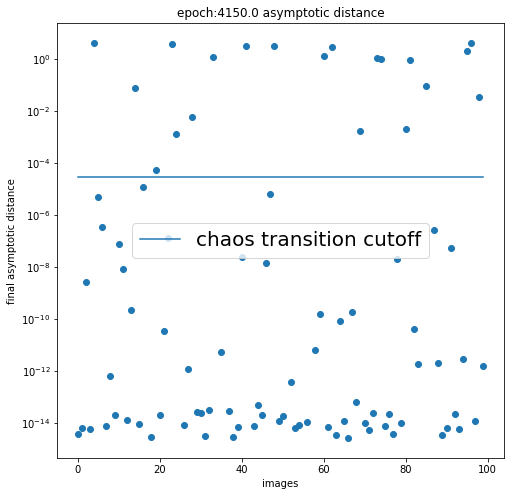

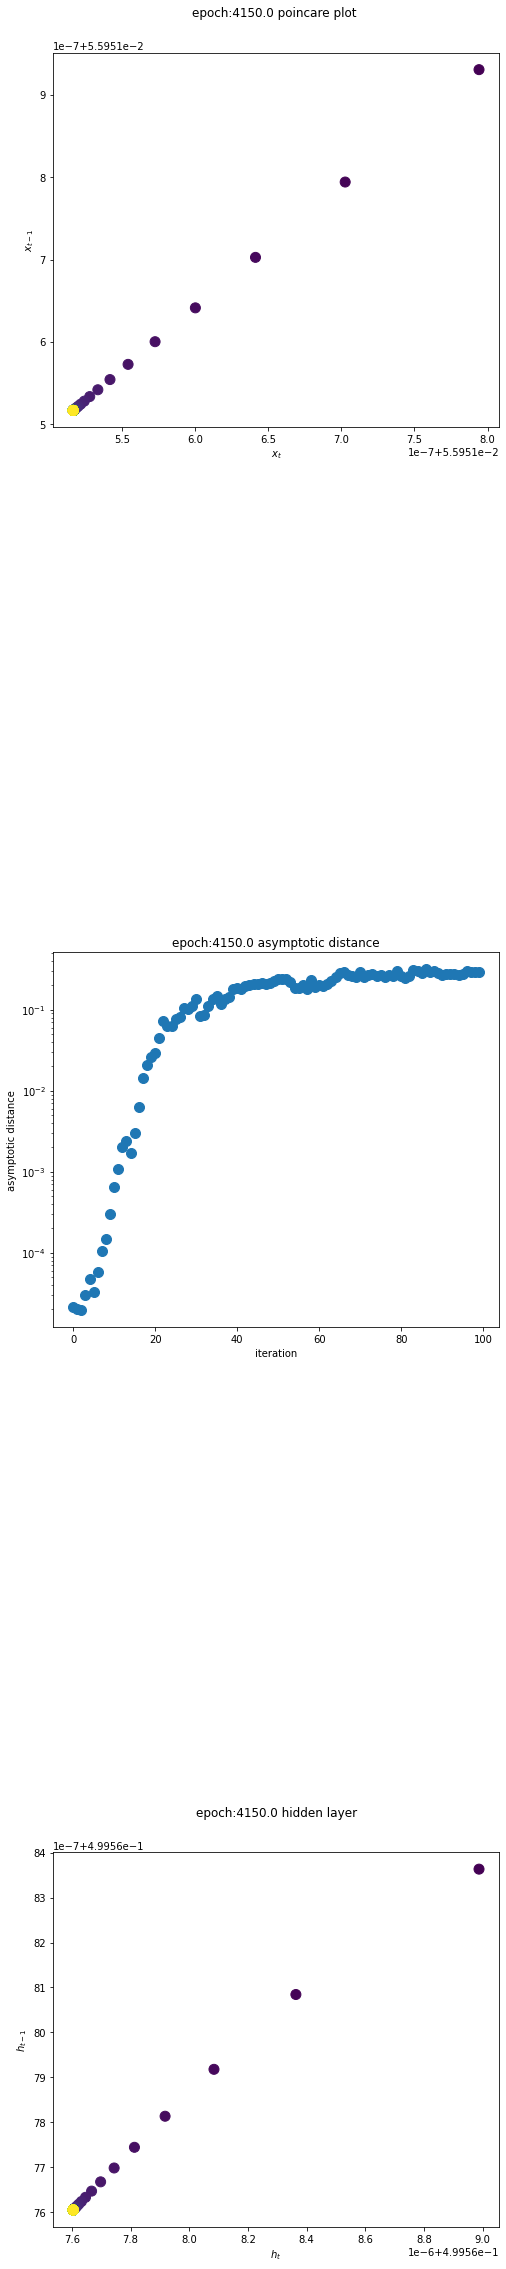

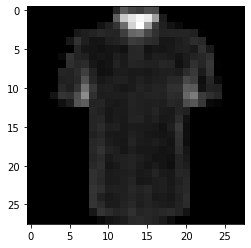

asymptotic image output epoch:4150.jpg
epoch : 4151/10000, training loss = 0.014492,validation loss = 0.019412
epoch : 4152/10000, training loss = 0.014528,validation loss = 0.019518
epoch : 4153/10000, training loss = 0.014878,validation loss = 0.019527
epoch : 4154/10000, training loss = 0.014713,validation loss = 0.019534
epoch : 4155/10000, training loss = 0.014426,validation loss = 0.019559
epoch : 4156/10000, training loss = 0.014442,validation loss = 0.019633
epoch : 4157/10000, training loss = 0.014769,validation loss = 0.019909
epoch : 4158/10000, training loss = 0.014754,validation loss = 0.019414
epoch : 4159/10000, training loss = 0.014799,validation loss = 0.019614
epoch : 4160/10000, training loss = 0.014705,validation loss = 0.019572
epoch : 4161/10000, training loss = 0.014639,validation loss = 0.019496
epoch : 4162/10000, training loss = 0.014660,validation loss = 0.019484
epoch : 4163/10000, training loss = 0.015047,validation loss = 0.019451
epoch : 4164/10000, train

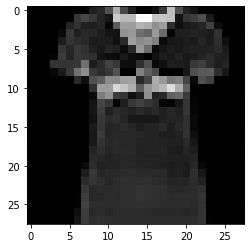

asymptotic image input epoch:4200.jpg


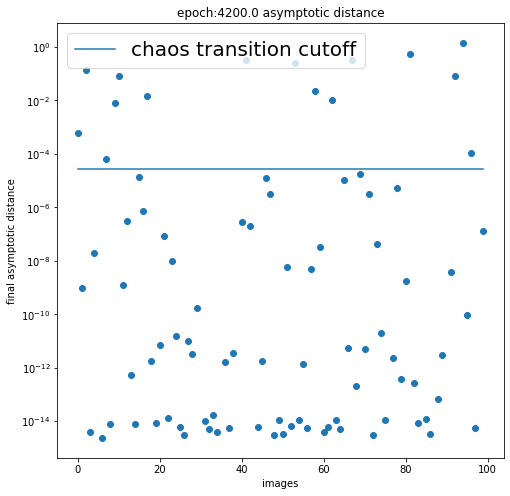

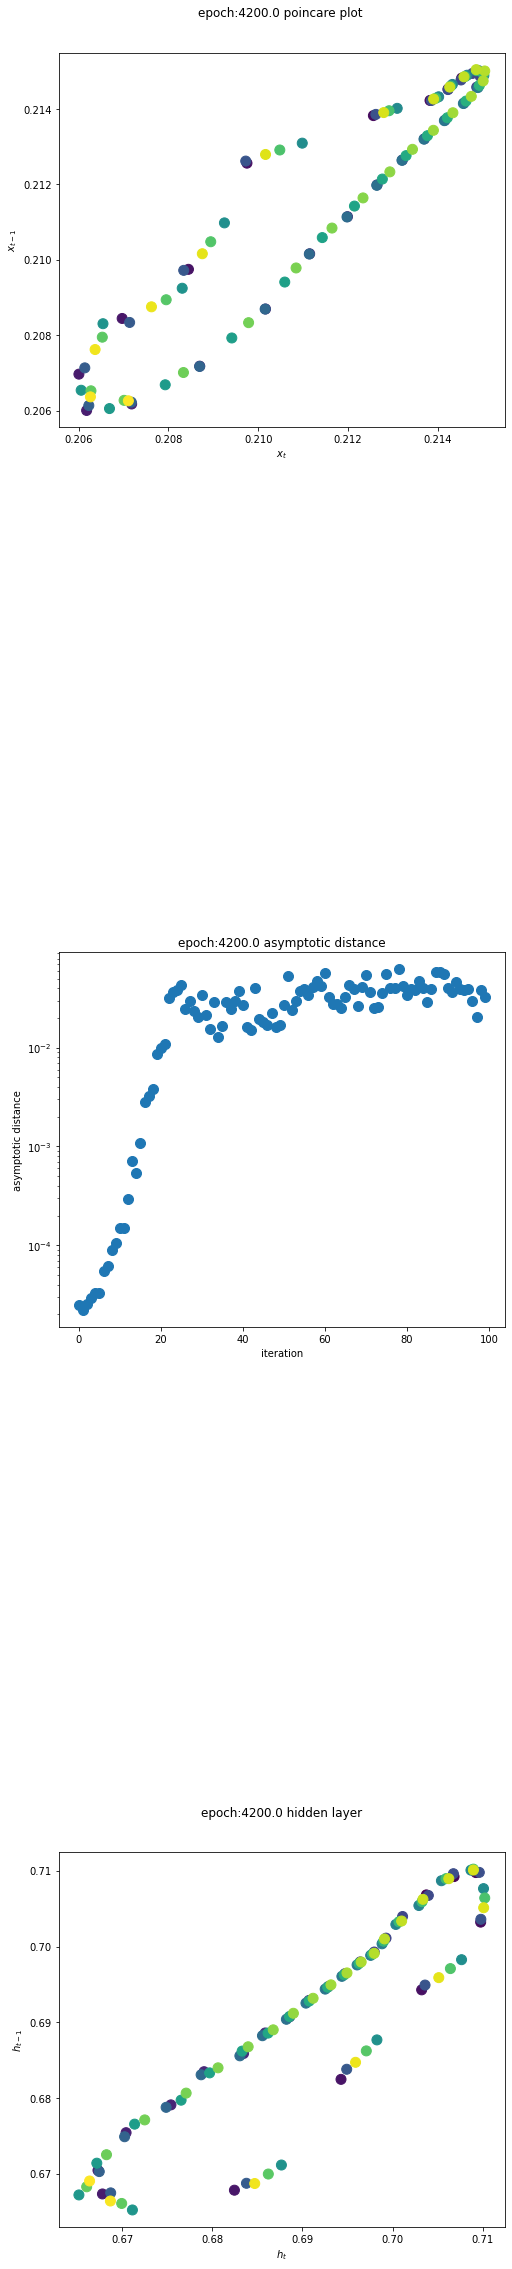

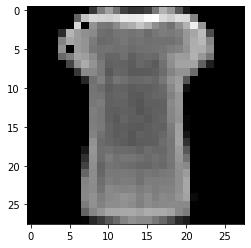

asymptotic image output epoch:4200.jpg
epoch : 4201/10000, training loss = 0.014686,validation loss = 0.019485
epoch : 4202/10000, training loss = 0.014494,validation loss = 0.019556
epoch : 4203/10000, training loss = 0.014638,validation loss = 0.019606
epoch : 4204/10000, training loss = 0.014700,validation loss = 0.019377
epoch : 4205/10000, training loss = 0.014554,validation loss = 0.019454
epoch : 4206/10000, training loss = 0.014642,validation loss = 0.019459
epoch : 4207/10000, training loss = 0.014825,validation loss = 0.019699
epoch : 4208/10000, training loss = 0.014727,validation loss = 0.019679
epoch : 4209/10000, training loss = 0.014491,validation loss = 0.019444
epoch : 4210/10000, training loss = 0.014456,validation loss = 0.019548
epoch : 4211/10000, training loss = 0.014610,validation loss = 0.019368
epoch : 4212/10000, training loss = 0.014687,validation loss = 0.019625
epoch : 4213/10000, training loss = 0.015220,validation loss = 0.019524
epoch : 4214/10000, train

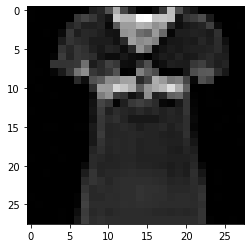

asymptotic image input epoch:4250.jpg


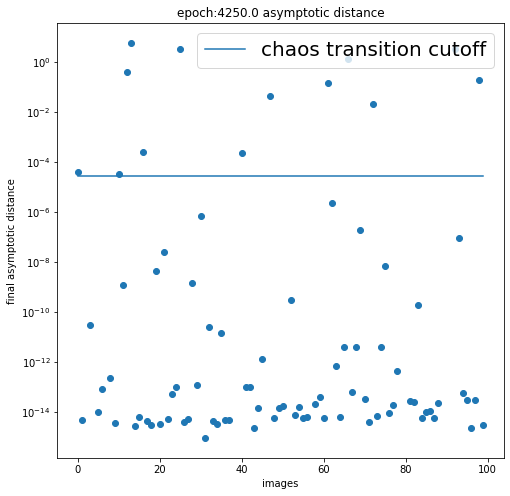

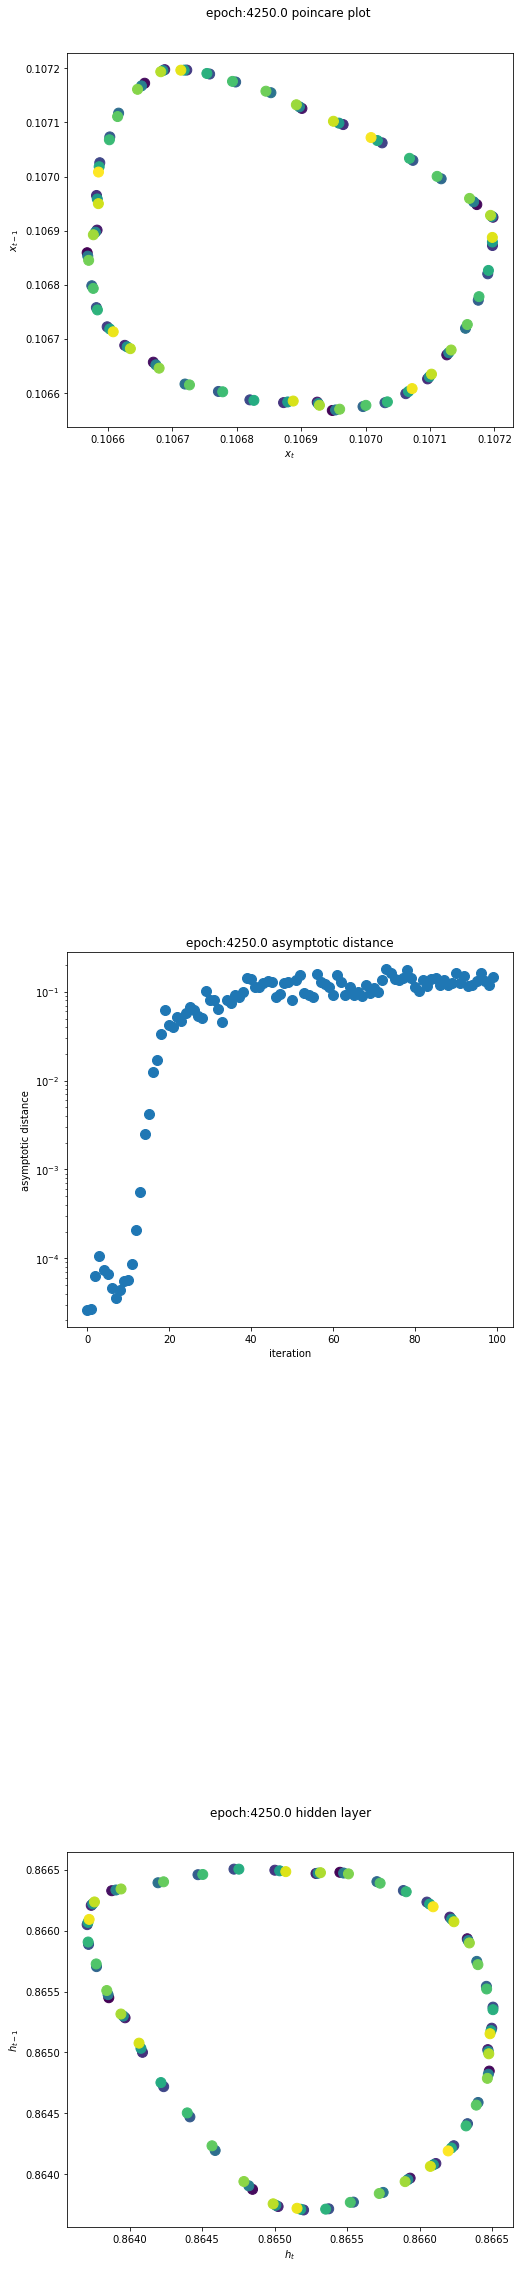

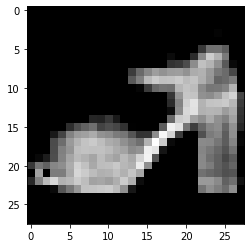

asymptotic image output epoch:4250.jpg
epoch : 4251/10000, training loss = 0.014793,validation loss = 0.019512
epoch : 4252/10000, training loss = 0.014648,validation loss = 0.019467
epoch : 4253/10000, training loss = 0.014623,validation loss = 0.019367
epoch : 4254/10000, training loss = 0.014757,validation loss = 0.019486
epoch : 4255/10000, training loss = 0.014647,validation loss = 0.019475
epoch : 4256/10000, training loss = 0.014566,validation loss = 0.019568
epoch : 4257/10000, training loss = 0.014586,validation loss = 0.019489
epoch : 4258/10000, training loss = 0.014804,validation loss = 0.019385
epoch : 4259/10000, training loss = 0.014525,validation loss = 0.019614
epoch : 4260/10000, training loss = 0.014602,validation loss = 0.019529
epoch : 4261/10000, training loss = 0.014758,validation loss = 0.019533
epoch : 4262/10000, training loss = 0.014773,validation loss = 0.019765
epoch : 4263/10000, training loss = 0.014882,validation loss = 0.019531
epoch : 4264/10000, train

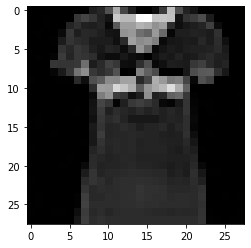

asymptotic image input epoch:4300.jpg


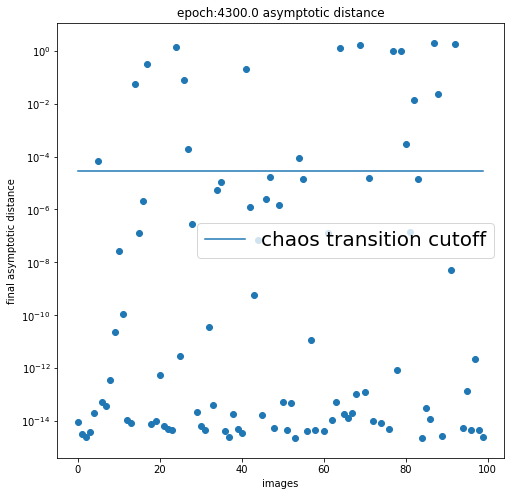

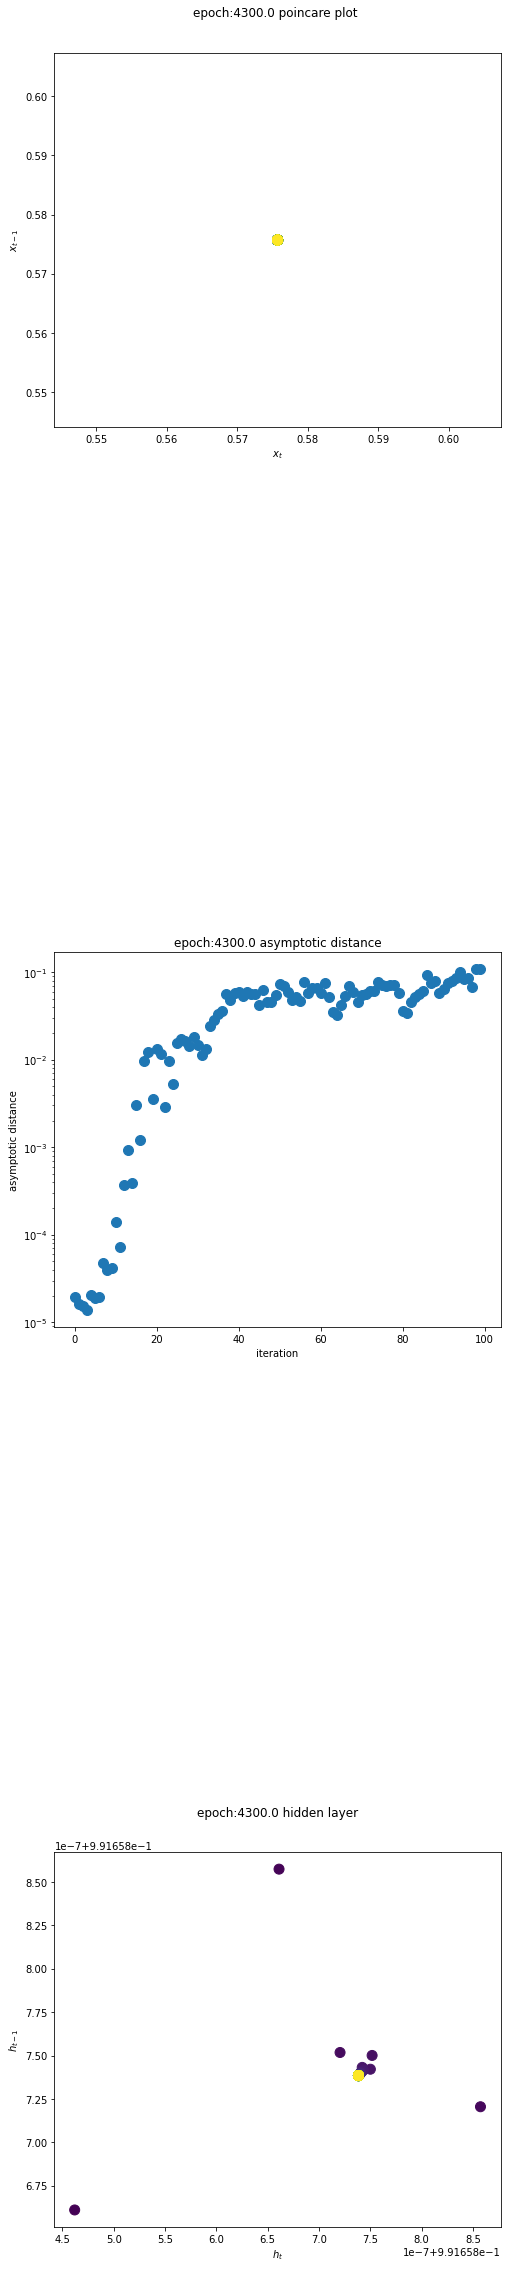

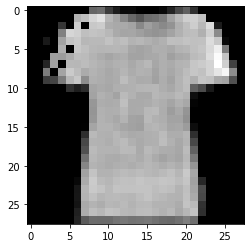

asymptotic image output epoch:4300.jpg
epoch : 4301/10000, training loss = 0.014545,validation loss = 0.019421
epoch : 4302/10000, training loss = 0.014374,validation loss = 0.019546
epoch : 4303/10000, training loss = 0.014534,validation loss = 0.019483
epoch : 4304/10000, training loss = 0.014801,validation loss = 0.019618
epoch : 4305/10000, training loss = 0.014578,validation loss = 0.019455
epoch : 4306/10000, training loss = 0.014503,validation loss = 0.019446
epoch : 4307/10000, training loss = 0.014635,validation loss = 0.019614
epoch : 4308/10000, training loss = 0.015131,validation loss = 0.019499
epoch : 4309/10000, training loss = 0.014678,validation loss = 0.019553
epoch : 4310/10000, training loss = 0.014471,validation loss = 0.019510
epoch : 4311/10000, training loss = 0.014597,validation loss = 0.019704
epoch : 4312/10000, training loss = 0.014561,validation loss = 0.019520
epoch : 4313/10000, training loss = 0.014453,validation loss = 0.019537
epoch : 4314/10000, train

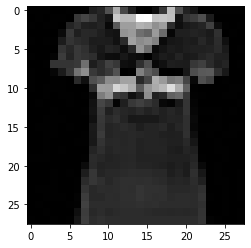

asymptotic image input epoch:4350.jpg


In [ ]:

spectral_radiuses=[]
average_jacobian=[]
xinfinity=[]
xpinfinity=[]
training_loss=[]
validation_loss=[]
asymptotic_dist=[]
diverge=[]
start=time.time()
print("running")
#strength=0.1
init_compute=False
cutoff_compute=True
chao=[]
image_distance=[]
valid=10**10
least_loss=0
for epoch in range(epochs):
    loss = 0
    

    for batch_features, _ in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        input_image =add_noise(batch_features,noise_strength).view(batch_size, -1).to(device)
        
        #input_image=add_noise(torch.zeros(28,28,100).view(100,-1),noise_strength).to(device)
        #input_image=batch_features.view(batch_size,-1).to(device)
        batch_feature=batch_features.view(batch_size,-1).to(device)
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
 
        optimizer.zero_grad()
        
        # compute reconstructions
        #outputs = model(batch_features.view(batch_size,-1).to(device))
        outputs = model(input_image)
        
        # compute training reconstruction loss
        
 
        train_loss = criterion(outputs,input_image)
        
        # compute accumulated gradients
        train_loss.backward()

        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
        torch.save(model.state_dict(), "epoch:"+str(epoch+1)+".pt")
        if epoch==0 and init_compute:
            x_train,y_pred,average_jacobian,spectral_radiuses,model_clone=calculation(model,no_of_images,no_of_repetition,average_jacobian,spectral_radiuses,batch_features.view(100,-1).to(device),epoch)
            for param in model.parameters():
                print(param.size())
            average_jacobian=[]
            spectral_radiuses=[]
            init_compute=False
    # compute the epoch training loss
    loss = loss / len(train_loader)
    training_loss.append(loss)
   # for i in batch_features:
    #    plt.imshow(i.view(28,28).cpu()*256)
     #   plt.show()
    
    # display the epoch training loss
    
    with torch.no_grad():
        accuracy=validation(test_loader)
        validation_loss.append(accuracy)
    if valid>accuracy:
        valid=accuracy
        least_loss=epoch
        
    print("epoch : {}/{}, training loss = {:.6f},validation loss = {:.6f}".format(epoch+1 , epochs, loss,accuracy))
    if (epoch)%interval==interval-1:
        name="asymptotic image input"
        visualisation(input_image.view(batch_size,-1)[0].cpu().detach(),epoch,name,True)
        x_train,y_pred,average_jacobian,spectral_radiuses,model_clone=calculation(model,no_of_images,no_of_repetition,average_jacobian,spectral_radiuses,input_image,epoch)


        dimension_vector=torch.ones(input_size).to(device)
        xt,xtminus=poincare_plot(model_clone,x_train[0],dimension_vector,no_of_repetition,colour,epoch)
       
       
            
        perturbed_inputs=add_noise(x_train,perturbation_strength)
        cutoff,distance,hidden,chaos,divergent=asymptotic_iteration(model_clone,x_train,perturbed_inputs,no_of_repetition,no_of_images,perturbation_strength*np.sqrt(input_size))
        
        fig = plt.figure(figsize=(8,8))
        plt.subplot(1,1,1)
        plt.scatter(range(no_of_images),cutoff)
        plt.plot(np.asarray([perturbation_strength*np.sqrt(input_size)]*len(cutoff)),label="chaos transition cutoff")
        plt.xlabel("images")
        plt.ylabel("final asymptotic distance")
        plt.yscale("log")
        plt.legend(loc="best",fontsize="20")
        plt.title("epoch:{:.1f} asymptotic distance".format(epoch+1))
        plt.savefig("epoch:"+str(epoch+1)+"number of iteration:"+str(no_of_repetition)+"chaos transition.jpg",bbox_inches = 'tight')
        plt.show()
        #image_distance.append(cutoff[0])   
        #print("percentage of chaos:",chaos) 
        #print("percentage of convergent:",divergent/100)
        asymptotic_dist.append(distance[-1])
        #print(distance[-1])
        #print(distance[0])
        chao.append(chaos)
        diverge.append(divergent/100)
        fig = plt.figure(figsize=(8,40))

        plt.subplot(5, 1, 1)
        plt.scatter(xt,xtminus,c=colour,s=100)
        plt.xlabel("$x_t$")
        plt.ylabel("$x_{t-1}$")
        plt.title("epoch:{:.1f} poincare plot ".format(epoch+1),y=1.08)
        
        plt.subplot(5, 1, 3)
        plt.scatter(range(no_of_repetition),distance,s=100)
        plt.xlabel("iteration")
        plt.ylabel("asymptotic distance")
        plt.yscale("log")
        plt.title("epoch:{:.1f} asymptotic distance".format(epoch+1))
        
        
        plt.subplot(5, 1, 5)
        #plt.figure().set_figheight(8)
        plt.scatter(hidden[:-1],hidden[1:],c=colour[:-1],s=100)
        plt.xlabel("$h_t$")
        plt.ylabel("$h_{t-1}$")
        #plt.yscale("log")
        plt.title("epoch:{:.1f} hidden layer".format(epoch+1),y=1.08)
        plt.savefig("epoch:"+str(epoch+1)+"number of iteration:"+str(no_of_repetition)+"autoencoder.jpg",bbox_inches = 'tight')
        plt.show()

        #torch.save(model.state_dict(), "epoch:"+str(epoch+1)+".pt")
        name="asymptotic image output"
        visualisation(y_pred.view(batch_size,-1)[0].cpu().detach(),epoch,name,True)
        #print(distance)
        
end=time.time()
print(end-start)

print(chao)
plt.plot(image_distance)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
labels="noise:{:F} \n perturbation:{:F}".format(noise_strength,perturbation_strength)
print(chao)
#print(diverge)
font = {
        'size'   : 16}
plt.rc('font', **font)

x=np.arange(1,201)
print(len(x))
print(len(chao))
plt.scatter(x,y=chao,label=labels)
plt.ylabel("fraction of images in chaos")
plt.xlabel("epoch/50")
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
plt.legend(loc="best")
plt.title("fraction of image in chaos for noised image",y=1.08)
plt.savefig("percentage of image in chaos.jpg",bbox_inches = 'tight')

np.savetxt("percentage of chaos.txt",chao)
plt.show()
print("asymptotic distance")

plt.scatter(x,y=asymptotic_dist,label=labels)
#labels="noise:"+str(noise_strength)+", perturbation:"+str(perturbation_strength)
plt.ylabel("asymptotic distance")
plt.xlabel("epoch/50")
plt.title("asymptotic distnace",y=1.08)
plt.yscale("log")
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
plt.legend(loc="best")
plt.savefig("asymptotic distance.jpg",bbox_inches = 'tight')

plt.show()
np.savetxt("asymptotic distance.txt",asymptotic_dist)
average_jacobian=np.asarray(average_jacobian)

print("average jacobian")
plt.scatter(x,y=average_jacobian,label="noise:{:F}\n perturbation:{:F}".format(noise_strength,perturbation_strength))
plt.ylabel("average_jacobian")
plt.xlabel("epoch/50")
plt.yscale("log")
plt.title("average_jacobian",y=1.08)

plt.legend(loc="best")
plt.savefig("average_jacobian.jpg",bbox_inches = 'tight')
np.savetxt("average jacobian.txt",average_jacobian)
plt.show()

#print("spectral radius")
#plt.scatter(x,y=spectral_radiuses,label="noise:{:F},perturbation:{:F}".format(noise_strength,perturbation_strength))
#plt.ylabel("spectral radius")
#plt.xlabel("epoch/20")
#plt.yscale("log")
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
#plt.legend(loc="best")
#plt.savefig("spectral radius.jpg"，bbox_inches = 'tight')
#np.savetxt("spectral radius.txt",spectral_radiuses)
#plt.show()

print("loss function")
plt.plot(validation_loss,label="validation loss")
plt.plot(training_loss,label="training loss")
plt.ylabel("losss")
plt.xlabel("epoch")
plt.title("loss function",y=1.08)
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
plt.legend(loc="best")
plt.yscale("log")
plt.savefig("loss function.jpg",bbox_inches = 'tight')
np.savetxt("loss_function.txt",(validation_loss,training_loss))
plt.show()

NameError: name 'noise_strength' is not defined

In [ ]:
distance[1]

In [21]:

validation_loss=[]
training_loss=[]
print("running")
for epoch in range(1,1001):
    loss = 0
    model = AE(input_size,output_size,hidden_state_size,no_of_layer).to(device)
    PATH="epoch:"+str(epoch)+".pt"
    model.load_state_dict(torch.load(PATH))
    for batch_features, _ in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        
        
        
        
        input_image =add_noise(batch_features,noise_strength).view(batch_size, -1).to(device)
        
        #input_image=batch_features.view(batch_size,-1).to(device)
        batch_feature=batch_features.view(batch_size,-1).to(device)
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
 
        #optimizer.zero_grad()
        
        # compute reconstructions
        #outputs = model(batch_features.view(batch_size,-1).to(device))
        outputs = model(input_image)
        
        # compute training reconstruction loss
        
 
        train_loss = criterion(outputs,input_image)
        

        loss += train_loss.item()
    # compute the epoch training loss
    loss = loss / len(train_loader)
    training_loss.append(loss)
    with torch.no_grad():
     #   accuracy=validation(test_loader)
        validation_loss.append(accuracy)
    if (epoch)%interval==interval-1:
     #   name="asymptotic image input"
        #visualisation(input_image.view(batch_size,-1)[0].cpu().detach(),epoch,name,True)
        x_train,y_pred,average_jacobian,spectral_radiuses,model_clone=calculation(model,no_of_images,no_of_repetition,average_jacobian,spectral_radiuses,input_image,epoch)


        dimension_vector=torch.ones(input_size).to(device)
        xt,xtminus=poincare_plot(model_clone,x_train[0],dimension_vector,no_of_repetition,colour,epoch)
       
        
        perturbed_inputs=add_noise(input_image,perturbation_strength)
        distance,hidden,chaos,divergent=asymptotic_iteration(model_clone,x_train,perturbed_inputs,no_of_repetition,no_of_images,perturbation_strength*input_size)
        print("percentage of chaos:",chaos)
        asymptotic_dist.append(distance[-1])
        #print(distance[-1])
        #print("initial distance")
        #print(distance[0])
        #chao.append(chaos)
        #print(torch.norm(perturbed_inputs[0]-input_image[0]))
        #print(perturbation_strength*input_size)

plt.scatter(x,y=chao,label=labels)
plt.savefig("percentage of image in chaos .jpg")
plt.title("perccentage of images in chaos for unoised images")
plt.ylabel("percentage of images in chaos ")
plt.xlabel("epoch/20")
np.savetxt("percentage of chaos.txt",chao)
plt.show()
    #model.eval()

running


KeyboardInterrupt: 

In [13]:
 print(perturbation_strength*input_size)

0.000784


['1.000000000000000021e-02', '2.000000000000000042e-02', '2.000000000000000042e-02', '5.999999999999999778e-02', '1.000000000000000056e-01', '5.999999999999999778e-02', '2.999999999999999889e-02', '1.300000000000000044e-01', '5.999999999999999778e-02', '1.900000000000000022e-01', '7.000000000000000666e-02', '1.400000000000000133e-01', '1.000000000000000056e-01', '8.000000000000000167e-02', '8.000000000000000167e-02', '1.700000000000000122e-01', '1.000000000000000056e-01', '1.600000000000000033e-01', '5.999999999999999778e-02', '2.000000000000000042e-02', '5.999999999999999778e-02', '2.200000000000000011e-01', '1.400000000000000133e-01', '1.600000000000000033e-01', '1.700000000000000122e-01', '1.799999999999999933e-01', '1.400000000000000133e-01', '1.100000000000000006e-01', '1.000000000000000056e-01', '2.000000000000000042e-02', '1.100000000000000006e-01', '1.300000000000000044e-01', '1.700000000000000122e-01', '1.199999999999999956e-01', '1.499999999999999944e-01', '1.4000000000000001

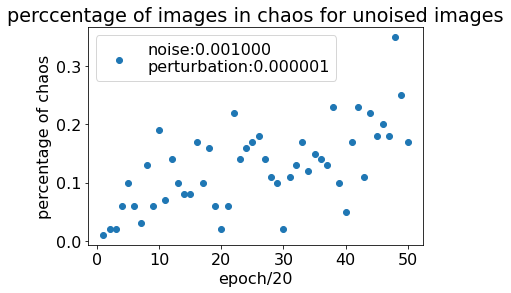

In [25]:
my_file = open("percentage of chaos unoised.txt", "r")
  
# reading the file
data = my_file.read()
  
# replacing end of line('/n') with ' ' and
# splitting the text it further when '.' is seen.
data_into_list = data.replace('\n', ' ').split(" ")
print(data_into_list[:-1])
data=[]
for i in range(len(data_into_list[:-1])):
    data.append(float(data_into_list[i]))
print(data)
x=np.arange(1,51)
labels="noise:{:F}\nperturbation:{:F}".format(10**-3,10**-6)
plt.scatter(x,y=data,label=labels)
#labels="noise:"+str(noise_strength)+", perturbation:"+str(perturbation_strength)
plt.ylabel("percentage of chaos")
plt.xlabel("epoch/20")
#plt.yscale("log")
plt.title("perccentage of images in chaos for unoised images")

#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
plt.legend(loc="best")
plt.savefig("average jacobian.jpg")

plt.show()